In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3
pose_w, pose_h, pose_d = 4,4,36

In [3]:
dataset = np.load('../../car_64.npy')


1553596416


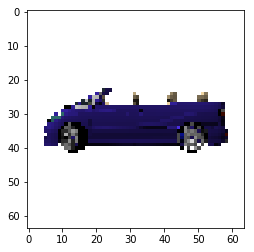

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

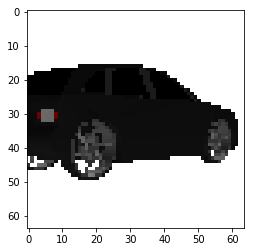

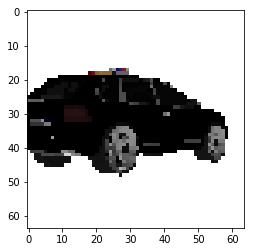

In [8]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0,9,18,27]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0,9,18,27]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(0, 9, 0)
(0, 9, 0)
(86, 18, 12)
(290, 27, 11)


(2388, 27, 16)
(429, 27, 23)
393260


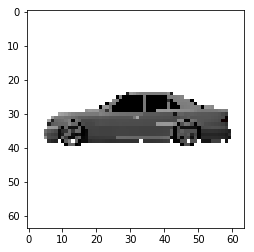

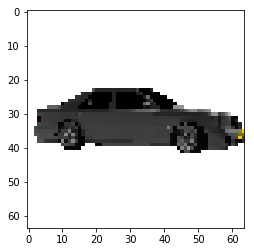

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
def normalize(data):
    data = data * 2.0
    data = data / 255.0
    data = data - 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [13]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [14]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(pose_w, pose_h, pose_d)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(test_pairs[35*36:36*36], False)

(36, 64, 64, 3) (36, 64, 64, 3) (36, 4, 4, 36)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -1.0


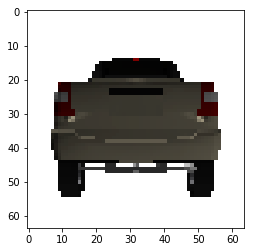

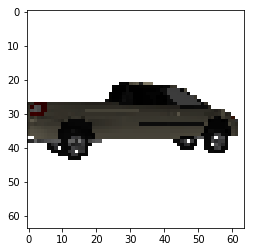

In [15]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 13
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [16]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [17]:
tf.reset_default_graph()

In [18]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, pose_w, pose_h, pose_d), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [19]:
ae_reuse= False
disc_reuse = False

#https://github.com/skaae/vaeblog

def auto_encoder(inputs_, pose_):
    global ae_reuse
    with tf.variable_scope('encoder', reuse=ae_reuse):
        ae_reuse = True
        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=48 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv4",act=lrelu)# 4 * 4 * 128
        _ = tf.concat([pose_, _], 3)
       

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu) # 8 * 8 * 64
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu) # 16 * 16 * 32
        gact = _
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu) # act = 32*32*16
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ , gact

'''
def generator(inputs_)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ 
'''

# discriminator should give a fc layer
# No batch norm layer
def discriminator(inputs_):
    global disc_reuse 
    with tf.variable_scope('dis', reuse=disc_reuse):
        disc_reuse = True
        
        _ = conv2d(inputs_, output=16 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv1", act=lrelu) # 32 * 32 * 16
        print(_.get_shape())
        _ = conv2d(_, output=32 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv2", act=lrelu) # act 16*16*32
        dact = _
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_1')
        _ = conv2d(_, output=64 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv3", act=lrelu)
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_2')
        _ = tf.reshape(_, [-1, 8 * 8 * 64])        
        _ = fc(_, 1, 'dis_fc1')
        o1 = tf.nn.sigmoid(_)
        o2 = _
        o3 = dact
        return o1, o2, o3


In [20]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [21]:
alpha = 0.000001 #0.2
beta = 1.0 #1.0


'''
generated_images = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise = auto_encoder(noise, pose_)

dreal, dreal_logits = discriminator(disc_inputs)
dfake, dfake_logits = discriminator(generated_images)
dnoise, dnoise_logits = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) #+ 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
#gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)


supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = gan_loss + supervised_loss
'''


generated_images, g_act_real = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise, g_act_noise = auto_encoder(noise, pose_)

dreal, dreal_logits, dact_real = discriminator(disc_inputs)
dfake, dfake_logits, dact_fake = discriminator(generated_images)
dnoise, dnoise_logits, dact_noise = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) #+ 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


#g_act_real = tf.contrib.layers.flatten(g_act_real)
#dact_real = tf.contrib.layers.flatten(dact_real)
#g_act_noise = tf.contrib.layers.flatten(g_act_noise)
#dact_noise = tf.contrib.layers.flatten(dact_noise)
#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
#gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)
gan_loss = tf.sqrt(tf.reduce_sum(tf.pow((g_act_real - dact_real), 2))) +  tf.sqrt(tf.reduce_sum(tf.pow(g_act_noise - dact_noise, 2)))
#gan_loss = alpha * gan_loss
supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = alpha * gan_loss + supervised_loss

# Build Loss
#gen_loss_op = -tf.reduce_mean(tf.log(dis_fake_samples_op))
#dis_loss_op = -tf.reduce_mean(tf.log(dis_real_samples_op) + tf.log(1. - dis_fake_samples_op))

# Build Optimizers
#optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)




O1 (36, 64, 64, 3)
O1 (36, 64, 64, 3)
(36, 32, 32, 16)
(36, 32, 32, 16)
(36, 32, 32, 16)


In [22]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
#dis_optimizer = tf.train.RMSPropOptimizer(lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.RMSPropOptimizer(lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)


#dis_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)
dlr = 1e-6#1e-4
glr = 1e-3#5e-4

dis_optimizer = tf.train.AdamOptimizer(dlr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.AdamOptimizer(glr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

'''
dis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)
gvs = dis_optimizer.compute_gradients(dis_loss_op, var_list=generator_vars)
gcapped_gvs = [(tf.clip_by_value(grad, -10.0, 10.0), var) for grad, var in gvs]
dis_train_op = dis_optimizer.apply_gradients(gcapped_gvs)


gen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)
gvs = gen_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars)
dcapped_gvs = [(tf.clip_by_value(grad, -10.0, 10.0), var) for grad, var in gvs]
dis_train_op = dis_optimizer.apply_gradients(dcapped_gvs)
'''

'''
dis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)
dgradients, dvariables = zip(*dis_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars))
dgradients, _ = tf.clip_by_global_norm(dgradients, 5.0)
dis_train_op = dis_optimizer.apply_gradients(zip(dgradients, dvariables))


gen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)
ggradients, gvariables = zip(*gen_optimizer.compute_gradients(gen_loss_op, var_list=generator_vars))
ggradients, _ = tf.clip_by_global_norm(ggradients, 5.0)
gen_train_op = gen_optimizer.apply_gradients(zip(ggradients, gvariables))
'''






'\ndis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)\ndgradients, dvariables = zip(*dis_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars))\ndgradients, _ = tf.clip_by_global_norm(dgradients, 5.0)\ndis_train_op = dis_optimizer.apply_gradients(zip(dgradients, dvariables))\n\n\ngen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)\nggradients, gvariables = zip(*gen_optimizer.compute_gradients(gen_loss_op, var_list=generator_vars))\nggradients, _ = tf.clip_by_global_norm(ggradients, 5.0)\ngen_train_op = gen_optimizer.apply_gradients(zip(ggradients, gvariables))\n'

Step 10: dloss = 14.3324, gloss = 0.8095, real_loss = 13.5996, fake_loss = 0.7328, gan_loss = 19538.4629 l1_loss = 0.7900
Step 20: dloss = 3.9856, gloss = 0.7052, real_loss = 3.2899, fake_loss = 0.6957, gan_loss = 20224.3457 l1_loss = 0.6850
Step 30: dloss = 9.8405, gloss = 0.6086, real_loss = 9.1446, fake_loss = 0.6959, gan_loss = 19412.9902 l1_loss = 0.5892
Step 40: dloss = 14.3056, gloss = 0.5322, real_loss = 13.5889, fake_loss = 0.7167, gan_loss = 19894.6250 l1_loss = 0.5123
Step 50: dloss = 10.4652, gloss = 0.4816, real_loss = 9.7481, fake_loss = 0.7171, gan_loss = 20226.3672 l1_loss = 0.4614
Step 60: dloss = 13.7845, gloss = 0.4382, real_loss = 13.0768, fake_loss = 0.7077, gan_loss = 20383.2188 l1_loss = 0.4178
Step 70: dloss = 5.2789, gloss = 0.4031, real_loss = 4.5726, fake_loss = 0.7063, gan_loss = 20986.4199 l1_loss = 0.3821
Step 80: dloss = 9.8629, gloss = 0.3809, real_loss = 9.1221, fake_loss = 0.7408, gan_loss = 18687.5156 l1_loss = 0.3622
Step 90: dloss = 9.7293, gloss = 

Step 690: dloss = 4.9757, gloss = 0.1722, real_loss = 4.2283, fake_loss = 0.7475, gan_loss = 19253.7402 l1_loss = 0.1530
Step 700: dloss = 5.4933, gloss = 0.1968, real_loss = 4.7357, fake_loss = 0.7576, gan_loss = 19688.7871 l1_loss = 0.1771
Step 710: dloss = 5.8335, gloss = 0.1868, real_loss = 5.1058, fake_loss = 0.7277, gan_loss = 19752.3828 l1_loss = 0.1670
Step 720: dloss = 3.4654, gloss = 0.1917, real_loss = 2.7045, fake_loss = 0.7609, gan_loss = 19268.1504 l1_loss = 0.1724
Step 730: dloss = 7.8327, gloss = 0.1751, real_loss = 7.1038, fake_loss = 0.7289, gan_loss = 19919.9648 l1_loss = 0.1552
Step 740: dloss = 3.1874, gloss = 0.1812, real_loss = 2.4502, fake_loss = 0.7372, gan_loss = 19129.4277 l1_loss = 0.1621
Step 750: dloss = 4.4154, gloss = 0.2072, real_loss = 3.7000, fake_loss = 0.7154, gan_loss = 19816.7988 l1_loss = 0.1874
Step 760: dloss = 4.2235, gloss = 0.1864, real_loss = 3.4657, fake_loss = 0.7578, gan_loss = 20207.0117 l1_loss = 0.1662
Step 770: dloss = 8.8654, gloss 

Step 1370: dloss = 2.0752, gloss = 0.1990, real_loss = 1.3119, fake_loss = 0.7634, gan_loss = 19429.2109 l1_loss = 0.1795
Step 1380: dloss = 3.8412, gloss = 0.1639, real_loss = 3.0620, fake_loss = 0.7792, gan_loss = 18429.7363 l1_loss = 0.1455
Step 1390: dloss = 3.3971, gloss = 0.1453, real_loss = 2.6450, fake_loss = 0.7521, gan_loss = 19076.9336 l1_loss = 0.1262
Step 1400: dloss = 2.5299, gloss = 0.1584, real_loss = 1.7597, fake_loss = 0.7702, gan_loss = 18498.4375 l1_loss = 0.1399
Step 1410: dloss = 2.6208, gloss = 0.1594, real_loss = 1.8646, fake_loss = 0.7562, gan_loss = 18729.3203 l1_loss = 0.1407
Step 1420: dloss = 5.2619, gloss = 0.1817, real_loss = 4.4904, fake_loss = 0.7715, gan_loss = 19046.0234 l1_loss = 0.1626
Step 1430: dloss = 2.2676, gloss = 0.1620, real_loss = 1.4838, fake_loss = 0.7838, gan_loss = 19822.2988 l1_loss = 0.1422
Step 1440: dloss = 2.7726, gloss = 0.1541, real_loss = 2.0030, fake_loss = 0.7695, gan_loss = 18867.1406 l1_loss = 0.1352
Step 1450: dloss = 5.698

Step 2050: dloss = 2.1754, gloss = 0.1407, real_loss = 1.4118, fake_loss = 0.7636, gan_loss = 19452.0137 l1_loss = 0.1212
Step 2060: dloss = 3.7767, gloss = 0.1398, real_loss = 2.9877, fake_loss = 0.7890, gan_loss = 18727.7227 l1_loss = 0.1210
Step 2070: dloss = 0.8994, gloss = 0.1352, real_loss = 0.1317, fake_loss = 0.7677, gan_loss = 19499.8965 l1_loss = 0.1157
Step 2080: dloss = 1.1582, gloss = 0.1393, real_loss = 0.3759, fake_loss = 0.7822, gan_loss = 19166.7402 l1_loss = 0.1201
Step 2090: dloss = 3.0830, gloss = 0.1427, real_loss = 2.3123, fake_loss = 0.7707, gan_loss = 19400.9434 l1_loss = 0.1233
Step 2100: dloss = 1.1197, gloss = 0.1521, real_loss = 0.3393, fake_loss = 0.7804, gan_loss = 20286.5605 l1_loss = 0.1318
Step 2110: dloss = 2.2358, gloss = 0.1487, real_loss = 1.4529, fake_loss = 0.7829, gan_loss = 19256.9395 l1_loss = 0.1294
Step 2120: dloss = 5.6964, gloss = 0.1395, real_loss = 4.9167, fake_loss = 0.7797, gan_loss = 19481.5391 l1_loss = 0.1201
Step 2130: dloss = 1.524

Step 2730: dloss = 2.9120, gloss = 0.1391, real_loss = 2.1072, fake_loss = 0.8048, gan_loss = 19026.3730 l1_loss = 0.1200
Step 2740: dloss = 1.8924, gloss = 0.1361, real_loss = 1.0952, fake_loss = 0.7972, gan_loss = 19456.2402 l1_loss = 0.1166
Step 2750: dloss = 0.7951, gloss = 0.1294, real_loss = 0.0132, fake_loss = 0.7819, gan_loss = 18966.2148 l1_loss = 0.1104
Step 2760: dloss = 1.3057, gloss = 0.1442, real_loss = 0.5060, fake_loss = 0.7997, gan_loss = 18705.5625 l1_loss = 0.1255
Step 2770: dloss = 2.8211, gloss = 0.1372, real_loss = 2.0067, fake_loss = 0.8145, gan_loss = 19377.9902 l1_loss = 0.1178
Step 2780: dloss = 0.7884, gloss = 0.1542, real_loss = 0.0001, fake_loss = 0.7884, gan_loss = 19047.3945 l1_loss = 0.1351
Step 2790: dloss = 1.0130, gloss = 0.1429, real_loss = 0.2418, fake_loss = 0.7712, gan_loss = 19368.8672 l1_loss = 0.1236
Step 2800: dloss = 1.3710, gloss = 0.1475, real_loss = 0.5670, fake_loss = 0.8040, gan_loss = 18574.9258 l1_loss = 0.1289
Step 2810: dloss = 3.257

Step 3410: dloss = 0.8003, gloss = 0.1271, real_loss = 0.0002, fake_loss = 0.8001, gan_loss = 19071.0664 l1_loss = 0.1081
Step 3420: dloss = 3.2414, gloss = 0.1502, real_loss = 2.4368, fake_loss = 0.8045, gan_loss = 18537.7090 l1_loss = 0.1317
Step 3430: dloss = 1.1151, gloss = 0.1377, real_loss = 0.2916, fake_loss = 0.8236, gan_loss = 18466.6016 l1_loss = 0.1193
Step 3440: dloss = 2.2818, gloss = 0.1608, real_loss = 1.4539, fake_loss = 0.8278, gan_loss = 18634.8281 l1_loss = 0.1422
Step 3450: dloss = 0.9208, gloss = 0.1303, real_loss = 0.1022, fake_loss = 0.8186, gan_loss = 19296.3047 l1_loss = 0.1110
Step 3460: dloss = 0.8251, gloss = 0.1371, real_loss = 0.0010, fake_loss = 0.8241, gan_loss = 18705.1797 l1_loss = 0.1184
Step 3470: dloss = 1.5272, gloss = 0.1355, real_loss = 0.7299, fake_loss = 0.7973, gan_loss = 17609.0449 l1_loss = 0.1179
Step 3480: dloss = 1.8489, gloss = 0.1287, real_loss = 1.0704, fake_loss = 0.7785, gan_loss = 19406.7168 l1_loss = 0.1093
Step 3490: dloss = 0.806

Step 4090: dloss = 0.8269, gloss = 0.1430, real_loss = 0.0000, fake_loss = 0.8268, gan_loss = 18928.0645 l1_loss = 0.1241
Step 4100: dloss = 1.1596, gloss = 0.1400, real_loss = 0.3458, fake_loss = 0.8138, gan_loss = 18499.8789 l1_loss = 0.1215
Step 4110: dloss = 2.0511, gloss = 0.1325, real_loss = 1.2563, fake_loss = 0.7948, gan_loss = 18670.7402 l1_loss = 0.1138
Step 4120: dloss = 1.6978, gloss = 0.1475, real_loss = 0.9073, fake_loss = 0.7904, gan_loss = 19158.3301 l1_loss = 0.1283
Step 4130: dloss = 0.9603, gloss = 0.1154, real_loss = 0.1396, fake_loss = 0.8207, gan_loss = 18474.6172 l1_loss = 0.0970
Step 4140: dloss = 1.0254, gloss = 0.1287, real_loss = 0.2157, fake_loss = 0.8096, gan_loss = 18827.1094 l1_loss = 0.1099
Step 4150: dloss = 0.8093, gloss = 0.1349, real_loss = 0.0000, fake_loss = 0.8093, gan_loss = 18726.0469 l1_loss = 0.1161
Step 4160: dloss = 0.7990, gloss = 0.1322, real_loss = 0.0000, fake_loss = 0.7990, gan_loss = 19148.4531 l1_loss = 0.1130
Step 4170: dloss = 0.881

Step 4770: dloss = 0.8302, gloss = 0.1207, real_loss = 0.0000, fake_loss = 0.8302, gan_loss = 18585.5215 l1_loss = 0.1021
Step 4780: dloss = 2.2131, gloss = 0.1226, real_loss = 1.3920, fake_loss = 0.8211, gan_loss = 18856.6660 l1_loss = 0.1038
Step 4790: dloss = 0.7918, gloss = 0.1273, real_loss = 0.0013, fake_loss = 0.7904, gan_loss = 18632.4922 l1_loss = 0.1086
Step 4800: dloss = 1.2665, gloss = 0.1469, real_loss = 0.4532, fake_loss = 0.8133, gan_loss = 18354.7676 l1_loss = 0.1285
Step 4810: dloss = 1.1883, gloss = 0.1477, real_loss = 0.3626, fake_loss = 0.8258, gan_loss = 18563.2793 l1_loss = 0.1291
Step 4820: dloss = 1.2957, gloss = 0.1277, real_loss = 0.4704, fake_loss = 0.8252, gan_loss = 18940.2383 l1_loss = 0.1087
Step 4830: dloss = 1.3637, gloss = 0.1314, real_loss = 0.5736, fake_loss = 0.7901, gan_loss = 19473.1309 l1_loss = 0.1120
Step 4840: dloss = 0.8531, gloss = 0.1446, real_loss = 0.0003, fake_loss = 0.8528, gan_loss = 18548.6445 l1_loss = 0.1261
Step 4850: dloss = 2.333

Step 5450: dloss = 0.8033, gloss = 0.1495, real_loss = 0.0000, fake_loss = 0.8033, gan_loss = 19116.7461 l1_loss = 0.1304
Step 5460: dloss = 1.5517, gloss = 0.1193, real_loss = 0.7146, fake_loss = 0.8371, gan_loss = 18881.7383 l1_loss = 0.1004
Step 5470: dloss = 0.7979, gloss = 0.1494, real_loss = 0.0001, fake_loss = 0.7978, gan_loss = 19060.4219 l1_loss = 0.1304
Step 5480: dloss = 3.6537, gloss = 0.1394, real_loss = 2.8456, fake_loss = 0.8081, gan_loss = 18739.8809 l1_loss = 0.1207
Step 5490: dloss = 0.8033, gloss = 0.1316, real_loss = 0.0000, fake_loss = 0.8033, gan_loss = 18970.9062 l1_loss = 0.1126
Step 5500: dloss = 2.6951, gloss = 0.1314, real_loss = 1.8880, fake_loss = 0.8071, gan_loss = 19035.4570 l1_loss = 0.1123
Step 5510: dloss = 1.3160, gloss = 0.1249, real_loss = 0.5077, fake_loss = 0.8083, gan_loss = 18750.2051 l1_loss = 0.1061
Step 5520: dloss = 1.6950, gloss = 0.1323, real_loss = 0.9031, fake_loss = 0.7919, gan_loss = 18620.9395 l1_loss = 0.1137
Step 5530: dloss = 0.806

Step 6130: dloss = 0.8179, gloss = 0.1337, real_loss = 0.0022, fake_loss = 0.8157, gan_loss = 18874.2930 l1_loss = 0.1148
Step 6140: dloss = 1.1645, gloss = 0.1138, real_loss = 0.3422, fake_loss = 0.8223, gan_loss = 18717.3828 l1_loss = 0.0951
Step 6150: dloss = 1.2626, gloss = 0.1385, real_loss = 0.4339, fake_loss = 0.8287, gan_loss = 17781.3711 l1_loss = 0.1207
Step 6160: dloss = 0.8450, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8450, gan_loss = 18583.5254 l1_loss = 0.0916
Step 6170: dloss = 1.3755, gloss = 0.1243, real_loss = 0.5704, fake_loss = 0.8050, gan_loss = 18490.4824 l1_loss = 0.1058
Step 6180: dloss = 1.3812, gloss = 0.1276, real_loss = 0.5616, fake_loss = 0.8195, gan_loss = 18531.7500 l1_loss = 0.1090
Step 6190: dloss = 1.2926, gloss = 0.1348, real_loss = 0.4595, fake_loss = 0.8331, gan_loss = 19073.8867 l1_loss = 0.1158
Step 6200: dloss = 0.8618, gloss = 0.1164, real_loss = 0.0000, fake_loss = 0.8618, gan_loss = 19303.6562 l1_loss = 0.0971
Step 6210: dloss = 1.448

Step 6810: dloss = 1.1855, gloss = 0.1154, real_loss = 0.3539, fake_loss = 0.8315, gan_loss = 18947.4727 l1_loss = 0.0964
Step 6820: dloss = 1.3028, gloss = 0.1172, real_loss = 0.5188, fake_loss = 0.7840, gan_loss = 19702.8145 l1_loss = 0.0975
Step 6830: dloss = 1.4422, gloss = 0.1347, real_loss = 0.5976, fake_loss = 0.8446, gan_loss = 18583.6973 l1_loss = 0.1161
Step 6840: dloss = 1.5450, gloss = 0.1254, real_loss = 0.7293, fake_loss = 0.8157, gan_loss = 17800.4590 l1_loss = 0.1076
Step 6850: dloss = 1.2590, gloss = 0.1283, real_loss = 0.4545, fake_loss = 0.8045, gan_loss = 19383.1387 l1_loss = 0.1089
Step 6860: dloss = 1.3569, gloss = 0.1342, real_loss = 0.5337, fake_loss = 0.8232, gan_loss = 18331.4922 l1_loss = 0.1159
Step 6870: dloss = 2.3511, gloss = 0.1264, real_loss = 1.5072, fake_loss = 0.8439, gan_loss = 17668.2949 l1_loss = 0.1088
Step 6880: dloss = 0.8394, gloss = 0.1276, real_loss = 0.0000, fake_loss = 0.8394, gan_loss = 18967.2734 l1_loss = 0.1086
Step 6890: dloss = 1.415

Step 7490: dloss = 0.8369, gloss = 0.1279, real_loss = 0.0000, fake_loss = 0.8369, gan_loss = 18719.9453 l1_loss = 0.1092
Step 7500: dloss = 0.8573, gloss = 0.1378, real_loss = 0.0144, fake_loss = 0.8429, gan_loss = 18808.4336 l1_loss = 0.1190
Step 7510: dloss = 0.8256, gloss = 0.1305, real_loss = 0.0001, fake_loss = 0.8256, gan_loss = 19086.7949 l1_loss = 0.1114
Step 7520: dloss = 0.8465, gloss = 0.1341, real_loss = 0.0000, fake_loss = 0.8465, gan_loss = 18746.8633 l1_loss = 0.1154
Step 7530: dloss = 0.8558, gloss = 0.1143, real_loss = 0.0045, fake_loss = 0.8513, gan_loss = 19034.4922 l1_loss = 0.0953
Step 7540: dloss = 1.5560, gloss = 0.1225, real_loss = 0.7530, fake_loss = 0.8030, gan_loss = 18794.0547 l1_loss = 0.1037
Step 7550: dloss = 0.8258, gloss = 0.1295, real_loss = 0.0000, fake_loss = 0.8258, gan_loss = 18598.7461 l1_loss = 0.1109
Step 7560: dloss = 0.8687, gloss = 0.1286, real_loss = 0.0355, fake_loss = 0.8332, gan_loss = 18245.8984 l1_loss = 0.1103
Step 7570: dloss = 0.841

Step 8170: dloss = 1.0275, gloss = 0.1260, real_loss = 0.2243, fake_loss = 0.8033, gan_loss = 18172.2090 l1_loss = 0.1079
Step 8180: dloss = 0.8242, gloss = 0.1218, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 19077.9531 l1_loss = 0.1027
Step 8190: dloss = 1.3069, gloss = 0.1352, real_loss = 0.4815, fake_loss = 0.8254, gan_loss = 18595.7520 l1_loss = 0.1166
Step 8200: dloss = 0.8163, gloss = 0.1258, real_loss = 0.0000, fake_loss = 0.8163, gan_loss = 18654.3652 l1_loss = 0.1071
Step 8210: dloss = 1.3483, gloss = 0.1130, real_loss = 0.5274, fake_loss = 0.8209, gan_loss = 18550.6582 l1_loss = 0.0944
Step 8220: dloss = 1.1815, gloss = 0.1393, real_loss = 0.3926, fake_loss = 0.7888, gan_loss = 18290.1758 l1_loss = 0.1210
Step 8230: dloss = 0.9824, gloss = 0.1312, real_loss = 0.1447, fake_loss = 0.8377, gan_loss = 17732.6523 l1_loss = 0.1135
Step 8240: dloss = 1.9616, gloss = 0.1179, real_loss = 1.1183, fake_loss = 0.8433, gan_loss = 18861.3574 l1_loss = 0.0991
Step 8250: dloss = 1.110

Step 8850: dloss = 0.8176, gloss = 0.1342, real_loss = 0.0078, fake_loss = 0.8098, gan_loss = 18468.4512 l1_loss = 0.1157
Step 8860: dloss = 2.4847, gloss = 0.1306, real_loss = 1.6170, fake_loss = 0.8678, gan_loss = 18035.2344 l1_loss = 0.1126
Step 8870: dloss = 0.8502, gloss = 0.1372, real_loss = 0.0002, fake_loss = 0.8500, gan_loss = 18739.4473 l1_loss = 0.1185
Step 8880: dloss = 0.8278, gloss = 0.1206, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 18889.2188 l1_loss = 0.1017
Step 8890: dloss = 0.8001, gloss = 0.1330, real_loss = 0.0000, fake_loss = 0.8001, gan_loss = 18391.8828 l1_loss = 0.1146
Step 8900: dloss = 1.1064, gloss = 0.1363, real_loss = 0.3108, fake_loss = 0.7957, gan_loss = 18495.2617 l1_loss = 0.1178
Step 8910: dloss = 0.8798, gloss = 0.1271, real_loss = 0.0197, fake_loss = 0.8601, gan_loss = 18624.3613 l1_loss = 0.1085
Step 8920: dloss = 1.3409, gloss = 0.1353, real_loss = 0.5216, fake_loss = 0.8193, gan_loss = 18653.4199 l1_loss = 0.1167
Step 8930: dloss = 0.838

Step 9530: dloss = 0.8486, gloss = 0.1103, real_loss = 0.0009, fake_loss = 0.8477, gan_loss = 18646.2695 l1_loss = 0.0916
Step 9540: dloss = 0.8262, gloss = 0.1126, real_loss = 0.0000, fake_loss = 0.8262, gan_loss = 18831.7012 l1_loss = 0.0938
Step 9550: dloss = 0.8128, gloss = 0.1359, real_loss = 0.0011, fake_loss = 0.8116, gan_loss = 18626.4023 l1_loss = 0.1173
Step 9560: dloss = 0.8525, gloss = 0.1113, real_loss = 0.0000, fake_loss = 0.8525, gan_loss = 18784.8496 l1_loss = 0.0925
Step 9570: dloss = 1.5720, gloss = 0.1149, real_loss = 0.7306, fake_loss = 0.8414, gan_loss = 18074.4902 l1_loss = 0.0968
Step 9580: dloss = 0.8072, gloss = 0.1251, real_loss = 0.0000, fake_loss = 0.8072, gan_loss = 19137.1895 l1_loss = 0.1059
Step 9590: dloss = 2.0188, gloss = 0.1236, real_loss = 1.1792, fake_loss = 0.8395, gan_loss = 18444.2012 l1_loss = 0.1051
Step 9600: dloss = 0.8206, gloss = 0.1192, real_loss = 0.0003, fake_loss = 0.8203, gan_loss = 18838.7109 l1_loss = 0.1003
Step 9610: dloss = 0.811

Step 10200: dloss = 0.8514, gloss = 0.1129, real_loss = 0.0183, fake_loss = 0.8331, gan_loss = 18077.9316 l1_loss = 0.0948
Step 10210: dloss = 0.8418, gloss = 0.1190, real_loss = 0.0000, fake_loss = 0.8418, gan_loss = 18724.4258 l1_loss = 0.1002
Step 10220: dloss = 0.8121, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 18900.8574 l1_loss = 0.0938
Step 10230: dloss = 1.1048, gloss = 0.1197, real_loss = 0.2689, fake_loss = 0.8359, gan_loss = 18997.7910 l1_loss = 0.1007
Step 10240: dloss = 2.0560, gloss = 0.1198, real_loss = 1.2016, fake_loss = 0.8544, gan_loss = 18177.6543 l1_loss = 0.1016
Step 10250: dloss = 1.5486, gloss = 0.1212, real_loss = 0.7179, fake_loss = 0.8307, gan_loss = 18813.5195 l1_loss = 0.1024
Step 10260: dloss = 0.8142, gloss = 0.1352, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 19024.2773 l1_loss = 0.1161
Step 10270: dloss = 0.8763, gloss = 0.1283, real_loss = 0.0125, fake_loss = 0.8639, gan_loss = 18296.3594 l1_loss = 0.1100
Step 10280: dlos

Step 10870: dloss = 0.8359, gloss = 0.1145, real_loss = 0.0000, fake_loss = 0.8359, gan_loss = 18679.1465 l1_loss = 0.0958
Step 10880: dloss = 0.7953, gloss = 0.1275, real_loss = 0.0000, fake_loss = 0.7953, gan_loss = 18960.3125 l1_loss = 0.1085
Step 10890: dloss = 0.9439, gloss = 0.1146, real_loss = 0.0991, fake_loss = 0.8448, gan_loss = 17664.1641 l1_loss = 0.0969
Step 10900: dloss = 0.8035, gloss = 0.1332, real_loss = 0.0000, fake_loss = 0.8035, gan_loss = 18737.1035 l1_loss = 0.1145
Step 10910: dloss = 1.1777, gloss = 0.1294, real_loss = 0.3219, fake_loss = 0.8558, gan_loss = 18878.7344 l1_loss = 0.1105
Step 10920: dloss = 0.8054, gloss = 0.1092, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 18841.4277 l1_loss = 0.0904
Epoch 0: dis loss = 1.3051, gen loss = 0.1250, real_label_loss = 0.4612, fake_label_loss = 0.8439


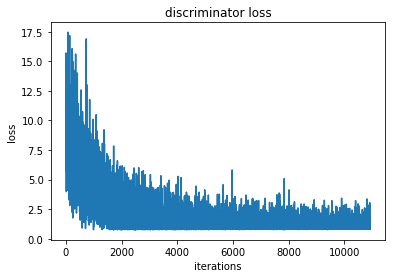

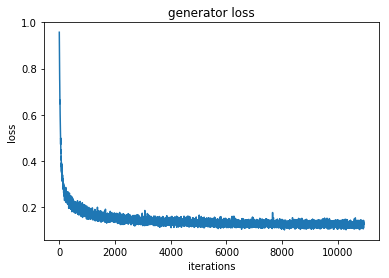

Step 10930: dloss = 0.8353, gloss = 0.1153, real_loss = 0.0000, fake_loss = 0.8353, gan_loss = 18969.5605 l1_loss = 0.0963
Step 10940: dloss = 0.8572, gloss = 0.1236, real_loss = 0.0000, fake_loss = 0.8572, gan_loss = 19018.4258 l1_loss = 0.1046
Step 10950: dloss = 0.8342, gloss = 0.1173, real_loss = 0.0000, fake_loss = 0.8342, gan_loss = 18472.7285 l1_loss = 0.0988
Step 10960: dloss = 0.8457, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8457, gan_loss = 18583.3633 l1_loss = 0.0895
Step 10970: dloss = 0.8676, gloss = 0.1101, real_loss = 0.0000, fake_loss = 0.8676, gan_loss = 19099.6797 l1_loss = 0.0910
Step 10980: dloss = 0.7932, gloss = 0.1224, real_loss = 0.0000, fake_loss = 0.7932, gan_loss = 18437.1836 l1_loss = 0.1039
Step 10990: dloss = 0.8341, gloss = 0.1204, real_loss = 0.0000, fake_loss = 0.8341, gan_loss = 18988.5176 l1_loss = 0.1014
Step 11000: dloss = 0.8352, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.8352, gan_loss = 18972.8027 l1_loss = 0.0914
Step 11010: dlos

Step 11600: dloss = 1.8990, gloss = 0.1109, real_loss = 1.0533, fake_loss = 0.8458, gan_loss = 18831.3828 l1_loss = 0.0920
Step 11610: dloss = 0.8411, gloss = 0.1165, real_loss = 0.0000, fake_loss = 0.8410, gan_loss = 18716.2188 l1_loss = 0.0978
Step 11620: dloss = 2.5183, gloss = 0.1268, real_loss = 1.6744, fake_loss = 0.8440, gan_loss = 17402.2500 l1_loss = 0.1094
Step 11630: dloss = 1.4001, gloss = 0.1254, real_loss = 0.5350, fake_loss = 0.8651, gan_loss = 18447.3691 l1_loss = 0.1069
Step 11640: dloss = 1.0025, gloss = 0.1258, real_loss = 0.2038, fake_loss = 0.7987, gan_loss = 17544.2695 l1_loss = 0.1082
Step 11650: dloss = 1.7840, gloss = 0.1115, real_loss = 0.9493, fake_loss = 0.8347, gan_loss = 18591.1641 l1_loss = 0.0929
Step 11660: dloss = 0.8118, gloss = 0.1211, real_loss = 0.0000, fake_loss = 0.8117, gan_loss = 18196.0273 l1_loss = 0.1029
Step 11670: dloss = 0.8202, gloss = 0.1423, real_loss = 0.0011, fake_loss = 0.8191, gan_loss = 18242.2773 l1_loss = 0.1241
Step 11680: dlos

Step 12270: dloss = 0.8690, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8690, gan_loss = 18558.0137 l1_loss = 0.0946
Step 12280: dloss = 0.8486, gloss = 0.1166, real_loss = 0.0000, fake_loss = 0.8486, gan_loss = 18587.9902 l1_loss = 0.0980
Step 12290: dloss = 0.8213, gloss = 0.1221, real_loss = 0.0000, fake_loss = 0.8213, gan_loss = 18218.1582 l1_loss = 0.1039
Step 12300: dloss = 1.3068, gloss = 0.1208, real_loss = 0.4878, fake_loss = 0.8190, gan_loss = 18351.2734 l1_loss = 0.1024
Step 12310: dloss = 0.8313, gloss = 0.1175, real_loss = 0.0000, fake_loss = 0.8313, gan_loss = 18832.8477 l1_loss = 0.0987
Step 12320: dloss = 0.8515, gloss = 0.1361, real_loss = 0.0000, fake_loss = 0.8515, gan_loss = 18514.5332 l1_loss = 0.1176
Step 12330: dloss = 0.8475, gloss = 0.1318, real_loss = 0.0000, fake_loss = 0.8475, gan_loss = 18165.7852 l1_loss = 0.1137
Step 12340: dloss = 0.8521, gloss = 0.1290, real_loss = 0.0000, fake_loss = 0.8521, gan_loss = 18201.6875 l1_loss = 0.1108
Step 12350: dlos

Step 12940: dloss = 0.9533, gloss = 0.1289, real_loss = 0.1285, fake_loss = 0.8248, gan_loss = 18410.0566 l1_loss = 0.1105
Step 12950: dloss = 0.8462, gloss = 0.1260, real_loss = 0.0000, fake_loss = 0.8462, gan_loss = 18406.3965 l1_loss = 0.1076
Step 12960: dloss = 0.9404, gloss = 0.1274, real_loss = 0.0996, fake_loss = 0.8408, gan_loss = 18497.1035 l1_loss = 0.1089
Step 12970: dloss = 0.8437, gloss = 0.1398, real_loss = 0.0138, fake_loss = 0.8299, gan_loss = 19121.8477 l1_loss = 0.1207
Step 12980: dloss = 1.1079, gloss = 0.1240, real_loss = 0.2642, fake_loss = 0.8437, gan_loss = 18181.8242 l1_loss = 0.1058
Step 12990: dloss = 0.8713, gloss = 0.1133, real_loss = 0.0026, fake_loss = 0.8687, gan_loss = 18832.8750 l1_loss = 0.0945
Step 13000: dloss = 0.8457, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8457, gan_loss = 18760.1367 l1_loss = 0.0905
Step 13010: dloss = 1.5621, gloss = 0.1256, real_loss = 0.7204, fake_loss = 0.8417, gan_loss = 17848.9961 l1_loss = 0.1078
Step 13020: dlos

Step 13610: dloss = 0.8353, gloss = 0.1237, real_loss = 0.0000, fake_loss = 0.8353, gan_loss = 18642.5273 l1_loss = 0.1051
Step 13620: dloss = 0.8501, gloss = 0.1124, real_loss = 0.0148, fake_loss = 0.8352, gan_loss = 18781.1836 l1_loss = 0.0936
Step 13630: dloss = 0.8501, gloss = 0.1234, real_loss = 0.0000, fake_loss = 0.8501, gan_loss = 18372.6738 l1_loss = 0.1050
Step 13640: dloss = 1.0394, gloss = 0.1110, real_loss = 0.2086, fake_loss = 0.8307, gan_loss = 17994.7812 l1_loss = 0.0930
Step 13650: dloss = 1.2616, gloss = 0.1230, real_loss = 0.4241, fake_loss = 0.8375, gan_loss = 18015.3945 l1_loss = 0.1050
Step 13660: dloss = 1.0706, gloss = 0.1324, real_loss = 0.2267, fake_loss = 0.8439, gan_loss = 18323.9375 l1_loss = 0.1141
Step 13670: dloss = 0.8212, gloss = 0.1154, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 18795.0898 l1_loss = 0.0966
Step 13680: dloss = 1.4904, gloss = 0.1112, real_loss = 0.6789, fake_loss = 0.8115, gan_loss = 17615.3281 l1_loss = 0.0936
Step 13690: dlos

Step 14280: dloss = 1.8290, gloss = 0.1161, real_loss = 0.9975, fake_loss = 0.8315, gan_loss = 18832.0566 l1_loss = 0.0973
Step 14290: dloss = 0.9634, gloss = 0.1134, real_loss = 0.1133, fake_loss = 0.8501, gan_loss = 17980.4336 l1_loss = 0.0954
Step 14300: dloss = 1.2326, gloss = 0.1186, real_loss = 0.3801, fake_loss = 0.8525, gan_loss = 18841.9258 l1_loss = 0.0997
Step 14310: dloss = 1.0835, gloss = 0.1130, real_loss = 0.2767, fake_loss = 0.8068, gan_loss = 18171.4043 l1_loss = 0.0949
Step 14320: dloss = 1.4245, gloss = 0.1212, real_loss = 0.5959, fake_loss = 0.8286, gan_loss = 18351.7148 l1_loss = 0.1028
Step 14330: dloss = 0.8665, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8665, gan_loss = 18764.8184 l1_loss = 0.0919
Step 14340: dloss = 1.1197, gloss = 0.1268, real_loss = 0.2858, fake_loss = 0.8340, gan_loss = 18504.3672 l1_loss = 0.1083
Step 14350: dloss = 0.8408, gloss = 0.1085, real_loss = 0.0001, fake_loss = 0.8408, gan_loss = 18546.9902 l1_loss = 0.0899
Step 14360: dlos

Step 14950: dloss = 0.8359, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8359, gan_loss = 18148.3066 l1_loss = 0.0916
Step 14960: dloss = 0.8565, gloss = 0.1166, real_loss = 0.0000, fake_loss = 0.8565, gan_loss = 18877.3574 l1_loss = 0.0978
Step 14970: dloss = 1.7873, gloss = 0.1135, real_loss = 0.9379, fake_loss = 0.8494, gan_loss = 18599.3828 l1_loss = 0.0949
Step 14980: dloss = 0.8192, gloss = 0.1365, real_loss = 0.0000, fake_loss = 0.8192, gan_loss = 17462.4395 l1_loss = 0.1190
Step 14990: dloss = 0.9504, gloss = 0.1240, real_loss = 0.1152, fake_loss = 0.8352, gan_loss = 17829.0352 l1_loss = 0.1062
Step 15000: dloss = 0.9063, gloss = 0.1184, real_loss = 0.0998, fake_loss = 0.8065, gan_loss = 18098.3438 l1_loss = 0.1003
Step 15010: dloss = 0.8333, gloss = 0.1214, real_loss = 0.0048, fake_loss = 0.8285, gan_loss = 18069.3145 l1_loss = 0.1033
Step 15020: dloss = 0.8159, gloss = 0.1231, real_loss = 0.0000, fake_loss = 0.8159, gan_loss = 18280.4082 l1_loss = 0.1049
Step 15030: dlos

Step 15620: dloss = 0.8920, gloss = 0.1364, real_loss = 0.0614, fake_loss = 0.8306, gan_loss = 18622.9922 l1_loss = 0.1178
Step 15630: dloss = 0.8511, gloss = 0.1135, real_loss = 0.0000, fake_loss = 0.8511, gan_loss = 19073.4082 l1_loss = 0.0944
Step 15640: dloss = 0.8554, gloss = 0.1162, real_loss = 0.0002, fake_loss = 0.8552, gan_loss = 17857.4199 l1_loss = 0.0983
Step 15650: dloss = 1.3017, gloss = 0.1192, real_loss = 0.4753, fake_loss = 0.8264, gan_loss = 18117.8867 l1_loss = 0.1011
Step 15660: dloss = 0.8479, gloss = 0.1161, real_loss = 0.0000, fake_loss = 0.8479, gan_loss = 17265.7422 l1_loss = 0.0989
Step 15670: dloss = 0.8336, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8336, gan_loss = 18755.1465 l1_loss = 0.0867
Step 15680: dloss = 0.8475, gloss = 0.1264, real_loss = 0.0000, fake_loss = 0.8475, gan_loss = 18507.8574 l1_loss = 0.1079
Step 15690: dloss = 0.8297, gloss = 0.1267, real_loss = 0.0000, fake_loss = 0.8297, gan_loss = 18151.1758 l1_loss = 0.1086
Step 15700: dlos

Step 16290: dloss = 0.8287, gloss = 0.1298, real_loss = 0.0000, fake_loss = 0.8287, gan_loss = 18508.9258 l1_loss = 0.1113
Step 16300: dloss = 0.8530, gloss = 0.1217, real_loss = 0.0000, fake_loss = 0.8530, gan_loss = 18639.1250 l1_loss = 0.1031
Step 16310: dloss = 0.8492, gloss = 0.1272, real_loss = 0.0000, fake_loss = 0.8492, gan_loss = 18456.5918 l1_loss = 0.1087
Step 16320: dloss = 1.9023, gloss = 0.1267, real_loss = 1.1187, fake_loss = 0.7836, gan_loss = 18468.2285 l1_loss = 0.1082
Step 16330: dloss = 0.8532, gloss = 0.1274, real_loss = 0.0047, fake_loss = 0.8485, gan_loss = 18299.2598 l1_loss = 0.1091
Step 16340: dloss = 0.8403, gloss = 0.1197, real_loss = 0.0000, fake_loss = 0.8403, gan_loss = 18057.3008 l1_loss = 0.1017
Step 16350: dloss = 0.8561, gloss = 0.1149, real_loss = 0.0363, fake_loss = 0.8198, gan_loss = 18505.1484 l1_loss = 0.0964
Step 16360: dloss = 0.8318, gloss = 0.1141, real_loss = 0.0000, fake_loss = 0.8318, gan_loss = 18864.9160 l1_loss = 0.0952
Step 16370: dlos

Step 16960: dloss = 0.8566, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8566, gan_loss = 18417.2480 l1_loss = 0.0869
Step 16970: dloss = 0.9842, gloss = 0.1138, real_loss = 0.1314, fake_loss = 0.8528, gan_loss = 18776.5547 l1_loss = 0.0950
Step 16980: dloss = 2.2975, gloss = 0.1335, real_loss = 1.4507, fake_loss = 0.8467, gan_loss = 18468.8281 l1_loss = 0.1151
Step 16990: dloss = 1.2611, gloss = 0.1218, real_loss = 0.4310, fake_loss = 0.8301, gan_loss = 18071.5000 l1_loss = 0.1037
Step 17000: dloss = 0.8460, gloss = 0.1298, real_loss = 0.0000, fake_loss = 0.8460, gan_loss = 18529.4688 l1_loss = 0.1113
Step 17010: dloss = 0.8612, gloss = 0.1341, real_loss = 0.0000, fake_loss = 0.8612, gan_loss = 18955.4629 l1_loss = 0.1151
Step 17020: dloss = 0.8643, gloss = 0.1242, real_loss = 0.0000, fake_loss = 0.8643, gan_loss = 17749.4492 l1_loss = 0.1065
Step 17030: dloss = 1.5120, gloss = 0.1120, real_loss = 0.6651, fake_loss = 0.8469, gan_loss = 18191.1699 l1_loss = 0.0938
Step 17040: dlos

Step 17630: dloss = 0.8640, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8640, gan_loss = 16954.7148 l1_loss = 0.0962
Step 17640: dloss = 0.8350, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 18600.6309 l1_loss = 0.0972
Step 17650: dloss = 1.1760, gloss = 0.1246, real_loss = 0.3659, fake_loss = 0.8101, gan_loss = 18116.8184 l1_loss = 0.1065
Step 17660: dloss = 1.1871, gloss = 0.1318, real_loss = 0.3465, fake_loss = 0.8406, gan_loss = 18932.0137 l1_loss = 0.1129
Step 17670: dloss = 0.8619, gloss = 0.1141, real_loss = 0.0000, fake_loss = 0.8619, gan_loss = 19066.0039 l1_loss = 0.0951
Step 17680: dloss = 0.8324, gloss = 0.1215, real_loss = 0.0000, fake_loss = 0.8324, gan_loss = 18507.2148 l1_loss = 0.1030
Step 17690: dloss = 1.7572, gloss = 0.1207, real_loss = 0.9316, fake_loss = 0.8256, gan_loss = 18408.6465 l1_loss = 0.1023
Step 17700: dloss = 0.8447, gloss = 0.1203, real_loss = 0.0000, fake_loss = 0.8447, gan_loss = 18038.1387 l1_loss = 0.1022
Step 17710: dlos

Step 18300: dloss = 0.8982, gloss = 0.1126, real_loss = 0.0747, fake_loss = 0.8235, gan_loss = 18302.8867 l1_loss = 0.0943
Step 18310: dloss = 0.8285, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8285, gan_loss = 18908.7676 l1_loss = 0.0879
Step 18320: dloss = 0.8476, gloss = 0.1198, real_loss = 0.0000, fake_loss = 0.8476, gan_loss = 18115.3281 l1_loss = 0.1017
Step 18330: dloss = 0.8221, gloss = 0.1287, real_loss = 0.0000, fake_loss = 0.8221, gan_loss = 17896.7695 l1_loss = 0.1108
Step 18340: dloss = 2.0544, gloss = 0.1284, real_loss = 1.2305, fake_loss = 0.8239, gan_loss = 18201.2734 l1_loss = 0.1102
Step 18350: dloss = 0.8255, gloss = 0.1220, real_loss = 0.0000, fake_loss = 0.8255, gan_loss = 18084.6406 l1_loss = 0.1039
Step 18360: dloss = 1.4750, gloss = 0.1107, real_loss = 0.6429, fake_loss = 0.8321, gan_loss = 18759.3125 l1_loss = 0.0919
Step 18370: dloss = 0.8490, gloss = 0.1189, real_loss = 0.0000, fake_loss = 0.8490, gan_loss = 18436.3711 l1_loss = 0.1005
Step 18380: dlos

Step 18970: dloss = 0.8313, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8313, gan_loss = 18198.0879 l1_loss = 0.0845
Step 18980: dloss = 0.8818, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8818, gan_loss = 17906.5547 l1_loss = 0.0951
Step 18990: dloss = 0.8385, gloss = 0.1262, real_loss = 0.0000, fake_loss = 0.8385, gan_loss = 18607.4746 l1_loss = 0.1076
Step 19000: dloss = 0.8350, gloss = 0.1253, real_loss = 0.0000, fake_loss = 0.8349, gan_loss = 19099.7090 l1_loss = 0.1062
Step 19010: dloss = 0.8329, gloss = 0.1212, real_loss = 0.0000, fake_loss = 0.8329, gan_loss = 18482.7246 l1_loss = 0.1027
Step 19020: dloss = 0.8995, gloss = 0.1128, real_loss = 0.0830, fake_loss = 0.8165, gan_loss = 18491.7383 l1_loss = 0.0943
Step 19030: dloss = 0.8936, gloss = 0.1148, real_loss = 0.0571, fake_loss = 0.8365, gan_loss = 18252.1172 l1_loss = 0.0965
Step 19040: dloss = 0.8191, gloss = 0.1237, real_loss = 0.0000, fake_loss = 0.8191, gan_loss = 18559.1504 l1_loss = 0.1051
Step 19050: dlos

Step 19640: dloss = 0.8328, gloss = 0.1128, real_loss = 0.0032, fake_loss = 0.8296, gan_loss = 18547.6543 l1_loss = 0.0942
Step 19650: dloss = 0.8523, gloss = 0.1120, real_loss = 0.0000, fake_loss = 0.8523, gan_loss = 18308.0762 l1_loss = 0.0936
Step 19660: dloss = 0.8724, gloss = 0.1206, real_loss = 0.0000, fake_loss = 0.8724, gan_loss = 18042.6992 l1_loss = 0.1026
Step 19670: dloss = 0.8596, gloss = 0.1228, real_loss = 0.0000, fake_loss = 0.8596, gan_loss = 18215.7012 l1_loss = 0.1046
Step 19680: dloss = 0.8950, gloss = 0.1187, real_loss = 0.0696, fake_loss = 0.8254, gan_loss = 18038.0078 l1_loss = 0.1007
Step 19690: dloss = 0.8668, gloss = 0.1101, real_loss = 0.0000, fake_loss = 0.8668, gan_loss = 17414.0898 l1_loss = 0.0927
Step 19700: dloss = 1.1920, gloss = 0.1236, real_loss = 0.3595, fake_loss = 0.8325, gan_loss = 17991.6094 l1_loss = 0.1056
Step 19710: dloss = 0.8447, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8447, gan_loss = 18180.0098 l1_loss = 0.0800
Step 19720: dlos

Step 20310: dloss = 2.3402, gloss = 0.1149, real_loss = 1.4808, fake_loss = 0.8594, gan_loss = 18195.0488 l1_loss = 0.0967
Step 20320: dloss = 0.8396, gloss = 0.1241, real_loss = 0.0000, fake_loss = 0.8396, gan_loss = 18409.2988 l1_loss = 0.1057
Step 20330: dloss = 0.8635, gloss = 0.1259, real_loss = 0.0000, fake_loss = 0.8635, gan_loss = 18411.5684 l1_loss = 0.1075
Step 20340: dloss = 0.8196, gloss = 0.1190, real_loss = 0.0000, fake_loss = 0.8196, gan_loss = 18612.7031 l1_loss = 0.1004
Step 20350: dloss = 0.9716, gloss = 0.1323, real_loss = 0.0983, fake_loss = 0.8733, gan_loss = 18121.0371 l1_loss = 0.1142
Step 20360: dloss = 1.2804, gloss = 0.1140, real_loss = 0.4059, fake_loss = 0.8745, gan_loss = 18420.3242 l1_loss = 0.0956
Step 20370: dloss = 2.2563, gloss = 0.1261, real_loss = 1.4303, fake_loss = 0.8259, gan_loss = 16841.3887 l1_loss = 0.1092
Step 20380: dloss = 0.8682, gloss = 0.1148, real_loss = 0.0045, fake_loss = 0.8638, gan_loss = 18634.5352 l1_loss = 0.0962
Step 20390: dlos

Step 20980: dloss = 0.8507, gloss = 0.1164, real_loss = 0.0018, fake_loss = 0.8489, gan_loss = 18175.5332 l1_loss = 0.0982
Step 20990: dloss = 0.8392, gloss = 0.1155, real_loss = 0.0000, fake_loss = 0.8392, gan_loss = 18529.6348 l1_loss = 0.0970
Step 21000: dloss = 1.9664, gloss = 0.1138, real_loss = 1.1303, fake_loss = 0.8361, gan_loss = 18278.6660 l1_loss = 0.0955
Step 21010: dloss = 0.8485, gloss = 0.1246, real_loss = 0.0000, fake_loss = 0.8485, gan_loss = 18461.1602 l1_loss = 0.1061
Step 21020: dloss = 0.8416, gloss = 0.1122, real_loss = 0.0145, fake_loss = 0.8270, gan_loss = 18762.4824 l1_loss = 0.0935
Step 21030: dloss = 1.5055, gloss = 0.1101, real_loss = 0.6775, fake_loss = 0.8280, gan_loss = 18259.9707 l1_loss = 0.0918
Step 21040: dloss = 0.8671, gloss = 0.1188, real_loss = 0.0000, fake_loss = 0.8671, gan_loss = 18456.7227 l1_loss = 0.1004
Step 21050: dloss = 0.8445, gloss = 0.1174, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 17615.6934 l1_loss = 0.0997
Step 21060: dlos

Step 21650: dloss = 0.8620, gloss = 0.1154, real_loss = 0.0000, fake_loss = 0.8620, gan_loss = 19234.0156 l1_loss = 0.0962
Step 21660: dloss = 0.8531, gloss = 0.1220, real_loss = 0.0000, fake_loss = 0.8531, gan_loss = 18192.0957 l1_loss = 0.1038
Step 21670: dloss = 0.9132, gloss = 0.1101, real_loss = 0.0656, fake_loss = 0.8475, gan_loss = 18155.0820 l1_loss = 0.0920
Step 21680: dloss = 1.1836, gloss = 0.1322, real_loss = 0.3361, fake_loss = 0.8476, gan_loss = 18336.7520 l1_loss = 0.1139
Step 21690: dloss = 0.8269, gloss = 0.1305, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 17816.2637 l1_loss = 0.1127
Step 21700: dloss = 0.9091, gloss = 0.1181, real_loss = 0.0564, fake_loss = 0.8528, gan_loss = 17776.5605 l1_loss = 0.1003
Step 21710: dloss = 0.8385, gloss = 0.1224, real_loss = 0.0000, fake_loss = 0.8385, gan_loss = 18604.5898 l1_loss = 0.1038
Step 21720: dloss = 1.6263, gloss = 0.1107, real_loss = 0.7434, fake_loss = 0.8829, gan_loss = 18352.5234 l1_loss = 0.0924
Step 21730: dlos

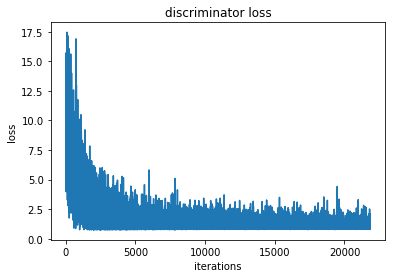

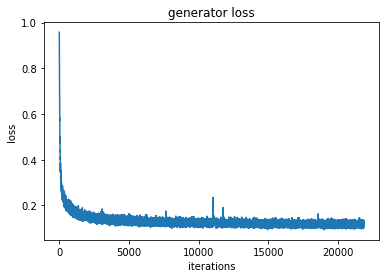

Step 21850: dloss = 0.8362, gloss = 0.1180, real_loss = 0.0064, fake_loss = 0.8298, gan_loss = 17725.8203 l1_loss = 0.1002
Step 21860: dloss = 0.8432, gloss = 0.1150, real_loss = 0.0000, fake_loss = 0.8432, gan_loss = 18717.6230 l1_loss = 0.0963
Step 21870: dloss = 0.8580, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.8580, gan_loss = 18514.8652 l1_loss = 0.0948
Step 21880: dloss = 0.8682, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8682, gan_loss = 17915.8809 l1_loss = 0.0927
Step 21890: dloss = 0.8347, gloss = 0.1160, real_loss = 0.0000, fake_loss = 0.8347, gan_loss = 18770.3633 l1_loss = 0.0972
Step 21900: dloss = 0.8574, gloss = 0.1132, real_loss = 0.0056, fake_loss = 0.8518, gan_loss = 18741.8125 l1_loss = 0.0945
Step 21910: dloss = 0.8249, gloss = 0.1079, real_loss = 0.0000, fake_loss = 0.8249, gan_loss = 19033.1875 l1_loss = 0.0888
Step 21920: dloss = 1.3009, gloss = 0.1140, real_loss = 0.4411, fake_loss = 0.8598, gan_loss = 18055.0391 l1_loss = 0.0959
Step 21930: dlos

Step 22520: dloss = 1.3416, gloss = 0.1214, real_loss = 0.4943, fake_loss = 0.8473, gan_loss = 18622.0098 l1_loss = 0.1028
Step 22530: dloss = 1.5597, gloss = 0.1083, real_loss = 0.7174, fake_loss = 0.8423, gan_loss = 18066.9824 l1_loss = 0.0902
Step 22540: dloss = 0.8608, gloss = 0.1202, real_loss = 0.0000, fake_loss = 0.8608, gan_loss = 18147.0156 l1_loss = 0.1020
Step 22550: dloss = 1.6019, gloss = 0.0967, real_loss = 0.7534, fake_loss = 0.8485, gan_loss = 18222.3770 l1_loss = 0.0785
Step 22560: dloss = 0.8720, gloss = 0.1196, real_loss = 0.0000, fake_loss = 0.8720, gan_loss = 18041.7285 l1_loss = 0.1015
Step 22570: dloss = 0.8142, gloss = 0.1182, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 18159.4707 l1_loss = 0.1000
Step 22580: dloss = 0.8539, gloss = 0.1124, real_loss = 0.0000, fake_loss = 0.8539, gan_loss = 17954.3516 l1_loss = 0.0944
Step 22590: dloss = 0.8607, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8607, gan_loss = 17843.5723 l1_loss = 0.0936
Step 22600: dlos

Step 23190: dloss = 0.8305, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8305, gan_loss = 18324.6992 l1_loss = 0.0931
Step 23200: dloss = 0.8540, gloss = 0.1077, real_loss = 0.0000, fake_loss = 0.8540, gan_loss = 18337.4785 l1_loss = 0.0894
Step 23210: dloss = 0.8779, gloss = 0.1101, real_loss = 0.0159, fake_loss = 0.8621, gan_loss = 18614.5938 l1_loss = 0.0915
Step 23220: dloss = 0.8508, gloss = 0.1071, real_loss = 0.0000, fake_loss = 0.8508, gan_loss = 18365.4102 l1_loss = 0.0887
Step 23230: dloss = 0.8476, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8476, gan_loss = 18435.4766 l1_loss = 0.0849
Step 23240: dloss = 0.8477, gloss = 0.1113, real_loss = 0.0000, fake_loss = 0.8477, gan_loss = 18659.0137 l1_loss = 0.0927
Step 23250: dloss = 0.8459, gloss = 0.1144, real_loss = 0.0000, fake_loss = 0.8459, gan_loss = 18211.3281 l1_loss = 0.0962
Step 23260: dloss = 0.8599, gloss = 0.1028, real_loss = 0.0014, fake_loss = 0.8585, gan_loss = 18541.4102 l1_loss = 0.0842
Step 23270: dlos

Step 23860: dloss = 0.8375, gloss = 0.1277, real_loss = 0.0000, fake_loss = 0.8375, gan_loss = 17504.7305 l1_loss = 0.1102
Step 23870: dloss = 0.8504, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8504, gan_loss = 18434.9258 l1_loss = 0.0880
Step 23880: dloss = 0.8390, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 18011.4023 l1_loss = 0.0919
Step 23890: dloss = 0.8505, gloss = 0.1277, real_loss = 0.0000, fake_loss = 0.8505, gan_loss = 18451.4414 l1_loss = 0.1093
Step 23900: dloss = 0.8414, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8414, gan_loss = 18544.2695 l1_loss = 0.0972
Step 23910: dloss = 0.8373, gloss = 0.1213, real_loss = 0.0000, fake_loss = 0.8373, gan_loss = 18043.9844 l1_loss = 0.1032
Step 23920: dloss = 0.8446, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.8446, gan_loss = 19020.4785 l1_loss = 0.0913
Step 23930: dloss = 1.5282, gloss = 0.1122, real_loss = 0.6925, fake_loss = 0.8356, gan_loss = 17770.8945 l1_loss = 0.0945
Step 23940: dlos

Step 24530: dloss = 1.0132, gloss = 0.1099, real_loss = 0.1587, fake_loss = 0.8544, gan_loss = 18245.8184 l1_loss = 0.0917
Step 24540: dloss = 0.8514, gloss = 0.1133, real_loss = 0.0015, fake_loss = 0.8498, gan_loss = 17174.0859 l1_loss = 0.0962
Step 24550: dloss = 0.8406, gloss = 0.1204, real_loss = 0.0000, fake_loss = 0.8406, gan_loss = 18249.9336 l1_loss = 0.1022
Step 24560: dloss = 1.2591, gloss = 0.1237, real_loss = 0.4353, fake_loss = 0.8239, gan_loss = 17908.7012 l1_loss = 0.1058
Step 24570: dloss = 1.1635, gloss = 0.1134, real_loss = 0.3170, fake_loss = 0.8465, gan_loss = 18335.1074 l1_loss = 0.0951
Step 24580: dloss = 0.8405, gloss = 0.1093, real_loss = 0.0012, fake_loss = 0.8392, gan_loss = 18192.7832 l1_loss = 0.0911
Step 24590: dloss = 0.8736, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8736, gan_loss = 17744.6523 l1_loss = 0.0860
Step 24600: dloss = 0.8438, gloss = 0.1220, real_loss = 0.0000, fake_loss = 0.8438, gan_loss = 17929.9844 l1_loss = 0.1041
Step 24610: dlos

Step 25200: dloss = 0.8180, gloss = 0.1087, real_loss = 0.0007, fake_loss = 0.8172, gan_loss = 18662.1250 l1_loss = 0.0900
Step 25210: dloss = 1.1750, gloss = 0.1182, real_loss = 0.3129, fake_loss = 0.8621, gan_loss = 18293.9590 l1_loss = 0.0999
Step 25220: dloss = 1.0747, gloss = 0.1182, real_loss = 0.2129, fake_loss = 0.8619, gan_loss = 18409.9414 l1_loss = 0.0998
Step 25230: dloss = 1.1862, gloss = 0.1141, real_loss = 0.3636, fake_loss = 0.8226, gan_loss = 18213.9844 l1_loss = 0.0959
Step 25240: dloss = 0.8521, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8520, gan_loss = 18151.2363 l1_loss = 0.0928
Step 25250: dloss = 0.8282, gloss = 0.1249, real_loss = 0.0000, fake_loss = 0.8282, gan_loss = 17229.4766 l1_loss = 0.1076
Step 25260: dloss = 0.8635, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8635, gan_loss = 18763.6172 l1_loss = 0.0924
Step 25270: dloss = 1.0886, gloss = 0.1136, real_loss = 0.2551, fake_loss = 0.8335, gan_loss = 18638.7637 l1_loss = 0.0949
Step 25280: dlos

Step 25870: dloss = 0.9929, gloss = 0.1113, real_loss = 0.1597, fake_loss = 0.8332, gan_loss = 18298.3320 l1_loss = 0.0930
Step 25880: dloss = 0.8390, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 18240.7637 l1_loss = 0.0926
Step 25890: dloss = 0.8409, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8409, gan_loss = 18551.0645 l1_loss = 0.0910
Step 25900: dloss = 0.8527, gloss = 0.1225, real_loss = 0.0000, fake_loss = 0.8527, gan_loss = 18270.5781 l1_loss = 0.1042
Step 25910: dloss = 1.3103, gloss = 0.1216, real_loss = 0.4800, fake_loss = 0.8303, gan_loss = 18873.2715 l1_loss = 0.1028
Step 25920: dloss = 0.8410, gloss = 0.1210, real_loss = 0.0000, fake_loss = 0.8410, gan_loss = 17329.4844 l1_loss = 0.1037
Step 25930: dloss = 0.8805, gloss = 0.1155, real_loss = 0.0329, fake_loss = 0.8476, gan_loss = 18405.3145 l1_loss = 0.0971
Step 25940: dloss = 0.8889, gloss = 0.1233, real_loss = 0.0231, fake_loss = 0.8659, gan_loss = 18405.4082 l1_loss = 0.1049
Step 25950: dlos

Step 26540: dloss = 0.8406, gloss = 0.1068, real_loss = 0.0006, fake_loss = 0.8400, gan_loss = 17863.8125 l1_loss = 0.0889
Step 26550: dloss = 0.8601, gloss = 0.1090, real_loss = 0.0000, fake_loss = 0.8601, gan_loss = 18823.5684 l1_loss = 0.0902
Step 26560: dloss = 0.8324, gloss = 0.1129, real_loss = 0.0000, fake_loss = 0.8324, gan_loss = 18081.0527 l1_loss = 0.0948
Step 26570: dloss = 0.8402, gloss = 0.1193, real_loss = 0.0038, fake_loss = 0.8364, gan_loss = 17923.9453 l1_loss = 0.1014
Step 26580: dloss = 0.8519, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8519, gan_loss = 17686.7617 l1_loss = 0.0911
Step 26590: dloss = 0.8318, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.8318, gan_loss = 18306.4863 l1_loss = 0.0959
Step 26600: dloss = 0.8558, gloss = 0.1117, real_loss = 0.0141, fake_loss = 0.8416, gan_loss = 18562.2402 l1_loss = 0.0932
Step 26610: dloss = 0.8304, gloss = 0.1074, real_loss = 0.0008, fake_loss = 0.8296, gan_loss = 17954.9512 l1_loss = 0.0895
Step 26620: dlos

Step 27210: dloss = 0.8350, gloss = 0.1225, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 17794.6484 l1_loss = 0.1047
Step 27220: dloss = 0.8614, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.8614, gan_loss = 18099.6367 l1_loss = 0.0859
Step 27230: dloss = 0.8340, gloss = 0.1181, real_loss = 0.0049, fake_loss = 0.8291, gan_loss = 18243.1855 l1_loss = 0.0998
Step 27240: dloss = 0.8290, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8290, gan_loss = 18190.2812 l1_loss = 0.0933
Step 27250: dloss = 0.8423, gloss = 0.1318, real_loss = 0.0000, fake_loss = 0.8423, gan_loss = 18142.7949 l1_loss = 0.1137
Step 27260: dloss = 0.8681, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8681, gan_loss = 18063.3945 l1_loss = 0.0925
Step 27270: dloss = 0.8444, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8444, gan_loss = 18452.2871 l1_loss = 0.0883
Step 27280: dloss = 0.8906, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8906, gan_loss = 18051.6738 l1_loss = 0.0802
Step 27290: dlos

Step 27880: dloss = 1.1819, gloss = 0.1090, real_loss = 0.3265, fake_loss = 0.8554, gan_loss = 17242.1660 l1_loss = 0.0917
Step 27890: dloss = 1.1157, gloss = 0.1212, real_loss = 0.2804, fake_loss = 0.8353, gan_loss = 18532.3984 l1_loss = 0.1027
Step 27900: dloss = 0.8461, gloss = 0.1002, real_loss = 0.0004, fake_loss = 0.8457, gan_loss = 17936.0938 l1_loss = 0.0823
Step 27910: dloss = 0.8603, gloss = 0.1176, real_loss = 0.0037, fake_loss = 0.8566, gan_loss = 18293.9141 l1_loss = 0.0993
Step 27920: dloss = 0.8492, gloss = 0.0974, real_loss = 0.0046, fake_loss = 0.8446, gan_loss = 17925.7461 l1_loss = 0.0795
Step 27930: dloss = 1.0911, gloss = 0.1044, real_loss = 0.2375, fake_loss = 0.8537, gan_loss = 18663.3633 l1_loss = 0.0857
Step 27940: dloss = 0.8401, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.8401, gan_loss = 18370.0977 l1_loss = 0.0848
Step 27950: dloss = 0.8653, gloss = 0.1197, real_loss = 0.0000, fake_loss = 0.8653, gan_loss = 18246.2891 l1_loss = 0.1015
Step 27960: dlos

Step 28550: dloss = 0.7960, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.7960, gan_loss = 18220.7363 l1_loss = 0.0869
Step 28560: dloss = 0.8454, gloss = 0.1169, real_loss = 0.0000, fake_loss = 0.8454, gan_loss = 18092.5801 l1_loss = 0.0988
Step 28570: dloss = 0.8784, gloss = 0.1166, real_loss = 0.0001, fake_loss = 0.8784, gan_loss = 17428.8008 l1_loss = 0.0991
Step 28580: dloss = 1.2372, gloss = 0.1069, real_loss = 0.4160, fake_loss = 0.8213, gan_loss = 17116.2188 l1_loss = 0.0898
Step 28590: dloss = 0.8364, gloss = 0.1244, real_loss = 0.0000, fake_loss = 0.8364, gan_loss = 18525.2109 l1_loss = 0.1058
Step 28600: dloss = 0.9155, gloss = 0.1231, real_loss = 0.0497, fake_loss = 0.8658, gan_loss = 18019.0469 l1_loss = 0.1051
Step 28610: dloss = 1.1165, gloss = 0.1196, real_loss = 0.2991, fake_loss = 0.8174, gan_loss = 18217.9531 l1_loss = 0.1014
Step 28620: dloss = 0.8461, gloss = 0.1115, real_loss = 0.0002, fake_loss = 0.8460, gan_loss = 18260.9863 l1_loss = 0.0933
Step 28630: dlos

Step 29220: dloss = 0.8793, gloss = 0.0983, real_loss = 0.0046, fake_loss = 0.8747, gan_loss = 18304.1152 l1_loss = 0.0800
Step 29230: dloss = 0.8609, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8609, gan_loss = 18308.7578 l1_loss = 0.0863
Step 29240: dloss = 0.8285, gloss = 0.1012, real_loss = 0.0041, fake_loss = 0.8243, gan_loss = 17637.4609 l1_loss = 0.0836
Step 29250: dloss = 1.5199, gloss = 0.1074, real_loss = 0.6674, fake_loss = 0.8525, gan_loss = 17985.8047 l1_loss = 0.0895
Step 29260: dloss = 0.8469, gloss = 0.1190, real_loss = 0.0000, fake_loss = 0.8469, gan_loss = 17471.6582 l1_loss = 0.1016
Step 29270: dloss = 0.8552, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8552, gan_loss = 18296.8203 l1_loss = 0.0883
Step 29280: dloss = 0.8189, gloss = 0.1159, real_loss = 0.0000, fake_loss = 0.8189, gan_loss = 18414.0137 l1_loss = 0.0975
Step 29290: dloss = 0.8527, gloss = 0.1095, real_loss = 0.0001, fake_loss = 0.8526, gan_loss = 18550.7090 l1_loss = 0.0909
Step 29300: dlos

Step 29890: dloss = 0.8348, gloss = 0.1207, real_loss = 0.0000, fake_loss = 0.8348, gan_loss = 18437.2129 l1_loss = 0.1022
Step 29900: dloss = 0.8341, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8341, gan_loss = 18239.0176 l1_loss = 0.0822
Step 29910: dloss = 0.8614, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8614, gan_loss = 18721.7305 l1_loss = 0.0971
Step 29920: dloss = 1.3785, gloss = 0.1057, real_loss = 0.5538, fake_loss = 0.8247, gan_loss = 18603.8203 l1_loss = 0.0871
Step 29930: dloss = 0.9193, gloss = 0.1227, real_loss = 0.0741, fake_loss = 0.8452, gan_loss = 18365.0664 l1_loss = 0.1043
Step 29940: dloss = 0.8376, gloss = 0.1268, real_loss = 0.0000, fake_loss = 0.8376, gan_loss = 18505.9648 l1_loss = 0.1083
Step 29950: dloss = 0.8178, gloss = 0.1156, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 18361.7266 l1_loss = 0.0972
Step 29960: dloss = 0.8459, gloss = 0.1219, real_loss = 0.0000, fake_loss = 0.8459, gan_loss = 18117.7051 l1_loss = 0.1038
Step 29970: dlos

Step 30560: dloss = 0.8503, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8503, gan_loss = 17918.8633 l1_loss = 0.0870
Step 30570: dloss = 1.6125, gloss = 0.1111, real_loss = 0.7747, fake_loss = 0.8378, gan_loss = 17530.9883 l1_loss = 0.0935
Step 30580: dloss = 0.8498, gloss = 0.1195, real_loss = 0.0000, fake_loss = 0.8498, gan_loss = 18096.4707 l1_loss = 0.1014
Step 30590: dloss = 0.8080, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8080, gan_loss = 18362.9219 l1_loss = 0.0916
Step 30600: dloss = 0.8223, gloss = 0.1224, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 18281.8223 l1_loss = 0.1041
Step 30610: dloss = 0.8600, gloss = 0.1238, real_loss = 0.0000, fake_loss = 0.8600, gan_loss = 17878.3906 l1_loss = 0.1059
Step 30620: dloss = 0.8272, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.8272, gan_loss = 18482.1465 l1_loss = 0.0958
Step 30630: dloss = 0.8486, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8486, gan_loss = 18216.4141 l1_loss = 0.0815
Step 30640: dlos

Step 31230: dloss = 2.5205, gloss = 0.1187, real_loss = 1.6768, fake_loss = 0.8437, gan_loss = 18394.9785 l1_loss = 0.1003
Step 31240: dloss = 0.8223, gloss = 0.1135, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 18414.1250 l1_loss = 0.0951
Step 31250: dloss = 1.2152, gloss = 0.1160, real_loss = 0.3592, fake_loss = 0.8560, gan_loss = 17727.9434 l1_loss = 0.0983
Step 31260: dloss = 1.3626, gloss = 0.1175, real_loss = 0.5558, fake_loss = 0.8068, gan_loss = 18036.9746 l1_loss = 0.0995
Step 31270: dloss = 0.8437, gloss = 0.1259, real_loss = 0.0000, fake_loss = 0.8437, gan_loss = 18865.2676 l1_loss = 0.1070
Step 31280: dloss = 0.8473, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8473, gan_loss = 18453.6934 l1_loss = 0.0890
Step 31290: dloss = 0.8441, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8441, gan_loss = 17142.9531 l1_loss = 0.0902
Step 31300: dloss = 0.8457, gloss = 0.1106, real_loss = 0.0004, fake_loss = 0.8452, gan_loss = 17906.7715 l1_loss = 0.0927
Step 31310: dlos

Step 31900: dloss = 1.1226, gloss = 0.1107, real_loss = 0.2579, fake_loss = 0.8647, gan_loss = 17849.9219 l1_loss = 0.0928
Step 31910: dloss = 0.8507, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8507, gan_loss = 17404.2344 l1_loss = 0.0855
Step 31920: dloss = 0.8592, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.8592, gan_loss = 18580.7031 l1_loss = 0.0922
Step 31930: dloss = 0.8611, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.8611, gan_loss = 18199.8242 l1_loss = 0.0945
Step 31940: dloss = 0.8312, gloss = 0.1290, real_loss = 0.0000, fake_loss = 0.8312, gan_loss = 17204.0215 l1_loss = 0.1117
Step 31950: dloss = 1.0134, gloss = 0.1241, real_loss = 0.1758, fake_loss = 0.8375, gan_loss = 17967.9004 l1_loss = 0.1062
Step 31960: dloss = 0.8168, gloss = 0.1250, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 18165.6367 l1_loss = 0.1068
Step 31970: dloss = 0.8233, gloss = 0.1145, real_loss = 0.0000, fake_loss = 0.8233, gan_loss = 18081.1543 l1_loss = 0.0964
Step 31980: dlos

Step 32570: dloss = 0.8104, gloss = 0.1229, real_loss = 0.0000, fake_loss = 0.8104, gan_loss = 17812.0078 l1_loss = 0.1051
Step 32580: dloss = 1.4159, gloss = 0.1178, real_loss = 0.5754, fake_loss = 0.8405, gan_loss = 17529.9141 l1_loss = 0.1003
Step 32590: dloss = 0.8725, gloss = 0.1147, real_loss = 0.0000, fake_loss = 0.8725, gan_loss = 17363.5723 l1_loss = 0.0973
Step 32600: dloss = 0.8311, gloss = 0.1329, real_loss = 0.0000, fake_loss = 0.8311, gan_loss = 17581.6562 l1_loss = 0.1154
Step 32610: dloss = 0.8283, gloss = 0.1193, real_loss = 0.0001, fake_loss = 0.8283, gan_loss = 18410.0410 l1_loss = 0.1009
Step 32620: dloss = 0.8345, gloss = 0.1124, real_loss = 0.0002, fake_loss = 0.8343, gan_loss = 18034.1602 l1_loss = 0.0944
Step 32630: dloss = 0.8604, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8604, gan_loss = 18423.7617 l1_loss = 0.0859
Step 32640: dloss = 0.8452, gloss = 0.1147, real_loss = 0.0000, fake_loss = 0.8452, gan_loss = 17488.0645 l1_loss = 0.0972
Step 32650: dlos

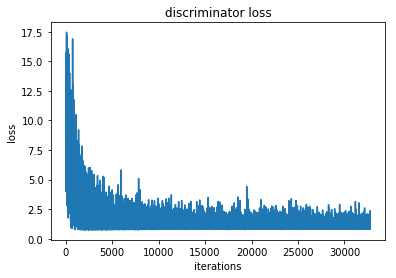

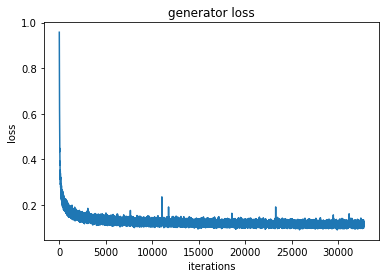

Step 32770: dloss = 0.8410, gloss = 0.1136, real_loss = 0.0000, fake_loss = 0.8410, gan_loss = 17823.4668 l1_loss = 0.0957
Step 32780: dloss = 0.8469, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8469, gan_loss = 18501.2461 l1_loss = 0.0877
Step 32790: dloss = 0.8131, gloss = 0.1194, real_loss = 0.0000, fake_loss = 0.8131, gan_loss = 18129.5039 l1_loss = 0.1013
Step 32800: dloss = 1.1121, gloss = 0.1115, real_loss = 0.2571, fake_loss = 0.8551, gan_loss = 18001.5742 l1_loss = 0.0935
Step 32810: dloss = 1.0624, gloss = 0.1191, real_loss = 0.2367, fake_loss = 0.8257, gan_loss = 18181.8691 l1_loss = 0.1009
Step 32820: dloss = 0.8299, gloss = 0.1159, real_loss = 0.0000, fake_loss = 0.8299, gan_loss = 18228.3809 l1_loss = 0.0976
Step 32830: dloss = 0.8555, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8555, gan_loss = 18207.5723 l1_loss = 0.0896
Step 32840: dloss = 0.8540, gloss = 0.1249, real_loss = 0.0000, fake_loss = 0.8540, gan_loss = 18013.6328 l1_loss = 0.1069
Step 32850: dlos

Step 33440: dloss = 0.8313, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8313, gan_loss = 18159.1797 l1_loss = 0.0933
Step 33450: dloss = 0.8651, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.8651, gan_loss = 18318.5859 l1_loss = 0.0859
Step 33460: dloss = 0.8235, gloss = 0.1313, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 18575.2500 l1_loss = 0.1127
Step 33470: dloss = 0.8494, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8494, gan_loss = 17952.4922 l1_loss = 0.0935
Step 33480: dloss = 0.8322, gloss = 0.1165, real_loss = 0.0000, fake_loss = 0.8322, gan_loss = 18156.9512 l1_loss = 0.0984
Step 33490: dloss = 0.8557, gloss = 0.1144, real_loss = 0.0000, fake_loss = 0.8557, gan_loss = 18303.9199 l1_loss = 0.0961
Step 33500: dloss = 0.9186, gloss = 0.1215, real_loss = 0.0906, fake_loss = 0.8280, gan_loss = 17164.1875 l1_loss = 0.1043
Step 33510: dloss = 1.0926, gloss = 0.1220, real_loss = 0.2800, fake_loss = 0.8125, gan_loss = 18400.8652 l1_loss = 0.1036
Step 33520: dlos

Step 34110: dloss = 0.8524, gloss = 0.1134, real_loss = 0.0001, fake_loss = 0.8523, gan_loss = 18227.0117 l1_loss = 0.0951
Step 34120: dloss = 0.9144, gloss = 0.1279, real_loss = 0.0812, fake_loss = 0.8332, gan_loss = 17838.5508 l1_loss = 0.1100
Step 34130: dloss = 0.8362, gloss = 0.1168, real_loss = 0.0000, fake_loss = 0.8362, gan_loss = 18193.6289 l1_loss = 0.0986
Step 34140: dloss = 0.8615, gloss = 0.1174, real_loss = 0.0000, fake_loss = 0.8615, gan_loss = 18148.2891 l1_loss = 0.0993
Step 34150: dloss = 1.5182, gloss = 0.1094, real_loss = 0.6936, fake_loss = 0.8246, gan_loss = 17037.0352 l1_loss = 0.0924
Step 34160: dloss = 0.8692, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8692, gan_loss = 18197.9453 l1_loss = 0.0867
Step 34170: dloss = 0.8385, gloss = 0.1125, real_loss = 0.0000, fake_loss = 0.8385, gan_loss = 17839.3652 l1_loss = 0.0946
Step 34180: dloss = 0.8510, gloss = 0.1165, real_loss = 0.0000, fake_loss = 0.8510, gan_loss = 18309.8047 l1_loss = 0.0982
Step 34190: dlos

Step 34780: dloss = 0.8549, gloss = 0.1138, real_loss = 0.0000, fake_loss = 0.8549, gan_loss = 17851.8984 l1_loss = 0.0959
Step 34790: dloss = 0.8371, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8371, gan_loss = 18996.0371 l1_loss = 0.0900
Step 34800: dloss = 0.8325, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8325, gan_loss = 18616.2227 l1_loss = 0.0859
Step 34810: dloss = 0.8548, gloss = 0.1138, real_loss = 0.0000, fake_loss = 0.8548, gan_loss = 17745.1230 l1_loss = 0.0961
Step 34820: dloss = 0.8472, gloss = 0.1253, real_loss = 0.0000, fake_loss = 0.8472, gan_loss = 17873.6387 l1_loss = 0.1074
Step 34830: dloss = 0.8835, gloss = 0.1079, real_loss = 0.0567, fake_loss = 0.8269, gan_loss = 17609.2695 l1_loss = 0.0903
Step 34840: dloss = 0.8890, gloss = 0.1030, real_loss = 0.0451, fake_loss = 0.8439, gan_loss = 18419.5195 l1_loss = 0.0846
Step 34850: dloss = 0.8505, gloss = 0.1071, real_loss = 0.0000, fake_loss = 0.8505, gan_loss = 17377.6621 l1_loss = 0.0897
Step 34860: dlos

Step 35450: dloss = 0.8424, gloss = 0.1124, real_loss = 0.0000, fake_loss = 0.8424, gan_loss = 18338.0371 l1_loss = 0.0940
Step 35460: dloss = 0.8611, gloss = 0.1101, real_loss = 0.0000, fake_loss = 0.8611, gan_loss = 17327.3008 l1_loss = 0.0928
Step 35470: dloss = 1.7609, gloss = 0.1252, real_loss = 0.9179, fake_loss = 0.8431, gan_loss = 18092.6602 l1_loss = 0.1071
Step 35480: dloss = 0.8336, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8336, gan_loss = 17804.3145 l1_loss = 0.0933
Step 35490: dloss = 0.8255, gloss = 0.1216, real_loss = 0.0000, fake_loss = 0.8255, gan_loss = 17659.5938 l1_loss = 0.1040
Step 35500: dloss = 0.8622, gloss = 0.1212, real_loss = 0.0000, fake_loss = 0.8622, gan_loss = 18117.4980 l1_loss = 0.1031
Step 35510: dloss = 0.8777, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8777, gan_loss = 18041.9023 l1_loss = 0.0912
Step 35520: dloss = 0.9435, gloss = 0.1087, real_loss = 0.0892, fake_loss = 0.8543, gan_loss = 18350.1094 l1_loss = 0.0904
Step 35530: dlos

Step 36120: dloss = 0.8490, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8490, gan_loss = 18201.2188 l1_loss = 0.0882
Step 36130: dloss = 0.8157, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.8157, gan_loss = 18164.7383 l1_loss = 0.0952
Step 36140: dloss = 1.3633, gloss = 0.1149, real_loss = 0.4859, fake_loss = 0.8773, gan_loss = 17962.8145 l1_loss = 0.0969
Step 36150: dloss = 0.8889, gloss = 0.1193, real_loss = 0.0540, fake_loss = 0.8348, gan_loss = 17830.4160 l1_loss = 0.1015
Step 36160: dloss = 0.8463, gloss = 0.1110, real_loss = 0.0339, fake_loss = 0.8124, gan_loss = 18247.2578 l1_loss = 0.0927
Step 36170: dloss = 0.8278, gloss = 0.1232, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 18563.3516 l1_loss = 0.1046
Step 36180: dloss = 0.8510, gloss = 0.1277, real_loss = 0.0001, fake_loss = 0.8510, gan_loss = 17351.9004 l1_loss = 0.1104
Step 36190: dloss = 1.0300, gloss = 0.1164, real_loss = 0.2021, fake_loss = 0.8279, gan_loss = 17152.7715 l1_loss = 0.0992
Step 36200: dlos

Step 36790: dloss = 0.8198, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8198, gan_loss = 17693.0098 l1_loss = 0.0884
Step 36800: dloss = 0.8357, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 17993.6934 l1_loss = 0.0872
Step 36810: dloss = 0.9023, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.9023, gan_loss = 18205.4336 l1_loss = 0.0856
Step 36820: dloss = 0.8957, gloss = 0.1195, real_loss = 0.0400, fake_loss = 0.8557, gan_loss = 18124.6152 l1_loss = 0.1013
Step 36830: dloss = 0.8385, gloss = 0.1092, real_loss = 0.0000, fake_loss = 0.8385, gan_loss = 17968.3672 l1_loss = 0.0912
Step 36840: dloss = 1.0752, gloss = 0.1079, real_loss = 0.2127, fake_loss = 0.8624, gan_loss = 18440.2910 l1_loss = 0.0894
Step 36850: dloss = 0.8661, gloss = 0.0984, real_loss = 0.0000, fake_loss = 0.8661, gan_loss = 17110.7578 l1_loss = 0.0813
Step 36860: dloss = 1.3455, gloss = 0.1092, real_loss = 0.5141, fake_loss = 0.8314, gan_loss = 16537.7656 l1_loss = 0.0926
Step 36870: dlos

Step 37460: dloss = 0.8601, gloss = 0.1203, real_loss = 0.0000, fake_loss = 0.8601, gan_loss = 18286.4746 l1_loss = 0.1020
Step 37470: dloss = 0.8386, gloss = 0.1160, real_loss = 0.0000, fake_loss = 0.8386, gan_loss = 17303.1875 l1_loss = 0.0987
Step 37480: dloss = 0.9249, gloss = 0.1136, real_loss = 0.0868, fake_loss = 0.8381, gan_loss = 17757.7578 l1_loss = 0.0959
Step 37490: dloss = 0.8464, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8464, gan_loss = 18005.4551 l1_loss = 0.0996
Step 37500: dloss = 0.8475, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.8475, gan_loss = 18200.4141 l1_loss = 0.0960
Step 37510: dloss = 0.8363, gloss = 0.1147, real_loss = 0.0000, fake_loss = 0.8363, gan_loss = 17320.0527 l1_loss = 0.0973
Step 37520: dloss = 0.8315, gloss = 0.1017, real_loss = 0.0000, fake_loss = 0.8315, gan_loss = 17390.4707 l1_loss = 0.0843
Step 37530: dloss = 0.8527, gloss = 0.1165, real_loss = 0.0000, fake_loss = 0.8527, gan_loss = 18323.0703 l1_loss = 0.0982
Step 37540: dlos

Step 38130: dloss = 0.8425, gloss = 0.1122, real_loss = 0.0000, fake_loss = 0.8425, gan_loss = 18274.8945 l1_loss = 0.0940
Step 38140: dloss = 0.8661, gloss = 0.1325, real_loss = 0.0000, fake_loss = 0.8661, gan_loss = 18170.6602 l1_loss = 0.1143
Step 38150: dloss = 0.8278, gloss = 0.1206, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 18101.0137 l1_loss = 0.1025
Step 38160: dloss = 0.8055, gloss = 0.1120, real_loss = 0.0000, fake_loss = 0.8055, gan_loss = 18044.8867 l1_loss = 0.0939
Step 38170: dloss = 0.8418, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8418, gan_loss = 18129.9590 l1_loss = 0.0930
Step 38180: dloss = 0.8383, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 18077.4395 l1_loss = 0.0877
Step 38190: dloss = 1.2873, gloss = 0.1234, real_loss = 0.4375, fake_loss = 0.8498, gan_loss = 18011.1641 l1_loss = 0.1053
Step 38200: dloss = 2.1417, gloss = 0.1149, real_loss = 1.2890, fake_loss = 0.8526, gan_loss = 18397.4785 l1_loss = 0.0965
Step 38210: dlos

Step 38800: dloss = 0.8108, gloss = 0.1145, real_loss = 0.0000, fake_loss = 0.8108, gan_loss = 18378.8809 l1_loss = 0.0961
Step 38810: dloss = 0.8483, gloss = 0.1173, real_loss = 0.0000, fake_loss = 0.8483, gan_loss = 18097.8164 l1_loss = 0.0992
Step 38820: dloss = 0.8452, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8452, gan_loss = 18593.9512 l1_loss = 0.0972
Step 38830: dloss = 0.8218, gloss = 0.1174, real_loss = 0.0000, fake_loss = 0.8218, gan_loss = 17728.0508 l1_loss = 0.0996
Step 38840: dloss = 0.8454, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8454, gan_loss = 18421.9707 l1_loss = 0.0876
Step 38850: dloss = 0.8574, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8574, gan_loss = 18456.5039 l1_loss = 0.0916
Step 38860: dloss = 0.8750, gloss = 0.1140, real_loss = 0.0004, fake_loss = 0.8746, gan_loss = 17757.5488 l1_loss = 0.0962
Step 38870: dloss = 1.1070, gloss = 0.1049, real_loss = 0.2769, fake_loss = 0.8300, gan_loss = 16911.5312 l1_loss = 0.0880
Step 38880: dlos

Step 39470: dloss = 0.8516, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8516, gan_loss = 18017.3770 l1_loss = 0.0920
Step 39480: dloss = 0.8033, gloss = 0.1178, real_loss = 0.0000, fake_loss = 0.8033, gan_loss = 18689.3594 l1_loss = 0.0991
Step 39490: dloss = 1.0906, gloss = 0.1132, real_loss = 0.2663, fake_loss = 0.8243, gan_loss = 18450.7383 l1_loss = 0.0948
Step 39500: dloss = 1.4519, gloss = 0.1159, real_loss = 0.6156, fake_loss = 0.8363, gan_loss = 18210.2715 l1_loss = 0.0977
Step 39510: dloss = 0.8269, gloss = 0.1208, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 18533.9238 l1_loss = 0.1022
Step 39520: dloss = 1.5423, gloss = 0.0992, real_loss = 0.6879, fake_loss = 0.8544, gan_loss = 18370.8184 l1_loss = 0.0808
Step 39530: dloss = 0.8073, gloss = 0.1153, real_loss = 0.0000, fake_loss = 0.8073, gan_loss = 17735.6895 l1_loss = 0.0975
Step 39540: dloss = 0.8391, gloss = 0.1251, real_loss = 0.0000, fake_loss = 0.8391, gan_loss = 18113.8496 l1_loss = 0.1069
Step 39550: dlos

Step 40140: dloss = 0.8565, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.8565, gan_loss = 18383.5215 l1_loss = 0.0919
Step 40150: dloss = 0.8621, gloss = 0.1081, real_loss = 0.0004, fake_loss = 0.8618, gan_loss = 18608.8945 l1_loss = 0.0895
Step 40160: dloss = 1.4037, gloss = 0.1060, real_loss = 0.5535, fake_loss = 0.8501, gan_loss = 17606.6133 l1_loss = 0.0884
Step 40170: dloss = 0.8665, gloss = 0.1079, real_loss = 0.0000, fake_loss = 0.8665, gan_loss = 18189.8457 l1_loss = 0.0897
Step 40180: dloss = 0.8534, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8534, gan_loss = 18133.2461 l1_loss = 0.0917
Step 40190: dloss = 0.8289, gloss = 0.1242, real_loss = 0.0000, fake_loss = 0.8289, gan_loss = 18051.2969 l1_loss = 0.1062
Step 40200: dloss = 0.8546, gloss = 0.1089, real_loss = 0.0001, fake_loss = 0.8545, gan_loss = 17603.4336 l1_loss = 0.0913
Step 40210: dloss = 0.8277, gloss = 0.1140, real_loss = 0.0000, fake_loss = 0.8277, gan_loss = 18505.1309 l1_loss = 0.0955
Step 40220: dlos

Step 40810: dloss = 0.8193, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8193, gan_loss = 18213.4844 l1_loss = 0.0976
Step 40820: dloss = 0.8467, gloss = 0.1174, real_loss = 0.0000, fake_loss = 0.8467, gan_loss = 18197.9531 l1_loss = 0.0992
Step 40830: dloss = 0.8226, gloss = 0.1212, real_loss = 0.0000, fake_loss = 0.8226, gan_loss = 17726.2695 l1_loss = 0.1034
Step 40840: dloss = 1.0840, gloss = 0.1173, real_loss = 0.2123, fake_loss = 0.8718, gan_loss = 18098.0391 l1_loss = 0.0992
Step 40850: dloss = 0.8611, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8611, gan_loss = 17744.4531 l1_loss = 0.0843
Step 40860: dloss = 0.8421, gloss = 0.1035, real_loss = 0.0006, fake_loss = 0.8415, gan_loss = 17043.0781 l1_loss = 0.0865
Step 40870: dloss = 0.8486, gloss = 0.1188, real_loss = 0.0000, fake_loss = 0.8486, gan_loss = 17800.3398 l1_loss = 0.1010
Step 40880: dloss = 1.2088, gloss = 0.1078, real_loss = 0.3870, fake_loss = 0.8218, gan_loss = 17363.3906 l1_loss = 0.0905
Step 40890: dlos

Step 41480: dloss = 0.8643, gloss = 0.1032, real_loss = 0.0191, fake_loss = 0.8452, gan_loss = 17826.7207 l1_loss = 0.0854
Step 41490: dloss = 0.9328, gloss = 0.1177, real_loss = 0.0825, fake_loss = 0.8503, gan_loss = 17728.5938 l1_loss = 0.1000
Step 41500: dloss = 0.8454, gloss = 0.1107, real_loss = 0.0107, fake_loss = 0.8347, gan_loss = 18393.7969 l1_loss = 0.0923
Step 41510: dloss = 0.8642, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8642, gan_loss = 17992.7578 l1_loss = 0.0819
Step 41520: dloss = 0.8375, gloss = 0.1125, real_loss = 0.0000, fake_loss = 0.8375, gan_loss = 18310.5918 l1_loss = 0.0942
Step 41530: dloss = 0.8512, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8512, gan_loss = 17849.6445 l1_loss = 0.0868
Step 41540: dloss = 0.8610, gloss = 0.1171, real_loss = 0.0000, fake_loss = 0.8610, gan_loss = 17883.2891 l1_loss = 0.0992
Step 41550: dloss = 0.8936, gloss = 0.1041, real_loss = 0.0167, fake_loss = 0.8769, gan_loss = 17936.2578 l1_loss = 0.0862
Step 41560: dlos

Step 42150: dloss = 0.8629, gloss = 0.1237, real_loss = 0.0437, fake_loss = 0.8192, gan_loss = 18150.7480 l1_loss = 0.1056
Step 42160: dloss = 0.8712, gloss = 0.1130, real_loss = 0.0134, fake_loss = 0.8578, gan_loss = 17958.4141 l1_loss = 0.0951
Step 42170: dloss = 0.8178, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 17311.2734 l1_loss = 0.0899
Step 42180: dloss = 1.0365, gloss = 0.1259, real_loss = 0.1857, fake_loss = 0.8508, gan_loss = 18377.5059 l1_loss = 0.1075
Step 42190: dloss = 0.8493, gloss = 0.1157, real_loss = 0.0000, fake_loss = 0.8493, gan_loss = 17213.5742 l1_loss = 0.0985
Step 42200: dloss = 2.0678, gloss = 0.1177, real_loss = 1.2235, fake_loss = 0.8442, gan_loss = 17375.1738 l1_loss = 0.1003
Step 42210: dloss = 0.8613, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8613, gan_loss = 17958.8125 l1_loss = 0.0918
Step 42220: dloss = 0.8494, gloss = 0.1062, real_loss = 0.0008, fake_loss = 0.8486, gan_loss = 17977.2266 l1_loss = 0.0882
Step 42230: dlos

Step 42820: dloss = 0.8442, gloss = 0.1152, real_loss = 0.0000, fake_loss = 0.8442, gan_loss = 18079.4551 l1_loss = 0.0971
Step 42830: dloss = 0.9142, gloss = 0.1084, real_loss = 0.0802, fake_loss = 0.8339, gan_loss = 18078.3711 l1_loss = 0.0903
Step 42840: dloss = 0.9180, gloss = 0.1083, real_loss = 0.0532, fake_loss = 0.8649, gan_loss = 18609.2422 l1_loss = 0.0897
Step 42850: dloss = 0.9221, gloss = 0.1081, real_loss = 0.0578, fake_loss = 0.8643, gan_loss = 17482.2598 l1_loss = 0.0907
Step 42860: dloss = 0.8271, gloss = 0.1207, real_loss = 0.0000, fake_loss = 0.8271, gan_loss = 17755.1250 l1_loss = 0.1030
Step 42870: dloss = 0.8484, gloss = 0.1188, real_loss = 0.0000, fake_loss = 0.8484, gan_loss = 17668.7207 l1_loss = 0.1012
Step 42880: dloss = 0.8588, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8588, gan_loss = 17380.4727 l1_loss = 0.0895
Step 42890: dloss = 0.8694, gloss = 0.1135, real_loss = 0.0130, fake_loss = 0.8564, gan_loss = 17728.9395 l1_loss = 0.0958
Step 42900: dlos

Step 43490: dloss = 0.9602, gloss = 0.1002, real_loss = 0.0963, fake_loss = 0.8639, gan_loss = 17700.2246 l1_loss = 0.0825
Step 43500: dloss = 0.8307, gloss = 0.1189, real_loss = 0.0000, fake_loss = 0.8307, gan_loss = 18201.4551 l1_loss = 0.1007
Step 43510: dloss = 0.8232, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8232, gan_loss = 17984.2949 l1_loss = 0.0855
Step 43520: dloss = 0.8370, gloss = 0.1192, real_loss = 0.0000, fake_loss = 0.8370, gan_loss = 18549.3926 l1_loss = 0.1006
Step 43530: dloss = 0.8320, gloss = 0.1141, real_loss = 0.0000, fake_loss = 0.8320, gan_loss = 18430.5371 l1_loss = 0.0957
Step 43540: dloss = 0.8546, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8546, gan_loss = 17642.7969 l1_loss = 0.0882
Step 43550: dloss = 0.8350, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 17658.7637 l1_loss = 0.0954
Step 43560: dloss = 0.8594, gloss = 0.1061, real_loss = 0.0036, fake_loss = 0.8558, gan_loss = 17893.2773 l1_loss = 0.0882
Step 43570: dlos

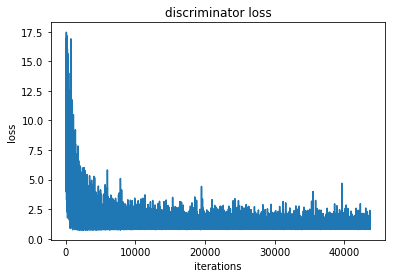

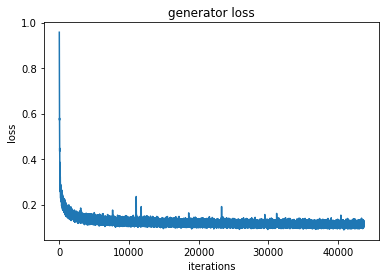

Step 43700: dloss = 0.8334, gloss = 0.1217, real_loss = 0.0002, fake_loss = 0.8332, gan_loss = 17811.3691 l1_loss = 0.1038
Step 43710: dloss = 0.8264, gloss = 0.1147, real_loss = 0.0000, fake_loss = 0.8264, gan_loss = 17977.5332 l1_loss = 0.0968
Step 43720: dloss = 0.8147, gloss = 0.1197, real_loss = 0.0000, fake_loss = 0.8147, gan_loss = 18317.6523 l1_loss = 0.1013
Step 43730: dloss = 0.8440, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8440, gan_loss = 17792.5469 l1_loss = 0.0895
Step 43740: dloss = 0.8685, gloss = 0.1084, real_loss = 0.0000, fake_loss = 0.8685, gan_loss = 18561.2324 l1_loss = 0.0899
Step 43750: dloss = 0.8412, gloss = 0.1161, real_loss = 0.0000, fake_loss = 0.8412, gan_loss = 18071.2207 l1_loss = 0.0980
Step 43760: dloss = 0.8678, gloss = 0.1076, real_loss = 0.0001, fake_loss = 0.8677, gan_loss = 18054.2930 l1_loss = 0.0895
Step 43770: dloss = 0.8860, gloss = 0.1144, real_loss = 0.0000, fake_loss = 0.8860, gan_loss = 18079.1836 l1_loss = 0.0963
Step 43780: dlos

Step 44370: dloss = 0.8773, gloss = 0.1113, real_loss = 0.0000, fake_loss = 0.8773, gan_loss = 18439.5039 l1_loss = 0.0928
Step 44380: dloss = 0.8668, gloss = 0.1117, real_loss = 0.0000, fake_loss = 0.8668, gan_loss = 18131.6484 l1_loss = 0.0936
Step 44390: dloss = 0.8445, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 18186.1523 l1_loss = 0.0800
Step 44400: dloss = 0.8603, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.8603, gan_loss = 18500.8086 l1_loss = 0.0891
Step 44410: dloss = 0.8653, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8652, gan_loss = 17097.1602 l1_loss = 0.0915
Step 44420: dloss = 0.8484, gloss = 0.1119, real_loss = 0.0000, fake_loss = 0.8484, gan_loss = 18223.4980 l1_loss = 0.0937
Step 44430: dloss = 0.8407, gloss = 0.1253, real_loss = 0.0000, fake_loss = 0.8407, gan_loss = 17532.5176 l1_loss = 0.1078
Step 44440: dloss = 0.8406, gloss = 0.1296, real_loss = 0.0000, fake_loss = 0.8406, gan_loss = 17952.7383 l1_loss = 0.1117
Step 44450: dlos

Step 45040: dloss = 0.8823, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8823, gan_loss = 18061.5566 l1_loss = 0.0893
Step 45050: dloss = 2.3262, gloss = 0.1129, real_loss = 1.4634, fake_loss = 0.8628, gan_loss = 16813.7090 l1_loss = 0.0961
Step 45060: dloss = 0.8528, gloss = 0.1182, real_loss = 0.0000, fake_loss = 0.8528, gan_loss = 17995.7070 l1_loss = 0.1002
Step 45070: dloss = 0.8667, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8667, gan_loss = 18323.5352 l1_loss = 0.0818
Step 45080: dloss = 0.8382, gloss = 0.1148, real_loss = 0.0000, fake_loss = 0.8382, gan_loss = 17449.5977 l1_loss = 0.0974
Step 45090: dloss = 0.8690, gloss = 0.1052, real_loss = 0.0002, fake_loss = 0.8687, gan_loss = 18295.1523 l1_loss = 0.0869
Step 45100: dloss = 0.8445, gloss = 0.1156, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 18351.8887 l1_loss = 0.0972
Step 45110: dloss = 0.8388, gloss = 0.1029, real_loss = 0.0007, fake_loss = 0.8381, gan_loss = 18163.2852 l1_loss = 0.0847
Step 45120: dlos

Step 45710: dloss = 0.8678, gloss = 0.0998, real_loss = 0.0288, fake_loss = 0.8391, gan_loss = 17989.6387 l1_loss = 0.0818
Step 45720: dloss = 0.8608, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8608, gan_loss = 18316.6152 l1_loss = 0.0910
Step 45730: dloss = 0.8255, gloss = 0.1118, real_loss = 0.0000, fake_loss = 0.8255, gan_loss = 17698.3340 l1_loss = 0.0941
Step 45740: dloss = 0.8290, gloss = 0.1260, real_loss = 0.0000, fake_loss = 0.8290, gan_loss = 18218.0664 l1_loss = 0.1077
Step 45750: dloss = 0.8309, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8309, gan_loss = 17661.9707 l1_loss = 0.0955
Step 45760: dloss = 0.8398, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8398, gan_loss = 17171.8301 l1_loss = 0.0873
Step 45770: dloss = 1.3927, gloss = 0.1134, real_loss = 0.5363, fake_loss = 0.8564, gan_loss = 18365.7500 l1_loss = 0.0951
Step 45780: dloss = 0.8356, gloss = 0.1161, real_loss = 0.0000, fake_loss = 0.8356, gan_loss = 18315.4492 l1_loss = 0.0978
Step 45790: dlos

Step 46380: dloss = 0.8517, gloss = 0.1159, real_loss = 0.0000, fake_loss = 0.8517, gan_loss = 17809.0039 l1_loss = 0.0981
Step 46390: dloss = 0.8576, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8576, gan_loss = 17067.0078 l1_loss = 0.0903
Step 46400: dloss = 0.8623, gloss = 0.1093, real_loss = 0.0003, fake_loss = 0.8620, gan_loss = 17875.3027 l1_loss = 0.0915
Step 46410: dloss = 1.1523, gloss = 0.1147, real_loss = 0.3268, fake_loss = 0.8255, gan_loss = 17557.0879 l1_loss = 0.0972
Step 46420: dloss = 0.8308, gloss = 0.0993, real_loss = 0.0000, fake_loss = 0.8308, gan_loss = 18090.7773 l1_loss = 0.0812
Step 46430: dloss = 0.8557, gloss = 0.1009, real_loss = 0.0000, fake_loss = 0.8557, gan_loss = 17901.4766 l1_loss = 0.0830
Step 46440: dloss = 0.8382, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8382, gan_loss = 18072.4141 l1_loss = 0.0935
Step 46450: dloss = 0.8466, gloss = 0.1220, real_loss = 0.0000, fake_loss = 0.8466, gan_loss = 17717.0078 l1_loss = 0.1043
Step 46460: dlos

Step 47050: dloss = 0.8572, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.8572, gan_loss = 17982.7676 l1_loss = 0.0871
Step 47060: dloss = 0.8123, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8123, gan_loss = 17573.9141 l1_loss = 0.0912
Step 47070: dloss = 0.8313, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8313, gan_loss = 17712.0859 l1_loss = 0.0884
Step 47080: dloss = 1.6605, gloss = 0.1087, real_loss = 0.8067, fake_loss = 0.8538, gan_loss = 17536.5820 l1_loss = 0.0912
Step 47090: dloss = 0.8199, gloss = 0.1174, real_loss = 0.0000, fake_loss = 0.8199, gan_loss = 18008.1270 l1_loss = 0.0994
Step 47100: dloss = 0.8654, gloss = 0.1008, real_loss = 0.0000, fake_loss = 0.8654, gan_loss = 18148.0527 l1_loss = 0.0827
Step 47110: dloss = 0.8445, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 17954.6328 l1_loss = 0.0883
Step 47120: dloss = 0.8600, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8600, gan_loss = 18009.4648 l1_loss = 0.0809
Step 47130: dlos

Step 47720: dloss = 1.5593, gloss = 0.1062, real_loss = 0.7324, fake_loss = 0.8269, gan_loss = 18335.7812 l1_loss = 0.0878
Step 47730: dloss = 0.8467, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8467, gan_loss = 18033.8633 l1_loss = 0.0816
Step 47740: dloss = 0.8549, gloss = 0.1111, real_loss = 0.0011, fake_loss = 0.8538, gan_loss = 17957.6074 l1_loss = 0.0931
Step 47750: dloss = 0.8572, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8572, gan_loss = 17297.0488 l1_loss = 0.0922
Step 47760: dloss = 0.8749, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.8749, gan_loss = 17652.3242 l1_loss = 0.0811
Step 47770: dloss = 0.8244, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8244, gan_loss = 17503.6855 l1_loss = 0.0918
Step 47780: dloss = 0.8434, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8434, gan_loss = 17979.4824 l1_loss = 0.0950
Step 47790: dloss = 0.8331, gloss = 0.1205, real_loss = 0.0000, fake_loss = 0.8331, gan_loss = 17732.8770 l1_loss = 0.1027
Step 47800: dlos

Step 48390: dloss = 0.8150, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8150, gan_loss = 17387.8613 l1_loss = 0.0899
Step 48400: dloss = 0.9796, gloss = 0.1214, real_loss = 0.1408, fake_loss = 0.8388, gan_loss = 17644.8828 l1_loss = 0.1037
Step 48410: dloss = 0.8470, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8470, gan_loss = 17196.5781 l1_loss = 0.0827
Step 48420: dloss = 0.8353, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8353, gan_loss = 17666.9570 l1_loss = 0.0885
Step 48430: dloss = 0.8122, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.8122, gan_loss = 17471.4707 l1_loss = 0.0959
Step 48440: dloss = 1.1512, gloss = 0.0997, real_loss = 0.3127, fake_loss = 0.8386, gan_loss = 17256.0449 l1_loss = 0.0824
Step 48450: dloss = 0.8810, gloss = 0.1163, real_loss = 0.0000, fake_loss = 0.8810, gan_loss = 17099.6738 l1_loss = 0.0992
Step 48460: dloss = 0.8510, gloss = 0.1108, real_loss = 0.0026, fake_loss = 0.8483, gan_loss = 17803.2578 l1_loss = 0.0930
Step 48470: dlos

Step 49060: dloss = 0.8725, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8725, gan_loss = 17817.3379 l1_loss = 0.0836
Step 49070: dloss = 0.8351, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8351, gan_loss = 17614.4492 l1_loss = 0.0934
Step 49080: dloss = 1.1128, gloss = 0.1167, real_loss = 0.2746, fake_loss = 0.8382, gan_loss = 17278.5352 l1_loss = 0.0994
Step 49090: dloss = 0.8654, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.8654, gan_loss = 17859.2773 l1_loss = 0.0849
Step 49100: dloss = 0.8599, gloss = 0.1190, real_loss = 0.0000, fake_loss = 0.8599, gan_loss = 18066.4043 l1_loss = 0.1009
Step 49110: dloss = 0.8646, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8646, gan_loss = 17882.7910 l1_loss = 0.0869
Step 49120: dloss = 0.8501, gloss = 0.1298, real_loss = 0.0000, fake_loss = 0.8501, gan_loss = 17991.0742 l1_loss = 0.1118
Step 49130: dloss = 0.8297, gloss = 0.1160, real_loss = 0.0000, fake_loss = 0.8297, gan_loss = 17880.0195 l1_loss = 0.0981
Step 49140: dlos

Step 49730: dloss = 0.8514, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8514, gan_loss = 17727.9492 l1_loss = 0.0859
Step 49740: dloss = 0.8440, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8440, gan_loss = 17880.5234 l1_loss = 0.0889
Step 49750: dloss = 0.8407, gloss = 0.1018, real_loss = 0.0000, fake_loss = 0.8407, gan_loss = 17733.1914 l1_loss = 0.0840
Step 49760: dloss = 0.9028, gloss = 0.1176, real_loss = 0.0689, fake_loss = 0.8339, gan_loss = 17640.1562 l1_loss = 0.1000
Step 49770: dloss = 0.8535, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.8535, gan_loss = 17270.4258 l1_loss = 0.0867
Step 49780: dloss = 0.8251, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.8251, gan_loss = 18296.8398 l1_loss = 0.0944
Step 49790: dloss = 0.8277, gloss = 0.1245, real_loss = 0.0000, fake_loss = 0.8277, gan_loss = 17802.3633 l1_loss = 0.1067
Step 49800: dloss = 0.8470, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8470, gan_loss = 17976.6387 l1_loss = 0.0884
Step 49810: dlos

Step 50400: dloss = 0.8641, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8641, gan_loss = 17814.1699 l1_loss = 0.0845
Step 50410: dloss = 0.8613, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8613, gan_loss = 18095.3105 l1_loss = 0.0793
Step 50420: dloss = 0.8280, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8280, gan_loss = 18139.3086 l1_loss = 0.0890
Step 50430: dloss = 1.2842, gloss = 0.1130, real_loss = 0.3991, fake_loss = 0.8851, gan_loss = 17700.3906 l1_loss = 0.0953
Step 50440: dloss = 0.8458, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.8458, gan_loss = 17960.8105 l1_loss = 0.0927
Step 50450: dloss = 0.8481, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8481, gan_loss = 18346.9062 l1_loss = 0.0926
Step 50460: dloss = 0.8274, gloss = 0.1099, real_loss = 0.0011, fake_loss = 0.8263, gan_loss = 17379.0059 l1_loss = 0.0925
Step 50470: dloss = 0.8767, gloss = 0.1177, real_loss = 0.0000, fake_loss = 0.8767, gan_loss = 17828.0957 l1_loss = 0.0999
Step 50480: dlos

Step 51070: dloss = 0.8287, gloss = 0.1080, real_loss = 0.0000, fake_loss = 0.8287, gan_loss = 18125.5098 l1_loss = 0.0899
Step 51080: dloss = 0.8491, gloss = 0.1122, real_loss = 0.0000, fake_loss = 0.8491, gan_loss = 18214.1895 l1_loss = 0.0940
Step 51090: dloss = 0.8517, gloss = 0.1146, real_loss = 0.0000, fake_loss = 0.8517, gan_loss = 17739.1367 l1_loss = 0.0968
Step 51100: dloss = 1.0905, gloss = 0.1094, real_loss = 0.2538, fake_loss = 0.8367, gan_loss = 18249.2070 l1_loss = 0.0912
Step 51110: dloss = 1.1048, gloss = 0.1111, real_loss = 0.2410, fake_loss = 0.8638, gan_loss = 17699.5586 l1_loss = 0.0934
Step 51120: dloss = 0.8231, gloss = 0.1129, real_loss = 0.0000, fake_loss = 0.8231, gan_loss = 17527.6758 l1_loss = 0.0954
Step 51130: dloss = 0.8724, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8724, gan_loss = 17927.2832 l1_loss = 0.0921
Step 51140: dloss = 1.1613, gloss = 0.1075, real_loss = 0.3192, fake_loss = 0.8421, gan_loss = 16460.3438 l1_loss = 0.0911
Step 51150: dlos

Step 51740: dloss = 1.6170, gloss = 0.1151, real_loss = 0.7508, fake_loss = 0.8663, gan_loss = 17649.5781 l1_loss = 0.0975
Step 51750: dloss = 0.8260, gloss = 0.1167, real_loss = 0.0000, fake_loss = 0.8260, gan_loss = 17792.7305 l1_loss = 0.0989
Step 51760: dloss = 0.8446, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.8446, gan_loss = 18172.9844 l1_loss = 0.0813
Step 51770: dloss = 0.8483, gloss = 0.1160, real_loss = 0.0000, fake_loss = 0.8483, gan_loss = 17427.1465 l1_loss = 0.0986
Step 51780: dloss = 0.8554, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8554, gan_loss = 18064.0742 l1_loss = 0.0845
Step 51790: dloss = 0.8235, gloss = 0.1105, real_loss = 0.0021, fake_loss = 0.8214, gan_loss = 17984.1934 l1_loss = 0.0925
Step 51800: dloss = 0.8509, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8509, gan_loss = 17973.0977 l1_loss = 0.0798
Step 51810: dloss = 0.8335, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8335, gan_loss = 18085.6543 l1_loss = 0.0850
Step 51820: dlos

Step 52410: dloss = 0.8445, gloss = 0.1146, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 17916.2285 l1_loss = 0.0966
Step 52420: dloss = 1.0108, gloss = 0.1096, real_loss = 0.1752, fake_loss = 0.8355, gan_loss = 17859.8242 l1_loss = 0.0918
Step 52430: dloss = 0.8311, gloss = 0.0971, real_loss = 0.0000, fake_loss = 0.8311, gan_loss = 17500.6875 l1_loss = 0.0796
Step 52440: dloss = 0.8238, gloss = 0.1210, real_loss = 0.0000, fake_loss = 0.8238, gan_loss = 17620.8086 l1_loss = 0.1034
Step 52450: dloss = 0.9424, gloss = 0.1210, real_loss = 0.1179, fake_loss = 0.8246, gan_loss = 17642.4258 l1_loss = 0.1033
Step 52460: dloss = 0.9285, gloss = 0.1130, real_loss = 0.0757, fake_loss = 0.8528, gan_loss = 17842.2520 l1_loss = 0.0952
Step 52470: dloss = 0.8383, gloss = 0.1118, real_loss = 0.0006, fake_loss = 0.8377, gan_loss = 17361.1406 l1_loss = 0.0945
Step 52480: dloss = 0.8501, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.8501, gan_loss = 17838.5801 l1_loss = 0.0897
Step 52490: dlos

Step 53080: dloss = 0.8401, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8401, gan_loss = 17875.0684 l1_loss = 0.0868
Step 53090: dloss = 0.8268, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8268, gan_loss = 17767.6133 l1_loss = 0.0896
Step 53100: dloss = 0.8671, gloss = 0.0977, real_loss = 0.0000, fake_loss = 0.8671, gan_loss = 17939.0977 l1_loss = 0.0798
Step 53110: dloss = 0.8457, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8457, gan_loss = 17832.6914 l1_loss = 0.0884
Step 53120: dloss = 0.8492, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.8492, gan_loss = 18145.8145 l1_loss = 0.0925
Step 53130: dloss = 0.8555, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8555, gan_loss = 17370.4414 l1_loss = 0.0936
Step 53140: dloss = 1.0253, gloss = 0.1168, real_loss = 0.1751, fake_loss = 0.8502, gan_loss = 16851.6855 l1_loss = 0.0999
Step 53150: dloss = 0.7929, gloss = 0.1081, real_loss = 0.0002, fake_loss = 0.7927, gan_loss = 17540.5078 l1_loss = 0.0906
Step 53160: dlos

Step 53750: dloss = 0.8426, gloss = 0.1139, real_loss = 0.0000, fake_loss = 0.8426, gan_loss = 18386.8691 l1_loss = 0.0955
Step 53760: dloss = 0.8408, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8408, gan_loss = 18173.3496 l1_loss = 0.0820
Step 53770: dloss = 0.8201, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8201, gan_loss = 17303.1465 l1_loss = 0.0941
Step 53780: dloss = 0.9673, gloss = 0.1214, real_loss = 0.1316, fake_loss = 0.8357, gan_loss = 17845.4023 l1_loss = 0.1036
Step 53790: dloss = 0.8523, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8523, gan_loss = 18033.7598 l1_loss = 0.0931
Step 53800: dloss = 0.8525, gloss = 0.1126, real_loss = 0.0000, fake_loss = 0.8525, gan_loss = 17688.1387 l1_loss = 0.0949
Step 53810: dloss = 0.8292, gloss = 0.0946, real_loss = 0.0000, fake_loss = 0.8292, gan_loss = 17837.8086 l1_loss = 0.0768
Step 53820: dloss = 1.0744, gloss = 0.1235, real_loss = 0.2262, fake_loss = 0.8482, gan_loss = 17898.5117 l1_loss = 0.1056
Step 53830: dlos

Step 54420: dloss = 0.8168, gloss = 0.1067, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 17511.2090 l1_loss = 0.0891
Step 54430: dloss = 0.8404, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8404, gan_loss = 17796.0312 l1_loss = 0.0858
Step 54440: dloss = 0.8205, gloss = 0.1113, real_loss = 0.0000, fake_loss = 0.8205, gan_loss = 17745.6816 l1_loss = 0.0936
Step 54450: dloss = 0.8697, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8697, gan_loss = 17858.0410 l1_loss = 0.0894
Step 54460: dloss = 0.8623, gloss = 0.1154, real_loss = 0.0000, fake_loss = 0.8623, gan_loss = 17242.1973 l1_loss = 0.0981
Step 54470: dloss = 1.3146, gloss = 0.1165, real_loss = 0.4743, fake_loss = 0.8403, gan_loss = 17703.1953 l1_loss = 0.0988
Step 54480: dloss = 0.8399, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8399, gan_loss = 17527.7246 l1_loss = 0.0955
Step 54490: dloss = 0.8576, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8576, gan_loss = 17830.3770 l1_loss = 0.0852
Step 54500: dlos

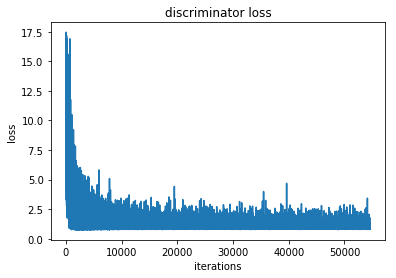

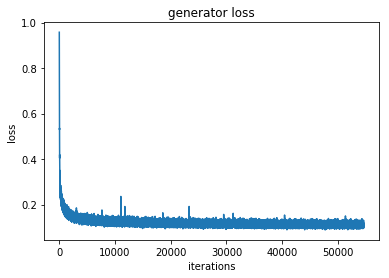

Step 54620: dloss = 1.0979, gloss = 0.1127, real_loss = 0.2484, fake_loss = 0.8495, gan_loss = 16827.9609 l1_loss = 0.0959
Step 54630: dloss = 0.8190, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8190, gan_loss = 17475.8984 l1_loss = 0.0832
Step 54640: dloss = 0.9135, gloss = 0.1155, real_loss = 0.0823, fake_loss = 0.8313, gan_loss = 18097.3086 l1_loss = 0.0974
Step 54650: dloss = 1.0034, gloss = 0.1092, real_loss = 0.1795, fake_loss = 0.8239, gan_loss = 17356.7480 l1_loss = 0.0918
Step 54660: dloss = 0.8386, gloss = 0.1215, real_loss = 0.0000, fake_loss = 0.8386, gan_loss = 17926.4199 l1_loss = 0.1035
Step 54670: dloss = 0.8610, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8610, gan_loss = 17537.6582 l1_loss = 0.0822
Step 54680: dloss = 0.8343, gloss = 0.1081, real_loss = 0.0044, fake_loss = 0.8299, gan_loss = 16606.2188 l1_loss = 0.0915
Step 54690: dloss = 0.8289, gloss = 0.1154, real_loss = 0.0000, fake_loss = 0.8289, gan_loss = 18008.4551 l1_loss = 0.0974
Step 54700: dlos

Step 55290: dloss = 0.8398, gloss = 0.1247, real_loss = 0.0000, fake_loss = 0.8398, gan_loss = 17647.5449 l1_loss = 0.1070
Step 55300: dloss = 0.8573, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8573, gan_loss = 17986.3086 l1_loss = 0.0863
Step 55310: dloss = 0.8834, gloss = 0.1103, real_loss = 0.0026, fake_loss = 0.8808, gan_loss = 17663.7754 l1_loss = 0.0926
Step 55320: dloss = 0.8561, gloss = 0.1106, real_loss = 0.0076, fake_loss = 0.8485, gan_loss = 17702.4512 l1_loss = 0.0929
Step 55330: dloss = 1.1510, gloss = 0.1178, real_loss = 0.3043, fake_loss = 0.8467, gan_loss = 18217.7949 l1_loss = 0.0996
Step 55340: dloss = 0.8437, gloss = 0.1216, real_loss = 0.0000, fake_loss = 0.8437, gan_loss = 18186.1289 l1_loss = 0.1034
Step 55350: dloss = 1.0423, gloss = 0.1011, real_loss = 0.2047, fake_loss = 0.8376, gan_loss = 17533.5488 l1_loss = 0.0836
Step 55360: dloss = 0.8524, gloss = 0.0993, real_loss = 0.0000, fake_loss = 0.8524, gan_loss = 17734.2734 l1_loss = 0.0816
Step 55370: dlos

Step 55960: dloss = 0.8238, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8238, gan_loss = 17574.5703 l1_loss = 0.0921
Step 55970: dloss = 0.8696, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8696, gan_loss = 17010.1758 l1_loss = 0.0942
Step 55980: dloss = 0.8560, gloss = 0.1115, real_loss = 0.0001, fake_loss = 0.8560, gan_loss = 17174.0039 l1_loss = 0.0944
Step 55990: dloss = 0.8411, gloss = 0.0927, real_loss = 0.0102, fake_loss = 0.8309, gan_loss = 18142.0605 l1_loss = 0.0746
Step 56000: dloss = 0.8334, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8334, gan_loss = 16618.2852 l1_loss = 0.0871
Step 56010: dloss = 0.8366, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8366, gan_loss = 17004.7109 l1_loss = 0.0899
Step 56020: dloss = 0.8439, gloss = 0.1226, real_loss = 0.0000, fake_loss = 0.8439, gan_loss = 17368.8555 l1_loss = 0.1052
Step 56030: dloss = 0.8312, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8312, gan_loss = 17801.9355 l1_loss = 0.0900
Step 56040: dlos

Step 56630: dloss = 0.9662, gloss = 0.1029, real_loss = 0.1437, fake_loss = 0.8225, gan_loss = 16806.7012 l1_loss = 0.0861
Step 56640: dloss = 0.8405, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8405, gan_loss = 17083.6113 l1_loss = 0.0987
Step 56650: dloss = 0.8367, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8367, gan_loss = 16763.0215 l1_loss = 0.0942
Step 56660: dloss = 0.9289, gloss = 0.1168, real_loss = 0.0678, fake_loss = 0.8610, gan_loss = 17148.6855 l1_loss = 0.0997
Step 56670: dloss = 0.8409, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8409, gan_loss = 17554.3418 l1_loss = 0.0940
Step 56680: dloss = 0.8479, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8479, gan_loss = 18002.3477 l1_loss = 0.0932
Step 56690: dloss = 0.8325, gloss = 0.1143, real_loss = 0.0000, fake_loss = 0.8325, gan_loss = 18129.1914 l1_loss = 0.0961
Step 56700: dloss = 0.8219, gloss = 0.1265, real_loss = 0.0000, fake_loss = 0.8219, gan_loss = 17864.9180 l1_loss = 0.1086
Step 56710: dlos

Step 57300: dloss = 0.8239, gloss = 0.1132, real_loss = 0.0000, fake_loss = 0.8239, gan_loss = 17540.5273 l1_loss = 0.0957
Step 57310: dloss = 0.8296, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8296, gan_loss = 18173.4121 l1_loss = 0.0893
Step 57320: dloss = 0.8583, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8583, gan_loss = 16608.4961 l1_loss = 0.0992
Step 57330: dloss = 0.8456, gloss = 0.1203, real_loss = 0.0000, fake_loss = 0.8456, gan_loss = 18158.1328 l1_loss = 0.1022
Step 57340: dloss = 0.8223, gloss = 0.1230, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 17526.7832 l1_loss = 0.1055
Step 57350: dloss = 0.8371, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8371, gan_loss = 17887.8164 l1_loss = 0.0937
Step 57360: dloss = 1.4071, gloss = 0.1129, real_loss = 0.5553, fake_loss = 0.8518, gan_loss = 17772.2266 l1_loss = 0.0951
Step 57370: dloss = 0.8285, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8285, gan_loss = 18126.0391 l1_loss = 0.0930
Step 57380: dlos

Step 57970: dloss = 0.8596, gloss = 0.1025, real_loss = 0.0002, fake_loss = 0.8593, gan_loss = 17247.4375 l1_loss = 0.0853
Step 57980: dloss = 0.8249, gloss = 0.1145, real_loss = 0.0000, fake_loss = 0.8249, gan_loss = 17574.2344 l1_loss = 0.0970
Step 57990: dloss = 0.8625, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8625, gan_loss = 17835.9219 l1_loss = 0.0905
Step 58000: dloss = 0.8249, gloss = 0.1207, real_loss = 0.0001, fake_loss = 0.8248, gan_loss = 17299.7207 l1_loss = 0.1034
Step 58010: dloss = 0.8507, gloss = 0.1162, real_loss = 0.0000, fake_loss = 0.8507, gan_loss = 18010.1113 l1_loss = 0.0982
Step 58020: dloss = 0.8556, gloss = 0.1182, real_loss = 0.0000, fake_loss = 0.8556, gan_loss = 17729.6230 l1_loss = 0.1005
Step 58030: dloss = 0.8412, gloss = 0.1206, real_loss = 0.0000, fake_loss = 0.8412, gan_loss = 17159.9141 l1_loss = 0.1035
Step 58040: dloss = 0.8780, gloss = 0.1068, real_loss = 0.0249, fake_loss = 0.8532, gan_loss = 18026.2090 l1_loss = 0.0888
Step 58050: dlos

Step 58640: dloss = 0.8503, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8503, gan_loss = 16771.1172 l1_loss = 0.0885
Step 58650: dloss = 0.8355, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8355, gan_loss = 17811.0020 l1_loss = 0.0883
Step 58660: dloss = 1.0945, gloss = 0.1009, real_loss = 0.2329, fake_loss = 0.8616, gan_loss = 17663.2500 l1_loss = 0.0832
Step 58670: dloss = 0.8186, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8185, gan_loss = 17895.5840 l1_loss = 0.0885
Step 58680: dloss = 0.8618, gloss = 0.1198, real_loss = 0.0000, fake_loss = 0.8618, gan_loss = 18104.3730 l1_loss = 0.1017
Step 58690: dloss = 0.8240, gloss = 0.1160, real_loss = 0.0000, fake_loss = 0.8240, gan_loss = 17573.8945 l1_loss = 0.0985
Step 58700: dloss = 0.8406, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8406, gan_loss = 17677.2188 l1_loss = 0.0859
Step 58710: dloss = 0.8381, gloss = 0.1132, real_loss = 0.0000, fake_loss = 0.8381, gan_loss = 17799.5938 l1_loss = 0.0954
Step 58720: dlos

Step 59310: dloss = 0.8809, gloss = 0.1006, real_loss = 0.0345, fake_loss = 0.8464, gan_loss = 17422.8418 l1_loss = 0.0832
Step 59320: dloss = 0.8437, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8437, gan_loss = 18156.0527 l1_loss = 0.0900
Step 59330: dloss = 0.8361, gloss = 0.1135, real_loss = 0.0000, fake_loss = 0.8361, gan_loss = 16976.8809 l1_loss = 0.0965
Step 59340: dloss = 0.8240, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8240, gan_loss = 17804.5547 l1_loss = 0.0917
Step 59350: dloss = 0.8200, gloss = 0.1169, real_loss = 0.0000, fake_loss = 0.8200, gan_loss = 17327.8105 l1_loss = 0.0995
Step 59360: dloss = 0.8269, gloss = 0.1218, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 18212.4902 l1_loss = 0.1036
Step 59370: dloss = 0.8338, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 18096.6113 l1_loss = 0.0844
Step 59380: dloss = 0.8560, gloss = 0.1138, real_loss = 0.0000, fake_loss = 0.8560, gan_loss = 17845.2422 l1_loss = 0.0959
Step 59390: dlos

Step 59980: dloss = 0.8537, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8537, gan_loss = 17174.1367 l1_loss = 0.0916
Step 59990: dloss = 0.8808, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8808, gan_loss = 17423.7461 l1_loss = 0.0894
Step 60000: dloss = 1.1157, gloss = 0.1072, real_loss = 0.2844, fake_loss = 0.8313, gan_loss = 16959.2988 l1_loss = 0.0903
Step 60010: dloss = 0.8603, gloss = 0.1123, real_loss = 0.0000, fake_loss = 0.8603, gan_loss = 17736.9648 l1_loss = 0.0945
Step 60020: dloss = 0.8625, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8625, gan_loss = 17687.8711 l1_loss = 0.0921
Step 60030: dloss = 0.8545, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8545, gan_loss = 17729.9551 l1_loss = 0.0885
Step 60040: dloss = 0.8195, gloss = 0.1163, real_loss = 0.0108, fake_loss = 0.8088, gan_loss = 17659.7500 l1_loss = 0.0986
Step 60050: dloss = 0.8074, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8074, gan_loss = 18032.1992 l1_loss = 0.0889
Step 60060: dlos

Step 60650: dloss = 0.8338, gloss = 0.1104, real_loss = 0.0165, fake_loss = 0.8172, gan_loss = 16990.3633 l1_loss = 0.0934
Step 60660: dloss = 0.8546, gloss = 0.1189, real_loss = 0.0021, fake_loss = 0.8524, gan_loss = 17741.9375 l1_loss = 0.1012
Step 60670: dloss = 0.9518, gloss = 0.1116, real_loss = 0.1195, fake_loss = 0.8323, gan_loss = 18138.2871 l1_loss = 0.0935
Step 60680: dloss = 0.8284, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8284, gan_loss = 17810.5742 l1_loss = 0.0882
Step 60690: dloss = 1.6229, gloss = 0.1032, real_loss = 0.7972, fake_loss = 0.8257, gan_loss = 17672.4062 l1_loss = 0.0855
Step 60700: dloss = 0.8627, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8627, gan_loss = 17587.6250 l1_loss = 0.0911
Step 60710: dloss = 0.8339, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8339, gan_loss = 17900.5410 l1_loss = 0.0876
Step 60720: dloss = 0.8617, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8617, gan_loss = 17653.9434 l1_loss = 0.0843
Step 60730: dlos

Step 61320: dloss = 0.8443, gloss = 0.1185, real_loss = 0.0000, fake_loss = 0.8443, gan_loss = 17588.9160 l1_loss = 0.1009
Step 61330: dloss = 0.8391, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8391, gan_loss = 16780.6602 l1_loss = 0.0813
Step 61340: dloss = 1.0644, gloss = 0.1170, real_loss = 0.2370, fake_loss = 0.8274, gan_loss = 17689.5801 l1_loss = 0.0994
Step 61350: dloss = 0.8045, gloss = 0.1140, real_loss = 0.0000, fake_loss = 0.8045, gan_loss = 17373.8574 l1_loss = 0.0966
Step 61360: dloss = 0.8620, gloss = 0.1012, real_loss = 0.0022, fake_loss = 0.8597, gan_loss = 17479.5938 l1_loss = 0.0837
Step 61370: dloss = 0.8699, gloss = 0.1101, real_loss = 0.0001, fake_loss = 0.8698, gan_loss = 17454.7715 l1_loss = 0.0927
Step 61380: dloss = 0.8388, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.8388, gan_loss = 17485.3301 l1_loss = 0.0863
Step 61390: dloss = 0.8102, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8102, gan_loss = 18140.7891 l1_loss = 0.0906
Step 61400: dlos

Step 61990: dloss = 1.2882, gloss = 0.1006, real_loss = 0.4770, fake_loss = 0.8112, gan_loss = 17753.0215 l1_loss = 0.0829
Step 62000: dloss = 0.8665, gloss = 0.1110, real_loss = 0.0041, fake_loss = 0.8624, gan_loss = 17719.7344 l1_loss = 0.0933
Step 62010: dloss = 0.8305, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8305, gan_loss = 17478.8926 l1_loss = 0.0874
Step 62020: dloss = 0.8237, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8237, gan_loss = 17774.3828 l1_loss = 0.0953
Step 62030: dloss = 0.8483, gloss = 0.1154, real_loss = 0.0000, fake_loss = 0.8483, gan_loss = 17535.0039 l1_loss = 0.0979
Step 62040: dloss = 0.8767, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8767, gan_loss = 18122.7246 l1_loss = 0.0852
Step 62050: dloss = 0.8750, gloss = 0.1066, real_loss = 0.0205, fake_loss = 0.8545, gan_loss = 17847.3008 l1_loss = 0.0887
Step 62060: dloss = 1.1487, gloss = 0.1059, real_loss = 0.3036, fake_loss = 0.8451, gan_loss = 17359.6875 l1_loss = 0.0886
Step 62070: dlos

Step 62660: dloss = 1.0531, gloss = 0.1220, real_loss = 0.2172, fake_loss = 0.8358, gan_loss = 17759.9609 l1_loss = 0.1042
Step 62670: dloss = 0.8372, gloss = 0.1159, real_loss = 0.0000, fake_loss = 0.8372, gan_loss = 18205.8379 l1_loss = 0.0977
Step 62680: dloss = 0.8641, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8641, gan_loss = 17826.7676 l1_loss = 0.0876
Step 62690: dloss = 0.8464, gloss = 0.1094, real_loss = 0.0000, fake_loss = 0.8464, gan_loss = 17569.1719 l1_loss = 0.0918
Step 62700: dloss = 0.8258, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8258, gan_loss = 18030.4570 l1_loss = 0.0853
Step 62710: dloss = 0.8411, gloss = 0.1118, real_loss = 0.0000, fake_loss = 0.8411, gan_loss = 17761.7012 l1_loss = 0.0941
Step 62720: dloss = 0.8528, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8528, gan_loss = 17577.2188 l1_loss = 0.0920
Step 62730: dloss = 0.8304, gloss = 0.1162, real_loss = 0.0000, fake_loss = 0.8304, gan_loss = 17745.8359 l1_loss = 0.0985
Step 62740: dlos

Step 63330: dloss = 0.8242, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 17934.5918 l1_loss = 0.0870
Step 63340: dloss = 0.8297, gloss = 0.1138, real_loss = 0.0000, fake_loss = 0.8297, gan_loss = 16925.5000 l1_loss = 0.0968
Step 63350: dloss = 0.8371, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8371, gan_loss = 17379.2910 l1_loss = 0.0873
Step 63360: dloss = 0.8080, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8080, gan_loss = 17656.7871 l1_loss = 0.0887
Step 63370: dloss = 0.8236, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.8236, gan_loss = 17889.5605 l1_loss = 0.0897
Step 63380: dloss = 0.8308, gloss = 0.1106, real_loss = 0.0003, fake_loss = 0.8305, gan_loss = 17604.3926 l1_loss = 0.0930
Step 63390: dloss = 0.8419, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8419, gan_loss = 16937.4414 l1_loss = 0.0883
Step 63400: dloss = 0.8555, gloss = 0.1084, real_loss = 0.0001, fake_loss = 0.8554, gan_loss = 17780.1270 l1_loss = 0.0907
Step 63410: dlos

Step 64000: dloss = 0.8700, gloss = 0.0954, real_loss = 0.0411, fake_loss = 0.8288, gan_loss = 17546.1367 l1_loss = 0.0779
Step 64010: dloss = 0.8605, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8605, gan_loss = 17866.9082 l1_loss = 0.0909
Step 64020: dloss = 0.8376, gloss = 0.1206, real_loss = 0.0000, fake_loss = 0.8376, gan_loss = 17593.8516 l1_loss = 0.1030
Step 64030: dloss = 0.8268, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.8268, gan_loss = 17254.2812 l1_loss = 0.0846
Step 64040: dloss = 0.8431, gloss = 0.1079, real_loss = 0.0000, fake_loss = 0.8431, gan_loss = 18022.5391 l1_loss = 0.0899
Step 64050: dloss = 1.1728, gloss = 0.1092, real_loss = 0.3307, fake_loss = 0.8421, gan_loss = 17814.8027 l1_loss = 0.0913
Step 64060: dloss = 0.8425, gloss = 0.1326, real_loss = 0.0000, fake_loss = 0.8425, gan_loss = 17487.8086 l1_loss = 0.1151
Step 64070: dloss = 0.8548, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.8548, gan_loss = 17750.3613 l1_loss = 0.0931
Step 64080: dlos

Step 64670: dloss = 0.8182, gloss = 0.1256, real_loss = 0.0000, fake_loss = 0.8182, gan_loss = 17467.1582 l1_loss = 0.1081
Step 64680: dloss = 0.8644, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8644, gan_loss = 17159.0391 l1_loss = 0.0939
Step 64690: dloss = 0.8499, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8499, gan_loss = 17652.3340 l1_loss = 0.0805
Step 64700: dloss = 0.8497, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8497, gan_loss = 17755.6934 l1_loss = 0.0892
Step 64710: dloss = 0.8425, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8425, gan_loss = 17321.8867 l1_loss = 0.0907
Step 64720: dloss = 0.8403, gloss = 0.0911, real_loss = 0.0000, fake_loss = 0.8403, gan_loss = 17216.0781 l1_loss = 0.0738
Step 64730: dloss = 0.8393, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8393, gan_loss = 17570.2246 l1_loss = 0.0905
Step 64740: dloss = 0.8366, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8366, gan_loss = 17931.5801 l1_loss = 0.0865
Step 64750: dlos

Step 65340: dloss = 0.8210, gloss = 0.1103, real_loss = 0.0002, fake_loss = 0.8208, gan_loss = 18258.6836 l1_loss = 0.0921
Step 65350: dloss = 0.8445, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 18303.9141 l1_loss = 0.0914
Step 65360: dloss = 0.8485, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8485, gan_loss = 17224.6953 l1_loss = 0.0902
Step 65370: dloss = 1.0988, gloss = 0.1095, real_loss = 0.2503, fake_loss = 0.8485, gan_loss = 17368.2637 l1_loss = 0.0922
Step 65380: dloss = 0.8216, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8216, gan_loss = 17763.7148 l1_loss = 0.0866
Step 65390: dloss = 1.2076, gloss = 0.1101, real_loss = 0.3754, fake_loss = 0.8322, gan_loss = 17519.2520 l1_loss = 0.0926
Step 65400: dloss = 0.8537, gloss = 0.1126, real_loss = 0.0000, fake_loss = 0.8537, gan_loss = 17819.4043 l1_loss = 0.0948
Step 65410: dloss = 0.8723, gloss = 0.1143, real_loss = 0.0000, fake_loss = 0.8723, gan_loss = 17649.0293 l1_loss = 0.0966
Step 65420: dlos

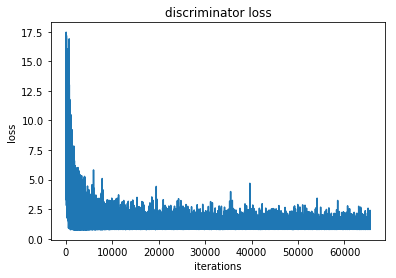

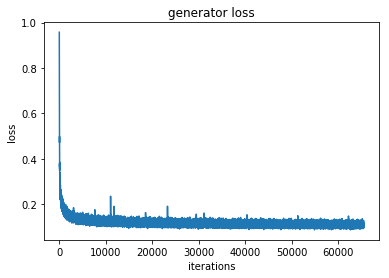

Step 65540: dloss = 0.8278, gloss = 0.1296, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 18041.4199 l1_loss = 0.1115
Step 65550: dloss = 0.8477, gloss = 0.1198, real_loss = 0.0000, fake_loss = 0.8477, gan_loss = 17558.3633 l1_loss = 0.1023
Step 65560: dloss = 0.8351, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8351, gan_loss = 17562.1777 l1_loss = 0.0872
Step 65570: dloss = 0.8408, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8408, gan_loss = 16324.9229 l1_loss = 0.0844
Step 65580: dloss = 0.8310, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8310, gan_loss = 17365.4316 l1_loss = 0.0914
Step 65590: dloss = 0.8552, gloss = 0.0942, real_loss = 0.0000, fake_loss = 0.8552, gan_loss = 17438.5215 l1_loss = 0.0767
Step 65600: dloss = 0.8474, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.8474, gan_loss = 17805.5859 l1_loss = 0.0847
Step 65610: dloss = 0.8467, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8467, gan_loss = 17374.4277 l1_loss = 0.0827
Step 65620: dlos

Step 66210: dloss = 0.8377, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8377, gan_loss = 17091.1191 l1_loss = 0.0918
Step 66220: dloss = 0.8525, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8525, gan_loss = 17636.9395 l1_loss = 0.0888
Step 66230: dloss = 0.8569, gloss = 0.1121, real_loss = 0.0000, fake_loss = 0.8569, gan_loss = 16007.4102 l1_loss = 0.0961
Step 66240: dloss = 0.8368, gloss = 0.1140, real_loss = 0.0000, fake_loss = 0.8368, gan_loss = 18176.0781 l1_loss = 0.0958
Step 66250: dloss = 0.8261, gloss = 0.1055, real_loss = 0.0001, fake_loss = 0.8260, gan_loss = 17877.5781 l1_loss = 0.0876
Step 66260: dloss = 0.8673, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8673, gan_loss = 18166.8887 l1_loss = 0.0815
Step 66270: dloss = 0.8464, gloss = 0.1166, real_loss = 0.0000, fake_loss = 0.8464, gan_loss = 17362.4805 l1_loss = 0.0992
Step 66280: dloss = 0.8371, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8371, gan_loss = 17693.8848 l1_loss = 0.0911
Step 66290: dlos

Step 66880: dloss = 0.8426, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8426, gan_loss = 18279.9961 l1_loss = 0.0898
Step 66890: dloss = 0.8212, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 17661.0840 l1_loss = 0.0919
Step 66900: dloss = 0.8489, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8489, gan_loss = 17721.5703 l1_loss = 0.0870
Step 66910: dloss = 0.8492, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8492, gan_loss = 18079.0078 l1_loss = 0.0814
Step 66920: dloss = 0.8345, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8345, gan_loss = 17980.9492 l1_loss = 0.0918
Step 66930: dloss = 0.8142, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 17579.2070 l1_loss = 0.0853
Step 66940: dloss = 0.8246, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8246, gan_loss = 17870.2617 l1_loss = 0.0797
Step 66950: dloss = 0.8567, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8567, gan_loss = 18227.2285 l1_loss = 0.0896
Step 66960: dlos

Step 67550: dloss = 0.8438, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8438, gan_loss = 17179.9570 l1_loss = 0.0939
Step 67560: dloss = 1.0436, gloss = 0.1247, real_loss = 0.2358, fake_loss = 0.8078, gan_loss = 17453.0508 l1_loss = 0.1072
Step 67570: dloss = 0.8390, gloss = 0.1108, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 17728.7383 l1_loss = 0.0931
Step 67580: dloss = 0.8361, gloss = 0.1223, real_loss = 0.0002, fake_loss = 0.8359, gan_loss = 17541.1836 l1_loss = 0.1047
Step 67590: dloss = 0.8058, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8058, gan_loss = 17149.8203 l1_loss = 0.0856
Step 67600: dloss = 0.8508, gloss = 0.1113, real_loss = 0.0000, fake_loss = 0.8507, gan_loss = 17282.9668 l1_loss = 0.0941
Step 67610: dloss = 0.8220, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8220, gan_loss = 17313.0547 l1_loss = 0.0902
Step 67620: dloss = 0.8279, gloss = 0.1219, real_loss = 0.0000, fake_loss = 0.8279, gan_loss = 17613.7559 l1_loss = 0.1043
Step 67630: dlos

Step 68220: dloss = 0.8110, gloss = 0.1144, real_loss = 0.0000, fake_loss = 0.8110, gan_loss = 17634.7070 l1_loss = 0.0968
Step 68230: dloss = 1.1464, gloss = 0.1068, real_loss = 0.3389, fake_loss = 0.8075, gan_loss = 17508.5215 l1_loss = 0.0893
Step 68240: dloss = 0.8727, gloss = 0.1126, real_loss = 0.0000, fake_loss = 0.8727, gan_loss = 17736.3477 l1_loss = 0.0949
Step 68250: dloss = 0.8192, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8192, gan_loss = 17720.5020 l1_loss = 0.0906
Step 68260: dloss = 0.8359, gloss = 0.1155, real_loss = 0.0000, fake_loss = 0.8359, gan_loss = 18019.9805 l1_loss = 0.0975
Step 68270: dloss = 0.8698, gloss = 0.1097, real_loss = 0.0123, fake_loss = 0.8574, gan_loss = 17433.3281 l1_loss = 0.0923
Step 68280: dloss = 0.8158, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.8158, gan_loss = 17545.5508 l1_loss = 0.0910
Step 68290: dloss = 0.8480, gloss = 0.1092, real_loss = 0.0201, fake_loss = 0.8279, gan_loss = 17142.4082 l1_loss = 0.0920
Step 68300: dlos

Step 68890: dloss = 0.8137, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8137, gan_loss = 17097.2949 l1_loss = 0.0877
Step 68900: dloss = 0.8407, gloss = 0.1187, real_loss = 0.0000, fake_loss = 0.8407, gan_loss = 16823.2422 l1_loss = 0.1019
Step 68910: dloss = 0.8379, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.8379, gan_loss = 16623.5000 l1_loss = 0.0775
Step 68920: dloss = 0.8522, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.8522, gan_loss = 16806.0918 l1_loss = 0.0864
Step 68930: dloss = 0.8195, gloss = 0.1213, real_loss = 0.0038, fake_loss = 0.8157, gan_loss = 17176.2891 l1_loss = 0.1042
Step 68940: dloss = 0.8437, gloss = 0.1155, real_loss = 0.0000, fake_loss = 0.8437, gan_loss = 17452.7090 l1_loss = 0.0980
Step 68950: dloss = 0.9784, gloss = 0.1033, real_loss = 0.1452, fake_loss = 0.8332, gan_loss = 16821.8125 l1_loss = 0.0865
Step 68960: dloss = 0.8597, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8597, gan_loss = 16662.8633 l1_loss = 0.1010
Step 68970: dlos

Step 69560: dloss = 0.8379, gloss = 0.1080, real_loss = 0.0000, fake_loss = 0.8379, gan_loss = 17693.5586 l1_loss = 0.0903
Step 69570: dloss = 0.7928, gloss = 0.1200, real_loss = 0.0000, fake_loss = 0.7928, gan_loss = 17500.3730 l1_loss = 0.1025
Step 69580: dloss = 1.0107, gloss = 0.1038, real_loss = 0.1746, fake_loss = 0.8361, gan_loss = 17141.2930 l1_loss = 0.0866
Step 69590: dloss = 0.8251, gloss = 0.1220, real_loss = 0.0000, fake_loss = 0.8251, gan_loss = 17491.9961 l1_loss = 0.1045
Step 69600: dloss = 0.8292, gloss = 0.1246, real_loss = 0.0000, fake_loss = 0.8292, gan_loss = 17753.8828 l1_loss = 0.1068
Step 69610: dloss = 0.8629, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8629, gan_loss = 17590.0078 l1_loss = 0.0816
Step 69620: dloss = 0.8231, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8231, gan_loss = 17568.5312 l1_loss = 0.0912
Step 69630: dloss = 0.8495, gloss = 0.1065, real_loss = 0.0141, fake_loss = 0.8355, gan_loss = 17682.0137 l1_loss = 0.0888
Step 69640: dlos

Step 70230: dloss = 0.8833, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.8833, gan_loss = 17445.7363 l1_loss = 0.0842
Step 70240: dloss = 0.8266, gloss = 0.1180, real_loss = 0.0000, fake_loss = 0.8266, gan_loss = 18062.0801 l1_loss = 0.1000
Step 70250: dloss = 0.8106, gloss = 0.1135, real_loss = 0.0000, fake_loss = 0.8106, gan_loss = 17936.4668 l1_loss = 0.0955
Step 70260: dloss = 0.8079, gloss = 0.1149, real_loss = 0.0000, fake_loss = 0.8079, gan_loss = 17136.2363 l1_loss = 0.0978
Step 70270: dloss = 0.8459, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8459, gan_loss = 17224.1992 l1_loss = 0.0833
Step 70280: dloss = 0.8209, gloss = 0.1197, real_loss = 0.0000, fake_loss = 0.8209, gan_loss = 18275.8379 l1_loss = 0.1014
Step 70290: dloss = 0.8351, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8351, gan_loss = 17749.3184 l1_loss = 0.0876
Step 70300: dloss = 1.1782, gloss = 0.1060, real_loss = 0.3343, fake_loss = 0.8439, gan_loss = 17867.1504 l1_loss = 0.0882
Step 70310: dlos

Step 70900: dloss = 0.8357, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 16571.3398 l1_loss = 0.0901
Step 70910: dloss = 1.2347, gloss = 0.1013, real_loss = 0.3845, fake_loss = 0.8502, gan_loss = 16854.7520 l1_loss = 0.0844
Step 70920: dloss = 0.8303, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8303, gan_loss = 17798.9004 l1_loss = 0.0921
Step 70930: dloss = 0.8428, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8428, gan_loss = 17609.2305 l1_loss = 0.0938
Step 70940: dloss = 0.8555, gloss = 0.1150, real_loss = 0.0000, fake_loss = 0.8555, gan_loss = 17460.8359 l1_loss = 0.0976
Step 70950: dloss = 1.1048, gloss = 0.1151, real_loss = 0.2511, fake_loss = 0.8537, gan_loss = 17113.5469 l1_loss = 0.0980
Step 70960: dloss = 0.8511, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8511, gan_loss = 17727.2383 l1_loss = 0.0882
Step 70970: dloss = 0.8321, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.8321, gan_loss = 17810.7715 l1_loss = 0.0925
Step 70980: dlos

Step 71570: dloss = 0.8553, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8553, gan_loss = 17871.4141 l1_loss = 0.0936
Step 71580: dloss = 0.8277, gloss = 0.1241, real_loss = 0.0000, fake_loss = 0.8277, gan_loss = 17084.0332 l1_loss = 0.1070
Step 71590: dloss = 0.8486, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8486, gan_loss = 17466.3945 l1_loss = 0.0936
Step 71600: dloss = 0.8376, gloss = 0.1105, real_loss = 0.0000, fake_loss = 0.8376, gan_loss = 17240.9238 l1_loss = 0.0932
Step 71610: dloss = 0.8530, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.8530, gan_loss = 17433.9707 l1_loss = 0.0815
Step 71620: dloss = 0.8555, gloss = 0.1031, real_loss = 0.0000, fake_loss = 0.8555, gan_loss = 17946.2227 l1_loss = 0.0852
Step 71630: dloss = 0.8290, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8290, gan_loss = 17628.8652 l1_loss = 0.0893
Step 71640: dloss = 0.8875, gloss = 0.1091, real_loss = 0.0627, fake_loss = 0.8248, gan_loss = 17361.6094 l1_loss = 0.0917
Step 71650: dlos

Step 72240: dloss = 0.9112, gloss = 0.1018, real_loss = 0.0611, fake_loss = 0.8501, gan_loss = 17712.7754 l1_loss = 0.0841
Step 72250: dloss = 0.8417, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8417, gan_loss = 17259.6934 l1_loss = 0.0915
Step 72260: dloss = 0.7803, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.7803, gan_loss = 17333.6465 l1_loss = 0.0941
Step 72270: dloss = 0.8500, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8500, gan_loss = 17258.6484 l1_loss = 0.0823
Step 72280: dloss = 0.8266, gloss = 0.1249, real_loss = 0.0000, fake_loss = 0.8266, gan_loss = 17375.1543 l1_loss = 0.1075
Step 72290: dloss = 0.8905, gloss = 0.1140, real_loss = 0.0290, fake_loss = 0.8615, gan_loss = 17144.1816 l1_loss = 0.0968
Step 72300: dloss = 0.8337, gloss = 0.1090, real_loss = 0.0024, fake_loss = 0.8314, gan_loss = 17382.2559 l1_loss = 0.0917
Step 72310: dloss = 0.8011, gloss = 0.1174, real_loss = 0.0000, fake_loss = 0.8011, gan_loss = 17381.1211 l1_loss = 0.1000
Step 72320: dlos

Step 72910: dloss = 0.8395, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8395, gan_loss = 17931.5117 l1_loss = 0.0832
Step 72920: dloss = 0.8486, gloss = 0.1245, real_loss = 0.0000, fake_loss = 0.8486, gan_loss = 17098.5879 l1_loss = 0.1074
Step 72930: dloss = 2.2299, gloss = 0.1166, real_loss = 1.3986, fake_loss = 0.8313, gan_loss = 18493.1348 l1_loss = 0.0981
Step 72940: dloss = 1.2632, gloss = 0.0963, real_loss = 0.4577, fake_loss = 0.8054, gan_loss = 18300.8320 l1_loss = 0.0780
Step 72950: dloss = 0.8279, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8279, gan_loss = 17836.5781 l1_loss = 0.0909
Step 72960: dloss = 0.8537, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8536, gan_loss = 17522.8691 l1_loss = 0.0895
Step 72970: dloss = 0.8409, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.8409, gan_loss = 17411.3652 l1_loss = 0.0968
Step 72980: dloss = 0.8287, gloss = 0.1225, real_loss = 0.0003, fake_loss = 0.8284, gan_loss = 17697.7383 l1_loss = 0.1048
Step 72990: dlos

Step 73580: dloss = 0.8390, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 17782.1816 l1_loss = 0.0934
Step 73590: dloss = 0.8701, gloss = 0.1040, real_loss = 0.0021, fake_loss = 0.8680, gan_loss = 17255.1426 l1_loss = 0.0867
Step 73600: dloss = 0.8270, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8270, gan_loss = 17271.2930 l1_loss = 0.0905
Step 73610: dloss = 0.8183, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.8183, gan_loss = 17438.2285 l1_loss = 0.0959
Step 73620: dloss = 0.8384, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8384, gan_loss = 17948.1602 l1_loss = 0.0907
Step 73630: dloss = 0.8701, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8701, gan_loss = 17662.5840 l1_loss = 0.0843
Step 73640: dloss = 0.8121, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 17263.2559 l1_loss = 0.0927
Step 73650: dloss = 0.8450, gloss = 0.1146, real_loss = 0.0004, fake_loss = 0.8446, gan_loss = 17687.3711 l1_loss = 0.0969
Step 73660: dlos

Step 74250: dloss = 2.1032, gloss = 0.1098, real_loss = 1.2905, fake_loss = 0.8127, gan_loss = 17514.2441 l1_loss = 0.0923
Step 74260: dloss = 0.8628, gloss = 0.0912, real_loss = 0.0000, fake_loss = 0.8628, gan_loss = 16992.6016 l1_loss = 0.0742
Step 74270: dloss = 0.8513, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8513, gan_loss = 17171.3691 l1_loss = 0.0875
Step 74280: dloss = 0.8120, gloss = 0.1124, real_loss = 0.0000, fake_loss = 0.8120, gan_loss = 17771.1133 l1_loss = 0.0946
Step 74290: dloss = 0.8223, gloss = 0.1150, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 17252.6738 l1_loss = 0.0977
Step 74300: dloss = 0.8697, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8697, gan_loss = 16767.7715 l1_loss = 0.0875
Step 74310: dloss = 0.8038, gloss = 0.1158, real_loss = 0.0000, fake_loss = 0.8038, gan_loss = 18062.1836 l1_loss = 0.0978
Step 74320: dloss = 0.8096, gloss = 0.1196, real_loss = 0.0000, fake_loss = 0.8096, gan_loss = 17133.4102 l1_loss = 0.1025
Step 74330: dlos

Step 74920: dloss = 0.8319, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 17535.4121 l1_loss = 0.0898
Step 74930: dloss = 0.8217, gloss = 0.1155, real_loss = 0.0000, fake_loss = 0.8217, gan_loss = 17437.8672 l1_loss = 0.0981
Step 74940: dloss = 0.8655, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8655, gan_loss = 17285.7422 l1_loss = 0.0868
Step 74950: dloss = 0.8166, gloss = 0.1218, real_loss = 0.0000, fake_loss = 0.8166, gan_loss = 17701.3828 l1_loss = 0.1041
Step 74960: dloss = 0.8176, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 17732.6289 l1_loss = 0.0950
Step 74970: dloss = 0.8289, gloss = 0.0988, real_loss = 0.0005, fake_loss = 0.8283, gan_loss = 16971.6562 l1_loss = 0.0818
Step 74980: dloss = 0.8408, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.8408, gan_loss = 17446.4023 l1_loss = 0.0935
Step 74990: dloss = 0.8555, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.8555, gan_loss = 18135.9160 l1_loss = 0.0875
Step 75000: dlos

Step 75590: dloss = 0.8191, gloss = 0.1150, real_loss = 0.0000, fake_loss = 0.8191, gan_loss = 17182.3438 l1_loss = 0.0978
Step 75600: dloss = 0.8420, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8420, gan_loss = 17850.6074 l1_loss = 0.0905
Step 75610: dloss = 0.8423, gloss = 0.1067, real_loss = 0.0000, fake_loss = 0.8423, gan_loss = 17007.1895 l1_loss = 0.0897
Step 75620: dloss = 0.8317, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8317, gan_loss = 17437.5469 l1_loss = 0.0898
Step 75630: dloss = 1.2747, gloss = 0.1126, real_loss = 0.4348, fake_loss = 0.8399, gan_loss = 17172.9414 l1_loss = 0.0954
Step 75640: dloss = 0.8125, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.8125, gan_loss = 17638.9121 l1_loss = 0.0909
Step 75650: dloss = 0.8515, gloss = 0.1187, real_loss = 0.0000, fake_loss = 0.8515, gan_loss = 18253.7383 l1_loss = 0.1004
Step 75660: dloss = 0.8325, gloss = 0.1122, real_loss = 0.0018, fake_loss = 0.8307, gan_loss = 17555.4141 l1_loss = 0.0947
Step 75670: dlos

Step 76260: dloss = 1.1905, gloss = 0.1070, real_loss = 0.3500, fake_loss = 0.8405, gan_loss = 17503.7129 l1_loss = 0.0895
Step 76270: dloss = 0.8176, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 17835.1719 l1_loss = 0.0859
Step 76280: dloss = 0.8462, gloss = 0.1090, real_loss = 0.0000, fake_loss = 0.8462, gan_loss = 17690.8809 l1_loss = 0.0913
Step 76290: dloss = 0.8485, gloss = 0.1199, real_loss = 0.0000, fake_loss = 0.8485, gan_loss = 17973.3223 l1_loss = 0.1019
Step 76300: dloss = 0.8415, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8415, gan_loss = 17490.3867 l1_loss = 0.0881
Step 76310: dloss = 0.8423, gloss = 0.1173, real_loss = 0.0000, fake_loss = 0.8423, gan_loss = 18354.9141 l1_loss = 0.0989
Step 76320: dloss = 0.8293, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8293, gan_loss = 17537.3574 l1_loss = 0.0826
Step 76330: dloss = 0.8517, gloss = 0.1020, real_loss = 0.0407, fake_loss = 0.8111, gan_loss = 17256.7109 l1_loss = 0.0848
Step 76340: dlos

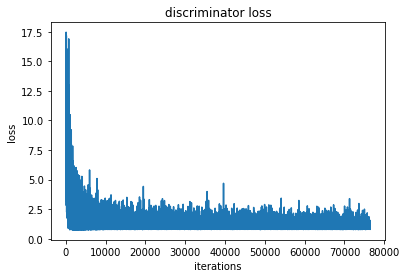

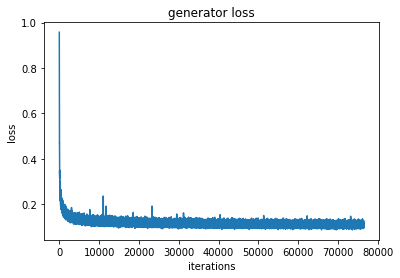

Step 76470: dloss = 0.8451, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8451, gan_loss = 17059.4844 l1_loss = 0.0895
Step 76480: dloss = 1.2264, gloss = 0.1214, real_loss = 0.3904, fake_loss = 0.8361, gan_loss = 17145.1895 l1_loss = 0.1042
Step 76490: dloss = 0.8213, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8213, gan_loss = 18040.1836 l1_loss = 0.0810
Step 76500: dloss = 0.8157, gloss = 0.1216, real_loss = 0.0000, fake_loss = 0.8157, gan_loss = 16807.0293 l1_loss = 0.1048
Step 76510: dloss = 1.1162, gloss = 0.1005, real_loss = 0.2647, fake_loss = 0.8515, gan_loss = 17713.1289 l1_loss = 0.0828
Step 76520: dloss = 0.8516, gloss = 0.1145, real_loss = 0.0000, fake_loss = 0.8516, gan_loss = 17754.4355 l1_loss = 0.0968
Step 76530: dloss = 0.8061, gloss = 0.1161, real_loss = 0.0000, fake_loss = 0.8061, gan_loss = 17678.6484 l1_loss = 0.0984
Step 76540: dloss = 0.8595, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8595, gan_loss = 17519.7090 l1_loss = 0.0779
Step 76550: dlos

Step 77140: dloss = 1.2741, gloss = 0.0998, real_loss = 0.3916, fake_loss = 0.8825, gan_loss = 17445.0176 l1_loss = 0.0824
Step 77150: dloss = 0.8343, gloss = 0.1166, real_loss = 0.0000, fake_loss = 0.8343, gan_loss = 16971.4102 l1_loss = 0.0996
Step 77160: dloss = 0.8387, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8387, gan_loss = 17675.2422 l1_loss = 0.0843
Step 77170: dloss = 1.3328, gloss = 0.1052, real_loss = 0.4565, fake_loss = 0.8762, gan_loss = 16855.2812 l1_loss = 0.0884
Step 77180: dloss = 0.8098, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8098, gan_loss = 17505.9141 l1_loss = 0.0845
Step 77190: dloss = 1.1874, gloss = 0.1066, real_loss = 0.3635, fake_loss = 0.8239, gan_loss = 17114.6816 l1_loss = 0.0895
Step 77200: dloss = 0.8242, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 17530.9863 l1_loss = 0.0956
Step 77210: dloss = 0.8102, gloss = 0.1084, real_loss = 0.0000, fake_loss = 0.8102, gan_loss = 17340.4434 l1_loss = 0.0910
Step 77220: dlos

Step 77810: dloss = 0.8668, gloss = 0.1063, real_loss = 0.0417, fake_loss = 0.8251, gan_loss = 16517.9453 l1_loss = 0.0898
Step 77820: dloss = 0.8236, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8236, gan_loss = 16833.3691 l1_loss = 0.0943
Step 77830: dloss = 0.8141, gloss = 0.1139, real_loss = 0.0000, fake_loss = 0.8141, gan_loss = 17690.8691 l1_loss = 0.0962
Step 77840: dloss = 0.8439, gloss = 0.0972, real_loss = 0.0126, fake_loss = 0.8313, gan_loss = 17139.6230 l1_loss = 0.0801
Step 77850: dloss = 0.8149, gloss = 0.1197, real_loss = 0.0000, fake_loss = 0.8149, gan_loss = 17171.8262 l1_loss = 0.1025
Step 77860: dloss = 1.3872, gloss = 0.1246, real_loss = 0.5688, fake_loss = 0.8184, gan_loss = 17623.9902 l1_loss = 0.1070
Step 77870: dloss = 1.8096, gloss = 0.1086, real_loss = 0.9421, fake_loss = 0.8675, gan_loss = 17294.4395 l1_loss = 0.0913
Step 77880: dloss = 0.8297, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8297, gan_loss = 18202.8145 l1_loss = 0.0929
Step 77890: dlos

Step 78480: dloss = 0.8373, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8373, gan_loss = 17042.8281 l1_loss = 0.0905
Step 78490: dloss = 0.8122, gloss = 0.1251, real_loss = 0.0000, fake_loss = 0.8122, gan_loss = 17323.1055 l1_loss = 0.1078
Step 78500: dloss = 0.8380, gloss = 0.1134, real_loss = 0.0000, fake_loss = 0.8380, gan_loss = 17486.2891 l1_loss = 0.0959
Step 78510: dloss = 1.8138, gloss = 0.1029, real_loss = 0.9755, fake_loss = 0.8383, gan_loss = 17046.3535 l1_loss = 0.0859
Step 78520: dloss = 0.8446, gloss = 0.1018, real_loss = 0.0000, fake_loss = 0.8446, gan_loss = 17456.4375 l1_loss = 0.0843
Step 78530: dloss = 0.8282, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.8282, gan_loss = 16385.3711 l1_loss = 0.0918
Step 78540: dloss = 0.8309, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8309, gan_loss = 17753.1738 l1_loss = 0.0867
Step 78550: dloss = 0.8378, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8378, gan_loss = 17075.3945 l1_loss = 0.0912
Step 78560: dlos

Step 79150: dloss = 0.8165, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.8165, gan_loss = 17271.4961 l1_loss = 0.0806
Step 79160: dloss = 0.8409, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8409, gan_loss = 17398.1621 l1_loss = 0.0848
Step 79170: dloss = 0.8254, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8254, gan_loss = 17146.5117 l1_loss = 0.0858
Step 79180: dloss = 0.8378, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8378, gan_loss = 17268.0273 l1_loss = 0.1004
Step 79190: dloss = 0.8476, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8476, gan_loss = 17867.6016 l1_loss = 0.0799
Step 79200: dloss = 0.8271, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8271, gan_loss = 17377.3691 l1_loss = 0.0884
Step 79210: dloss = 0.8440, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8440, gan_loss = 17489.9512 l1_loss = 0.0884
Step 79220: dloss = 0.8507, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8507, gan_loss = 16457.1562 l1_loss = 0.0921
Step 79230: dlos

Step 79820: dloss = 0.8821, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.8821, gan_loss = 17214.4180 l1_loss = 0.0801
Step 79830: dloss = 0.8679, gloss = 0.1113, real_loss = 0.0012, fake_loss = 0.8666, gan_loss = 17031.1523 l1_loss = 0.0943
Step 79840: dloss = 0.8531, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.8531, gan_loss = 17271.4688 l1_loss = 0.0851
Step 79850: dloss = 0.8538, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8538, gan_loss = 17569.1523 l1_loss = 0.1001
Step 79860: dloss = 0.8415, gloss = 0.0958, real_loss = 0.0000, fake_loss = 0.8415, gan_loss = 17360.0879 l1_loss = 0.0785
Step 79870: dloss = 0.8592, gloss = 0.1104, real_loss = 0.0000, fake_loss = 0.8592, gan_loss = 17403.6328 l1_loss = 0.0930
Step 79880: dloss = 0.8474, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8474, gan_loss = 17364.9980 l1_loss = 0.0887
Step 79890: dloss = 0.8178, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 17104.2344 l1_loss = 0.0935
Step 79900: dlos

Step 80490: dloss = 0.8328, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.8328, gan_loss = 16991.8750 l1_loss = 0.0913
Step 80500: dloss = 0.8458, gloss = 0.1119, real_loss = 0.0045, fake_loss = 0.8413, gan_loss = 17253.8047 l1_loss = 0.0946
Step 80510: dloss = 0.8244, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8244, gan_loss = 17749.6035 l1_loss = 0.0921
Step 80520: dloss = 0.8550, gloss = 0.1064, real_loss = 0.0148, fake_loss = 0.8402, gan_loss = 17770.9102 l1_loss = 0.0886
Step 80530: dloss = 1.0582, gloss = 0.1058, real_loss = 0.1927, fake_loss = 0.8655, gan_loss = 17127.1191 l1_loss = 0.0887
Step 80540: dloss = 0.8344, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8344, gan_loss = 17133.5566 l1_loss = 0.0834
Step 80550: dloss = 0.8300, gloss = 0.1140, real_loss = 0.0000, fake_loss = 0.8300, gan_loss = 17885.9961 l1_loss = 0.0961
Step 80560: dloss = 0.8502, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8502, gan_loss = 17163.5703 l1_loss = 0.0785
Step 80570: dlos

Step 81160: dloss = 0.8276, gloss = 0.1096, real_loss = 0.0022, fake_loss = 0.8254, gan_loss = 17474.2031 l1_loss = 0.0921
Step 81170: dloss = 0.8085, gloss = 0.1013, real_loss = 0.0001, fake_loss = 0.8084, gan_loss = 17637.8867 l1_loss = 0.0837
Step 81180: dloss = 1.3860, gloss = 0.1126, real_loss = 0.5516, fake_loss = 0.8344, gan_loss = 16945.6016 l1_loss = 0.0957
Step 81190: dloss = 0.8175, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8175, gan_loss = 17682.9551 l1_loss = 0.0846
Step 81200: dloss = 0.8165, gloss = 0.1159, real_loss = 0.0000, fake_loss = 0.8165, gan_loss = 17445.6074 l1_loss = 0.0984
Step 81210: dloss = 0.8529, gloss = 0.0952, real_loss = 0.0000, fake_loss = 0.8529, gan_loss = 16926.3750 l1_loss = 0.0783
Step 81220: dloss = 0.8307, gloss = 0.1146, real_loss = 0.0000, fake_loss = 0.8307, gan_loss = 17749.5430 l1_loss = 0.0968
Step 81230: dloss = 0.9281, gloss = 0.1115, real_loss = 0.0715, fake_loss = 0.8566, gan_loss = 16438.8809 l1_loss = 0.0950
Step 81240: dlos

Step 81830: dloss = 0.8421, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8421, gan_loss = 17199.0820 l1_loss = 0.0857
Step 81840: dloss = 0.8330, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8330, gan_loss = 16380.8311 l1_loss = 0.0816
Step 81850: dloss = 0.8483, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8483, gan_loss = 17576.3652 l1_loss = 0.0865
Step 81860: dloss = 0.8476, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8476, gan_loss = 17036.0508 l1_loss = 0.0899
Step 81870: dloss = 0.8637, gloss = 0.0921, real_loss = 0.0000, fake_loss = 0.8637, gan_loss = 16267.7969 l1_loss = 0.0758
Step 81880: dloss = 0.8451, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.8451, gan_loss = 17989.3379 l1_loss = 0.0810
Step 81890: dloss = 1.3791, gloss = 0.1181, real_loss = 0.5354, fake_loss = 0.8437, gan_loss = 17677.0879 l1_loss = 0.1004
Step 81900: dloss = 0.8566, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8566, gan_loss = 17439.3945 l1_loss = 0.0800
Step 81910: dlos

Step 82500: dloss = 0.8538, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.8538, gan_loss = 17052.7891 l1_loss = 0.0880
Step 82510: dloss = 1.1695, gloss = 0.1058, real_loss = 0.3177, fake_loss = 0.8517, gan_loss = 17415.9414 l1_loss = 0.0884
Step 82520: dloss = 0.8480, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8480, gan_loss = 17562.0820 l1_loss = 0.1000
Step 82530: dloss = 1.7744, gloss = 0.1041, real_loss = 0.9235, fake_loss = 0.8508, gan_loss = 17313.6094 l1_loss = 0.0868
Step 82540: dloss = 0.8392, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8392, gan_loss = 16283.9326 l1_loss = 0.0903
Step 82550: dloss = 0.8543, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.8543, gan_loss = 17578.3438 l1_loss = 0.0820
Step 82560: dloss = 0.8285, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8285, gan_loss = 16871.4355 l1_loss = 0.0905
Step 82570: dloss = 0.8419, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8419, gan_loss = 17044.0586 l1_loss = 0.0898
Step 82580: dlos

Step 83170: dloss = 0.8314, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8314, gan_loss = 17387.7109 l1_loss = 0.0924
Step 83180: dloss = 0.8481, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.8481, gan_loss = 18227.0098 l1_loss = 0.0909
Step 83190: dloss = 0.8467, gloss = 0.1010, real_loss = 0.0000, fake_loss = 0.8467, gan_loss = 17864.2168 l1_loss = 0.0832
Step 83200: dloss = 0.8180, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8180, gan_loss = 16831.3906 l1_loss = 0.0813
Step 83210: dloss = 0.8484, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8483, gan_loss = 17220.2656 l1_loss = 0.0888
Step 83220: dloss = 0.8288, gloss = 0.1210, real_loss = 0.0001, fake_loss = 0.8287, gan_loss = 15553.1240 l1_loss = 0.1054
Step 83230: dloss = 0.8035, gloss = 0.1137, real_loss = 0.0000, fake_loss = 0.8035, gan_loss = 17447.2090 l1_loss = 0.0963
Step 83240: dloss = 0.8054, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 17363.9336 l1_loss = 0.0953
Step 83250: dlos

Step 83840: dloss = 0.8492, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.8492, gan_loss = 17888.6621 l1_loss = 0.0954
Step 83850: dloss = 0.8305, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.8305, gan_loss = 16938.3086 l1_loss = 0.0772
Step 83860: dloss = 0.8383, gloss = 0.1010, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 17509.0938 l1_loss = 0.0835
Step 83870: dloss = 0.8588, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8588, gan_loss = 17533.3379 l1_loss = 0.0881
Step 83880: dloss = 0.8001, gloss = 0.1236, real_loss = 0.0000, fake_loss = 0.8001, gan_loss = 17258.2891 l1_loss = 0.1063
Step 83890: dloss = 0.8098, gloss = 0.0984, real_loss = 0.0000, fake_loss = 0.8098, gan_loss = 17284.1074 l1_loss = 0.0811
Step 83900: dloss = 0.8209, gloss = 0.1184, real_loss = 0.0000, fake_loss = 0.8209, gan_loss = 17003.5820 l1_loss = 0.1014
Step 83910: dloss = 0.8606, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8606, gan_loss = 17871.0977 l1_loss = 0.0904
Step 83920: dlos

Step 84510: dloss = 2.0156, gloss = 0.1179, real_loss = 1.1837, fake_loss = 0.8319, gan_loss = 16971.2930 l1_loss = 0.1010
Step 84520: dloss = 0.8170, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8170, gan_loss = 18143.6602 l1_loss = 0.0924
Step 84530: dloss = 0.8299, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8299, gan_loss = 17290.5371 l1_loss = 0.0958
Step 84540: dloss = 0.9444, gloss = 0.1060, real_loss = 0.0937, fake_loss = 0.8507, gan_loss = 16860.8809 l1_loss = 0.0892
Step 84550: dloss = 0.8469, gloss = 0.1031, real_loss = 0.0000, fake_loss = 0.8469, gan_loss = 17515.8262 l1_loss = 0.0855
Step 84560: dloss = 0.8368, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8368, gan_loss = 17180.7012 l1_loss = 0.0859
Step 84570: dloss = 0.8473, gloss = 0.0982, real_loss = 0.0189, fake_loss = 0.8284, gan_loss = 17239.3496 l1_loss = 0.0809
Step 84580: dloss = 0.8231, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8231, gan_loss = 17660.0898 l1_loss = 0.0936
Step 84590: dlos

Step 85180: dloss = 0.8179, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8179, gan_loss = 17388.5625 l1_loss = 0.0849
Step 85190: dloss = 0.8367, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.8367, gan_loss = 17457.7559 l1_loss = 0.0850
Step 85200: dloss = 0.8445, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8445, gan_loss = 17407.8984 l1_loss = 0.0846
Step 85210: dloss = 0.8966, gloss = 0.1084, real_loss = 0.0558, fake_loss = 0.8408, gan_loss = 17348.7383 l1_loss = 0.0910
Step 85220: dloss = 0.8594, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.8594, gan_loss = 17044.9980 l1_loss = 0.0938
Step 85230: dloss = 0.8579, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8579, gan_loss = 17278.7129 l1_loss = 0.0877
Step 85240: dloss = 0.8207, gloss = 0.1132, real_loss = 0.0000, fake_loss = 0.8207, gan_loss = 17534.2969 l1_loss = 0.0957
Step 85250: dloss = 0.8563, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8563, gan_loss = 16582.2363 l1_loss = 0.0934
Step 85260: dlos

Step 85850: dloss = 1.4624, gloss = 0.1120, real_loss = 0.6194, fake_loss = 0.8430, gan_loss = 17630.3379 l1_loss = 0.0944
Step 85860: dloss = 0.8271, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8271, gan_loss = 17748.5020 l1_loss = 0.0887
Step 85870: dloss = 0.8413, gloss = 0.1167, real_loss = 0.0000, fake_loss = 0.8413, gan_loss = 17245.2227 l1_loss = 0.0995
Step 85880: dloss = 0.8298, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8298, gan_loss = 17249.2852 l1_loss = 0.0901
Step 85890: dloss = 0.8512, gloss = 0.1071, real_loss = 0.0000, fake_loss = 0.8512, gan_loss = 17476.9609 l1_loss = 0.0896
Step 85900: dloss = 0.8112, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.8112, gan_loss = 17669.2988 l1_loss = 0.0932
Step 85910: dloss = 1.8933, gloss = 0.1224, real_loss = 1.0835, fake_loss = 0.8097, gan_loss = 17401.9805 l1_loss = 0.1050
Step 85920: dloss = 0.8146, gloss = 0.1016, real_loss = 0.0007, fake_loss = 0.8139, gan_loss = 17512.1387 l1_loss = 0.0841
Step 85930: dlos

Step 86520: dloss = 0.8383, gloss = 0.1171, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 17329.9570 l1_loss = 0.0997
Step 86530: dloss = 0.8226, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8226, gan_loss = 17225.8320 l1_loss = 0.0938
Step 86540: dloss = 0.8470, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.8470, gan_loss = 17564.2598 l1_loss = 0.0909
Step 86550: dloss = 1.3162, gloss = 0.1169, real_loss = 0.4911, fake_loss = 0.8251, gan_loss = 16560.1680 l1_loss = 0.1004
Step 86560: dloss = 0.8373, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8373, gan_loss = 17619.6133 l1_loss = 0.0859
Step 86570: dloss = 0.8262, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8262, gan_loss = 17409.4453 l1_loss = 0.0912
Step 86580: dloss = 0.8004, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8004, gan_loss = 17362.1895 l1_loss = 0.0932
Step 86590: dloss = 0.8288, gloss = 0.1145, real_loss = 0.0000, fake_loss = 0.8288, gan_loss = 17051.3516 l1_loss = 0.0974
Step 86600: dlos

Step 87190: dloss = 0.8390, gloss = 0.1034, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 17616.7734 l1_loss = 0.0858
Step 87200: dloss = 0.8207, gloss = 0.1167, real_loss = 0.0000, fake_loss = 0.8207, gan_loss = 17443.3984 l1_loss = 0.0993
Step 87210: dloss = 0.8459, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8459, gan_loss = 15936.6348 l1_loss = 0.0894
Step 87220: dloss = 0.8378, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8378, gan_loss = 16879.5410 l1_loss = 0.0946
Step 87230: dloss = 1.0194, gloss = 0.1166, real_loss = 0.1639, fake_loss = 0.8554, gan_loss = 16994.5859 l1_loss = 0.0996
Step 87240: dloss = 0.8343, gloss = 0.0917, real_loss = 0.0028, fake_loss = 0.8315, gan_loss = 16919.7988 l1_loss = 0.0748
Step 87250: dloss = 0.8349, gloss = 0.1171, real_loss = 0.0000, fake_loss = 0.8349, gan_loss = 17196.0098 l1_loss = 0.0999
Step 87260: dloss = 0.8357, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 16366.9932 l1_loss = 0.0872
Step 87270: dlos

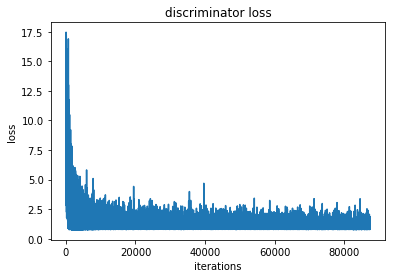

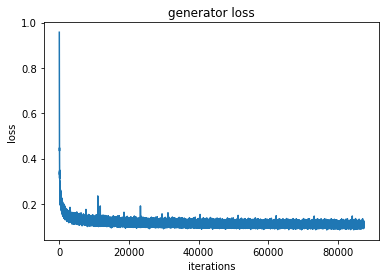

Step 87390: dloss = 1.0196, gloss = 0.1222, real_loss = 0.1750, fake_loss = 0.8447, gan_loss = 17538.2578 l1_loss = 0.1047
Step 87400: dloss = 0.8396, gloss = 0.1209, real_loss = 0.0000, fake_loss = 0.8396, gan_loss = 16223.8389 l1_loss = 0.1047
Step 87410: dloss = 1.4020, gloss = 0.1048, real_loss = 0.5601, fake_loss = 0.8419, gan_loss = 16950.3398 l1_loss = 0.0879
Step 87420: dloss = 0.8315, gloss = 0.1210, real_loss = 0.0000, fake_loss = 0.8315, gan_loss = 17028.0957 l1_loss = 0.1040
Step 87430: dloss = 0.8343, gloss = 0.1017, real_loss = 0.0000, fake_loss = 0.8343, gan_loss = 16341.3574 l1_loss = 0.0853
Step 87440: dloss = 0.8317, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8317, gan_loss = 17207.6016 l1_loss = 0.0819
Step 87450: dloss = 0.8257, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8257, gan_loss = 17032.1797 l1_loss = 0.0890
Step 87460: dloss = 0.8011, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8011, gan_loss = 16858.7793 l1_loss = 0.0897
Step 87470: dlos

Step 88060: dloss = 0.8522, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8522, gan_loss = 17103.9824 l1_loss = 0.0832
Step 88070: dloss = 0.8163, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8163, gan_loss = 17217.4238 l1_loss = 0.1004
Step 88080: dloss = 0.8129, gloss = 0.1028, real_loss = 0.0163, fake_loss = 0.7966, gan_loss = 16916.0742 l1_loss = 0.0858
Step 88090: dloss = 0.8235, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 17152.4609 l1_loss = 0.0883
Step 88100: dloss = 0.8259, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8259, gan_loss = 16899.2109 l1_loss = 0.0852
Step 88110: dloss = 0.8472, gloss = 0.1094, real_loss = 0.0000, fake_loss = 0.8472, gan_loss = 16698.2520 l1_loss = 0.0927
Step 88120: dloss = 0.8189, gloss = 0.1183, real_loss = 0.0000, fake_loss = 0.8189, gan_loss = 17457.4941 l1_loss = 0.1009
Step 88130: dloss = 0.8262, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8262, gan_loss = 17520.2246 l1_loss = 0.0792
Step 88140: dlos

Step 88730: dloss = 0.8265, gloss = 0.1132, real_loss = 0.0000, fake_loss = 0.8265, gan_loss = 17254.8711 l1_loss = 0.0960
Step 88740: dloss = 0.8170, gloss = 0.0993, real_loss = 0.0014, fake_loss = 0.8156, gan_loss = 17157.0293 l1_loss = 0.0822
Step 88750: dloss = 0.8087, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.8087, gan_loss = 16127.2080 l1_loss = 0.0784
Step 88760: dloss = 0.8146, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8146, gan_loss = 16972.7695 l1_loss = 0.0830
Step 88770: dloss = 0.8540, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8540, gan_loss = 17261.2598 l1_loss = 0.0887
Step 88780: dloss = 0.8363, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8363, gan_loss = 17030.3906 l1_loss = 0.0901
Step 88790: dloss = 0.9412, gloss = 0.1240, real_loss = 0.1304, fake_loss = 0.8109, gan_loss = 17283.9883 l1_loss = 0.1067
Step 88800: dloss = 0.8619, gloss = 0.0957, real_loss = 0.0000, fake_loss = 0.8619, gan_loss = 17433.4023 l1_loss = 0.0782
Step 88810: dlos

Step 89400: dloss = 0.8488, gloss = 0.1045, real_loss = 0.0002, fake_loss = 0.8486, gan_loss = 17494.9023 l1_loss = 0.0871
Step 89410: dloss = 0.8095, gloss = 0.1185, real_loss = 0.0000, fake_loss = 0.8095, gan_loss = 17697.8047 l1_loss = 0.1008
Step 89420: dloss = 1.4484, gloss = 0.1130, real_loss = 0.5957, fake_loss = 0.8527, gan_loss = 17174.3965 l1_loss = 0.0958
Step 89430: dloss = 0.8250, gloss = 0.1114, real_loss = 0.0021, fake_loss = 0.8229, gan_loss = 16869.2559 l1_loss = 0.0945
Step 89440: dloss = 0.8171, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8171, gan_loss = 17464.1621 l1_loss = 0.0924
Step 89450: dloss = 0.8174, gloss = 0.1222, real_loss = 0.0000, fake_loss = 0.8174, gan_loss = 16627.1582 l1_loss = 0.1056
Step 89460: dloss = 1.0353, gloss = 0.1080, real_loss = 0.1708, fake_loss = 0.8645, gan_loss = 17310.1055 l1_loss = 0.0907
Step 89470: dloss = 0.8346, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8346, gan_loss = 17100.0488 l1_loss = 0.0832
Step 89480: dlos

Step 90070: dloss = 0.8291, gloss = 0.1017, real_loss = 0.0000, fake_loss = 0.8291, gan_loss = 17819.0586 l1_loss = 0.0839
Step 90080: dloss = 0.8185, gloss = 0.0970, real_loss = 0.0000, fake_loss = 0.8185, gan_loss = 17237.0078 l1_loss = 0.0797
Step 90090: dloss = 0.8372, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8372, gan_loss = 17276.8320 l1_loss = 0.0886
Step 90100: dloss = 0.8389, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8389, gan_loss = 16980.7344 l1_loss = 0.0863
Step 90110: dloss = 0.8685, gloss = 0.0977, real_loss = 0.0000, fake_loss = 0.8685, gan_loss = 17157.8594 l1_loss = 0.0805
Step 90120: dloss = 0.8171, gloss = 0.1146, real_loss = 0.0000, fake_loss = 0.8171, gan_loss = 17303.8281 l1_loss = 0.0973
Step 90130: dloss = 0.8314, gloss = 0.1162, real_loss = 0.0000, fake_loss = 0.8314, gan_loss = 17881.4023 l1_loss = 0.0983
Step 90140: dloss = 0.8187, gloss = 0.1094, real_loss = 0.0000, fake_loss = 0.8187, gan_loss = 17323.1445 l1_loss = 0.0920
Step 90150: dlos

Step 90740: dloss = 0.9632, gloss = 0.1002, real_loss = 0.1127, fake_loss = 0.8505, gan_loss = 16424.5898 l1_loss = 0.0838
Step 90750: dloss = 0.8329, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.8329, gan_loss = 17376.9785 l1_loss = 0.0908
Step 90760: dloss = 0.8274, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8274, gan_loss = 17043.7480 l1_loss = 0.0850
Step 90770: dloss = 0.8456, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8456, gan_loss = 17173.3984 l1_loss = 0.0804
Step 90780: dloss = 0.9414, gloss = 0.1120, real_loss = 0.0902, fake_loss = 0.8512, gan_loss = 17629.4219 l1_loss = 0.0944
Step 90790: dloss = 0.8249, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.8249, gan_loss = 17078.0645 l1_loss = 0.0887
Step 90800: dloss = 0.8234, gloss = 0.1104, real_loss = 0.0000, fake_loss = 0.8234, gan_loss = 17272.1895 l1_loss = 0.0931
Step 90810: dloss = 0.8234, gloss = 0.1136, real_loss = 0.0000, fake_loss = 0.8234, gan_loss = 17218.6230 l1_loss = 0.0963
Step 90820: dlos

Step 91410: dloss = 1.3780, gloss = 0.0983, real_loss = 0.5392, fake_loss = 0.8388, gan_loss = 16570.9961 l1_loss = 0.0817
Step 91420: dloss = 0.8462, gloss = 0.1016, real_loss = 0.0038, fake_loss = 0.8424, gan_loss = 17329.3984 l1_loss = 0.0843
Step 91430: dloss = 0.8108, gloss = 0.1129, real_loss = 0.0000, fake_loss = 0.8108, gan_loss = 17165.7422 l1_loss = 0.0957
Step 91440: dloss = 0.8385, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8385, gan_loss = 17157.7188 l1_loss = 0.0915
Step 91450: dloss = 0.8009, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8009, gan_loss = 16797.8906 l1_loss = 0.0859
Step 91460: dloss = 1.1646, gloss = 0.1175, real_loss = 0.3520, fake_loss = 0.8126, gan_loss = 16817.5508 l1_loss = 0.1006
Step 91470: dloss = 0.8266, gloss = 0.1144, real_loss = 0.0000, fake_loss = 0.8266, gan_loss = 16307.4170 l1_loss = 0.0981
Step 91480: dloss = 0.8515, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.8515, gan_loss = 17101.7969 l1_loss = 0.0853
Step 91490: dlos

Step 92080: dloss = 0.8391, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8391, gan_loss = 16354.8018 l1_loss = 0.0903
Step 92090: dloss = 0.9049, gloss = 0.1171, real_loss = 0.0843, fake_loss = 0.8205, gan_loss = 17085.6367 l1_loss = 0.1000
Step 92100: dloss = 0.8457, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8457, gan_loss = 16512.8164 l1_loss = 0.0897
Step 92110: dloss = 0.8059, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8058, gan_loss = 16711.5723 l1_loss = 0.0947
Step 92120: dloss = 0.8797, gloss = 0.0943, real_loss = 0.0000, fake_loss = 0.8797, gan_loss = 16957.3203 l1_loss = 0.0773
Step 92130: dloss = 0.8619, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.8619, gan_loss = 17330.0898 l1_loss = 0.0846
Step 92140: dloss = 1.1472, gloss = 0.0963, real_loss = 0.2894, fake_loss = 0.8578, gan_loss = 16011.5127 l1_loss = 0.0803
Step 92150: dloss = 0.8239, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8239, gan_loss = 17011.6680 l1_loss = 0.0790
Step 92160: dlos

Step 92750: dloss = 0.8226, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8226, gan_loss = 16241.5859 l1_loss = 0.0913
Step 92760: dloss = 0.8472, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8472, gan_loss = 17107.4707 l1_loss = 0.0917
Step 92770: dloss = 0.8488, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.8488, gan_loss = 16920.8145 l1_loss = 0.0973
Step 92780: dloss = 0.8264, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8264, gan_loss = 16922.4766 l1_loss = 0.0853
Step 92790: dloss = 0.9159, gloss = 0.1047, real_loss = 0.0432, fake_loss = 0.8727, gan_loss = 16584.8652 l1_loss = 0.0881
Step 92800: dloss = 0.8270, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8270, gan_loss = 17275.3652 l1_loss = 0.0830
Step 92810: dloss = 0.8280, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8280, gan_loss = 17328.2969 l1_loss = 0.0834
Step 92820: dloss = 1.1765, gloss = 0.0987, real_loss = 0.3239, fake_loss = 0.8526, gan_loss = 17480.8594 l1_loss = 0.0812
Step 92830: dlos

Step 93420: dloss = 0.8195, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8195, gan_loss = 16926.8086 l1_loss = 0.0917
Step 93430: dloss = 1.1172, gloss = 0.1014, real_loss = 0.3147, fake_loss = 0.8025, gan_loss = 17314.1621 l1_loss = 0.0841
Step 93440: dloss = 0.8352, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.8352, gan_loss = 16333.3018 l1_loss = 0.0823
Step 93450: dloss = 0.9446, gloss = 0.1026, real_loss = 0.0781, fake_loss = 0.8665, gan_loss = 17180.5449 l1_loss = 0.0855
Step 93460: dloss = 0.8185, gloss = 0.1147, real_loss = 0.0014, fake_loss = 0.8171, gan_loss = 17158.5703 l1_loss = 0.0975
Step 93470: dloss = 0.8590, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8590, gan_loss = 16940.9844 l1_loss = 0.0833
Step 93480: dloss = 0.8542, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8542, gan_loss = 16694.3965 l1_loss = 0.0911
Step 93490: dloss = 0.8269, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 16399.7910 l1_loss = 0.0862
Step 93500: dlos

Step 94090: dloss = 0.8379, gloss = 0.1101, real_loss = 0.0000, fake_loss = 0.8379, gan_loss = 17077.7676 l1_loss = 0.0931
Step 94100: dloss = 0.8283, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8283, gan_loss = 17000.7871 l1_loss = 0.0850
Step 94110: dloss = 0.8337, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8337, gan_loss = 17227.4746 l1_loss = 0.0872
Step 94120: dloss = 0.8536, gloss = 0.0961, real_loss = 0.0000, fake_loss = 0.8536, gan_loss = 16766.1465 l1_loss = 0.0794
Step 94130: dloss = 0.8323, gloss = 0.1164, real_loss = 0.0001, fake_loss = 0.8322, gan_loss = 16969.2246 l1_loss = 0.0994
Step 94140: dloss = 0.8181, gloss = 0.1119, real_loss = 0.0000, fake_loss = 0.8181, gan_loss = 16322.0537 l1_loss = 0.0956
Step 94150: dloss = 0.8270, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.8270, gan_loss = 17654.7520 l1_loss = 0.0914
Step 94160: dloss = 0.8325, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8325, gan_loss = 17161.4219 l1_loss = 0.0877
Step 94170: dlos

Step 94760: dloss = 0.8551, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8551, gan_loss = 17197.9062 l1_loss = 0.0857
Step 94770: dloss = 0.8434, gloss = 0.1140, real_loss = 0.0000, fake_loss = 0.8434, gan_loss = 16071.6807 l1_loss = 0.0980
Step 94780: dloss = 0.9730, gloss = 0.1160, real_loss = 0.1426, fake_loss = 0.8304, gan_loss = 16718.8262 l1_loss = 0.0993
Step 94790: dloss = 0.8391, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8391, gan_loss = 17256.4941 l1_loss = 0.0873
Step 94800: dloss = 0.8323, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.8323, gan_loss = 16880.2109 l1_loss = 0.0922
Step 94810: dloss = 0.8212, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 16678.1426 l1_loss = 0.0870
Step 94820: dloss = 0.8383, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 16279.6387 l1_loss = 0.0809
Step 94830: dloss = 0.8436, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8436, gan_loss = 17549.2324 l1_loss = 0.0851
Step 94840: dlos

Step 95430: dloss = 0.8260, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8260, gan_loss = 17116.1855 l1_loss = 0.0901
Step 95440: dloss = 1.2856, gloss = 0.1209, real_loss = 0.4730, fake_loss = 0.8125, gan_loss = 16405.5957 l1_loss = 0.1045
Step 95450: dloss = 0.8054, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 17490.6523 l1_loss = 0.0828
Step 95460: dloss = 0.8404, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8404, gan_loss = 16268.9062 l1_loss = 0.0878
Step 95470: dloss = 1.2418, gloss = 0.1143, real_loss = 0.4363, fake_loss = 0.8055, gan_loss = 15808.5225 l1_loss = 0.0985
Step 95480: dloss = 0.8349, gloss = 0.1105, real_loss = 0.0022, fake_loss = 0.8328, gan_loss = 16943.7852 l1_loss = 0.0936
Step 95490: dloss = 2.0420, gloss = 0.1036, real_loss = 1.2066, fake_loss = 0.8354, gan_loss = 16905.1465 l1_loss = 0.0867
Step 95500: dloss = 0.8059, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8059, gan_loss = 16729.4336 l1_loss = 0.0920
Step 95510: dlos

Step 96100: dloss = 0.8096, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8096, gan_loss = 16594.4395 l1_loss = 0.0871
Step 96110: dloss = 0.8338, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 16160.1152 l1_loss = 0.0907
Step 96120: dloss = 0.8495, gloss = 0.1119, real_loss = 0.0000, fake_loss = 0.8495, gan_loss = 16642.4883 l1_loss = 0.0952
Step 96130: dloss = 0.8440, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.8440, gan_loss = 16994.1055 l1_loss = 0.0972
Step 96140: dloss = 0.8209, gloss = 0.1163, real_loss = 0.0000, fake_loss = 0.8209, gan_loss = 16670.8242 l1_loss = 0.0996
Step 96150: dloss = 0.8404, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8404, gan_loss = 16860.0430 l1_loss = 0.0830
Step 96160: dloss = 0.8393, gloss = 0.1023, real_loss = 0.0001, fake_loss = 0.8392, gan_loss = 17132.5137 l1_loss = 0.0852
Step 96170: dloss = 0.8350, gloss = 0.1221, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 17253.9531 l1_loss = 0.1048
Step 96180: dlos

Step 96770: dloss = 0.8132, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8132, gan_loss = 16459.8496 l1_loss = 0.0950
Step 96780: dloss = 0.8365, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.8365, gan_loss = 16903.1582 l1_loss = 0.0818
Step 96790: dloss = 0.8404, gloss = 0.1011, real_loss = 0.0000, fake_loss = 0.8404, gan_loss = 16024.4189 l1_loss = 0.0851
Step 96800: dloss = 0.8258, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.8258, gan_loss = 16811.9414 l1_loss = 0.0874
Step 96810: dloss = 0.8476, gloss = 0.1169, real_loss = 0.0000, fake_loss = 0.8476, gan_loss = 17602.4492 l1_loss = 0.0993
Step 96820: dloss = 0.9668, gloss = 0.1060, real_loss = 0.1355, fake_loss = 0.8313, gan_loss = 16054.5654 l1_loss = 0.0899
Step 96830: dloss = 0.8223, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 16520.6152 l1_loss = 0.0859
Step 96840: dloss = 0.8312, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8312, gan_loss = 16453.6875 l1_loss = 0.0827
Step 96850: dlos

Step 97440: dloss = 0.8191, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8191, gan_loss = 16397.7871 l1_loss = 0.0884
Step 97450: dloss = 0.8220, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8220, gan_loss = 16355.8486 l1_loss = 0.0885
Step 97460: dloss = 0.8305, gloss = 0.1225, real_loss = 0.0000, fake_loss = 0.8305, gan_loss = 15762.1641 l1_loss = 0.1067
Step 97470: dloss = 1.4202, gloss = 0.1054, real_loss = 0.5867, fake_loss = 0.8335, gan_loss = 16871.7500 l1_loss = 0.0885
Step 97480: dloss = 0.8459, gloss = 0.1068, real_loss = 0.0002, fake_loss = 0.8457, gan_loss = 16590.0566 l1_loss = 0.0902
Step 97490: dloss = 1.1944, gloss = 0.1229, real_loss = 0.3978, fake_loss = 0.7967, gan_loss = 16815.5137 l1_loss = 0.1060
Step 97500: dloss = 1.5017, gloss = 0.1139, real_loss = 0.6985, fake_loss = 0.8033, gan_loss = 16902.7773 l1_loss = 0.0970
Step 97510: dloss = 0.8193, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8193, gan_loss = 16980.6074 l1_loss = 0.0928
Step 97520: dlos

Step 98110: dloss = 0.8441, gloss = 0.0940, real_loss = 0.0000, fake_loss = 0.8441, gan_loss = 16039.2715 l1_loss = 0.0780
Step 98120: dloss = 0.9989, gloss = 0.1136, real_loss = 0.1514, fake_loss = 0.8475, gan_loss = 16506.4023 l1_loss = 0.0971
Step 98130: dloss = 0.8495, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.8495, gan_loss = 16783.4062 l1_loss = 0.0883
Step 98140: dloss = 0.7940, gloss = 0.1241, real_loss = 0.0000, fake_loss = 0.7940, gan_loss = 16339.4688 l1_loss = 0.1078
Step 98150: dloss = 0.8617, gloss = 0.0929, real_loss = 0.0000, fake_loss = 0.8617, gan_loss = 16761.0879 l1_loss = 0.0761
Step 98160: dloss = 0.8222, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8222, gan_loss = 16922.9336 l1_loss = 0.0858
Step 98170: dloss = 0.8319, gloss = 0.1104, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 16414.3418 l1_loss = 0.0940
Step 98180: dloss = 0.8278, gloss = 0.1180, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 16142.2432 l1_loss = 0.1019
Step 98190: dlos

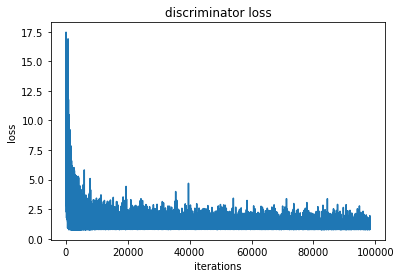

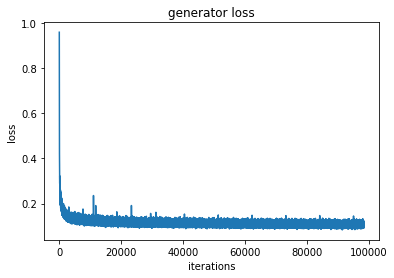

Step 98310: dloss = 0.8416, gloss = 0.1110, real_loss = 0.0151, fake_loss = 0.8265, gan_loss = 16739.2227 l1_loss = 0.0943
Step 98320: dloss = 0.8388, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8388, gan_loss = 16738.9727 l1_loss = 0.0891
Step 98330: dloss = 0.8496, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.8496, gan_loss = 16181.5430 l1_loss = 0.0811
Step 98340: dloss = 0.8654, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8654, gan_loss = 16426.1719 l1_loss = 0.0872
Step 98350: dloss = 0.8349, gloss = 0.1040, real_loss = 0.0001, fake_loss = 0.8348, gan_loss = 16634.3594 l1_loss = 0.0874
Step 98360: dloss = 0.8426, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8426, gan_loss = 15922.8086 l1_loss = 0.0902
Step 98370: dloss = 0.8208, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8208, gan_loss = 16476.1523 l1_loss = 0.0949
Step 98380: dloss = 0.8224, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8224, gan_loss = 16385.3789 l1_loss = 0.0934
Step 98390: dlos

Step 98980: dloss = 1.2940, gloss = 0.1014, real_loss = 0.4604, fake_loss = 0.8335, gan_loss = 16698.8691 l1_loss = 0.0847
Step 98990: dloss = 0.8329, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8329, gan_loss = 16894.9727 l1_loss = 0.0942
Step 99000: dloss = 0.8207, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.8207, gan_loss = 16973.3672 l1_loss = 0.0761
Step 99010: dloss = 0.8423, gloss = 0.1010, real_loss = 0.0000, fake_loss = 0.8423, gan_loss = 16879.8516 l1_loss = 0.0842
Step 99020: dloss = 0.8327, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8327, gan_loss = 16406.4023 l1_loss = 0.0891
Step 99030: dloss = 0.8191, gloss = 0.1141, real_loss = 0.0000, fake_loss = 0.8191, gan_loss = 16798.6836 l1_loss = 0.0973
Step 99040: dloss = 0.8069, gloss = 0.1217, real_loss = 0.0000, fake_loss = 0.8069, gan_loss = 16510.0449 l1_loss = 0.1051
Step 99050: dloss = 0.8551, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8551, gan_loss = 16520.3516 l1_loss = 0.0908
Step 99060: dlos

Step 99650: dloss = 0.8441, gloss = 0.1077, real_loss = 0.0321, fake_loss = 0.8120, gan_loss = 16514.2148 l1_loss = 0.0912
Step 99660: dloss = 0.8275, gloss = 0.1144, real_loss = 0.0000, fake_loss = 0.8275, gan_loss = 16707.9883 l1_loss = 0.0976
Step 99670: dloss = 0.8329, gloss = 0.1023, real_loss = 0.0001, fake_loss = 0.8328, gan_loss = 16651.5059 l1_loss = 0.0856
Step 99680: dloss = 0.8412, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8412, gan_loss = 16046.4844 l1_loss = 0.0888
Step 99690: dloss = 0.8488, gloss = 0.1184, real_loss = 0.0000, fake_loss = 0.8488, gan_loss = 16471.7930 l1_loss = 0.1019
Step 99700: dloss = 0.8348, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8348, gan_loss = 16971.6309 l1_loss = 0.0799
Step 99710: dloss = 0.9785, gloss = 0.1021, real_loss = 0.1262, fake_loss = 0.8523, gan_loss = 16940.5371 l1_loss = 0.0851
Step 99720: dloss = 0.8376, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.8376, gan_loss = 16500.4316 l1_loss = 0.0830
Step 99730: dlos

Step 100320: dloss = 0.8134, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8134, gan_loss = 16279.0615 l1_loss = 0.0915
Step 100330: dloss = 0.7860, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.7860, gan_loss = 16107.2051 l1_loss = 0.0882
Step 100340: dloss = 0.7969, gloss = 0.1135, real_loss = 0.0000, fake_loss = 0.7969, gan_loss = 17237.8203 l1_loss = 0.0963
Step 100350: dloss = 0.8498, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8498, gan_loss = 16371.6699 l1_loss = 0.0843
Step 100360: dloss = 0.9195, gloss = 0.1202, real_loss = 0.0722, fake_loss = 0.8473, gan_loss = 15596.9688 l1_loss = 0.1046
Step 100370: dloss = 0.8245, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8245, gan_loss = 16508.2793 l1_loss = 0.0933
Step 100380: dloss = 0.8371, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8371, gan_loss = 16630.9941 l1_loss = 0.0889
Step 100390: dloss = 0.8341, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.8341, gan_loss = 16766.0645 l1_loss = 0.0884
Step 100

Step 100990: dloss = 1.1764, gloss = 0.1163, real_loss = 0.3225, fake_loss = 0.8538, gan_loss = 16412.1074 l1_loss = 0.0999
Step 101000: dloss = 0.8370, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8370, gan_loss = 15869.4600 l1_loss = 0.0842
Step 101010: dloss = 0.8234, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8234, gan_loss = 16573.5781 l1_loss = 0.0856
Step 101020: dloss = 0.8458, gloss = 0.1143, real_loss = 0.0000, fake_loss = 0.8458, gan_loss = 16692.3770 l1_loss = 0.0976
Step 101030: dloss = 0.8315, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8315, gan_loss = 16538.5742 l1_loss = 0.0879
Step 101040: dloss = 0.8525, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8525, gan_loss = 16185.0801 l1_loss = 0.0931
Step 101050: dloss = 0.8494, gloss = 0.1093, real_loss = 0.0001, fake_loss = 0.8493, gan_loss = 16851.1504 l1_loss = 0.0924
Step 101060: dloss = 0.8196, gloss = 0.0920, real_loss = 0.0000, fake_loss = 0.8196, gan_loss = 16698.8203 l1_loss = 0.0753
Step 101

Step 101660: dloss = 0.8427, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8427, gan_loss = 15060.7598 l1_loss = 0.0898
Step 101670: dloss = 0.8165, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8165, gan_loss = 16147.4385 l1_loss = 0.0899
Step 101680: dloss = 0.8301, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8301, gan_loss = 16418.8145 l1_loss = 0.0942
Step 101690: dloss = 0.8272, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8272, gan_loss = 16277.7402 l1_loss = 0.0882
Step 101700: dloss = 0.8219, gloss = 0.1088, real_loss = 0.0016, fake_loss = 0.8203, gan_loss = 16132.6670 l1_loss = 0.0926
Step 101710: dloss = 0.8595, gloss = 0.0936, real_loss = 0.0000, fake_loss = 0.8595, gan_loss = 16586.4473 l1_loss = 0.0770
Step 101720: dloss = 0.8639, gloss = 0.1061, real_loss = 0.0165, fake_loss = 0.8475, gan_loss = 15709.4893 l1_loss = 0.0904
Step 101730: dloss = 0.8335, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8335, gan_loss = 16575.5605 l1_loss = 0.0923
Step 101

Step 102330: dloss = 0.8823, gloss = 0.0969, real_loss = 0.0469, fake_loss = 0.8354, gan_loss = 16294.1387 l1_loss = 0.0806
Step 102340: dloss = 0.8428, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8428, gan_loss = 16466.2520 l1_loss = 0.0866
Step 102350: dloss = 0.8560, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.8560, gan_loss = 16867.5996 l1_loss = 0.0871
Step 102360: dloss = 0.8560, gloss = 0.1098, real_loss = 0.0094, fake_loss = 0.8467, gan_loss = 16812.9023 l1_loss = 0.0930
Step 102370: dloss = 0.8211, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8211, gan_loss = 16104.0479 l1_loss = 0.0807
Step 102380: dloss = 0.8509, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8509, gan_loss = 16742.9922 l1_loss = 0.0886
Step 102390: dloss = 0.8537, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8537, gan_loss = 16171.6162 l1_loss = 0.0917
Step 102400: dloss = 0.8253, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8253, gan_loss = 15933.9512 l1_loss = 0.0946
Step 102

Step 103000: dloss = 0.8282, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.8282, gan_loss = 16340.6572 l1_loss = 0.0861
Step 103010: dloss = 0.8308, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8308, gan_loss = 16589.6758 l1_loss = 0.0917
Step 103020: dloss = 0.8586, gloss = 0.1005, real_loss = 0.0127, fake_loss = 0.8459, gan_loss = 16139.9316 l1_loss = 0.0843
Step 103030: dloss = 0.8542, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8542, gan_loss = 16168.2217 l1_loss = 0.0821
Step 103040: dloss = 0.8537, gloss = 0.1170, real_loss = 0.0000, fake_loss = 0.8537, gan_loss = 16793.4336 l1_loss = 0.1002
Step 103050: dloss = 0.8579, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8579, gan_loss = 16516.1562 l1_loss = 0.0855
Step 103060: dloss = 0.8152, gloss = 0.1086, real_loss = 0.0011, fake_loss = 0.8141, gan_loss = 16327.5742 l1_loss = 0.0922
Step 103070: dloss = 0.8144, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8144, gan_loss = 15122.4160 l1_loss = 0.0924
Step 103

Step 103670: dloss = 0.8110, gloss = 0.1135, real_loss = 0.0000, fake_loss = 0.8110, gan_loss = 16214.4668 l1_loss = 0.0973
Step 103680: dloss = 0.8050, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.8050, gan_loss = 16384.3496 l1_loss = 0.0939
Step 103690: dloss = 0.8210, gloss = 0.1109, real_loss = 0.0001, fake_loss = 0.8209, gan_loss = 16253.1865 l1_loss = 0.0947
Step 103700: dloss = 0.8241, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.8241, gan_loss = 15755.0859 l1_loss = 0.0858
Step 103710: dloss = 0.8476, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.8476, gan_loss = 15547.2764 l1_loss = 0.0887
Step 103720: dloss = 0.8667, gloss = 0.1031, real_loss = 0.0396, fake_loss = 0.8270, gan_loss = 16207.4873 l1_loss = 0.0869
Step 103730: dloss = 0.8498, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8498, gan_loss = 16111.2441 l1_loss = 0.0867
Step 103740: dloss = 0.8378, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.8378, gan_loss = 16221.9805 l1_loss = 0.0866
Step 103

Step 104340: dloss = 0.8523, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.8523, gan_loss = 16223.6670 l1_loss = 0.0796
Step 104350: dloss = 1.3181, gloss = 0.1064, real_loss = 0.4516, fake_loss = 0.8666, gan_loss = 16138.5283 l1_loss = 0.0903
Step 104360: dloss = 0.8429, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.8429, gan_loss = 16219.0225 l1_loss = 0.0823
Step 104370: dloss = 0.8380, gloss = 0.1124, real_loss = 0.0014, fake_loss = 0.8366, gan_loss = 16034.8652 l1_loss = 0.0964
Step 104380: dloss = 0.8338, gloss = 0.1122, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 15902.8350 l1_loss = 0.0963
Step 104390: dloss = 1.0825, gloss = 0.1097, real_loss = 0.2732, fake_loss = 0.8092, gan_loss = 16180.4980 l1_loss = 0.0935
Step 104400: dloss = 0.8054, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 16281.6123 l1_loss = 0.0924
Step 104410: dloss = 0.8226, gloss = 0.0950, real_loss = 0.0016, fake_loss = 0.8210, gan_loss = 16576.6016 l1_loss = 0.0785
Step 104

Step 105010: dloss = 0.9689, gloss = 0.1041, real_loss = 0.1141, fake_loss = 0.8548, gan_loss = 16038.5977 l1_loss = 0.0880
Step 105020: dloss = 0.7933, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.7933, gan_loss = 16692.7812 l1_loss = 0.0947
Step 105030: dloss = 0.8036, gloss = 0.1089, real_loss = 0.0008, fake_loss = 0.8028, gan_loss = 16362.1914 l1_loss = 0.0925
Step 105040: dloss = 1.7795, gloss = 0.0995, real_loss = 0.9474, fake_loss = 0.8321, gan_loss = 15756.2803 l1_loss = 0.0837
Step 105050: dloss = 0.8277, gloss = 0.1080, real_loss = 0.0005, fake_loss = 0.8272, gan_loss = 16442.8535 l1_loss = 0.0916
Step 105060: dloss = 0.8395, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8395, gan_loss = 15189.1650 l1_loss = 0.0871
Step 105070: dloss = 0.8168, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 16445.8008 l1_loss = 0.0966
Step 105080: dloss = 0.8333, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8333, gan_loss = 15900.3486 l1_loss = 0.0847
Step 105

Step 105680: dloss = 0.8070, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8070, gan_loss = 15354.8057 l1_loss = 0.0825
Step 105690: dloss = 0.8684, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.8684, gan_loss = 16399.5742 l1_loss = 0.0921
Step 105700: dloss = 0.8319, gloss = 0.0987, real_loss = 0.0007, fake_loss = 0.8312, gan_loss = 15874.4912 l1_loss = 0.0828
Step 105710: dloss = 0.8357, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8356, gan_loss = 15737.4795 l1_loss = 0.0869
Step 105720: dloss = 0.8271, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8271, gan_loss = 15722.6553 l1_loss = 0.0842
Step 105730: dloss = 0.8216, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8216, gan_loss = 15802.7637 l1_loss = 0.0905
Step 105740: dloss = 0.8032, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8032, gan_loss = 16280.5518 l1_loss = 0.0968
Step 105750: dloss = 0.8207, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.8207, gan_loss = 16492.0020 l1_loss = 0.0867
Step 105

Step 106350: dloss = 0.8343, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8343, gan_loss = 15642.2207 l1_loss = 0.0955
Step 106360: dloss = 0.8417, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.8417, gan_loss = 16232.8115 l1_loss = 0.0785
Step 106370: dloss = 0.8258, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8258, gan_loss = 16335.5635 l1_loss = 0.0834
Step 106380: dloss = 0.9073, gloss = 0.1213, real_loss = 0.0768, fake_loss = 0.8305, gan_loss = 16276.7734 l1_loss = 0.1050
Step 106390: dloss = 0.8272, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.8272, gan_loss = 15895.7324 l1_loss = 0.0883
Step 106400: dloss = 0.8331, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8331, gan_loss = 16332.6748 l1_loss = 0.0900
Step 106410: dloss = 0.8487, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.8487, gan_loss = 16045.6035 l1_loss = 0.0878
Step 106420: dloss = 0.9877, gloss = 0.0981, real_loss = 0.1518, fake_loss = 0.8359, gan_loss = 16098.3066 l1_loss = 0.0820
Step 106

Step 107020: dloss = 0.8131, gloss = 0.0906, real_loss = 0.0000, fake_loss = 0.8131, gan_loss = 16178.8330 l1_loss = 0.0744
Step 107030: dloss = 0.8336, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8336, gan_loss = 16152.8525 l1_loss = 0.0836
Step 107040: dloss = 0.8368, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8368, gan_loss = 15423.0859 l1_loss = 0.0844
Step 107050: dloss = 0.8193, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8193, gan_loss = 15982.1553 l1_loss = 0.0877
Step 107060: dloss = 0.7880, gloss = 0.0951, real_loss = 0.0000, fake_loss = 0.7880, gan_loss = 15572.4775 l1_loss = 0.0795
Step 107070: dloss = 1.4768, gloss = 0.1114, real_loss = 0.6558, fake_loss = 0.8211, gan_loss = 15497.2285 l1_loss = 0.0959
Step 107080: dloss = 1.3175, gloss = 0.0981, real_loss = 0.4875, fake_loss = 0.8301, gan_loss = 15749.6250 l1_loss = 0.0824
Step 107090: dloss = 0.8350, gloss = 0.0944, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 16112.5742 l1_loss = 0.0783
Step 107

Step 107690: dloss = 0.8336, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.8336, gan_loss = 15944.4736 l1_loss = 0.0967
Step 107700: dloss = 0.8287, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8287, gan_loss = 15514.6006 l1_loss = 0.0947
Step 107710: dloss = 0.8074, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8074, gan_loss = 15976.3818 l1_loss = 0.0877
Step 107720: dloss = 0.9661, gloss = 0.1090, real_loss = 0.1484, fake_loss = 0.8177, gan_loss = 15609.2852 l1_loss = 0.0934
Step 107730: dloss = 0.8436, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8436, gan_loss = 15850.5830 l1_loss = 0.0938
Step 107740: dloss = 0.8322, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8322, gan_loss = 16276.3213 l1_loss = 0.0890
Step 107750: dloss = 0.8232, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8232, gan_loss = 15823.6553 l1_loss = 0.0898
Step 107760: dloss = 0.8462, gloss = 0.1113, real_loss = 0.0002, fake_loss = 0.8460, gan_loss = 15235.4883 l1_loss = 0.0961
Step 107

Step 108360: dloss = 0.8472, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8472, gan_loss = 15268.0605 l1_loss = 0.0930
Step 108370: dloss = 0.8147, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8147, gan_loss = 16071.9883 l1_loss = 0.0905
Step 108380: dloss = 0.8242, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 16121.3906 l1_loss = 0.0868
Step 108390: dloss = 0.8646, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8646, gan_loss = 15694.6201 l1_loss = 0.0901
Step 108400: dloss = 0.8040, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8040, gan_loss = 16056.9199 l1_loss = 0.0936
Step 108410: dloss = 0.8498, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8498, gan_loss = 15673.7666 l1_loss = 0.0942
Step 108420: dloss = 0.8298, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8298, gan_loss = 14542.2930 l1_loss = 0.0954
Step 108430: dloss = 0.8423, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8423, gan_loss = 15892.9717 l1_loss = 0.0833
Step 108

Step 109030: dloss = 0.8101, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8101, gan_loss = 15242.2344 l1_loss = 0.0903
Step 109040: dloss = 0.8439, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8439, gan_loss = 15838.3584 l1_loss = 0.0931
Step 109050: dloss = 0.8169, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8169, gan_loss = 15946.5635 l1_loss = 0.0943
Step 109060: dloss = 0.8345, gloss = 0.0972, real_loss = 0.0001, fake_loss = 0.8344, gan_loss = 15645.5459 l1_loss = 0.0816
Step 109070: dloss = 0.8115, gloss = 0.0922, real_loss = 0.0000, fake_loss = 0.8115, gan_loss = 15577.3936 l1_loss = 0.0766
Step 109080: dloss = 0.8338, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 15369.7656 l1_loss = 0.0873
Step 109090: dloss = 1.0665, gloss = 0.0958, real_loss = 0.2467, fake_loss = 0.8198, gan_loss = 14748.3799 l1_loss = 0.0811
Step 109100: dloss = 0.8243, gloss = 0.0962, real_loss = 0.0000, fake_loss = 0.8243, gan_loss = 15583.4014 l1_loss = 0.0806
Step 109

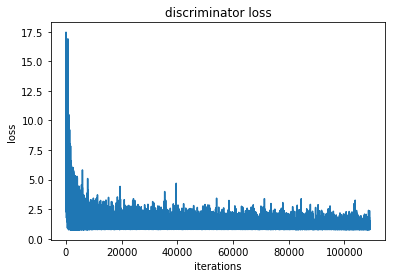

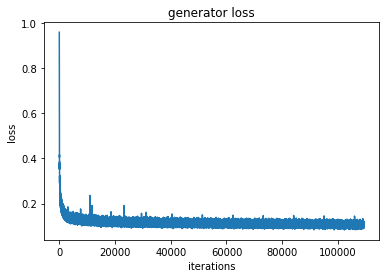

Step 109240: dloss = 1.0438, gloss = 0.1073, real_loss = 0.2115, fake_loss = 0.8323, gan_loss = 15554.1992 l1_loss = 0.0918
Step 109250: dloss = 0.8435, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8435, gan_loss = 14891.4502 l1_loss = 0.0880
Step 109260: dloss = 1.0412, gloss = 0.1019, real_loss = 0.2156, fake_loss = 0.8255, gan_loss = 15863.5225 l1_loss = 0.0860
Step 109270: dloss = 0.8139, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.8139, gan_loss = 15378.0508 l1_loss = 0.0886
Step 109280: dloss = 0.8145, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.8145, gan_loss = 16006.9941 l1_loss = 0.0924
Step 109290: dloss = 0.8236, gloss = 0.1104, real_loss = 0.0000, fake_loss = 0.8236, gan_loss = 15513.8193 l1_loss = 0.0949
Step 109300: dloss = 0.8116, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8116, gan_loss = 15424.5801 l1_loss = 0.0929
Step 109310: dloss = 0.8417, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.8417, gan_loss = 15490.0801 l1_loss = 0.0887
Step 109

Step 109910: dloss = 0.8352, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8352, gan_loss = 15530.7666 l1_loss = 0.0888
Step 109920: dloss = 0.8485, gloss = 0.0970, real_loss = 0.0021, fake_loss = 0.8464, gan_loss = 16328.1641 l1_loss = 0.0807
Step 109930: dloss = 0.8366, gloss = 0.1120, real_loss = 0.0000, fake_loss = 0.8366, gan_loss = 16017.3398 l1_loss = 0.0960
Step 109940: dloss = 0.8461, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8461, gan_loss = 15894.3037 l1_loss = 0.0868
Step 109950: dloss = 0.8567, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8567, gan_loss = 16043.2754 l1_loss = 0.0875
Step 109960: dloss = 0.8276, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.8276, gan_loss = 16020.6914 l1_loss = 0.0854
Step 109970: dloss = 0.8249, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8249, gan_loss = 15747.6455 l1_loss = 0.0864
Step 109980: dloss = 0.8190, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.8190, gan_loss = 15657.0674 l1_loss = 0.0977
Step 109

Step 110580: dloss = 0.8335, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8335, gan_loss = 15587.1621 l1_loss = 0.0915
Step 110590: dloss = 0.8546, gloss = 0.1141, real_loss = 0.0277, fake_loss = 0.8269, gan_loss = 16120.8877 l1_loss = 0.0980
Step 110600: dloss = 0.8254, gloss = 0.1272, real_loss = 0.0000, fake_loss = 0.8254, gan_loss = 15135.3818 l1_loss = 0.1120
Step 110610: dloss = 0.8408, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8408, gan_loss = 15680.1602 l1_loss = 0.0913
Step 110620: dloss = 0.8164, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8164, gan_loss = 15558.8496 l1_loss = 0.0818
Step 110630: dloss = 0.8277, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8277, gan_loss = 14813.3574 l1_loss = 0.0921
Step 110640: dloss = 0.8114, gloss = 0.1077, real_loss = 0.0000, fake_loss = 0.8114, gan_loss = 15513.8545 l1_loss = 0.0922
Step 110650: dloss = 0.8182, gloss = 0.1167, real_loss = 0.0000, fake_loss = 0.8182, gan_loss = 15324.0254 l1_loss = 0.1013
Step 110

Step 111250: dloss = 0.8364, gloss = 0.1105, real_loss = 0.0000, fake_loss = 0.8364, gan_loss = 15234.5693 l1_loss = 0.0952
Step 111260: dloss = 0.8367, gloss = 0.1138, real_loss = 0.0012, fake_loss = 0.8355, gan_loss = 15583.6191 l1_loss = 0.0982
Step 111270: dloss = 0.8515, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8515, gan_loss = 15955.4170 l1_loss = 0.0909
Step 111280: dloss = 0.8303, gloss = 0.1002, real_loss = 0.0008, fake_loss = 0.8295, gan_loss = 15787.9004 l1_loss = 0.0844
Step 111290: dloss = 0.8383, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 14738.3525 l1_loss = 0.0864
Step 111300: dloss = 0.8602, gloss = 0.0933, real_loss = 0.0000, fake_loss = 0.8602, gan_loss = 14862.9932 l1_loss = 0.0785
Step 111310: dloss = 0.8555, gloss = 0.0951, real_loss = 0.0001, fake_loss = 0.8554, gan_loss = 15821.1836 l1_loss = 0.0793
Step 111320: dloss = 0.8405, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.8405, gan_loss = 15066.5635 l1_loss = 0.0796
Step 111

Step 111920: dloss = 0.8414, gloss = 0.1034, real_loss = 0.0070, fake_loss = 0.8344, gan_loss = 15273.5850 l1_loss = 0.0881
Step 111930: dloss = 0.8310, gloss = 0.1216, real_loss = 0.0000, fake_loss = 0.8310, gan_loss = 15591.3604 l1_loss = 0.1060
Step 111940: dloss = 0.8643, gloss = 0.0870, real_loss = 0.0000, fake_loss = 0.8643, gan_loss = 15167.2549 l1_loss = 0.0718
Step 111950: dloss = 0.8175, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8175, gan_loss = 15454.5371 l1_loss = 0.0849
Step 111960: dloss = 1.4323, gloss = 0.0980, real_loss = 0.6195, fake_loss = 0.8128, gan_loss = 15020.5703 l1_loss = 0.0830
Step 111970: dloss = 0.8090, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8090, gan_loss = 15201.9590 l1_loss = 0.0848
Step 111980: dloss = 0.8667, gloss = 0.0972, real_loss = 0.0127, fake_loss = 0.8540, gan_loss = 15537.8789 l1_loss = 0.0817
Step 111990: dloss = 0.8237, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8237, gan_loss = 15797.7168 l1_loss = 0.0935
Step 112

Step 112590: dloss = 0.8149, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.8149, gan_loss = 14940.8564 l1_loss = 0.0908
Step 112600: dloss = 0.8217, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8217, gan_loss = 16121.8662 l1_loss = 0.0909
Step 112610: dloss = 0.8313, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8313, gan_loss = 15405.9600 l1_loss = 0.0901
Step 112620: dloss = 0.8140, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8140, gan_loss = 15380.1787 l1_loss = 0.0835
Step 112630: dloss = 0.8369, gloss = 0.0894, real_loss = 0.0004, fake_loss = 0.8365, gan_loss = 15878.6377 l1_loss = 0.0736
Step 112640: dloss = 0.8446, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8446, gan_loss = 15125.7900 l1_loss = 0.0831
Step 112650: dloss = 0.8231, gloss = 0.1113, real_loss = 0.0000, fake_loss = 0.8231, gan_loss = 15521.1592 l1_loss = 0.0957
Step 112660: dloss = 0.8090, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8090, gan_loss = 15355.7764 l1_loss = 0.0902
Step 112

Step 113260: dloss = 0.8252, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8252, gan_loss = 15374.2744 l1_loss = 0.0867
Step 113270: dloss = 0.8391, gloss = 0.1203, real_loss = 0.0000, fake_loss = 0.8391, gan_loss = 14805.8564 l1_loss = 0.1055
Step 113280: dloss = 0.8030, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8030, gan_loss = 15166.1602 l1_loss = 0.0934
Step 113290: dloss = 1.5698, gloss = 0.1036, real_loss = 0.7691, fake_loss = 0.8007, gan_loss = 14437.5791 l1_loss = 0.0892
Step 113300: dloss = 0.8105, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.8105, gan_loss = 14674.5488 l1_loss = 0.0812
Step 113310: dloss = 0.8499, gloss = 0.1132, real_loss = 0.0000, fake_loss = 0.8499, gan_loss = 15190.6201 l1_loss = 0.0980
Step 113320: dloss = 0.8296, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.8296, gan_loss = 15174.8340 l1_loss = 0.0959
Step 113330: dloss = 0.8341, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8341, gan_loss = 15493.9336 l1_loss = 0.0934
Step 113

Step 113930: dloss = 1.2479, gloss = 0.1015, real_loss = 0.4079, fake_loss = 0.8400, gan_loss = 15458.5078 l1_loss = 0.0861
Step 113940: dloss = 0.8339, gloss = 0.0986, real_loss = 0.0018, fake_loss = 0.8321, gan_loss = 14331.1699 l1_loss = 0.0843
Step 113950: dloss = 0.8131, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8131, gan_loss = 15755.2549 l1_loss = 0.0905
Step 113960: dloss = 0.7919, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.7919, gan_loss = 15345.6807 l1_loss = 0.0913
Step 113970: dloss = 0.8070, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8070, gan_loss = 15095.1133 l1_loss = 0.0909
Step 113980: dloss = 0.8429, gloss = 0.1115, real_loss = 0.0135, fake_loss = 0.8295, gan_loss = 14999.0430 l1_loss = 0.0965
Step 113990: dloss = 0.8638, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8638, gan_loss = 14606.1953 l1_loss = 0.0899
Step 114000: dloss = 0.8242, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 15767.7695 l1_loss = 0.0802
Step 114

Step 114600: dloss = 0.7936, gloss = 0.1234, real_loss = 0.0000, fake_loss = 0.7936, gan_loss = 14903.4092 l1_loss = 0.1085
Step 114610: dloss = 0.8274, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8274, gan_loss = 15077.5625 l1_loss = 0.0931
Step 114620: dloss = 0.8136, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8136, gan_loss = 14877.5781 l1_loss = 0.0874
Step 114630: dloss = 0.8377, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8377, gan_loss = 15388.3203 l1_loss = 0.0882
Step 114640: dloss = 0.8530, gloss = 0.1119, real_loss = 0.0000, fake_loss = 0.8530, gan_loss = 15383.7705 l1_loss = 0.0965
Step 114650: dloss = 0.8178, gloss = 0.1147, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 15207.2129 l1_loss = 0.0995
Step 114660: dloss = 0.7950, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7950, gan_loss = 14931.8672 l1_loss = 0.0878
Step 114670: dloss = 0.8148, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8148, gan_loss = 15213.8682 l1_loss = 0.0909
Step 114

Step 115270: dloss = 0.8305, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8305, gan_loss = 14959.5752 l1_loss = 0.0914
Step 115280: dloss = 0.8400, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8400, gan_loss = 15097.2021 l1_loss = 0.0930
Step 115290: dloss = 0.8370, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8370, gan_loss = 15283.1064 l1_loss = 0.0889
Step 115300: dloss = 0.8374, gloss = 0.0946, real_loss = 0.0000, fake_loss = 0.8374, gan_loss = 15379.6943 l1_loss = 0.0792
Step 115310: dloss = 0.9081, gloss = 0.1143, real_loss = 0.0611, fake_loss = 0.8470, gan_loss = 14229.3555 l1_loss = 0.1001
Step 115320: dloss = 0.8346, gloss = 0.1105, real_loss = 0.0000, fake_loss = 0.8346, gan_loss = 15358.3408 l1_loss = 0.0951
Step 115330: dloss = 0.8322, gloss = 0.1067, real_loss = 0.0000, fake_loss = 0.8322, gan_loss = 14051.4551 l1_loss = 0.0927
Step 115340: dloss = 0.8379, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8379, gan_loss = 14702.1758 l1_loss = 0.0916
Step 115

Step 115940: dloss = 0.8289, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8289, gan_loss = 15078.5732 l1_loss = 0.0911
Step 115950: dloss = 0.8385, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8385, gan_loss = 15016.1768 l1_loss = 0.0842
Step 115960: dloss = 0.8262, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8262, gan_loss = 15010.6875 l1_loss = 0.0855
Step 115970: dloss = 0.8199, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8199, gan_loss = 15552.1934 l1_loss = 0.0824
Step 115980: dloss = 2.0187, gloss = 0.1071, real_loss = 1.2009, fake_loss = 0.8178, gan_loss = 14919.3857 l1_loss = 0.0922
Step 115990: dloss = 1.4216, gloss = 0.1107, real_loss = 0.5869, fake_loss = 0.8348, gan_loss = 15176.1963 l1_loss = 0.0955
Step 116000: dloss = 0.8335, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8335, gan_loss = 15104.9531 l1_loss = 0.0930
Step 116010: dloss = 0.8500, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8500, gan_loss = 14806.2227 l1_loss = 0.0910
Step 116

Step 116610: dloss = 0.8270, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8270, gan_loss = 15210.2705 l1_loss = 0.0877
Step 116620: dloss = 0.8331, gloss = 0.0911, real_loss = 0.0000, fake_loss = 0.8331, gan_loss = 15646.6953 l1_loss = 0.0754
Step 116630: dloss = 0.7972, gloss = 0.1003, real_loss = 0.0012, fake_loss = 0.7960, gan_loss = 15355.4121 l1_loss = 0.0849
Step 116640: dloss = 0.8328, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.8328, gan_loss = 14991.9043 l1_loss = 0.0902
Step 116650: dloss = 0.8459, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8459, gan_loss = 14868.1504 l1_loss = 0.0871
Step 116660: dloss = 0.7923, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.7923, gan_loss = 14914.9961 l1_loss = 0.0904
Step 116670: dloss = 0.8076, gloss = 0.1208, real_loss = 0.0000, fake_loss = 0.8076, gan_loss = 14977.0645 l1_loss = 0.1058
Step 116680: dloss = 0.8156, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.8156, gan_loss = 14998.8457 l1_loss = 0.0959
Step 116

Step 117280: dloss = 0.8033, gloss = 0.1139, real_loss = 0.0000, fake_loss = 0.8033, gan_loss = 15000.5312 l1_loss = 0.0989
Step 117290: dloss = 0.8101, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8101, gan_loss = 15200.3291 l1_loss = 0.0945
Step 117300: dloss = 0.8501, gloss = 0.0926, real_loss = 0.0000, fake_loss = 0.8501, gan_loss = 15290.9971 l1_loss = 0.0773
Step 117310: dloss = 0.8054, gloss = 0.0819, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 14840.6963 l1_loss = 0.0670
Step 117320: dloss = 2.0892, gloss = 0.0989, real_loss = 1.2550, fake_loss = 0.8342, gan_loss = 14742.9053 l1_loss = 0.0841
Step 117330: dloss = 0.8337, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8337, gan_loss = 14815.4951 l1_loss = 0.0927
Step 117340: dloss = 0.8278, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 15342.5332 l1_loss = 0.0803
Step 117350: dloss = 1.0797, gloss = 0.1148, real_loss = 0.2710, fake_loss = 0.8087, gan_loss = 14450.7285 l1_loss = 0.1003
Step 117

Step 117950: dloss = 1.0432, gloss = 0.1034, real_loss = 0.1617, fake_loss = 0.8815, gan_loss = 14989.5928 l1_loss = 0.0884
Step 117960: dloss = 0.8220, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8220, gan_loss = 15517.8926 l1_loss = 0.0902
Step 117970: dloss = 0.8303, gloss = 0.1011, real_loss = 0.0000, fake_loss = 0.8303, gan_loss = 14959.6807 l1_loss = 0.0861
Step 117980: dloss = 0.8156, gloss = 0.1057, real_loss = 0.0029, fake_loss = 0.8127, gan_loss = 15084.2637 l1_loss = 0.0906
Step 117990: dloss = 0.8279, gloss = 0.0986, real_loss = 0.0000, fake_loss = 0.8279, gan_loss = 15022.5557 l1_loss = 0.0836
Step 118000: dloss = 0.8221, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8221, gan_loss = 15281.8037 l1_loss = 0.0853
Step 118010: dloss = 0.8174, gloss = 0.1153, real_loss = 0.0000, fake_loss = 0.8174, gan_loss = 15002.8613 l1_loss = 0.1003
Step 118020: dloss = 0.7886, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.7886, gan_loss = 14697.4893 l1_loss = 0.0855
Step 118

Step 118620: dloss = 0.7994, gloss = 0.0886, real_loss = 0.0000, fake_loss = 0.7994, gan_loss = 15271.0771 l1_loss = 0.0733
Step 118630: dloss = 0.8248, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8248, gan_loss = 15162.3291 l1_loss = 0.0922
Step 118640: dloss = 0.8278, gloss = 0.1129, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 14930.8672 l1_loss = 0.0979
Step 118650: dloss = 0.8402, gloss = 0.1096, real_loss = 0.0000, fake_loss = 0.8402, gan_loss = 14120.4268 l1_loss = 0.0955
Step 118660: dloss = 0.8377, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8377, gan_loss = 15175.0176 l1_loss = 0.0870
Step 118670: dloss = 0.8256, gloss = 0.0981, real_loss = 0.0193, fake_loss = 0.8063, gan_loss = 14642.1270 l1_loss = 0.0835
Step 118680: dloss = 0.9273, gloss = 0.0978, real_loss = 0.1241, fake_loss = 0.8032, gan_loss = 15095.3330 l1_loss = 0.0827
Step 118690: dloss = 0.8121, gloss = 0.1018, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 14702.9697 l1_loss = 0.0871
Step 118

Step 119290: dloss = 0.8214, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8214, gan_loss = 14953.4541 l1_loss = 0.0844
Step 119300: dloss = 0.8372, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8372, gan_loss = 14365.7568 l1_loss = 0.0838
Step 119310: dloss = 0.9321, gloss = 0.1026, real_loss = 0.0921, fake_loss = 0.8400, gan_loss = 14598.1123 l1_loss = 0.0880
Step 119320: dloss = 0.8168, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 15054.2061 l1_loss = 0.0917
Step 119330: dloss = 0.8286, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8286, gan_loss = 14904.1055 l1_loss = 0.0880
Step 119340: dloss = 0.8077, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8077, gan_loss = 14985.5664 l1_loss = 0.0916
Step 119350: dloss = 0.8182, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8182, gan_loss = 14964.4756 l1_loss = 0.0910
Step 119360: dloss = 1.2733, gloss = 0.0969, real_loss = 0.4121, fake_loss = 0.8612, gan_loss = 14328.4658 l1_loss = 0.0825
Step 119

Step 119960: dloss = 0.8158, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8158, gan_loss = 14341.7705 l1_loss = 0.0934
Step 119970: dloss = 0.8435, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8435, gan_loss = 15075.6982 l1_loss = 0.0814
Step 119980: dloss = 0.7958, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.7958, gan_loss = 14831.9863 l1_loss = 0.0893
Step 119990: dloss = 0.8168, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 14748.4062 l1_loss = 0.0851
Step 120000: dloss = 0.8465, gloss = 0.1151, real_loss = 0.0000, fake_loss = 0.8465, gan_loss = 14695.9775 l1_loss = 0.1004
Step 120010: dloss = 0.7971, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.7971, gan_loss = 14899.2207 l1_loss = 0.0854
Step 120020: dloss = 0.8070, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8070, gan_loss = 15293.9902 l1_loss = 0.0933
Step 120030: dloss = 0.8014, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8014, gan_loss = 14749.3193 l1_loss = 0.0880
Step 120

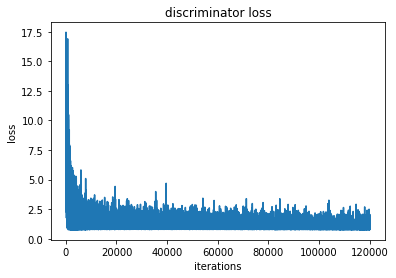

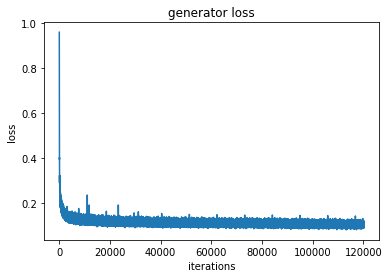

Step 120160: dloss = 0.8246, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8246, gan_loss = 14363.6572 l1_loss = 0.0823
Step 120170: dloss = 0.8409, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.8409, gan_loss = 15376.0557 l1_loss = 0.0922
Step 120180: dloss = 0.8170, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8170, gan_loss = 14976.1943 l1_loss = 0.0872
Step 120190: dloss = 0.8562, gloss = 0.0916, real_loss = 0.0000, fake_loss = 0.8562, gan_loss = 14833.3105 l1_loss = 0.0767
Step 120200: dloss = 0.8267, gloss = 0.0949, real_loss = 0.0000, fake_loss = 0.8267, gan_loss = 15030.6621 l1_loss = 0.0798
Step 120210: dloss = 0.8032, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8032, gan_loss = 14247.1738 l1_loss = 0.0893
Step 120220: dloss = 0.8066, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8066, gan_loss = 14399.5938 l1_loss = 0.0870
Step 120230: dloss = 0.8411, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.8411, gan_loss = 14639.8682 l1_loss = 0.0784
Step 120

Step 120830: dloss = 0.8373, gloss = 0.0915, real_loss = 0.0000, fake_loss = 0.8373, gan_loss = 14858.5732 l1_loss = 0.0766
Step 120840: dloss = 0.8111, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.8111, gan_loss = 14552.8340 l1_loss = 0.0874
Step 120850: dloss = 0.8245, gloss = 0.1121, real_loss = 0.0000, fake_loss = 0.8245, gan_loss = 14764.1260 l1_loss = 0.0973
Step 120860: dloss = 0.8188, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8188, gan_loss = 14653.8701 l1_loss = 0.0889
Step 120870: dloss = 0.8536, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8536, gan_loss = 15002.2324 l1_loss = 0.0900
Step 120880: dloss = 0.8352, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.8352, gan_loss = 14878.0615 l1_loss = 0.0799
Step 120890: dloss = 1.2197, gloss = 0.1020, real_loss = 0.4017, fake_loss = 0.8180, gan_loss = 14191.3301 l1_loss = 0.0878
Step 120900: dloss = 0.8054, gloss = 0.1238, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 15022.4473 l1_loss = 0.1088
Step 120

Step 121500: dloss = 0.7934, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.7934, gan_loss = 14794.8740 l1_loss = 0.0830
Step 121510: dloss = 0.8272, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8272, gan_loss = 15021.8525 l1_loss = 0.0848
Step 121520: dloss = 0.8015, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8015, gan_loss = 14313.7969 l1_loss = 0.0898
Step 121530: dloss = 0.8070, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.8070, gan_loss = 14661.2256 l1_loss = 0.0872
Step 121540: dloss = 0.8056, gloss = 0.1010, real_loss = 0.0000, fake_loss = 0.8056, gan_loss = 14799.6572 l1_loss = 0.0862
Step 121550: dloss = 0.8401, gloss = 0.1172, real_loss = 0.0145, fake_loss = 0.8256, gan_loss = 14792.9697 l1_loss = 0.1024
Step 121560: dloss = 0.7949, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.7949, gan_loss = 14865.9688 l1_loss = 0.0955
Step 121570: dloss = 0.8167, gloss = 0.1096, real_loss = 0.0000, fake_loss = 0.8167, gan_loss = 15026.0332 l1_loss = 0.0946
Step 121

Step 122170: dloss = 0.7853, gloss = 0.1108, real_loss = 0.0000, fake_loss = 0.7853, gan_loss = 14566.2412 l1_loss = 0.0962
Step 122180: dloss = 0.8409, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8409, gan_loss = 15155.0557 l1_loss = 0.0921
Step 122190: dloss = 0.8424, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8424, gan_loss = 14746.4023 l1_loss = 0.0954
Step 122200: dloss = 0.8126, gloss = 0.1189, real_loss = 0.0000, fake_loss = 0.8126, gan_loss = 14702.4873 l1_loss = 0.1042
Step 122210: dloss = 0.8338, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 14980.8643 l1_loss = 0.0931
Step 122220: dloss = 0.8465, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.8465, gan_loss = 14768.2686 l1_loss = 0.0824
Step 122230: dloss = 1.1893, gloss = 0.0926, real_loss = 0.3657, fake_loss = 0.8235, gan_loss = 14187.2754 l1_loss = 0.0784
Step 122240: dloss = 0.8098, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8098, gan_loss = 14747.5684 l1_loss = 0.0911
Step 122

Step 122840: dloss = 0.8037, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8037, gan_loss = 14860.4893 l1_loss = 0.0917
Step 122850: dloss = 0.8488, gloss = 0.0961, real_loss = 0.0001, fake_loss = 0.8488, gan_loss = 14535.0693 l1_loss = 0.0816
Step 122860: dloss = 0.8504, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8504, gan_loss = 14735.3398 l1_loss = 0.0916
Step 122870: dloss = 0.8621, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8621, gan_loss = 14641.2168 l1_loss = 0.0836
Step 122880: dloss = 0.8042, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8042, gan_loss = 14483.5234 l1_loss = 0.0909
Step 122890: dloss = 1.0578, gloss = 0.1139, real_loss = 0.2410, fake_loss = 0.8168, gan_loss = 13943.4824 l1_loss = 0.1000
Step 122900: dloss = 0.8038, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8038, gan_loss = 14325.7334 l1_loss = 0.0826
Step 122910: dloss = 0.8250, gloss = 0.0944, real_loss = 0.0000, fake_loss = 0.8250, gan_loss = 14809.3916 l1_loss = 0.0796
Step 122

Step 123510: dloss = 0.8093, gloss = 0.0986, real_loss = 0.0000, fake_loss = 0.8093, gan_loss = 14531.3945 l1_loss = 0.0841
Step 123520: dloss = 0.8284, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8284, gan_loss = 14092.5830 l1_loss = 0.0856
Step 123530: dloss = 0.8502, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8502, gan_loss = 14282.0391 l1_loss = 0.0883
Step 123540: dloss = 0.8218, gloss = 0.0977, real_loss = 0.0000, fake_loss = 0.8218, gan_loss = 14754.9453 l1_loss = 0.0830
Step 123550: dloss = 0.8256, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.8256, gan_loss = 14886.2207 l1_loss = 0.0908
Step 123560: dloss = 1.5171, gloss = 0.0917, real_loss = 0.6780, fake_loss = 0.8391, gan_loss = 14405.7822 l1_loss = 0.0773
Step 123570: dloss = 0.8356, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.8356, gan_loss = 14403.5039 l1_loss = 0.0947
Step 123580: dloss = 0.8300, gloss = 0.0923, real_loss = 0.0000, fake_loss = 0.8300, gan_loss = 14467.2227 l1_loss = 0.0778
Step 123

Step 124180: dloss = 0.8176, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 14607.7285 l1_loss = 0.0814
Step 124190: dloss = 0.8581, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8581, gan_loss = 13342.7734 l1_loss = 0.0863
Step 124200: dloss = 0.8415, gloss = 0.0961, real_loss = 0.0000, fake_loss = 0.8415, gan_loss = 14076.1924 l1_loss = 0.0820
Step 124210: dloss = 0.8183, gloss = 0.1143, real_loss = 0.0000, fake_loss = 0.8183, gan_loss = 14621.4600 l1_loss = 0.0997
Step 124220: dloss = 0.8148, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8148, gan_loss = 14299.6904 l1_loss = 0.0913
Step 124230: dloss = 0.8295, gloss = 0.1013, real_loss = 0.0000, fake_loss = 0.8295, gan_loss = 14632.1240 l1_loss = 0.0867
Step 124240: dloss = 0.8264, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8264, gan_loss = 13887.7002 l1_loss = 0.0916
Step 124250: dloss = 0.8276, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8276, gan_loss = 14257.7031 l1_loss = 0.0943
Step 124

Step 124850: dloss = 0.8282, gloss = 0.1149, real_loss = 0.0000, fake_loss = 0.8282, gan_loss = 14292.8418 l1_loss = 0.1006
Step 124860: dloss = 0.8224, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8224, gan_loss = 14384.3057 l1_loss = 0.0826
Step 124870: dloss = 1.0381, gloss = 0.1019, real_loss = 0.2329, fake_loss = 0.8053, gan_loss = 14039.3145 l1_loss = 0.0879
Step 124880: dloss = 0.8099, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8099, gan_loss = 14679.0420 l1_loss = 0.0909
Step 124890: dloss = 0.8318, gloss = 0.1027, real_loss = 0.0117, fake_loss = 0.8202, gan_loss = 14435.3457 l1_loss = 0.0882
Step 124900: dloss = 0.8245, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.8245, gan_loss = 14466.6836 l1_loss = 0.0790
Step 124910: dloss = 0.8315, gloss = 0.1067, real_loss = 0.0000, fake_loss = 0.8315, gan_loss = 14194.2490 l1_loss = 0.0925
Step 124920: dloss = 0.8034, gloss = 0.1092, real_loss = 0.0000, fake_loss = 0.8034, gan_loss = 14398.6162 l1_loss = 0.0948
Step 124

Step 125520: dloss = 0.8266, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8266, gan_loss = 13783.2354 l1_loss = 0.0964
Step 125530: dloss = 0.8007, gloss = 0.1050, real_loss = 0.0013, fake_loss = 0.7994, gan_loss = 14382.0820 l1_loss = 0.0906
Step 125540: dloss = 0.8265, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.8265, gan_loss = 14693.4600 l1_loss = 0.0960
Step 125550: dloss = 0.8398, gloss = 0.1103, real_loss = 0.0000, fake_loss = 0.8398, gan_loss = 14304.4844 l1_loss = 0.0960
Step 125560: dloss = 0.8318, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8318, gan_loss = 14615.5898 l1_loss = 0.0956
Step 125570: dloss = 0.8202, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8202, gan_loss = 14658.9297 l1_loss = 0.0918
Step 125580: dloss = 0.8032, gloss = 0.0996, real_loss = 0.0001, fake_loss = 0.8031, gan_loss = 14311.7275 l1_loss = 0.0853
Step 125590: dloss = 1.0316, gloss = 0.0975, real_loss = 0.2129, fake_loss = 0.8187, gan_loss = 14365.8213 l1_loss = 0.0832
Step 125

Step 126190: dloss = 0.8468, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.8468, gan_loss = 14498.4082 l1_loss = 0.0802
Step 126200: dloss = 0.8317, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8317, gan_loss = 14120.3330 l1_loss = 0.0855
Step 126210: dloss = 0.8574, gloss = 0.1123, real_loss = 0.0052, fake_loss = 0.8522, gan_loss = 14833.2754 l1_loss = 0.0975
Step 126220: dloss = 0.8397, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8397, gan_loss = 14146.8047 l1_loss = 0.0925
Step 126230: dloss = 0.8392, gloss = 0.1105, real_loss = 0.0000, fake_loss = 0.8392, gan_loss = 14321.5068 l1_loss = 0.0962
Step 126240: dloss = 0.7973, gloss = 0.1167, real_loss = 0.0000, fake_loss = 0.7973, gan_loss = 14248.5654 l1_loss = 0.1024
Step 126250: dloss = 0.8441, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8441, gan_loss = 14671.6260 l1_loss = 0.0916
Step 126260: dloss = 0.8463, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8463, gan_loss = 14172.7197 l1_loss = 0.0823
Step 126

Step 126860: dloss = 0.8309, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8309, gan_loss = 14329.5400 l1_loss = 0.0822
Step 126870: dloss = 0.8227, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.8227, gan_loss = 14500.8340 l1_loss = 0.0870
Step 126880: dloss = 0.8148, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8148, gan_loss = 14097.9570 l1_loss = 0.0928
Step 126890: dloss = 0.8151, gloss = 0.1146, real_loss = 0.0000, fake_loss = 0.8151, gan_loss = 14519.3252 l1_loss = 0.1001
Step 126900: dloss = 0.8070, gloss = 0.0996, real_loss = 0.0014, fake_loss = 0.8057, gan_loss = 14512.1211 l1_loss = 0.0851
Step 126910: dloss = 0.8140, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8140, gan_loss = 14525.7451 l1_loss = 0.0919
Step 126920: dloss = 0.8364, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8364, gan_loss = 14062.6787 l1_loss = 0.0928
Step 126930: dloss = 0.8496, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8496, gan_loss = 14352.9561 l1_loss = 0.0886
Step 126

Step 127530: dloss = 0.8142, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 14324.1865 l1_loss = 0.0839
Step 127540: dloss = 0.8249, gloss = 0.0901, real_loss = 0.0000, fake_loss = 0.8249, gan_loss = 13728.7461 l1_loss = 0.0764
Step 127550: dloss = 0.8076, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8076, gan_loss = 14280.1572 l1_loss = 0.0894
Step 127560: dloss = 0.7948, gloss = 0.1162, real_loss = 0.0000, fake_loss = 0.7948, gan_loss = 14280.8154 l1_loss = 0.1020
Step 127570: dloss = 0.8197, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.8197, gan_loss = 13759.4092 l1_loss = 0.0969
Step 127580: dloss = 0.8971, gloss = 0.1042, real_loss = 0.0571, fake_loss = 0.8400, gan_loss = 14722.5264 l1_loss = 0.0894
Step 127590: dloss = 0.8357, gloss = 0.0971, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 13808.6445 l1_loss = 0.0832
Step 127600: dloss = 0.8713, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8713, gan_loss = 14636.7852 l1_loss = 0.0899
Step 127

Step 128200: dloss = 0.7998, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.7998, gan_loss = 13959.2363 l1_loss = 0.0779
Step 128210: dloss = 0.8059, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8059, gan_loss = 14454.2734 l1_loss = 0.0861
Step 128220: dloss = 0.8207, gloss = 0.1120, real_loss = 0.0000, fake_loss = 0.8207, gan_loss = 14415.2178 l1_loss = 0.0976
Step 128230: dloss = 0.7977, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.7977, gan_loss = 14634.3965 l1_loss = 0.0981
Step 128240: dloss = 0.8085, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8085, gan_loss = 14939.3291 l1_loss = 0.0911
Step 128250: dloss = 2.0279, gloss = 0.1005, real_loss = 1.1889, fake_loss = 0.8390, gan_loss = 13597.7100 l1_loss = 0.0869
Step 128260: dloss = 0.8286, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8286, gan_loss = 14101.5195 l1_loss = 0.0842
Step 128270: dloss = 0.8521, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8521, gan_loss = 13600.2207 l1_loss = 0.0930
Step 128

Step 128870: dloss = 0.8173, gloss = 0.0975, real_loss = 0.0001, fake_loss = 0.8172, gan_loss = 14463.9121 l1_loss = 0.0831
Step 128880: dloss = 0.8175, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8175, gan_loss = 14442.2910 l1_loss = 0.0856
Step 128890: dloss = 0.8254, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8254, gan_loss = 14613.8506 l1_loss = 0.0903
Step 128900: dloss = 0.8163, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8163, gan_loss = 14039.5244 l1_loss = 0.0938
Step 128910: dloss = 0.9457, gloss = 0.1007, real_loss = 0.0950, fake_loss = 0.8507, gan_loss = 13089.1201 l1_loss = 0.0876
Step 128920: dloss = 0.8233, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8233, gan_loss = 14371.7617 l1_loss = 0.0824
Step 128930: dloss = 0.8299, gloss = 0.1072, real_loss = 0.0003, fake_loss = 0.8296, gan_loss = 14466.6240 l1_loss = 0.0927
Step 128940: dloss = 0.8398, gloss = 0.0864, real_loss = 0.0000, fake_loss = 0.8398, gan_loss = 14077.3184 l1_loss = 0.0723
Step 128

Step 129540: dloss = 0.8345, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8345, gan_loss = 13804.3623 l1_loss = 0.0869
Step 129550: dloss = 0.8250, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.8250, gan_loss = 13610.7256 l1_loss = 0.0939
Step 129560: dloss = 0.8250, gloss = 0.1092, real_loss = 0.0000, fake_loss = 0.8250, gan_loss = 14150.2578 l1_loss = 0.0951
Step 129570: dloss = 0.8090, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8090, gan_loss = 14222.4961 l1_loss = 0.0914
Step 129580: dloss = 0.8394, gloss = 0.1170, real_loss = 0.0000, fake_loss = 0.8394, gan_loss = 14199.0293 l1_loss = 0.1028
Step 129590: dloss = 0.8442, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8442, gan_loss = 14109.7676 l1_loss = 0.0863
Step 129600: dloss = 0.7981, gloss = 0.1132, real_loss = 0.0000, fake_loss = 0.7981, gan_loss = 14132.0820 l1_loss = 0.0990
Step 129610: dloss = 0.8405, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8405, gan_loss = 14668.3408 l1_loss = 0.0852
Step 129

Step 130210: dloss = 0.9416, gloss = 0.1047, real_loss = 0.0841, fake_loss = 0.8575, gan_loss = 13921.6436 l1_loss = 0.0908
Step 130220: dloss = 0.8415, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8414, gan_loss = 13947.2041 l1_loss = 0.0874
Step 130230: dloss = 0.7840, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.7840, gan_loss = 14066.2471 l1_loss = 0.0862
Step 130240: dloss = 0.8394, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8394, gan_loss = 14203.7051 l1_loss = 0.0951
Step 130250: dloss = 0.8132, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8132, gan_loss = 14205.7451 l1_loss = 0.0856
Step 130260: dloss = 0.8187, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.8187, gan_loss = 13743.4492 l1_loss = 0.0837
Step 130270: dloss = 0.8349, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8349, gan_loss = 13856.4814 l1_loss = 0.0906
Step 130280: dloss = 0.8490, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8490, gan_loss = 14426.1846 l1_loss = 0.0834
Step 130

Step 130880: dloss = 0.8103, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8103, gan_loss = 14380.4258 l1_loss = 0.0825
Step 130890: dloss = 0.8247, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8247, gan_loss = 14426.0957 l1_loss = 0.0943
Step 130900: dloss = 0.8568, gloss = 0.0988, real_loss = 0.0000, fake_loss = 0.8568, gan_loss = 14027.3301 l1_loss = 0.0848
Step 130910: dloss = 1.0832, gloss = 0.1135, real_loss = 0.2696, fake_loss = 0.8136, gan_loss = 13937.6240 l1_loss = 0.0995
Step 130920: dloss = 0.8233, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8233, gan_loss = 13935.7266 l1_loss = 0.0991
Step 130930: dloss = 0.8086, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8086, gan_loss = 13205.0479 l1_loss = 0.0918
Step 130940: dloss = 0.8053, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8053, gan_loss = 13859.1826 l1_loss = 0.0934
Step 130950: dloss = 0.8393, gloss = 0.0988, real_loss = 0.0000, fake_loss = 0.8393, gan_loss = 13967.3926 l1_loss = 0.0848
Step 130

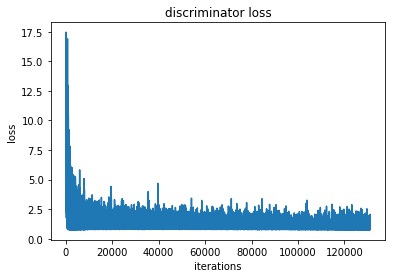

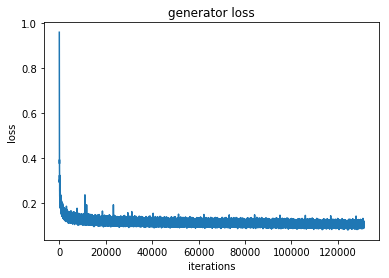

Step 131080: dloss = 0.8212, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 14585.0352 l1_loss = 0.0909
Step 131090: dloss = 0.9135, gloss = 0.1021, real_loss = 0.0702, fake_loss = 0.8433, gan_loss = 14100.0850 l1_loss = 0.0880
Step 131100: dloss = 0.8118, gloss = 0.0977, real_loss = 0.0001, fake_loss = 0.8117, gan_loss = 13845.2617 l1_loss = 0.0838
Step 131110: dloss = 0.8587, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8587, gan_loss = 14154.7754 l1_loss = 0.0828
Step 131120: dloss = 0.8469, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8469, gan_loss = 14066.4297 l1_loss = 0.0896
Step 131130: dloss = 0.8022, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8022, gan_loss = 14343.4932 l1_loss = 0.0887
Step 131140: dloss = 0.8362, gloss = 0.0938, real_loss = 0.0000, fake_loss = 0.8362, gan_loss = 14093.4951 l1_loss = 0.0797
Step 131150: dloss = 0.8191, gloss = 0.1013, real_loss = 0.0000, fake_loss = 0.8191, gan_loss = 13562.7168 l1_loss = 0.0877
Step 131

Step 131750: dloss = 0.8165, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8165, gan_loss = 14310.6562 l1_loss = 0.0930
Step 131760: dloss = 0.8279, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.8279, gan_loss = 13822.9346 l1_loss = 0.0808
Step 131770: dloss = 0.8936, gloss = 0.1058, real_loss = 0.0826, fake_loss = 0.8110, gan_loss = 13836.4248 l1_loss = 0.0919
Step 131780: dloss = 0.8467, gloss = 0.0874, real_loss = 0.0000, fake_loss = 0.8467, gan_loss = 13911.1885 l1_loss = 0.0735
Step 131790: dloss = 0.8413, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.8413, gan_loss = 14164.3262 l1_loss = 0.0909
Step 131800: dloss = 0.8694, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8694, gan_loss = 13799.2402 l1_loss = 0.0876
Step 131810: dloss = 0.8300, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8300, gan_loss = 14293.3545 l1_loss = 0.0813
Step 131820: dloss = 0.7942, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.7942, gan_loss = 13684.2363 l1_loss = 0.0858
Step 131

Step 132420: dloss = 0.8478, gloss = 0.1010, real_loss = 0.0000, fake_loss = 0.8478, gan_loss = 14646.2500 l1_loss = 0.0863
Step 132430: dloss = 0.8184, gloss = 0.0944, real_loss = 0.0000, fake_loss = 0.8184, gan_loss = 13848.8447 l1_loss = 0.0806
Step 132440: dloss = 0.8293, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8293, gan_loss = 14104.8809 l1_loss = 0.0835
Step 132450: dloss = 0.7986, gloss = 0.0952, real_loss = 0.0000, fake_loss = 0.7986, gan_loss = 14115.6260 l1_loss = 0.0811
Step 132460: dloss = 0.8051, gloss = 0.0899, real_loss = 0.0000, fake_loss = 0.8051, gan_loss = 14009.6562 l1_loss = 0.0759
Step 132470: dloss = 0.8535, gloss = 0.0970, real_loss = 0.0140, fake_loss = 0.8395, gan_loss = 14129.1250 l1_loss = 0.0828
Step 132480: dloss = 0.8375, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.8375, gan_loss = 14623.2197 l1_loss = 0.0882
Step 132490: dloss = 0.7916, gloss = 0.0860, real_loss = 0.0000, fake_loss = 0.7916, gan_loss = 13943.9102 l1_loss = 0.0721
Step 132

Step 133090: dloss = 0.8258, gloss = 0.1134, real_loss = 0.0000, fake_loss = 0.8258, gan_loss = 13754.3984 l1_loss = 0.0996
Step 133100: dloss = 0.8130, gloss = 0.0933, real_loss = 0.0000, fake_loss = 0.8130, gan_loss = 13846.8320 l1_loss = 0.0795
Step 133110: dloss = 0.8095, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.8095, gan_loss = 14339.6670 l1_loss = 0.0876
Step 133120: dloss = 0.8148, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8148, gan_loss = 14215.0127 l1_loss = 0.0946
Step 133130: dloss = 1.8993, gloss = 0.1029, real_loss = 1.0893, fake_loss = 0.8100, gan_loss = 14107.0146 l1_loss = 0.0888
Step 133140: dloss = 0.8245, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.8245, gan_loss = 13960.3604 l1_loss = 0.0912
Step 133150: dloss = 0.8282, gloss = 0.0931, real_loss = 0.0000, fake_loss = 0.8282, gan_loss = 14259.1924 l1_loss = 0.0788
Step 133160: dloss = 0.8360, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.8359, gan_loss = 14311.5684 l1_loss = 0.0876
Step 133

Step 133760: dloss = 0.8461, gloss = 0.0961, real_loss = 0.0000, fake_loss = 0.8461, gan_loss = 13717.4512 l1_loss = 0.0824
Step 133770: dloss = 1.1197, gloss = 0.0996, real_loss = 0.2996, fake_loss = 0.8201, gan_loss = 13477.7432 l1_loss = 0.0861
Step 133780: dloss = 0.8577, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8577, gan_loss = 14182.5703 l1_loss = 0.0945
Step 133790: dloss = 0.8215, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8215, gan_loss = 14485.1670 l1_loss = 0.0924
Step 133800: dloss = 1.2669, gloss = 0.0975, real_loss = 0.4457, fake_loss = 0.8211, gan_loss = 13575.4131 l1_loss = 0.0839
Step 133810: dloss = 0.8225, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8225, gan_loss = 13460.8174 l1_loss = 0.0831
Step 133820: dloss = 0.8319, gloss = 0.0933, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 14390.7168 l1_loss = 0.0789
Step 133830: dloss = 0.8361, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8361, gan_loss = 13950.8369 l1_loss = 0.0948
Step 133

Step 134430: dloss = 0.8261, gloss = 0.0950, real_loss = 0.0001, fake_loss = 0.8261, gan_loss = 13773.8418 l1_loss = 0.0813
Step 134440: dloss = 0.8238, gloss = 0.1018, real_loss = 0.0000, fake_loss = 0.8238, gan_loss = 13831.3838 l1_loss = 0.0880
Step 134450: dloss = 0.8260, gloss = 0.1056, real_loss = 0.0017, fake_loss = 0.8243, gan_loss = 14152.2803 l1_loss = 0.0915
Step 134460: dloss = 0.8277, gloss = 0.1010, real_loss = 0.0014, fake_loss = 0.8262, gan_loss = 13643.2217 l1_loss = 0.0873
Step 134470: dloss = 1.0271, gloss = 0.0984, real_loss = 0.2240, fake_loss = 0.8031, gan_loss = 13484.9150 l1_loss = 0.0849
Step 134480: dloss = 0.8136, gloss = 0.1119, real_loss = 0.0000, fake_loss = 0.8136, gan_loss = 13802.5234 l1_loss = 0.0981
Step 134490: dloss = 0.8319, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 13949.0566 l1_loss = 0.0840
Step 134500: dloss = 0.8235, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 13972.7139 l1_loss = 0.0861
Step 134

Step 135100: dloss = 0.8063, gloss = 0.0970, real_loss = 0.0000, fake_loss = 0.8063, gan_loss = 14032.9902 l1_loss = 0.0829
Step 135110: dloss = 0.8239, gloss = 0.1002, real_loss = 0.0011, fake_loss = 0.8228, gan_loss = 13854.5469 l1_loss = 0.0864
Step 135120: dloss = 0.8043, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.8043, gan_loss = 13944.1699 l1_loss = 0.0847
Step 135130: dloss = 0.8278, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 14116.7168 l1_loss = 0.0942
Step 135140: dloss = 0.8193, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8193, gan_loss = 13534.9922 l1_loss = 0.0938
Step 135150: dloss = 0.8012, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8012, gan_loss = 14002.0732 l1_loss = 0.0955
Step 135160: dloss = 0.8520, gloss = 0.1025, real_loss = 0.0151, fake_loss = 0.8370, gan_loss = 13795.0928 l1_loss = 0.0887
Step 135170: dloss = 0.8090, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8090, gan_loss = 13758.6982 l1_loss = 0.0905
Step 135

Step 135770: dloss = 0.8317, gloss = 0.0946, real_loss = 0.0000, fake_loss = 0.8317, gan_loss = 13433.0254 l1_loss = 0.0811
Step 135780: dloss = 0.8235, gloss = 0.0963, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 13959.5010 l1_loss = 0.0823
Step 135790: dloss = 1.8502, gloss = 0.1002, real_loss = 1.0224, fake_loss = 0.8277, gan_loss = 13412.5215 l1_loss = 0.0867
Step 135800: dloss = 0.8185, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.8185, gan_loss = 13534.5166 l1_loss = 0.0924
Step 135810: dloss = 0.8193, gloss = 0.0970, real_loss = 0.0000, fake_loss = 0.8193, gan_loss = 14212.3398 l1_loss = 0.0828
Step 135820: dloss = 0.8272, gloss = 0.1011, real_loss = 0.0060, fake_loss = 0.8213, gan_loss = 13607.3770 l1_loss = 0.0875
Step 135830: dloss = 0.8300, gloss = 0.0991, real_loss = 0.0019, fake_loss = 0.8280, gan_loss = 14160.3047 l1_loss = 0.0850
Step 135840: dloss = 0.8154, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8154, gan_loss = 13599.7773 l1_loss = 0.0830
Step 135

Step 136440: dloss = 0.8383, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 13346.5195 l1_loss = 0.0974
Step 136450: dloss = 0.8433, gloss = 0.0917, real_loss = 0.0000, fake_loss = 0.8433, gan_loss = 14072.0469 l1_loss = 0.0776
Step 136460: dloss = 0.8253, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8253, gan_loss = 13853.5576 l1_loss = 0.0909
Step 136470: dloss = 0.8504, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.8504, gan_loss = 12965.7715 l1_loss = 0.0818
Step 136480: dloss = 0.8472, gloss = 0.1161, real_loss = 0.0000, fake_loss = 0.8472, gan_loss = 13406.7188 l1_loss = 0.1027
Step 136490: dloss = 0.8226, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8226, gan_loss = 13737.5420 l1_loss = 0.0842
Step 136500: dloss = 0.8135, gloss = 0.0929, real_loss = 0.0000, fake_loss = 0.8135, gan_loss = 13849.5068 l1_loss = 0.0791
Step 136510: dloss = 0.8596, gloss = 0.0878, real_loss = 0.0000, fake_loss = 0.8596, gan_loss = 14542.9844 l1_loss = 0.0733
Step 136

Step 137110: dloss = 0.7886, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.7886, gan_loss = 14232.9756 l1_loss = 0.0850
Step 137120: dloss = 0.8424, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.8424, gan_loss = 14525.3154 l1_loss = 0.0961
Step 137130: dloss = 0.8358, gloss = 0.0864, real_loss = 0.0000, fake_loss = 0.8358, gan_loss = 13169.5527 l1_loss = 0.0733
Step 137140: dloss = 0.8212, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 13769.6104 l1_loss = 0.0899
Step 137150: dloss = 0.8207, gloss = 0.0868, real_loss = 0.0000, fake_loss = 0.8207, gan_loss = 13966.7617 l1_loss = 0.0728
Step 137160: dloss = 0.8152, gloss = 0.0910, real_loss = 0.0000, fake_loss = 0.8152, gan_loss = 13449.7041 l1_loss = 0.0776
Step 137170: dloss = 0.8385, gloss = 0.0918, real_loss = 0.0145, fake_loss = 0.8240, gan_loss = 13486.2344 l1_loss = 0.0783
Step 137180: dloss = 0.8349, gloss = 0.1088, real_loss = 0.0000, fake_loss = 0.8349, gan_loss = 13558.6758 l1_loss = 0.0952
Step 137

Step 137780: dloss = 0.8082, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.8082, gan_loss = 13847.3770 l1_loss = 0.0809
Step 137790: dloss = 0.8240, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8240, gan_loss = 13727.7432 l1_loss = 0.0909
Step 137800: dloss = 0.9026, gloss = 0.1047, real_loss = 0.0809, fake_loss = 0.8216, gan_loss = 13517.7803 l1_loss = 0.0911
Step 137810: dloss = 0.8212, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 13860.4922 l1_loss = 0.0836
Step 137820: dloss = 0.7898, gloss = 0.1096, real_loss = 0.0001, fake_loss = 0.7897, gan_loss = 13298.0029 l1_loss = 0.0963
Step 137830: dloss = 0.8608, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8608, gan_loss = 13797.0781 l1_loss = 0.0959
Step 137840: dloss = 0.9190, gloss = 0.1040, real_loss = 0.0827, fake_loss = 0.8363, gan_loss = 13366.4492 l1_loss = 0.0907
Step 137850: dloss = 0.8340, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8340, gan_loss = 13454.4697 l1_loss = 0.0867
Step 137

Step 138450: dloss = 0.8398, gloss = 0.0859, real_loss = 0.0002, fake_loss = 0.8397, gan_loss = 13818.4814 l1_loss = 0.0721
Step 138460: dloss = 0.8405, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.8405, gan_loss = 13578.2959 l1_loss = 0.0798
Step 138470: dloss = 0.9463, gloss = 0.0898, real_loss = 0.1108, fake_loss = 0.8355, gan_loss = 13729.0596 l1_loss = 0.0761
Step 138480: dloss = 0.8259, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.8259, gan_loss = 13493.7676 l1_loss = 0.0812
Step 138490: dloss = 0.8168, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 13517.5889 l1_loss = 0.0939
Step 138500: dloss = 0.9447, gloss = 0.0950, real_loss = 0.1026, fake_loss = 0.8421, gan_loss = 13586.2617 l1_loss = 0.0814
Step 138510: dloss = 1.0364, gloss = 0.1013, real_loss = 0.2056, fake_loss = 0.8308, gan_loss = 13005.5107 l1_loss = 0.0883
Step 138520: dloss = 0.8609, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8609, gan_loss = 13706.8369 l1_loss = 0.0855
Step 138

Step 139120: dloss = 0.8208, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8208, gan_loss = 14021.4473 l1_loss = 0.0960
Step 139130: dloss = 0.8451, gloss = 0.0902, real_loss = 0.0001, fake_loss = 0.8451, gan_loss = 13568.8828 l1_loss = 0.0766
Step 139140: dloss = 0.8821, gloss = 0.1019, real_loss = 0.0667, fake_loss = 0.8154, gan_loss = 13155.6807 l1_loss = 0.0888
Step 139150: dloss = 0.8176, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 13966.4922 l1_loss = 0.0828
Step 139160: dloss = 0.8368, gloss = 0.1092, real_loss = 0.0086, fake_loss = 0.8282, gan_loss = 13270.3936 l1_loss = 0.0959
Step 139170: dloss = 0.8038, gloss = 0.1123, real_loss = 0.0000, fake_loss = 0.8038, gan_loss = 13925.0020 l1_loss = 0.0983
Step 139180: dloss = 0.8167, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8167, gan_loss = 14014.9102 l1_loss = 0.0926
Step 139190: dloss = 0.8242, gloss = 0.1082, real_loss = 0.0010, fake_loss = 0.8233, gan_loss = 13607.5000 l1_loss = 0.0946
Step 139

Step 139790: dloss = 0.8176, gloss = 0.0950, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 12942.2344 l1_loss = 0.0820
Step 139800: dloss = 0.8267, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.8267, gan_loss = 12865.6504 l1_loss = 0.0857
Step 139810: dloss = 0.8135, gloss = 0.1085, real_loss = 0.0012, fake_loss = 0.8124, gan_loss = 13239.4336 l1_loss = 0.0952
Step 139820: dloss = 0.8142, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 13484.0244 l1_loss = 0.0846
Step 139830: dloss = 0.8239, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8239, gan_loss = 13454.1699 l1_loss = 0.0982
Step 139840: dloss = 0.8248, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8248, gan_loss = 13008.8320 l1_loss = 0.0986
Step 139850: dloss = 0.7993, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.7993, gan_loss = 13454.3770 l1_loss = 0.0887
Step 139860: dloss = 0.8386, gloss = 0.0863, real_loss = 0.0000, fake_loss = 0.8386, gan_loss = 13418.0781 l1_loss = 0.0728
Step 139

Step 140460: dloss = 0.9132, gloss = 0.1020, real_loss = 0.1114, fake_loss = 0.8018, gan_loss = 13491.2275 l1_loss = 0.0885
Step 140470: dloss = 0.9258, gloss = 0.0977, real_loss = 0.0980, fake_loss = 0.8278, gan_loss = 14081.1611 l1_loss = 0.0836
Step 140480: dloss = 0.8062, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.8062, gan_loss = 13038.0957 l1_loss = 0.0860
Step 140490: dloss = 0.7887, gloss = 0.1009, real_loss = 0.0000, fake_loss = 0.7887, gan_loss = 13660.4258 l1_loss = 0.0873
Step 140500: dloss = 0.8375, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.8375, gan_loss = 13529.3896 l1_loss = 0.0903
Step 140510: dloss = 0.8843, gloss = 0.0935, real_loss = 0.0852, fake_loss = 0.7992, gan_loss = 13222.9473 l1_loss = 0.0802
Step 140520: dloss = 0.8151, gloss = 0.0957, real_loss = 0.0000, fake_loss = 0.8151, gan_loss = 13602.1768 l1_loss = 0.0821
Step 140530: dloss = 0.7955, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.7955, gan_loss = 13235.6172 l1_loss = 0.0840
Step 140

Step 141130: dloss = 0.8182, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8182, gan_loss = 13535.3525 l1_loss = 0.0856
Step 141140: dloss = 0.8407, gloss = 0.0899, real_loss = 0.0000, fake_loss = 0.8407, gan_loss = 13930.0391 l1_loss = 0.0760
Step 141150: dloss = 0.8182, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8182, gan_loss = 13807.8447 l1_loss = 0.0830
Step 141160: dloss = 0.8255, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8255, gan_loss = 13796.6084 l1_loss = 0.0854
Step 141170: dloss = 1.0839, gloss = 0.1165, real_loss = 0.2860, fake_loss = 0.7979, gan_loss = 13452.0811 l1_loss = 0.1030
Step 141180: dloss = 0.8505, gloss = 0.1105, real_loss = 0.0000, fake_loss = 0.8505, gan_loss = 13638.4141 l1_loss = 0.0968
Step 141190: dloss = 1.2826, gloss = 0.1093, real_loss = 0.4755, fake_loss = 0.8071, gan_loss = 14199.3271 l1_loss = 0.0951
Step 141200: dloss = 0.8414, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8414, gan_loss = 12872.0020 l1_loss = 0.0871
Step 141

Step 141800: dloss = 0.7869, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.7869, gan_loss = 13256.7822 l1_loss = 0.0962
Step 141810: dloss = 0.8123, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8123, gan_loss = 13298.6406 l1_loss = 0.0926
Step 141820: dloss = 0.8329, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.8329, gan_loss = 13657.2314 l1_loss = 0.0902
Step 141830: dloss = 0.8465, gloss = 0.1172, real_loss = 0.0000, fake_loss = 0.8465, gan_loss = 13582.2451 l1_loss = 0.1037
Step 141840: dloss = 0.8250, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.8250, gan_loss = 13395.5889 l1_loss = 0.0932
Step 141850: dloss = 0.8444, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8444, gan_loss = 13560.4170 l1_loss = 0.0864
Step 141860: dloss = 0.8371, gloss = 0.0946, real_loss = 0.0222, fake_loss = 0.8149, gan_loss = 13631.0869 l1_loss = 0.0809
Step 141870: dloss = 0.8052, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8052, gan_loss = 13057.0684 l1_loss = 0.0918
Step 141

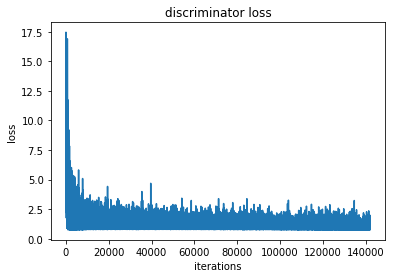

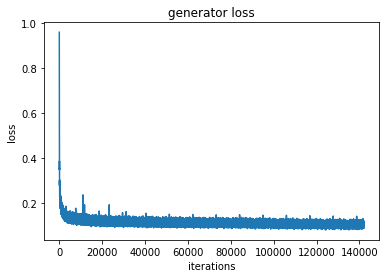

Step 142000: dloss = 0.8053, gloss = 0.1038, real_loss = 0.0000, fake_loss = 0.8053, gan_loss = 13591.2705 l1_loss = 0.0902
Step 142010: dloss = 0.8384, gloss = 0.0936, real_loss = 0.0000, fake_loss = 0.8384, gan_loss = 13659.7148 l1_loss = 0.0799
Step 142020: dloss = 0.8141, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8141, gan_loss = 13618.1064 l1_loss = 0.0917
Step 142030: dloss = 0.8087, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8087, gan_loss = 13607.1465 l1_loss = 0.0866
Step 142040: dloss = 0.8142, gloss = 0.1083, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 13468.0166 l1_loss = 0.0949
Step 142050: dloss = 0.8066, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8066, gan_loss = 13053.3574 l1_loss = 0.0923
Step 142060: dloss = 0.8233, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.8233, gan_loss = 13607.8857 l1_loss = 0.0809
Step 142070: dloss = 0.7977, gloss = 0.1106, real_loss = 0.0000, fake_loss = 0.7977, gan_loss = 13477.9990 l1_loss = 0.0971
Step 142

Step 142670: dloss = 0.8051, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8051, gan_loss = 13294.7168 l1_loss = 0.0843
Step 142680: dloss = 0.8310, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.8310, gan_loss = 13716.9785 l1_loss = 0.0800
Step 142690: dloss = 1.5967, gloss = 0.1168, real_loss = 0.7751, fake_loss = 0.8216, gan_loss = 13139.6963 l1_loss = 0.1036
Step 142700: dloss = 0.8168, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 13529.2129 l1_loss = 0.0872
Step 142710: dloss = 0.8117, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8117, gan_loss = 13412.4854 l1_loss = 0.0911
Step 142720: dloss = 0.8210, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8210, gan_loss = 13639.1699 l1_loss = 0.0907
Step 142730: dloss = 1.0978, gloss = 0.1070, real_loss = 0.2809, fake_loss = 0.8169, gan_loss = 13208.0664 l1_loss = 0.0938
Step 142740: dloss = 1.5637, gloss = 0.1069, real_loss = 0.7437, fake_loss = 0.8201, gan_loss = 12682.3818 l1_loss = 0.0942
Step 142

Step 143340: dloss = 0.8210, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.8210, gan_loss = 13526.3525 l1_loss = 0.0907
Step 143350: dloss = 0.7989, gloss = 0.1173, real_loss = 0.0000, fake_loss = 0.7989, gan_loss = 12728.9258 l1_loss = 0.1046
Step 143360: dloss = 0.7934, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.7934, gan_loss = 13069.1719 l1_loss = 0.0928
Step 143370: dloss = 0.8086, gloss = 0.1034, real_loss = 0.0000, fake_loss = 0.8086, gan_loss = 13449.7129 l1_loss = 0.0900
Step 143380: dloss = 0.8118, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8118, gan_loss = 12909.4404 l1_loss = 0.0845
Step 143390: dloss = 0.8252, gloss = 0.0947, real_loss = 0.0110, fake_loss = 0.8142, gan_loss = 13087.1523 l1_loss = 0.0816
Step 143400: dloss = 0.8414, gloss = 0.0995, real_loss = 0.0138, fake_loss = 0.8275, gan_loss = 13811.5693 l1_loss = 0.0857
Step 143410: dloss = 0.8185, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8185, gan_loss = 13078.8086 l1_loss = 0.0928
Step 143

Step 144010: dloss = 0.8231, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.8231, gan_loss = 13455.7266 l1_loss = 0.0881
Step 144020: dloss = 0.8073, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.8073, gan_loss = 12969.7744 l1_loss = 0.0829
Step 144030: dloss = 0.8251, gloss = 0.0920, real_loss = 0.0000, fake_loss = 0.8251, gan_loss = 13258.3174 l1_loss = 0.0788
Step 144040: dloss = 0.8189, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8189, gan_loss = 13473.8203 l1_loss = 0.0879
Step 144050: dloss = 1.1394, gloss = 0.1142, real_loss = 0.3259, fake_loss = 0.8134, gan_loss = 12774.8389 l1_loss = 0.1015
Step 144060: dloss = 0.8224, gloss = 0.0963, real_loss = 0.0001, fake_loss = 0.8224, gan_loss = 13634.5068 l1_loss = 0.0826
Step 144070: dloss = 0.7965, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.7965, gan_loss = 13532.4375 l1_loss = 0.0782
Step 144080: dloss = 0.8421, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8421, gan_loss = 13118.8203 l1_loss = 0.0825
Step 144

Step 144680: dloss = 0.8076, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8076, gan_loss = 13662.8105 l1_loss = 0.0842
Step 144690: dloss = 0.8117, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8117, gan_loss = 13072.4609 l1_loss = 0.0867
Step 144700: dloss = 0.8190, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8190, gan_loss = 13377.6504 l1_loss = 0.0996
Step 144710: dloss = 0.8220, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8220, gan_loss = 13339.9834 l1_loss = 0.0864
Step 144720: dloss = 0.7940, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.7940, gan_loss = 13181.5332 l1_loss = 0.0953
Step 144730: dloss = 0.8573, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8573, gan_loss = 13568.3291 l1_loss = 0.0942
Step 144740: dloss = 0.8178, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 13116.7881 l1_loss = 0.0860
Step 144750: dloss = 0.8584, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.8584, gan_loss = 12738.0020 l1_loss = 0.0851
Step 144

Step 145350: dloss = 0.8299, gloss = 0.0926, real_loss = 0.0000, fake_loss = 0.8299, gan_loss = 13266.3896 l1_loss = 0.0793
Step 145360: dloss = 1.0594, gloss = 0.1032, real_loss = 0.2421, fake_loss = 0.8173, gan_loss = 12961.7842 l1_loss = 0.0903
Step 145370: dloss = 0.7982, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.7982, gan_loss = 12718.4961 l1_loss = 0.0905
Step 145380: dloss = 0.8177, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.8177, gan_loss = 13098.3818 l1_loss = 0.0947
Step 145390: dloss = 0.8232, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8232, gan_loss = 12734.5938 l1_loss = 0.0849
Step 145400: dloss = 1.6196, gloss = 0.1084, real_loss = 0.7979, fake_loss = 0.8217, gan_loss = 13362.7070 l1_loss = 0.0950
Step 145410: dloss = 0.8217, gloss = 0.1157, real_loss = 0.0000, fake_loss = 0.8217, gan_loss = 13569.7432 l1_loss = 0.1022
Step 145420: dloss = 0.8059, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8059, gan_loss = 13400.9336 l1_loss = 0.0919
Step 145

Step 146020: dloss = 0.8578, gloss = 0.0944, real_loss = 0.0590, fake_loss = 0.7989, gan_loss = 13175.8682 l1_loss = 0.0812
Step 146030: dloss = 0.7907, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.7907, gan_loss = 13142.0527 l1_loss = 0.0827
Step 146040: dloss = 0.8173, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.8173, gan_loss = 13321.6240 l1_loss = 0.0797
Step 146050: dloss = 0.8361, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8361, gan_loss = 13574.7637 l1_loss = 0.0922
Step 146060: dloss = 0.8352, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8352, gan_loss = 13816.3203 l1_loss = 0.0845
Step 146070: dloss = 0.8003, gloss = 0.0964, real_loss = 0.0000, fake_loss = 0.8003, gan_loss = 12929.1758 l1_loss = 0.0835
Step 146080: dloss = 0.8006, gloss = 0.0888, real_loss = 0.0000, fake_loss = 0.8006, gan_loss = 13330.5078 l1_loss = 0.0754
Step 146090: dloss = 0.8200, gloss = 0.1001, real_loss = 0.0001, fake_loss = 0.8199, gan_loss = 12969.0615 l1_loss = 0.0872
Step 146

Step 146690: dloss = 0.8432, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.8432, gan_loss = 12898.3691 l1_loss = 0.0953
Step 146700: dloss = 0.8243, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.8243, gan_loss = 12942.6963 l1_loss = 0.0903
Step 146710: dloss = 0.7878, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.7878, gan_loss = 13201.0742 l1_loss = 0.0920
Step 146720: dloss = 0.8242, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 13907.2461 l1_loss = 0.0933
Step 146730: dloss = 0.8198, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8198, gan_loss = 13532.9326 l1_loss = 0.0917
Step 146740: dloss = 0.8244, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8244, gan_loss = 13142.9766 l1_loss = 0.0925
Step 146750: dloss = 1.3022, gloss = 0.0913, real_loss = 0.4810, fake_loss = 0.8212, gan_loss = 12972.8066 l1_loss = 0.0783
Step 146760: dloss = 0.8472, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8472, gan_loss = 12898.6250 l1_loss = 0.0918
Step 146

Step 147360: dloss = 0.8159, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8159, gan_loss = 13390.7324 l1_loss = 0.0866
Step 147370: dloss = 0.8166, gloss = 0.1176, real_loss = 0.0000, fake_loss = 0.8166, gan_loss = 13280.7617 l1_loss = 0.1043
Step 147380: dloss = 0.8204, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8204, gan_loss = 13192.8203 l1_loss = 0.0957
Step 147390: dloss = 0.8155, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8155, gan_loss = 13435.4229 l1_loss = 0.0865
Step 147400: dloss = 0.8189, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8189, gan_loss = 12340.9248 l1_loss = 0.0857
Step 147410: dloss = 0.8007, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8007, gan_loss = 13152.3896 l1_loss = 0.0828
Step 147420: dloss = 0.8333, gloss = 0.1119, real_loss = 0.0000, fake_loss = 0.8333, gan_loss = 13297.5752 l1_loss = 0.0986
Step 147430: dloss = 0.8323, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8323, gan_loss = 12530.7139 l1_loss = 0.0875
Step 147

Step 148030: dloss = 0.8145, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.8145, gan_loss = 13048.5986 l1_loss = 0.0921
Step 148040: dloss = 0.8311, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8311, gan_loss = 12549.9521 l1_loss = 0.0924
Step 148050: dloss = 0.8949, gloss = 0.1047, real_loss = 0.0599, fake_loss = 0.8349, gan_loss = 12438.1982 l1_loss = 0.0922
Step 148060: dloss = 0.8064, gloss = 0.1079, real_loss = 0.0000, fake_loss = 0.8064, gan_loss = 13046.2793 l1_loss = 0.0948
Step 148070: dloss = 0.8338, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 13344.5254 l1_loss = 0.0847
Step 148080: dloss = 0.8579, gloss = 0.0963, real_loss = 0.0151, fake_loss = 0.8428, gan_loss = 12737.9531 l1_loss = 0.0835
Step 148090: dloss = 0.8255, gloss = 0.1018, real_loss = 0.0000, fake_loss = 0.8255, gan_loss = 13124.3076 l1_loss = 0.0887
Step 148100: dloss = 0.9001, gloss = 0.0939, real_loss = 0.0956, fake_loss = 0.8045, gan_loss = 12772.4229 l1_loss = 0.0811
Step 148

Step 148700: dloss = 0.8110, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8110, gan_loss = 13145.1182 l1_loss = 0.0873
Step 148710: dloss = 0.8348, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8348, gan_loss = 13031.7891 l1_loss = 0.0928
Step 148720: dloss = 0.8431, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8431, gan_loss = 12598.5332 l1_loss = 0.0888
Step 148730: dloss = 0.8321, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8321, gan_loss = 13210.1719 l1_loss = 0.0912
Step 148740: dloss = 0.8158, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.8158, gan_loss = 13150.6631 l1_loss = 0.0951
Step 148750: dloss = 0.8457, gloss = 0.0892, real_loss = 0.0000, fake_loss = 0.8457, gan_loss = 13342.0547 l1_loss = 0.0759
Step 148760: dloss = 0.7976, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.7976, gan_loss = 13276.3740 l1_loss = 0.0926
Step 148770: dloss = 0.7933, gloss = 0.1118, real_loss = 0.0000, fake_loss = 0.7933, gan_loss = 12536.3408 l1_loss = 0.0992
Step 148

Step 149370: dloss = 0.8336, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8336, gan_loss = 13149.2715 l1_loss = 0.0868
Step 149380: dloss = 0.8195, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8195, gan_loss = 12657.5557 l1_loss = 0.0828
Step 149390: dloss = 0.7999, gloss = 0.0958, real_loss = 0.0000, fake_loss = 0.7999, gan_loss = 12867.5859 l1_loss = 0.0830
Step 149400: dloss = 0.8302, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8302, gan_loss = 12763.7480 l1_loss = 0.0839
Step 149410: dloss = 0.8045, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8045, gan_loss = 13231.3330 l1_loss = 0.0842
Step 149420: dloss = 0.8186, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8186, gan_loss = 13124.9922 l1_loss = 0.0984
Step 149430: dloss = 0.7708, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.7708, gan_loss = 12990.7578 l1_loss = 0.0862
Step 149440: dloss = 0.8096, gloss = 0.1039, real_loss = 0.0000, fake_loss = 0.8096, gan_loss = 12900.7695 l1_loss = 0.0910
Step 149

Step 150040: dloss = 0.7762, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.7762, gan_loss = 12716.7031 l1_loss = 0.0896
Step 150050: dloss = 0.8459, gloss = 0.1053, real_loss = 0.0068, fake_loss = 0.8391, gan_loss = 13552.4414 l1_loss = 0.0917
Step 150060: dloss = 0.8213, gloss = 0.1094, real_loss = 0.0000, fake_loss = 0.8212, gan_loss = 12867.7451 l1_loss = 0.0965
Step 150070: dloss = 0.8056, gloss = 0.1044, real_loss = 0.0003, fake_loss = 0.8053, gan_loss = 12619.8809 l1_loss = 0.0918
Step 150080: dloss = 0.8288, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.8288, gan_loss = 12738.9717 l1_loss = 0.0810
Step 150090: dloss = 0.8338, gloss = 0.0928, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 12444.1436 l1_loss = 0.0804
Step 150100: dloss = 1.3396, gloss = 0.1062, real_loss = 0.5370, fake_loss = 0.8026, gan_loss = 12736.9746 l1_loss = 0.0935
Step 150110: dloss = 0.8153, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8153, gan_loss = 13187.0283 l1_loss = 0.0837
Step 150

Step 150710: dloss = 0.8043, gloss = 0.0911, real_loss = 0.0000, fake_loss = 0.8043, gan_loss = 13212.8672 l1_loss = 0.0779
Step 150720: dloss = 0.8269, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 12850.5547 l1_loss = 0.0936
Step 150730: dloss = 0.8363, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8363, gan_loss = 13283.5322 l1_loss = 0.0845
Step 150740: dloss = 1.3892, gloss = 0.0875, real_loss = 0.5611, fake_loss = 0.8281, gan_loss = 12899.0566 l1_loss = 0.0746
Step 150750: dloss = 0.7970, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.7970, gan_loss = 12994.6270 l1_loss = 0.0905
Step 150760: dloss = 0.8061, gloss = 0.0949, real_loss = 0.0000, fake_loss = 0.8061, gan_loss = 12778.2627 l1_loss = 0.0821
Step 150770: dloss = 0.8068, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8068, gan_loss = 13379.4014 l1_loss = 0.0915
Step 150780: dloss = 0.8292, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.8292, gan_loss = 13136.0352 l1_loss = 0.0787
Step 150

Step 151380: dloss = 0.8858, gloss = 0.1114, real_loss = 0.0809, fake_loss = 0.8049, gan_loss = 12618.1484 l1_loss = 0.0988
Step 151390: dloss = 0.8223, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 13650.8154 l1_loss = 0.0889
Step 151400: dloss = 0.7957, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.7957, gan_loss = 12848.1211 l1_loss = 0.0850
Step 151410: dloss = 0.8089, gloss = 0.1131, real_loss = 0.0000, fake_loss = 0.8089, gan_loss = 12658.7568 l1_loss = 0.1004
Step 151420: dloss = 0.7971, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.7971, gan_loss = 12757.5986 l1_loss = 0.0903
Step 151430: dloss = 0.8075, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8075, gan_loss = 12965.1855 l1_loss = 0.0915
Step 151440: dloss = 1.0155, gloss = 0.0979, real_loss = 0.2142, fake_loss = 0.8012, gan_loss = 12105.1699 l1_loss = 0.0858
Step 151450: dloss = 0.8195, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.8195, gan_loss = 13104.3486 l1_loss = 0.0840
Step 151

Step 152050: dloss = 0.8174, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8174, gan_loss = 12677.7402 l1_loss = 0.0921
Step 152060: dloss = 0.8292, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.8292, gan_loss = 13180.1924 l1_loss = 0.0854
Step 152070: dloss = 0.8374, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.8374, gan_loss = 12979.7002 l1_loss = 0.0818
Step 152080: dloss = 0.8405, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.8404, gan_loss = 12591.7246 l1_loss = 0.0850
Step 152090: dloss = 0.8051, gloss = 0.1123, real_loss = 0.0000, fake_loss = 0.8051, gan_loss = 13258.4854 l1_loss = 0.0991
Step 152100: dloss = 0.8269, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 12799.2959 l1_loss = 0.0942
Step 152110: dloss = 0.8295, gloss = 0.0971, real_loss = 0.0000, fake_loss = 0.8295, gan_loss = 12799.6035 l1_loss = 0.0843
Step 152120: dloss = 0.7995, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.7995, gan_loss = 12615.7168 l1_loss = 0.0914
Step 152

Step 152720: dloss = 0.8034, gloss = 0.0857, real_loss = 0.0000, fake_loss = 0.8034, gan_loss = 12719.9951 l1_loss = 0.0730
Step 152730: dloss = 0.8125, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8125, gan_loss = 12970.6826 l1_loss = 0.0939
Step 152740: dloss = 0.8454, gloss = 0.0965, real_loss = 0.0003, fake_loss = 0.8451, gan_loss = 12508.0430 l1_loss = 0.0840
Step 152750: dloss = 1.8143, gloss = 0.1079, real_loss = 1.0146, fake_loss = 0.7997, gan_loss = 12731.0635 l1_loss = 0.0952
Step 152760: dloss = 0.8360, gloss = 0.1007, real_loss = 0.0167, fake_loss = 0.8193, gan_loss = 13079.1025 l1_loss = 0.0876
Step 152770: dloss = 0.8232, gloss = 0.0931, real_loss = 0.0000, fake_loss = 0.8232, gan_loss = 12579.6875 l1_loss = 0.0805
Step 152780: dloss = 0.8195, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8195, gan_loss = 12720.5791 l1_loss = 0.0913
Step 152790: dloss = 0.8036, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8036, gan_loss = 12523.0254 l1_loss = 0.0831
Step 152

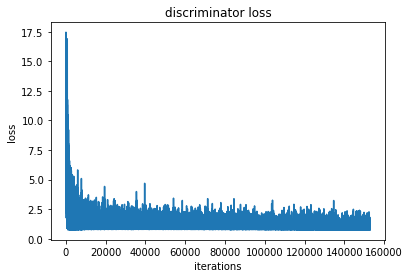

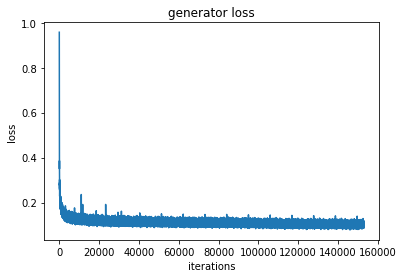

Step 152930: dloss = 0.8168, gloss = 0.1100, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 12875.1953 l1_loss = 0.0971
Step 152940: dloss = 0.8300, gloss = 0.1031, real_loss = 0.0000, fake_loss = 0.8300, gan_loss = 13293.8438 l1_loss = 0.0898
Step 152950: dloss = 0.8108, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8108, gan_loss = 13049.1797 l1_loss = 0.0927
Step 152960: dloss = 0.9634, gloss = 0.0953, real_loss = 0.1187, fake_loss = 0.8447, gan_loss = 12957.5674 l1_loss = 0.0823
Step 152970: dloss = 0.8254, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.8254, gan_loss = 12568.4150 l1_loss = 0.0862
Step 152980: dloss = 0.8105, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8105, gan_loss = 13225.8398 l1_loss = 0.0937
Step 152990: dloss = 0.8226, gloss = 0.0968, real_loss = 0.0005, fake_loss = 0.8222, gan_loss = 12920.1396 l1_loss = 0.0838
Step 153000: dloss = 0.8112, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8112, gan_loss = 12826.9561 l1_loss = 0.0883
Step 153

Step 153600: dloss = 0.8121, gloss = 0.0988, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 12815.3594 l1_loss = 0.0860
Step 153610: dloss = 0.7955, gloss = 0.0977, real_loss = 0.0000, fake_loss = 0.7955, gan_loss = 12754.2920 l1_loss = 0.0850
Step 153620: dloss = 0.8333, gloss = 0.0873, real_loss = 0.0000, fake_loss = 0.8333, gan_loss = 12832.4639 l1_loss = 0.0744
Step 153630: dloss = 0.7807, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.7807, gan_loss = 12929.3965 l1_loss = 0.0854
Step 153640: dloss = 0.8191, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.8190, gan_loss = 12706.0781 l1_loss = 0.0852
Step 153650: dloss = 0.8027, gloss = 0.1008, real_loss = 0.0000, fake_loss = 0.8027, gan_loss = 12724.0381 l1_loss = 0.0880
Step 153660: dloss = 0.8245, gloss = 0.1140, real_loss = 0.0000, fake_loss = 0.8245, gan_loss = 13003.5117 l1_loss = 0.1010
Step 153670: dloss = 0.8035, gloss = 0.1195, real_loss = 0.0000, fake_loss = 0.8035, gan_loss = 12737.1348 l1_loss = 0.1067
Step 153

Step 154270: dloss = 0.8152, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8152, gan_loss = 12709.1484 l1_loss = 0.0829
Step 154280: dloss = 0.7902, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.7902, gan_loss = 13033.4902 l1_loss = 0.0900
Step 154290: dloss = 0.8396, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8396, gan_loss = 12024.4541 l1_loss = 0.0934
Step 154300: dloss = 0.8223, gloss = 0.0887, real_loss = 0.0000, fake_loss = 0.8223, gan_loss = 12811.8643 l1_loss = 0.0759
Step 154310: dloss = 0.7878, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.7878, gan_loss = 12684.9580 l1_loss = 0.0924
Step 154320: dloss = 0.8372, gloss = 0.0937, real_loss = 0.0001, fake_loss = 0.8371, gan_loss = 12574.7285 l1_loss = 0.0811
Step 154330: dloss = 0.8293, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8293, gan_loss = 12591.6113 l1_loss = 0.0920
Step 154340: dloss = 1.0827, gloss = 0.0911, real_loss = 0.2583, fake_loss = 0.8244, gan_loss = 12604.4707 l1_loss = 0.0785
Step 154

Step 154940: dloss = 0.7921, gloss = 0.0900, real_loss = 0.0000, fake_loss = 0.7921, gan_loss = 12532.1826 l1_loss = 0.0775
Step 154950: dloss = 0.8195, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.8195, gan_loss = 12916.8359 l1_loss = 0.0844
Step 154960: dloss = 0.8093, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8093, gan_loss = 12329.0293 l1_loss = 0.0868
Step 154970: dloss = 0.8156, gloss = 0.1099, real_loss = 0.0000, fake_loss = 0.8156, gan_loss = 12494.9355 l1_loss = 0.0974
Step 154980: dloss = 0.7906, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.7906, gan_loss = 12524.8350 l1_loss = 0.0899
Step 154990: dloss = 0.8312, gloss = 0.0957, real_loss = 0.0000, fake_loss = 0.8312, gan_loss = 12831.8594 l1_loss = 0.0829
Step 155000: dloss = 0.7918, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7918, gan_loss = 12853.3232 l1_loss = 0.0900
Step 155010: dloss = 0.8019, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8019, gan_loss = 12636.1201 l1_loss = 0.0917
Step 155

Step 155610: dloss = 0.8274, gloss = 0.1045, real_loss = 0.0044, fake_loss = 0.8230, gan_loss = 12436.1748 l1_loss = 0.0920
Step 155620: dloss = 0.8002, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.8002, gan_loss = 12968.0264 l1_loss = 0.0855
Step 155630: dloss = 0.8162, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8162, gan_loss = 12335.4961 l1_loss = 0.0865
Step 155640: dloss = 0.7830, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.7830, gan_loss = 12155.9199 l1_loss = 0.0923
Step 155650: dloss = 0.8318, gloss = 0.0891, real_loss = 0.0000, fake_loss = 0.8318, gan_loss = 12426.5957 l1_loss = 0.0767
Step 155660: dloss = 1.3639, gloss = 0.0916, real_loss = 0.5428, fake_loss = 0.8211, gan_loss = 12663.1533 l1_loss = 0.0789
Step 155670: dloss = 0.7968, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.7968, gan_loss = 12506.2627 l1_loss = 0.0878
Step 155680: dloss = 0.7922, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.7922, gan_loss = 12066.6953 l1_loss = 0.0949
Step 155

Step 156280: dloss = 0.7825, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.7825, gan_loss = 12930.0156 l1_loss = 0.0830
Step 156290: dloss = 0.8043, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8043, gan_loss = 12486.3857 l1_loss = 0.0842
Step 156300: dloss = 1.4088, gloss = 0.0951, real_loss = 0.5866, fake_loss = 0.8222, gan_loss = 12184.1846 l1_loss = 0.0829
Step 156310: dloss = 0.8360, gloss = 0.0968, real_loss = 0.0242, fake_loss = 0.8118, gan_loss = 12264.6660 l1_loss = 0.0845
Step 156320: dloss = 0.8119, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8119, gan_loss = 12508.2900 l1_loss = 0.0922
Step 156330: dloss = 0.8113, gloss = 0.0906, real_loss = 0.0000, fake_loss = 0.8113, gan_loss = 12380.3623 l1_loss = 0.0782
Step 156340: dloss = 0.8330, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8330, gan_loss = 12216.7803 l1_loss = 0.0832
Step 156350: dloss = 0.8383, gloss = 0.0902, real_loss = 0.0000, fake_loss = 0.8383, gan_loss = 12524.7227 l1_loss = 0.0777
Step 156

Step 156950: dloss = 0.8441, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8441, gan_loss = 11872.2471 l1_loss = 0.0835
Step 156960: dloss = 0.8386, gloss = 0.0889, real_loss = 0.0000, fake_loss = 0.8386, gan_loss = 12331.0859 l1_loss = 0.0766
Step 156970: dloss = 0.8315, gloss = 0.0963, real_loss = 0.0000, fake_loss = 0.8315, gan_loss = 12252.9570 l1_loss = 0.0841
Step 156980: dloss = 0.8380, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8380, gan_loss = 13060.4199 l1_loss = 0.0864
Step 156990: dloss = 0.8319, gloss = 0.0886, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 12711.2178 l1_loss = 0.0759
Step 157000: dloss = 0.8999, gloss = 0.0987, real_loss = 0.0947, fake_loss = 0.8052, gan_loss = 12288.5303 l1_loss = 0.0864
Step 157010: dloss = 0.7764, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.7764, gan_loss = 12689.9502 l1_loss = 0.0913
Step 157020: dloss = 0.8191, gloss = 0.1110, real_loss = 0.0000, fake_loss = 0.8191, gan_loss = 12770.5908 l1_loss = 0.0983
Step 157

Step 157620: dloss = 0.7998, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.7998, gan_loss = 12348.5342 l1_loss = 0.0844
Step 157630: dloss = 0.8042, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8042, gan_loss = 12196.2305 l1_loss = 0.0942
Step 157640: dloss = 0.8062, gloss = 0.0904, real_loss = 0.0000, fake_loss = 0.8062, gan_loss = 12368.7295 l1_loss = 0.0781
Step 157650: dloss = 1.9012, gloss = 0.0971, real_loss = 1.0784, fake_loss = 0.8228, gan_loss = 12310.9775 l1_loss = 0.0848
Step 157660: dloss = 0.8169, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 12017.2324 l1_loss = 0.0906
Step 157670: dloss = 0.8274, gloss = 0.0903, real_loss = 0.0000, fake_loss = 0.8274, gan_loss = 12316.0127 l1_loss = 0.0779
Step 157680: dloss = 0.8513, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8513, gan_loss = 12457.2705 l1_loss = 0.0932
Step 157690: dloss = 0.8097, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8097, gan_loss = 12149.5859 l1_loss = 0.0879
Step 157

Step 158290: dloss = 0.8144, gloss = 0.0920, real_loss = 0.0000, fake_loss = 0.8144, gan_loss = 12902.3545 l1_loss = 0.0791
Step 158300: dloss = 0.8283, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8283, gan_loss = 12046.5381 l1_loss = 0.0885
Step 158310: dloss = 0.8176, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 12560.1602 l1_loss = 0.0937
Step 158320: dloss = 0.8105, gloss = 0.0953, real_loss = 0.0000, fake_loss = 0.8105, gan_loss = 13312.2861 l1_loss = 0.0820
Step 158330: dloss = 0.8508, gloss = 0.1072, real_loss = 0.0624, fake_loss = 0.7885, gan_loss = 12410.4062 l1_loss = 0.0948
Step 158340: dloss = 0.8523, gloss = 0.0932, real_loss = 0.0000, fake_loss = 0.8523, gan_loss = 12041.0928 l1_loss = 0.0812
Step 158350: dloss = 0.8017, gloss = 0.1161, real_loss = 0.0000, fake_loss = 0.8017, gan_loss = 12516.0645 l1_loss = 0.1035
Step 158360: dloss = 0.7931, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7931, gan_loss = 12400.2617 l1_loss = 0.0904
Step 158

Step 158960: dloss = 0.8051, gloss = 0.0916, real_loss = 0.0000, fake_loss = 0.8051, gan_loss = 12110.8799 l1_loss = 0.0795
Step 158970: dloss = 0.8211, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8211, gan_loss = 12499.6777 l1_loss = 0.0840
Step 158980: dloss = 0.8098, gloss = 0.0897, real_loss = 0.0000, fake_loss = 0.8098, gan_loss = 11962.4043 l1_loss = 0.0777
Step 158990: dloss = 0.8567, gloss = 0.1063, real_loss = 0.0555, fake_loss = 0.8012, gan_loss = 12717.3633 l1_loss = 0.0936
Step 159000: dloss = 0.8146, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.8146, gan_loss = 12258.4385 l1_loss = 0.0818
Step 159010: dloss = 0.9199, gloss = 0.1017, real_loss = 0.1043, fake_loss = 0.8156, gan_loss = 12466.3906 l1_loss = 0.0892
Step 159020: dloss = 0.8008, gloss = 0.1143, real_loss = 0.0000, fake_loss = 0.8008, gan_loss = 12357.0303 l1_loss = 0.1020
Step 159030: dloss = 0.8167, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.8167, gan_loss = 11825.9639 l1_loss = 0.0816
Step 159

Step 159630: dloss = 0.8237, gloss = 0.0892, real_loss = 0.0000, fake_loss = 0.8237, gan_loss = 11681.0010 l1_loss = 0.0775
Step 159640: dloss = 0.7902, gloss = 0.0879, real_loss = 0.0000, fake_loss = 0.7902, gan_loss = 12097.9863 l1_loss = 0.0758
Step 159650: dloss = 0.8050, gloss = 0.0955, real_loss = 0.0000, fake_loss = 0.8050, gan_loss = 12085.7744 l1_loss = 0.0834
Step 159660: dloss = 0.8108, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8108, gan_loss = 12656.2676 l1_loss = 0.0870
Step 159670: dloss = 0.8184, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8184, gan_loss = 12065.1562 l1_loss = 0.0885
Step 159680: dloss = 0.8104, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.8104, gan_loss = 12285.3193 l1_loss = 0.0872
Step 159690: dloss = 0.8312, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8312, gan_loss = 12169.5361 l1_loss = 0.0890
Step 159700: dloss = 0.8051, gloss = 0.1061, real_loss = 0.0000, fake_loss = 0.8051, gan_loss = 12041.4424 l1_loss = 0.0940
Step 159

Step 160300: dloss = 0.9798, gloss = 0.0974, real_loss = 0.1734, fake_loss = 0.8064, gan_loss = 12118.6230 l1_loss = 0.0852
Step 160310: dloss = 0.8301, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8301, gan_loss = 12449.7959 l1_loss = 0.0874
Step 160320: dloss = 0.8390, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 12481.6309 l1_loss = 0.0908
Step 160330: dloss = 0.8005, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8005, gan_loss = 12028.4336 l1_loss = 0.0878
Step 160340: dloss = 0.8280, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8280, gan_loss = 11955.3369 l1_loss = 0.0885
Step 160350: dloss = 0.8138, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.8138, gan_loss = 12114.5742 l1_loss = 0.0910
Step 160360: dloss = 0.8093, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8093, gan_loss = 12010.6533 l1_loss = 0.0858
Step 160370: dloss = 0.8155, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8155, gan_loss = 12355.9590 l1_loss = 0.0860
Step 160

Step 160970: dloss = 0.8357, gloss = 0.1034, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 12345.6494 l1_loss = 0.0911
Step 160980: dloss = 0.7964, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.7964, gan_loss = 12145.4082 l1_loss = 0.0933
Step 160990: dloss = 0.8284, gloss = 0.0892, real_loss = 0.0000, fake_loss = 0.8284, gan_loss = 12224.4746 l1_loss = 0.0770
Step 161000: dloss = 0.8307, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8307, gan_loss = 12099.5352 l1_loss = 0.0902
Step 161010: dloss = 0.8183, gloss = 0.0927, real_loss = 0.0000, fake_loss = 0.8183, gan_loss = 12187.4053 l1_loss = 0.0805
Step 161020: dloss = 0.7746, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.7746, gan_loss = 12402.1465 l1_loss = 0.0901
Step 161030: dloss = 0.8080, gloss = 0.0885, real_loss = 0.0000, fake_loss = 0.8080, gan_loss = 11914.6279 l1_loss = 0.0766
Step 161040: dloss = 0.8079, gloss = 0.0921, real_loss = 0.0000, fake_loss = 0.8079, gan_loss = 12126.1455 l1_loss = 0.0800
Step 161

Step 161640: dloss = 0.7939, gloss = 0.1081, real_loss = 0.0000, fake_loss = 0.7939, gan_loss = 12158.9424 l1_loss = 0.0959
Step 161650: dloss = 0.8218, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8218, gan_loss = 11710.0820 l1_loss = 0.0864
Step 161660: dloss = 0.8054, gloss = 0.0858, real_loss = 0.0000, fake_loss = 0.8054, gan_loss = 12202.8643 l1_loss = 0.0736
Step 161670: dloss = 2.6389, gloss = 0.1070, real_loss = 1.8267, fake_loss = 0.8122, gan_loss = 11953.0088 l1_loss = 0.0951
Step 161680: dloss = 0.7941, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.7941, gan_loss = 12106.5908 l1_loss = 0.0946
Step 161690: dloss = 0.8465, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8465, gan_loss = 11681.0537 l1_loss = 0.0876
Step 161700: dloss = 0.7885, gloss = 0.1039, real_loss = 0.0000, fake_loss = 0.7885, gan_loss = 12222.2207 l1_loss = 0.0917
Step 161710: dloss = 1.1258, gloss = 0.0969, real_loss = 0.3250, fake_loss = 0.8008, gan_loss = 12012.6885 l1_loss = 0.0849
Step 161

Step 162310: dloss = 0.7913, gloss = 0.0953, real_loss = 0.0000, fake_loss = 0.7913, gan_loss = 12042.3623 l1_loss = 0.0833
Step 162320: dloss = 0.8058, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8058, gan_loss = 12097.9199 l1_loss = 0.0847
Step 162330: dloss = 0.8193, gloss = 0.0859, real_loss = 0.0000, fake_loss = 0.8193, gan_loss = 11742.9463 l1_loss = 0.0742
Step 162340: dloss = 0.8298, gloss = 0.0919, real_loss = 0.0000, fake_loss = 0.8298, gan_loss = 12410.5293 l1_loss = 0.0795
Step 162350: dloss = 0.8045, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8045, gan_loss = 12234.7119 l1_loss = 0.0881
Step 162360: dloss = 0.8114, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8114, gan_loss = 11785.9521 l1_loss = 0.0876
Step 162370: dloss = 0.7946, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.7946, gan_loss = 12039.7812 l1_loss = 0.0933
Step 162380: dloss = 0.8094, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.8094, gan_loss = 11781.2334 l1_loss = 0.0861
Step 162

Step 162980: dloss = 0.8506, gloss = 0.1018, real_loss = 0.0251, fake_loss = 0.8255, gan_loss = 11316.4492 l1_loss = 0.0905
Step 162990: dloss = 1.4135, gloss = 0.0892, real_loss = 0.5999, fake_loss = 0.8136, gan_loss = 11908.6436 l1_loss = 0.0773
Step 163000: dloss = 0.8228, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8228, gan_loss = 11847.1348 l1_loss = 0.0893
Step 163010: dloss = 0.8110, gloss = 0.1092, real_loss = 0.0000, fake_loss = 0.8110, gan_loss = 12028.3311 l1_loss = 0.0972
Step 163020: dloss = 0.7994, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.7994, gan_loss = 11974.7979 l1_loss = 0.0886
Step 163030: dloss = 0.8133, gloss = 0.1009, real_loss = 0.0000, fake_loss = 0.8133, gan_loss = 11784.7871 l1_loss = 0.0891
Step 163040: dloss = 0.8211, gloss = 0.0853, real_loss = 0.0000, fake_loss = 0.8211, gan_loss = 11793.9229 l1_loss = 0.0736
Step 163050: dloss = 0.7988, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.7988, gan_loss = 12106.1650 l1_loss = 0.0970
Step 163

Step 163650: dloss = 0.7934, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.7934, gan_loss = 12002.2012 l1_loss = 0.0858
Step 163660: dloss = 0.8119, gloss = 0.0920, real_loss = 0.0000, fake_loss = 0.8119, gan_loss = 11763.1846 l1_loss = 0.0802
Step 163670: dloss = 0.8115, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8115, gan_loss = 11666.6582 l1_loss = 0.0888
Step 163680: dloss = 0.8204, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8204, gan_loss = 12092.4043 l1_loss = 0.0845
Step 163690: dloss = 0.7980, gloss = 0.1060, real_loss = 0.0000, fake_loss = 0.7980, gan_loss = 12106.9209 l1_loss = 0.0939
Step 163700: dloss = 0.8230, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8230, gan_loss = 11580.7891 l1_loss = 0.0943
Step 163710: dloss = 0.8183, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.8183, gan_loss = 11574.5762 l1_loss = 0.0912
Step 163720: dloss = 0.8018, gloss = 0.0926, real_loss = 0.0000, fake_loss = 0.8018, gan_loss = 11590.9902 l1_loss = 0.0810
Step 163

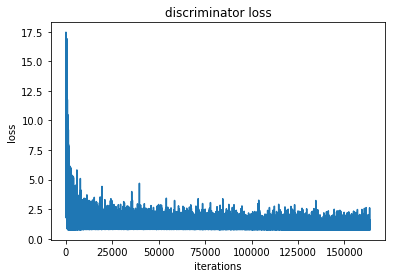

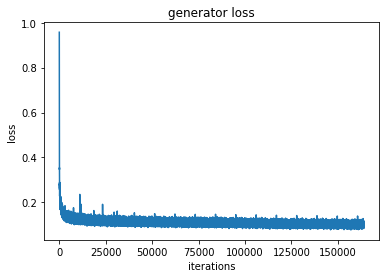

Step 163850: dloss = 0.8090, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8090, gan_loss = 11698.3408 l1_loss = 0.0918
Step 163860: dloss = 1.0752, gloss = 0.0907, real_loss = 0.2463, fake_loss = 0.8288, gan_loss = 12032.6826 l1_loss = 0.0787
Step 163870: dloss = 0.8997, gloss = 0.1027, real_loss = 0.0796, fake_loss = 0.8201, gan_loss = 11974.9727 l1_loss = 0.0907
Step 163880: dloss = 0.7817, gloss = 0.0986, real_loss = 0.0001, fake_loss = 0.7815, gan_loss = 11489.0977 l1_loss = 0.0872
Step 163890: dloss = 0.8487, gloss = 0.1094, real_loss = 0.0526, fake_loss = 0.7962, gan_loss = 11636.3379 l1_loss = 0.0978
Step 163900: dloss = 0.8402, gloss = 0.0896, real_loss = 0.0000, fake_loss = 0.8402, gan_loss = 12025.4150 l1_loss = 0.0776
Step 163910: dloss = 0.8176, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8176, gan_loss = 11817.1631 l1_loss = 0.0863
Step 163920: dloss = 0.8160, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8160, gan_loss = 12024.2686 l1_loss = 0.0929
Step 163

Step 164520: dloss = 0.8060, gloss = 0.1125, real_loss = 0.0000, fake_loss = 0.8060, gan_loss = 12064.8594 l1_loss = 0.1004
Step 164530: dloss = 0.7961, gloss = 0.0940, real_loss = 0.0000, fake_loss = 0.7961, gan_loss = 11753.1367 l1_loss = 0.0823
Step 164540: dloss = 0.8561, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8561, gan_loss = 11652.4053 l1_loss = 0.0889
Step 164550: dloss = 0.8715, gloss = 0.1019, real_loss = 0.0686, fake_loss = 0.8029, gan_loss = 11470.5420 l1_loss = 0.0905
Step 164560: dloss = 0.8060, gloss = 0.1051, real_loss = 0.0001, fake_loss = 0.8059, gan_loss = 11383.1445 l1_loss = 0.0938
Step 164570: dloss = 0.8321, gloss = 0.1092, real_loss = 0.0000, fake_loss = 0.8321, gan_loss = 12198.8359 l1_loss = 0.0970
Step 164580: dloss = 0.8381, gloss = 0.0901, real_loss = 0.0000, fake_loss = 0.8381, gan_loss = 11770.9043 l1_loss = 0.0783
Step 164590: dloss = 0.8196, gloss = 0.0883, real_loss = 0.0000, fake_loss = 0.8196, gan_loss = 11545.6074 l1_loss = 0.0768
Step 164

Step 165190: dloss = 0.7989, gloss = 0.0997, real_loss = 0.0028, fake_loss = 0.7962, gan_loss = 11715.5000 l1_loss = 0.0880
Step 165200: dloss = 0.8339, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8339, gan_loss = 11537.9258 l1_loss = 0.0888
Step 165210: dloss = 0.7863, gloss = 0.0993, real_loss = 0.0000, fake_loss = 0.7863, gan_loss = 11786.9453 l1_loss = 0.0876
Step 165220: dloss = 0.8017, gloss = 0.0836, real_loss = 0.0000, fake_loss = 0.8017, gan_loss = 11683.3428 l1_loss = 0.0719
Step 165230: dloss = 0.8145, gloss = 0.0932, real_loss = 0.0000, fake_loss = 0.8145, gan_loss = 11293.2549 l1_loss = 0.0819
Step 165240: dloss = 0.8143, gloss = 0.0943, real_loss = 0.0000, fake_loss = 0.8143, gan_loss = 11161.8789 l1_loss = 0.0831
Step 165250: dloss = 0.7999, gloss = 0.1096, real_loss = 0.0000, fake_loss = 0.7999, gan_loss = 11762.9297 l1_loss = 0.0978
Step 165260: dloss = 0.7973, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.7973, gan_loss = 12106.7881 l1_loss = 0.0851
Step 165

Step 165860: dloss = 0.8338, gloss = 0.0944, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 11830.5996 l1_loss = 0.0826
Step 165870: dloss = 0.7880, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.7880, gan_loss = 11623.4336 l1_loss = 0.0936
Step 165880: dloss = 0.7897, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7897, gan_loss = 11645.4639 l1_loss = 0.0911
Step 165890: dloss = 0.8117, gloss = 0.1077, real_loss = 0.0000, fake_loss = 0.8117, gan_loss = 11954.1094 l1_loss = 0.0958
Step 165900: dloss = 0.8267, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8267, gan_loss = 11843.4121 l1_loss = 0.0870
Step 165910: dloss = 0.8120, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8120, gan_loss = 11571.7080 l1_loss = 0.0888
Step 165920: dloss = 0.7724, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7724, gan_loss = 11632.9600 l1_loss = 0.0911
Step 165930: dloss = 0.8041, gloss = 0.1134, real_loss = 0.0000, fake_loss = 0.8041, gan_loss = 11704.2168 l1_loss = 0.1017
Step 165

Step 166530: dloss = 0.8144, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8144, gan_loss = 11787.0244 l1_loss = 0.0906
Step 166540: dloss = 0.8147, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8147, gan_loss = 11842.3271 l1_loss = 0.0836
Step 166550: dloss = 1.4998, gloss = 0.1071, real_loss = 0.6731, fake_loss = 0.8267, gan_loss = 11574.4014 l1_loss = 0.0956
Step 166560: dloss = 0.8278, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8278, gan_loss = 11339.8877 l1_loss = 0.0976
Step 166570: dloss = 0.8187, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8187, gan_loss = 11867.1025 l1_loss = 0.0996
Step 166580: dloss = 0.8205, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8205, gan_loss = 11700.3574 l1_loss = 0.0885
Step 166590: dloss = 0.9528, gloss = 0.1019, real_loss = 0.1320, fake_loss = 0.8208, gan_loss = 11473.5830 l1_loss = 0.0905
Step 166600: dloss = 0.8017, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8017, gan_loss = 11843.9521 l1_loss = 0.0873
Step 166

Step 167200: dloss = 0.8261, gloss = 0.0928, real_loss = 0.0000, fake_loss = 0.8261, gan_loss = 11714.3203 l1_loss = 0.0811
Step 167210: dloss = 0.8140, gloss = 0.1041, real_loss = 0.0000, fake_loss = 0.8140, gan_loss = 11309.1934 l1_loss = 0.0928
Step 167220: dloss = 0.8022, gloss = 0.0971, real_loss = 0.0000, fake_loss = 0.8022, gan_loss = 11427.7070 l1_loss = 0.0857
Step 167230: dloss = 0.7942, gloss = 0.1101, real_loss = 0.0000, fake_loss = 0.7942, gan_loss = 11872.7842 l1_loss = 0.0983
Step 167240: dloss = 0.7860, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.7860, gan_loss = 12609.8984 l1_loss = 0.0932
Step 167250: dloss = 0.8158, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8158, gan_loss = 11650.0166 l1_loss = 0.0971
Step 167260: dloss = 0.7997, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.7997, gan_loss = 11434.2207 l1_loss = 0.0977
Step 167270: dloss = 0.8023, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8023, gan_loss = 11406.3799 l1_loss = 0.0855
Step 167

Step 167870: dloss = 0.8247, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.8247, gan_loss = 11239.2354 l1_loss = 0.0818
Step 167880: dloss = 0.7900, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.7900, gan_loss = 11324.2363 l1_loss = 0.0828
Step 167890: dloss = 0.7858, gloss = 0.0924, real_loss = 0.0000, fake_loss = 0.7858, gan_loss = 11791.3252 l1_loss = 0.0806
Step 167900: dloss = 0.7983, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.7983, gan_loss = 11399.9004 l1_loss = 0.0831
Step 167910: dloss = 0.7826, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.7826, gan_loss = 11817.2490 l1_loss = 0.0967
Step 167920: dloss = 0.7837, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.7837, gan_loss = 11368.4492 l1_loss = 0.0941
Step 167930: dloss = 0.8163, gloss = 0.0933, real_loss = 0.0006, fake_loss = 0.8157, gan_loss = 11209.7129 l1_loss = 0.0821
Step 167940: dloss = 0.7897, gloss = 0.0995, real_loss = 0.0005, fake_loss = 0.7892, gan_loss = 10919.0693 l1_loss = 0.0886
Step 167

Step 168540: dloss = 0.8183, gloss = 0.0901, real_loss = 0.0000, fake_loss = 0.8183, gan_loss = 11174.0137 l1_loss = 0.0789
Step 168550: dloss = 1.2481, gloss = 0.0987, real_loss = 0.4003, fake_loss = 0.8478, gan_loss = 11582.6152 l1_loss = 0.0871
Step 168560: dloss = 0.8164, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8164, gan_loss = 11748.8506 l1_loss = 0.0933
Step 168570: dloss = 0.8306, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8306, gan_loss = 11571.4375 l1_loss = 0.0908
Step 168580: dloss = 0.8305, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8305, gan_loss = 11531.3135 l1_loss = 0.0948
Step 168590: dloss = 0.8143, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8143, gan_loss = 11478.5928 l1_loss = 0.0999
Step 168600: dloss = 0.8160, gloss = 0.0901, real_loss = 0.0000, fake_loss = 0.8160, gan_loss = 11362.6445 l1_loss = 0.0787
Step 168610: dloss = 0.8108, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.8108, gan_loss = 11393.2988 l1_loss = 0.0926
Step 168

Step 169210: dloss = 0.8068, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8068, gan_loss = 11217.7334 l1_loss = 0.0880
Step 169220: dloss = 0.8298, gloss = 0.0953, real_loss = 0.0000, fake_loss = 0.8298, gan_loss = 11712.3418 l1_loss = 0.0835
Step 169230: dloss = 0.8009, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.8009, gan_loss = 11856.4023 l1_loss = 0.0856
Step 169240: dloss = 0.7846, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.7846, gan_loss = 11698.5078 l1_loss = 0.0899
Step 169250: dloss = 0.8332, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8332, gan_loss = 11829.9756 l1_loss = 0.0887
Step 169260: dloss = 1.7431, gloss = 0.0973, real_loss = 0.9537, fake_loss = 0.7894, gan_loss = 11728.4756 l1_loss = 0.0855
Step 169270: dloss = 0.8374, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8374, gan_loss = 11412.7041 l1_loss = 0.0935
Step 169280: dloss = 0.8252, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8252, gan_loss = 11544.8027 l1_loss = 0.0858
Step 169

Step 169880: dloss = 0.8079, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8079, gan_loss = 11258.8643 l1_loss = 0.0895
Step 169890: dloss = 0.8161, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.8161, gan_loss = 11499.2266 l1_loss = 0.0961
Step 169900: dloss = 0.8235, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 11494.5791 l1_loss = 0.0885
Step 169910: dloss = 0.7894, gloss = 0.0964, real_loss = 0.0000, fake_loss = 0.7894, gan_loss = 11505.4619 l1_loss = 0.0849
Step 169920: dloss = 0.8040, gloss = 0.0938, real_loss = 0.0000, fake_loss = 0.8040, gan_loss = 11166.9492 l1_loss = 0.0826
Step 169930: dloss = 0.8106, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8106, gan_loss = 11720.1416 l1_loss = 0.0883
Step 169940: dloss = 0.7975, gloss = 0.0923, real_loss = 0.0000, fake_loss = 0.7975, gan_loss = 11455.0703 l1_loss = 0.0809
Step 169950: dloss = 0.8271, gloss = 0.0908, real_loss = 0.0295, fake_loss = 0.7975, gan_loss = 11605.3623 l1_loss = 0.0792
Step 169

Step 170550: dloss = 0.8128, gloss = 0.1070, real_loss = 0.0000, fake_loss = 0.8128, gan_loss = 11719.4229 l1_loss = 0.0953
Step 170560: dloss = 0.8118, gloss = 0.0878, real_loss = 0.0000, fake_loss = 0.8118, gan_loss = 11437.7842 l1_loss = 0.0764
Step 170570: dloss = 0.7903, gloss = 0.1062, real_loss = 0.0002, fake_loss = 0.7901, gan_loss = 11087.4844 l1_loss = 0.0951
Step 170580: dloss = 0.8877, gloss = 0.1052, real_loss = 0.0846, fake_loss = 0.8030, gan_loss = 11583.5771 l1_loss = 0.0936
Step 170590: dloss = 0.8066, gloss = 0.0913, real_loss = 0.0000, fake_loss = 0.8066, gan_loss = 11580.4717 l1_loss = 0.0797
Step 170600: dloss = 0.8242, gloss = 0.1005, real_loss = 0.0030, fake_loss = 0.8212, gan_loss = 11137.7861 l1_loss = 0.0893
Step 170610: dloss = 0.7750, gloss = 0.0957, real_loss = 0.0000, fake_loss = 0.7750, gan_loss = 11116.0352 l1_loss = 0.0845
Step 170620: dloss = 0.8220, gloss = 0.0962, real_loss = 0.0000, fake_loss = 0.8220, gan_loss = 11696.1143 l1_loss = 0.0845
Step 170

Step 171220: dloss = 0.8340, gloss = 0.0900, real_loss = 0.0005, fake_loss = 0.8334, gan_loss = 11295.6650 l1_loss = 0.0787
Step 171230: dloss = 0.7948, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.7948, gan_loss = 11260.3857 l1_loss = 0.0903
Step 171240: dloss = 0.8123, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.8123, gan_loss = 11225.5674 l1_loss = 0.0825
Step 171250: dloss = 1.0798, gloss = 0.1011, real_loss = 0.2557, fake_loss = 0.8240, gan_loss = 11513.8896 l1_loss = 0.0896
Step 171260: dloss = 0.8204, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8204, gan_loss = 11143.3242 l1_loss = 0.0948
Step 171270: dloss = 0.7940, gloss = 0.0939, real_loss = 0.0000, fake_loss = 0.7940, gan_loss = 11326.2324 l1_loss = 0.0825
Step 171280: dloss = 0.9629, gloss = 0.0959, real_loss = 0.1700, fake_loss = 0.7929, gan_loss = 10818.0615 l1_loss = 0.0851
Step 171290: dloss = 0.8382, gloss = 0.0940, real_loss = 0.0000, fake_loss = 0.8382, gan_loss = 11205.9902 l1_loss = 0.0828
Step 171

Step 171890: dloss = 0.7935, gloss = 0.1111, real_loss = 0.0000, fake_loss = 0.7935, gan_loss = 11679.3936 l1_loss = 0.0995
Step 171900: dloss = 0.8063, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8063, gan_loss = 11181.4834 l1_loss = 0.0944
Step 171910: dloss = 0.8168, gloss = 0.0943, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 11158.1309 l1_loss = 0.0832
Step 171920: dloss = 0.7951, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.7951, gan_loss = 11171.0381 l1_loss = 0.0868
Step 171930: dloss = 1.3022, gloss = 0.0948, real_loss = 0.4669, fake_loss = 0.8353, gan_loss = 11755.7559 l1_loss = 0.0830
Step 171940: dloss = 0.8002, gloss = 0.1019, real_loss = 0.0007, fake_loss = 0.7995, gan_loss = 11147.5889 l1_loss = 0.0908
Step 171950: dloss = 0.8084, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.8084, gan_loss = 10987.7129 l1_loss = 0.0862
Step 171960: dloss = 0.8156, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8156, gan_loss = 11197.0439 l1_loss = 0.0935
Step 171

Step 172560: dloss = 0.8137, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.8137, gan_loss = 11538.3193 l1_loss = 0.0822
Step 172570: dloss = 0.8055, gloss = 0.1044, real_loss = 0.0003, fake_loss = 0.8053, gan_loss = 11541.7061 l1_loss = 0.0928
Step 172580: dloss = 0.8038, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.8038, gan_loss = 11485.5693 l1_loss = 0.0820
Step 172590: dloss = 0.8079, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.8079, gan_loss = 11425.4385 l1_loss = 0.0860
Step 172600: dloss = 0.7931, gloss = 0.1004, real_loss = 0.0001, fake_loss = 0.7930, gan_loss = 11246.0508 l1_loss = 0.0891
Step 172610: dloss = 0.7913, gloss = 0.1011, real_loss = 0.0000, fake_loss = 0.7913, gan_loss = 11110.6543 l1_loss = 0.0900
Step 172620: dloss = 0.8135, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.8135, gan_loss = 11523.1748 l1_loss = 0.0844
Step 172630: dloss = 0.8283, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8283, gan_loss = 11218.6357 l1_loss = 0.0866
Step 172

Step 173230: dloss = 0.8133, gloss = 0.0849, real_loss = 0.0000, fake_loss = 0.8133, gan_loss = 11318.3066 l1_loss = 0.0736
Step 173240: dloss = 0.8061, gloss = 0.0993, real_loss = 0.0000, fake_loss = 0.8061, gan_loss = 11475.8291 l1_loss = 0.0878
Step 173250: dloss = 0.7907, gloss = 0.1105, real_loss = 0.0029, fake_loss = 0.7878, gan_loss = 11080.2812 l1_loss = 0.0994
Step 173260: dloss = 0.8018, gloss = 0.0919, real_loss = 0.0000, fake_loss = 0.8018, gan_loss = 11291.9902 l1_loss = 0.0806
Step 173270: dloss = 0.7972, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.7972, gan_loss = 11021.0312 l1_loss = 0.0868
Step 173280: dloss = 0.8063, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8063, gan_loss = 11579.6406 l1_loss = 0.0876
Step 173290: dloss = 0.7776, gloss = 0.1203, real_loss = 0.0000, fake_loss = 0.7776, gan_loss = 11313.9307 l1_loss = 0.1090
Step 173300: dloss = 0.8258, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.8258, gan_loss = 11270.3066 l1_loss = 0.0903
Step 173

Step 173900: dloss = 0.8198, gloss = 0.1138, real_loss = 0.0000, fake_loss = 0.8198, gan_loss = 11131.2344 l1_loss = 0.1027
Step 173910: dloss = 0.8112, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8112, gan_loss = 11334.0518 l1_loss = 0.0892
Step 173920: dloss = 0.8221, gloss = 0.0875, real_loss = 0.0000, fake_loss = 0.8220, gan_loss = 11175.7988 l1_loss = 0.0763
Step 173930: dloss = 0.7889, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.7889, gan_loss = 11478.7852 l1_loss = 0.0858
Step 173940: dloss = 0.8042, gloss = 0.0962, real_loss = 0.0000, fake_loss = 0.8042, gan_loss = 11335.5371 l1_loss = 0.0848
Step 173950: dloss = 0.8138, gloss = 0.0813, real_loss = 0.0000, fake_loss = 0.8138, gan_loss = 10995.1455 l1_loss = 0.0703
Step 173960: dloss = 0.8085, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8085, gan_loss = 11212.4277 l1_loss = 0.0868
Step 173970: dloss = 0.8163, gloss = 0.0931, real_loss = 0.0000, fake_loss = 0.8163, gan_loss = 11249.3623 l1_loss = 0.0818
Step 173

Step 174570: dloss = 0.7950, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.7950, gan_loss = 10815.9414 l1_loss = 0.0878
Step 174580: dloss = 0.7679, gloss = 0.0963, real_loss = 0.0000, fake_loss = 0.7679, gan_loss = 11070.5264 l1_loss = 0.0853
Step 174590: dloss = 0.8377, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8377, gan_loss = 10847.5547 l1_loss = 0.0868
Step 174600: dloss = 0.8088, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.8088, gan_loss = 11085.3350 l1_loss = 0.0886
Step 174610: dloss = 0.7881, gloss = 0.0952, real_loss = 0.0000, fake_loss = 0.7881, gan_loss = 11246.9258 l1_loss = 0.0839
Step 174620: dloss = 0.8526, gloss = 0.0995, real_loss = 0.0441, fake_loss = 0.8084, gan_loss = 11122.2471 l1_loss = 0.0884
Step 174630: dloss = 0.8075, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.8075, gan_loss = 11066.4180 l1_loss = 0.0914
Step 174640: dloss = 0.8101, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8101, gan_loss = 11176.2217 l1_loss = 0.0942
Step 174

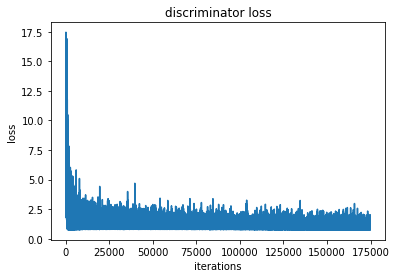

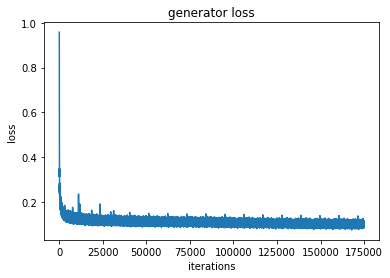

Step 174770: dloss = 0.7950, gloss = 0.1162, real_loss = 0.0000, fake_loss = 0.7950, gan_loss = 11038.7314 l1_loss = 0.1051
Step 174780: dloss = 0.7849, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.7849, gan_loss = 11006.4795 l1_loss = 0.0966
Step 174790: dloss = 0.9284, gloss = 0.0937, real_loss = 0.1269, fake_loss = 0.8014, gan_loss = 11388.2412 l1_loss = 0.0823
Step 174800: dloss = 0.8329, gloss = 0.0926, real_loss = 0.0000, fake_loss = 0.8329, gan_loss = 10797.5352 l1_loss = 0.0818
Step 174810: dloss = 0.7982, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.7981, gan_loss = 10998.0322 l1_loss = 0.0865
Step 174820: dloss = 0.8354, gloss = 0.0843, real_loss = 0.0000, fake_loss = 0.8354, gan_loss = 10949.1914 l1_loss = 0.0734
Step 174830: dloss = 0.8016, gloss = 0.0925, real_loss = 0.0000, fake_loss = 0.8016, gan_loss = 11429.9053 l1_loss = 0.0811
Step 174840: dloss = 0.8145, gloss = 0.0905, real_loss = 0.0000, fake_loss = 0.8145, gan_loss = 11332.1621 l1_loss = 0.0792
Step 174

Step 175440: dloss = 0.8181, gloss = 0.1008, real_loss = 0.0000, fake_loss = 0.8181, gan_loss = 11110.7451 l1_loss = 0.0897
Step 175450: dloss = 0.8205, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.8205, gan_loss = 11071.6523 l1_loss = 0.0834
Step 175460: dloss = 0.8051, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8051, gan_loss = 11176.9414 l1_loss = 0.0921
Step 175470: dloss = 0.7869, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.7869, gan_loss = 11181.6123 l1_loss = 0.0896
Step 175480: dloss = 0.7925, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.7925, gan_loss = 11178.8389 l1_loss = 0.0857
Step 175490: dloss = 0.9569, gloss = 0.0899, real_loss = 0.1526, fake_loss = 0.8043, gan_loss = 11228.2695 l1_loss = 0.0787
Step 175500: dloss = 0.8186, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8186, gan_loss = 11097.3799 l1_loss = 0.0937
Step 175510: dloss = 0.7908, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.7908, gan_loss = 10746.9248 l1_loss = 0.0891
Step 175

Step 176110: dloss = 0.7909, gloss = 0.0963, real_loss = 0.0000, fake_loss = 0.7909, gan_loss = 11152.8613 l1_loss = 0.0851
Step 176120: dloss = 0.8308, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8308, gan_loss = 11238.5801 l1_loss = 0.0893
Step 176130: dloss = 0.9285, gloss = 0.0936, real_loss = 0.1058, fake_loss = 0.8226, gan_loss = 11253.9023 l1_loss = 0.0824
Step 176140: dloss = 0.8551, gloss = 0.0888, real_loss = 0.0000, fake_loss = 0.8551, gan_loss = 11075.3379 l1_loss = 0.0777
Step 176150: dloss = 0.9398, gloss = 0.0988, real_loss = 0.1331, fake_loss = 0.8067, gan_loss = 11190.0693 l1_loss = 0.0876
Step 176160: dloss = 1.5640, gloss = 0.0932, real_loss = 0.7682, fake_loss = 0.7958, gan_loss = 11152.6660 l1_loss = 0.0820
Step 176170: dloss = 0.8180, gloss = 0.0863, real_loss = 0.0005, fake_loss = 0.8175, gan_loss = 10891.5684 l1_loss = 0.0755
Step 176180: dloss = 0.8307, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.8307, gan_loss = 10347.1758 l1_loss = 0.0838
Step 176

Step 176780: dloss = 0.8895, gloss = 0.1011, real_loss = 0.0709, fake_loss = 0.8186, gan_loss = 10844.0635 l1_loss = 0.0903
Step 176790: dloss = 0.8050, gloss = 0.1137, real_loss = 0.0000, fake_loss = 0.8050, gan_loss = 11009.5879 l1_loss = 0.1027
Step 176800: dloss = 0.7999, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.7999, gan_loss = 10943.4307 l1_loss = 0.0890
Step 176810: dloss = 0.8121, gloss = 0.1096, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 11047.5410 l1_loss = 0.0986
Step 176820: dloss = 0.8235, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 11234.7148 l1_loss = 0.0806
Step 176830: dloss = 0.8188, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.8188, gan_loss = 11236.9766 l1_loss = 0.0863
Step 176840: dloss = 0.8015, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8015, gan_loss = 11207.4062 l1_loss = 0.0853
Step 176850: dloss = 0.8014, gloss = 0.1097, real_loss = 0.0185, fake_loss = 0.7829, gan_loss = 11048.5938 l1_loss = 0.0986
Step 176

Step 177450: dloss = 1.4677, gloss = 0.1040, real_loss = 0.6811, fake_loss = 0.7865, gan_loss = 11255.9336 l1_loss = 0.0927
Step 177460: dloss = 0.8346, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8346, gan_loss = 10846.7373 l1_loss = 0.0846
Step 177470: dloss = 0.8148, gloss = 0.1029, real_loss = 0.0000, fake_loss = 0.8148, gan_loss = 10941.8916 l1_loss = 0.0919
Step 177480: dloss = 1.3230, gloss = 0.0980, real_loss = 0.5491, fake_loss = 0.7739, gan_loss = 10876.3770 l1_loss = 0.0871
Step 177490: dloss = 0.8078, gloss = 0.1056, real_loss = 0.0000, fake_loss = 0.8078, gan_loss = 11151.4805 l1_loss = 0.0945
Step 177500: dloss = 0.9410, gloss = 0.0996, real_loss = 0.1213, fake_loss = 0.8197, gan_loss = 11200.5596 l1_loss = 0.0884
Step 177510: dloss = 0.8075, gloss = 0.0983, real_loss = 0.0004, fake_loss = 0.8070, gan_loss = 11289.7480 l1_loss = 0.0870
Step 177520: dloss = 0.7924, gloss = 0.0988, real_loss = 0.0000, fake_loss = 0.7924, gan_loss = 10691.8535 l1_loss = 0.0881
Step 177

Step 178120: dloss = 0.8152, gloss = 0.0938, real_loss = 0.0000, fake_loss = 0.8152, gan_loss = 10878.8447 l1_loss = 0.0829
Step 178130: dloss = 0.7957, gloss = 0.1096, real_loss = 0.0000, fake_loss = 0.7957, gan_loss = 10739.7793 l1_loss = 0.0988
Step 178140: dloss = 0.8102, gloss = 0.0844, real_loss = 0.0000, fake_loss = 0.8102, gan_loss = 10704.8721 l1_loss = 0.0737
Step 178150: dloss = 0.8032, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.8032, gan_loss = 10794.2549 l1_loss = 0.0810
Step 178160: dloss = 0.9530, gloss = 0.1104, real_loss = 0.1734, fake_loss = 0.7796, gan_loss = 10985.7598 l1_loss = 0.0994
Step 178170: dloss = 0.8262, gloss = 0.1017, real_loss = 0.0000, fake_loss = 0.8262, gan_loss = 10890.2539 l1_loss = 0.0908
Step 178180: dloss = 0.8086, gloss = 0.0947, real_loss = 0.0002, fake_loss = 0.8084, gan_loss = 10831.0605 l1_loss = 0.0839
Step 178190: dloss = 0.7958, gloss = 0.1084, real_loss = 0.0000, fake_loss = 0.7958, gan_loss = 11129.9053 l1_loss = 0.0973
Step 178

Step 178790: dloss = 0.8113, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8113, gan_loss = 11357.3701 l1_loss = 0.0870
Step 178800: dloss = 0.7952, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.7952, gan_loss = 11232.0000 l1_loss = 0.0990
Step 178810: dloss = 0.7998, gloss = 0.0920, real_loss = 0.0025, fake_loss = 0.7973, gan_loss = 10725.8496 l1_loss = 0.0813
Step 178820: dloss = 0.7967, gloss = 0.1127, real_loss = 0.0000, fake_loss = 0.7967, gan_loss = 11137.2852 l1_loss = 0.1015
Step 178830: dloss = 0.8066, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8066, gan_loss = 11009.3926 l1_loss = 0.1020
Step 178840: dloss = 0.8221, gloss = 0.0902, real_loss = 0.0000, fake_loss = 0.8221, gan_loss = 11288.5186 l1_loss = 0.0789
Step 178850: dloss = 0.8659, gloss = 0.1001, real_loss = 0.0697, fake_loss = 0.7962, gan_loss = 10818.4160 l1_loss = 0.0893
Step 178860: dloss = 0.8027, gloss = 0.0949, real_loss = 0.0000, fake_loss = 0.8027, gan_loss = 10742.0166 l1_loss = 0.0842
Step 178

Step 179460: dloss = 0.8475, gloss = 0.0909, real_loss = 0.0000, fake_loss = 0.8475, gan_loss = 11027.2441 l1_loss = 0.0798
Step 179470: dloss = 0.8017, gloss = 0.1072, real_loss = 0.0000, fake_loss = 0.8017, gan_loss = 11181.8467 l1_loss = 0.0960
Step 179480: dloss = 0.7967, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.7967, gan_loss = 10696.0439 l1_loss = 0.0918
Step 179490: dloss = 0.8111, gloss = 0.1051, real_loss = 0.0000, fake_loss = 0.8111, gan_loss = 10569.7227 l1_loss = 0.0945
Step 179500: dloss = 0.8251, gloss = 0.0906, real_loss = 0.0000, fake_loss = 0.8251, gan_loss = 10919.0361 l1_loss = 0.0797
Step 179510: dloss = 0.7887, gloss = 0.1077, real_loss = 0.0000, fake_loss = 0.7887, gan_loss = 10592.9004 l1_loss = 0.0971
Step 179520: dloss = 0.8027, gloss = 0.0943, real_loss = 0.0000, fake_loss = 0.8027, gan_loss = 10737.0488 l1_loss = 0.0836
Step 179530: dloss = 0.8034, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8034, gan_loss = 11117.2871 l1_loss = 0.0855
Step 179

Step 180130: dloss = 0.8213, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8213, gan_loss = 10796.0547 l1_loss = 0.0875
Step 180140: dloss = 0.8031, gloss = 0.0921, real_loss = 0.0000, fake_loss = 0.8031, gan_loss = 10775.2900 l1_loss = 0.0813
Step 180150: dloss = 0.7943, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.7943, gan_loss = 10708.0967 l1_loss = 0.0887
Step 180160: dloss = 0.8193, gloss = 0.1011, real_loss = 0.0201, fake_loss = 0.7992, gan_loss = 10713.7441 l1_loss = 0.0904
Step 180170: dloss = 0.8052, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8052, gan_loss = 10992.7783 l1_loss = 0.0943
Step 180180: dloss = 0.8040, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8040, gan_loss = 10869.1318 l1_loss = 0.0941
Step 180190: dloss = 0.8034, gloss = 0.0925, real_loss = 0.0003, fake_loss = 0.8030, gan_loss = 10651.8721 l1_loss = 0.0818
Step 180200: dloss = 0.7884, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.7884, gan_loss = 10968.9512 l1_loss = 0.0884
Step 180

Step 180800: dloss = 0.8113, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8113, gan_loss = 10863.7588 l1_loss = 0.0887
Step 180810: dloss = 0.7983, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.7983, gan_loss = 10763.0420 l1_loss = 0.1022
Step 180820: dloss = 0.8119, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8119, gan_loss = 11018.6094 l1_loss = 0.0912
Step 180830: dloss = 0.7924, gloss = 0.1008, real_loss = 0.0000, fake_loss = 0.7924, gan_loss = 10549.5146 l1_loss = 0.0902
Step 180840: dloss = 0.8257, gloss = 0.0881, real_loss = 0.0001, fake_loss = 0.8256, gan_loss = 10644.2695 l1_loss = 0.0775
Step 180850: dloss = 0.8063, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.8063, gan_loss = 10574.6562 l1_loss = 0.0828
Step 180860: dloss = 1.1419, gloss = 0.0958, real_loss = 0.3210, fake_loss = 0.8209, gan_loss = 10510.1445 l1_loss = 0.0853
Step 180870: dloss = 0.8152, gloss = 0.0984, real_loss = 0.0000, fake_loss = 0.8152, gan_loss = 10713.0781 l1_loss = 0.0877
Step 180

Step 181470: dloss = 1.4748, gloss = 0.0918, real_loss = 0.6699, fake_loss = 0.8048, gan_loss = 10861.6182 l1_loss = 0.0810
Step 181480: dloss = 0.7903, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.7903, gan_loss = 10839.5146 l1_loss = 0.0883
Step 181490: dloss = 0.8264, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8264, gan_loss = 10565.8281 l1_loss = 0.0901
Step 181500: dloss = 0.8255, gloss = 0.0903, real_loss = 0.0000, fake_loss = 0.8255, gan_loss = 10855.2305 l1_loss = 0.0794
Step 181510: dloss = 0.8357, gloss = 0.1183, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 11138.5889 l1_loss = 0.1072
Step 181520: dloss = 0.8081, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8081, gan_loss = 10729.2148 l1_loss = 0.0923
Step 181530: dloss = 0.7988, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.7988, gan_loss = 10531.4033 l1_loss = 0.0884
Step 181540: dloss = 0.7842, gloss = 0.1067, real_loss = 0.0000, fake_loss = 0.7842, gan_loss = 10665.4326 l1_loss = 0.0960
Step 181

Step 182140: dloss = 0.8014, gloss = 0.0907, real_loss = 0.0000, fake_loss = 0.8014, gan_loss = 10304.2432 l1_loss = 0.0804
Step 182150: dloss = 0.7830, gloss = 0.1142, real_loss = 0.0000, fake_loss = 0.7830, gan_loss = 10456.6426 l1_loss = 0.1037
Step 182160: dloss = 0.8071, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.8071, gan_loss = 11143.1689 l1_loss = 0.0925
Step 182170: dloss = 0.8030, gloss = 0.0851, real_loss = 0.0000, fake_loss = 0.8030, gan_loss = 10697.8359 l1_loss = 0.0744
Step 182180: dloss = 0.8037, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8037, gan_loss = 10679.3770 l1_loss = 0.0858
Step 182190: dloss = 0.7822, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.7822, gan_loss = 10875.4014 l1_loss = 0.0866
Step 182200: dloss = 0.8100, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.8100, gan_loss = 10701.5205 l1_loss = 0.0940
Step 182210: dloss = 0.8952, gloss = 0.1115, real_loss = 0.0939, fake_loss = 0.8013, gan_loss = 10661.3877 l1_loss = 0.1008
Step 182

Step 182810: dloss = 0.8301, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8301, gan_loss = 10834.8730 l1_loss = 0.0888
Step 182820: dloss = 0.7935, gloss = 0.0950, real_loss = 0.0000, fake_loss = 0.7935, gan_loss = 10905.1885 l1_loss = 0.0841
Step 182830: dloss = 0.7984, gloss = 0.0984, real_loss = 0.0000, fake_loss = 0.7984, gan_loss = 11150.0537 l1_loss = 0.0873
Step 182840: dloss = 0.8129, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.8129, gan_loss = 11095.1650 l1_loss = 0.0910
Step 182850: dloss = 0.8205, gloss = 0.0973, real_loss = 0.0240, fake_loss = 0.7964, gan_loss = 10773.6465 l1_loss = 0.0866
Step 182860: dloss = 0.8168, gloss = 0.0916, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 10534.9902 l1_loss = 0.0811
Step 182870: dloss = 0.7882, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.7882, gan_loss = 10902.7012 l1_loss = 0.0916
Step 182880: dloss = 1.0852, gloss = 0.1064, real_loss = 0.2774, fake_loss = 0.8079, gan_loss = 10717.8906 l1_loss = 0.0956
Step 182

Step 183480: dloss = 0.7786, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.7786, gan_loss = 10470.4580 l1_loss = 0.0894
Step 183490: dloss = 0.8350, gloss = 0.0821, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 10702.4775 l1_loss = 0.0714
Step 183500: dloss = 0.8110, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8110, gan_loss = 10639.4258 l1_loss = 0.0861
Step 183510: dloss = 0.7745, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.7745, gan_loss = 10892.0400 l1_loss = 0.0917
Step 183520: dloss = 1.1034, gloss = 0.1062, real_loss = 0.3208, fake_loss = 0.7827, gan_loss = 10743.5049 l1_loss = 0.0954
Step 183530: dloss = 1.5860, gloss = 0.0962, real_loss = 0.7752, fake_loss = 0.8109, gan_loss = 10681.6543 l1_loss = 0.0856
Step 183540: dloss = 0.7536, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.7536, gan_loss = 10759.6602 l1_loss = 0.0928
Step 183550: dloss = 0.8135, gloss = 0.1095, real_loss = 0.0000, fake_loss = 0.8135, gan_loss = 10946.8027 l1_loss = 0.0985
Step 183

Step 184150: dloss = 0.7949, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.7949, gan_loss = 10713.4834 l1_loss = 0.0866
Step 184160: dloss = 0.7764, gloss = 0.1047, real_loss = 0.0000, fake_loss = 0.7764, gan_loss = 10445.3623 l1_loss = 0.0943
Step 184170: dloss = 0.8174, gloss = 0.0951, real_loss = 0.0000, fake_loss = 0.8174, gan_loss = 10689.9189 l1_loss = 0.0844
Step 184180: dloss = 0.8094, gloss = 0.1097, real_loss = 0.0174, fake_loss = 0.7920, gan_loss = 10521.6768 l1_loss = 0.0992
Step 184190: dloss = 0.7761, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.7761, gan_loss = 10539.0254 l1_loss = 0.0914
Step 184200: dloss = 0.8106, gloss = 0.0916, real_loss = 0.0000, fake_loss = 0.8106, gan_loss = 10629.2275 l1_loss = 0.0810
Step 184210: dloss = 0.8042, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8042, gan_loss = 10619.1748 l1_loss = 0.0883
Step 184220: dloss = 0.8055, gloss = 0.0932, real_loss = 0.0000, fake_loss = 0.8055, gan_loss = 10657.3701 l1_loss = 0.0825
Step 184

Step 184820: dloss = 0.7841, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.7841, gan_loss = 10959.3828 l1_loss = 0.0952
Step 184830: dloss = 0.8084, gloss = 0.0969, real_loss = 0.0000, fake_loss = 0.8084, gan_loss = 10566.4268 l1_loss = 0.0863
Step 184840: dloss = 0.8182, gloss = 0.0970, real_loss = 0.0000, fake_loss = 0.8182, gan_loss = 10081.8076 l1_loss = 0.0870
Step 184850: dloss = 0.7895, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.7895, gan_loss = 10351.5771 l1_loss = 0.0862
Step 184860: dloss = 0.7789, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.7789, gan_loss = 10917.6641 l1_loss = 0.0910
Step 184870: dloss = 0.7872, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.7872, gan_loss = 10433.3125 l1_loss = 0.0871
Step 184880: dloss = 0.8256, gloss = 0.1050, real_loss = 0.0000, fake_loss = 0.8256, gan_loss = 10626.3135 l1_loss = 0.0943
Step 184890: dloss = 0.8308, gloss = 0.1023, real_loss = 0.0145, fake_loss = 0.8163, gan_loss = 10648.4785 l1_loss = 0.0916
Step 184

Step 185490: dloss = 0.8203, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8203, gan_loss = 10689.0625 l1_loss = 0.0873
Step 185500: dloss = 0.8280, gloss = 0.0928, real_loss = 0.0000, fake_loss = 0.8280, gan_loss = 11118.8789 l1_loss = 0.0816
Step 185510: dloss = 0.8129, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8129, gan_loss = 10699.6963 l1_loss = 0.0849
Step 185520: dloss = 0.8069, gloss = 0.1084, real_loss = 0.0000, fake_loss = 0.8069, gan_loss = 10716.9004 l1_loss = 0.0977
Step 185530: dloss = 0.7997, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.7997, gan_loss = 10630.9551 l1_loss = 0.0853
Step 185540: dloss = 0.8226, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8226, gan_loss = 10713.8516 l1_loss = 0.0948
Step 185550: dloss = 0.8178, gloss = 0.0902, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 10673.2637 l1_loss = 0.0795
Step 185560: dloss = 0.7831, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.7831, gan_loss = 10893.3955 l1_loss = 0.0826
Step 185

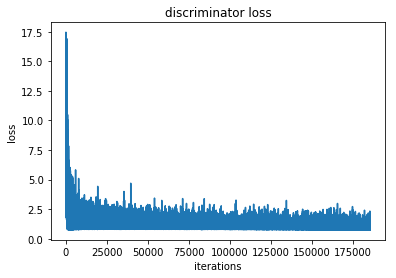

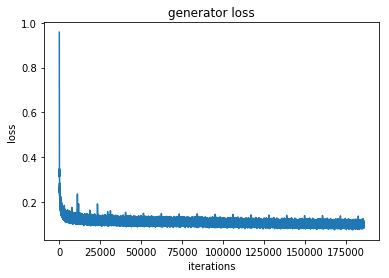

Step 185700: dloss = 0.8026, gloss = 0.0952, real_loss = 0.0000, fake_loss = 0.8026, gan_loss = 10681.6279 l1_loss = 0.0845
Step 185710: dloss = 0.8359, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8359, gan_loss = 10870.4922 l1_loss = 0.1007
Step 185720: dloss = 0.7685, gloss = 0.0893, real_loss = 0.0000, fake_loss = 0.7685, gan_loss = 10786.3359 l1_loss = 0.0785
Step 185730: dloss = 0.8276, gloss = 0.1117, real_loss = 0.0000, fake_loss = 0.8276, gan_loss = 10473.3770 l1_loss = 0.1013
Step 185740: dloss = 0.8152, gloss = 0.0910, real_loss = 0.0000, fake_loss = 0.8152, gan_loss = 10502.9766 l1_loss = 0.0805
Step 185750: dloss = 0.7964, gloss = 0.1018, real_loss = 0.0000, fake_loss = 0.7964, gan_loss = 10510.7354 l1_loss = 0.0913
Step 185760: dloss = 0.8075, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8075, gan_loss = 10652.1416 l1_loss = 0.0953
Step 185770: dloss = 0.8000, gloss = 0.0854, real_loss = 0.0000, fake_loss = 0.8000, gan_loss = 10301.9102 l1_loss = 0.0751
Step 185

Step 186370: dloss = 0.8171, gloss = 0.0897, real_loss = 0.0000, fake_loss = 0.8171, gan_loss = 10421.4355 l1_loss = 0.0793
Step 186380: dloss = 0.7988, gloss = 0.1078, real_loss = 0.0000, fake_loss = 0.7988, gan_loss = 10610.2305 l1_loss = 0.0972
Step 186390: dloss = 0.7923, gloss = 0.0914, real_loss = 0.0000, fake_loss = 0.7923, gan_loss = 10183.7002 l1_loss = 0.0812
Step 186400: dloss = 0.8095, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8095, gan_loss = 10720.2295 l1_loss = 0.0848
Step 186410: dloss = 0.8102, gloss = 0.0916, real_loss = 0.0000, fake_loss = 0.8102, gan_loss = 10356.2109 l1_loss = 0.0812
Step 186420: dloss = 0.8007, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8007, gan_loss = 10474.5801 l1_loss = 0.0855
Step 186430: dloss = 0.8339, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.8339, gan_loss = 10679.2969 l1_loss = 0.0929
Step 186440: dloss = 0.8098, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8098, gan_loss = 10571.7412 l1_loss = 0.0878
Step 186

Step 187040: dloss = 0.8357, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.8357, gan_loss = 11214.0547 l1_loss = 0.0833
Step 187050: dloss = 0.8261, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.8261, gan_loss = 10845.8154 l1_loss = 0.0905
Step 187060: dloss = 0.8853, gloss = 0.1013, real_loss = 0.0806, fake_loss = 0.8047, gan_loss = 10409.2617 l1_loss = 0.0909
Step 187070: dloss = 0.8264, gloss = 0.0873, real_loss = 0.0000, fake_loss = 0.8264, gan_loss = 10306.2236 l1_loss = 0.0770
Step 187080: dloss = 1.2928, gloss = 0.1053, real_loss = 0.4867, fake_loss = 0.8062, gan_loss = 10648.5635 l1_loss = 0.0946
Step 187090: dloss = 0.8273, gloss = 0.1127, real_loss = 0.0083, fake_loss = 0.8191, gan_loss = 10893.0518 l1_loss = 0.1018
Step 187100: dloss = 0.8020, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.8020, gan_loss = 10664.8477 l1_loss = 0.0881
Step 187110: dloss = 0.7972, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.7972, gan_loss = 10471.9160 l1_loss = 0.0888
Step 187

Step 187710: dloss = 0.7986, gloss = 0.0964, real_loss = 0.0000, fake_loss = 0.7986, gan_loss = 10632.4814 l1_loss = 0.0858
Step 187720: dloss = 0.7799, gloss = 0.1133, real_loss = 0.0000, fake_loss = 0.7799, gan_loss = 10258.6445 l1_loss = 0.1031
Step 187730: dloss = 0.8206, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8206, gan_loss = 10361.6660 l1_loss = 0.0899
Step 187740: dloss = 0.7762, gloss = 0.0939, real_loss = 0.0000, fake_loss = 0.7762, gan_loss = 10228.9141 l1_loss = 0.0837
Step 187750: dloss = 0.8311, gloss = 0.0914, real_loss = 0.0000, fake_loss = 0.8311, gan_loss = 10651.4150 l1_loss = 0.0808
Step 187760: dloss = 0.8298, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8298, gan_loss = 10602.6445 l1_loss = 0.0900
Step 187770: dloss = 0.8158, gloss = 0.0943, real_loss = 0.0000, fake_loss = 0.8157, gan_loss = 10387.3018 l1_loss = 0.0840
Step 187780: dloss = 0.7984, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.7984, gan_loss = 10209.6406 l1_loss = 0.0883
Step 187

Step 188380: dloss = 0.7834, gloss = 0.0894, real_loss = 0.0000, fake_loss = 0.7834, gan_loss = 10494.3486 l1_loss = 0.0789
Step 188390: dloss = 0.8350, gloss = 0.0925, real_loss = 0.0000, fake_loss = 0.8350, gan_loss = 10331.4004 l1_loss = 0.0822
Step 188400: dloss = 0.8043, gloss = 0.0938, real_loss = 0.0000, fake_loss = 0.8043, gan_loss = 10347.4492 l1_loss = 0.0834
Step 188410: dloss = 0.7730, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.7730, gan_loss = 10657.3604 l1_loss = 0.0957
Step 188420: dloss = 0.7988, gloss = 0.0852, real_loss = 0.0000, fake_loss = 0.7988, gan_loss = 10316.7842 l1_loss = 0.0748
Step 188430: dloss = 0.8239, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.8239, gan_loss = 10406.9971 l1_loss = 0.0871
Step 188440: dloss = 0.7925, gloss = 0.0953, real_loss = 0.0000, fake_loss = 0.7925, gan_loss = 10813.9287 l1_loss = 0.0845
Step 188450: dloss = 0.8106, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8106, gan_loss = 10616.4727 l1_loss = 0.0897
Step 188

Step 189050: dloss = 0.8178, gloss = 0.0869, real_loss = 0.0000, fake_loss = 0.8178, gan_loss = 10286.0264 l1_loss = 0.0766
Step 189060: dloss = 0.8144, gloss = 0.1011, real_loss = 0.0000, fake_loss = 0.8144, gan_loss = 10464.3721 l1_loss = 0.0906
Step 189070: dloss = 0.8290, gloss = 0.0914, real_loss = 0.0000, fake_loss = 0.8290, gan_loss = 10422.9697 l1_loss = 0.0810
Step 189080: dloss = 0.8030, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.8030, gan_loss = 10709.0371 l1_loss = 0.0957
Step 189090: dloss = 0.8254, gloss = 0.0865, real_loss = 0.0000, fake_loss = 0.8254, gan_loss = 10024.4922 l1_loss = 0.0764
Step 189100: dloss = 0.7872, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.7872, gan_loss = 10522.0322 l1_loss = 0.0900
Step 189110: dloss = 0.8228, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8228, gan_loss = 10975.1445 l1_loss = 0.0867
Step 189120: dloss = 0.8092, gloss = 0.0997, real_loss = 0.0026, fake_loss = 0.8067, gan_loss = 10421.7178 l1_loss = 0.0893
Step 189

Step 189720: dloss = 0.8015, gloss = 0.0985, real_loss = 0.0017, fake_loss = 0.7998, gan_loss = 10517.2080 l1_loss = 0.0880
Step 189730: dloss = 0.8027, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8027, gan_loss = 10584.5586 l1_loss = 0.0920
Step 189740: dloss = 0.7960, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.7959, gan_loss = 10307.5801 l1_loss = 0.0886
Step 189750: dloss = 0.8289, gloss = 0.0955, real_loss = 0.0046, fake_loss = 0.8243, gan_loss = 10757.1523 l1_loss = 0.0847
Step 189760: dloss = 0.8189, gloss = 0.0931, real_loss = 0.0034, fake_loss = 0.8156, gan_loss = 10139.6484 l1_loss = 0.0830
Step 189770: dloss = 1.5205, gloss = 0.0920, real_loss = 0.7114, fake_loss = 0.8091, gan_loss = 10601.4561 l1_loss = 0.0814
Step 189780: dloss = 0.7966, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.7966, gan_loss = 10302.7637 l1_loss = 0.0911
Step 189790: dloss = 0.7878, gloss = 0.0884, real_loss = 0.0000, fake_loss = 0.7878, gan_loss = 10734.1924 l1_loss = 0.0777
Step 189

Step 190390: dloss = 0.8337, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8337, gan_loss = 10112.1943 l1_loss = 0.0895
Step 190400: dloss = 0.7670, gloss = 0.0907, real_loss = 0.0000, fake_loss = 0.7670, gan_loss = 10582.1680 l1_loss = 0.0801
Step 190410: dloss = 0.7883, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.7883, gan_loss = 10222.7686 l1_loss = 0.0933
Step 190420: dloss = 0.8348, gloss = 0.0917, real_loss = 0.0315, fake_loss = 0.8033, gan_loss = 10693.2520 l1_loss = 0.0810
Step 190430: dloss = 0.7626, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.7626, gan_loss = 10469.7822 l1_loss = 0.0952
Step 190440: dloss = 0.8058, gloss = 0.0844, real_loss = 0.0000, fake_loss = 0.8058, gan_loss = 10297.5215 l1_loss = 0.0741
Step 190450: dloss = 0.8243, gloss = 0.1028, real_loss = 0.0156, fake_loss = 0.8087, gan_loss = 10327.1338 l1_loss = 0.0925
Step 190460: dloss = 0.8291, gloss = 0.0992, real_loss = 0.0005, fake_loss = 0.8286, gan_loss = 10373.4189 l1_loss = 0.0888
Step 190

Step 191060: dloss = 0.7611, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.7611, gan_loss = 10532.0186 l1_loss = 0.0825
Step 191070: dloss = 0.8310, gloss = 0.0882, real_loss = 0.0000, fake_loss = 0.8310, gan_loss = 10452.9326 l1_loss = 0.0777
Step 191080: dloss = 0.7848, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.7848, gan_loss = 10403.3262 l1_loss = 0.0833
Step 191090: dloss = 1.8266, gloss = 0.0954, real_loss = 1.0335, fake_loss = 0.7931, gan_loss = 10295.0029 l1_loss = 0.0851
Step 191100: dloss = 0.8147, gloss = 0.0825, real_loss = 0.0000, fake_loss = 0.8147, gan_loss = 10315.8975 l1_loss = 0.0722
Step 191110: dloss = 0.8227, gloss = 0.0892, real_loss = 0.0000, fake_loss = 0.8227, gan_loss = 10575.4219 l1_loss = 0.0787
Step 191120: dloss = 0.8221, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8221, gan_loss = 10438.7578 l1_loss = 0.0968
Step 191130: dloss = 0.7827, gloss = 0.0877, real_loss = 0.0000, fake_loss = 0.7827, gan_loss = 10271.1367 l1_loss = 0.0775
Step 191

Step 191730: dloss = 0.7919, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.7919, gan_loss = 10577.8818 l1_loss = 0.0853
Step 191740: dloss = 0.7978, gloss = 0.0925, real_loss = 0.0001, fake_loss = 0.7978, gan_loss = 10425.9102 l1_loss = 0.0821
Step 191750: dloss = 0.7918, gloss = 0.1074, real_loss = 0.0000, fake_loss = 0.7918, gan_loss = 10226.0039 l1_loss = 0.0972
Step 191760: dloss = 0.8326, gloss = 0.0955, real_loss = 0.0000, fake_loss = 0.8326, gan_loss = 10292.6621 l1_loss = 0.0852
Step 191770: dloss = 0.8355, gloss = 0.0955, real_loss = 0.0000, fake_loss = 0.8355, gan_loss = 10383.0088 l1_loss = 0.0851
Step 191780: dloss = 0.8097, gloss = 0.0901, real_loss = 0.0000, fake_loss = 0.8097, gan_loss = 10109.9277 l1_loss = 0.0799
Step 191790: dloss = 1.3085, gloss = 0.0976, real_loss = 0.5411, fake_loss = 0.7674, gan_loss = 10192.0703 l1_loss = 0.0874
Step 191800: dloss = 0.8263, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8263, gan_loss = 10350.9355 l1_loss = 0.0864
Step 191

Step 192400: dloss = 0.8102, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8102, gan_loss = 10164.6758 l1_loss = 0.0905
Step 192410: dloss = 0.8064, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8064, gan_loss = 10455.5156 l1_loss = 0.0885
Step 192420: dloss = 0.8140, gloss = 0.0898, real_loss = 0.0000, fake_loss = 0.8140, gan_loss = 10257.2637 l1_loss = 0.0795
Step 192430: dloss = 0.8068, gloss = 0.0887, real_loss = 0.0000, fake_loss = 0.8068, gan_loss = 10515.3086 l1_loss = 0.0782
Step 192440: dloss = 0.8200, gloss = 0.0955, real_loss = 0.0000, fake_loss = 0.8200, gan_loss = 10354.8857 l1_loss = 0.0852
Step 192450: dloss = 0.8089, gloss = 0.1122, real_loss = 0.0000, fake_loss = 0.8089, gan_loss = 10415.7646 l1_loss = 0.1018
Step 192460: dloss = 0.8139, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.8139, gan_loss = 10584.6533 l1_loss = 0.0909
Step 192470: dloss = 0.7765, gloss = 0.1036, real_loss = 0.0000, fake_loss = 0.7765, gan_loss = 10372.1133 l1_loss = 0.0932
Step 192

Step 193070: dloss = 0.8092, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8092, gan_loss = 10577.4902 l1_loss = 0.0927
Step 193080: dloss = 0.7927, gloss = 0.0847, real_loss = 0.0000, fake_loss = 0.7927, gan_loss = 10548.2959 l1_loss = 0.0742
Step 193090: dloss = 0.8045, gloss = 0.0923, real_loss = 0.0000, fake_loss = 0.8045, gan_loss = 10236.9463 l1_loss = 0.0820
Step 193100: dloss = 0.8059, gloss = 0.0951, real_loss = 0.0000, fake_loss = 0.8059, gan_loss = 10459.5391 l1_loss = 0.0846
Step 193110: dloss = 0.7992, gloss = 0.1125, real_loss = 0.0000, fake_loss = 0.7992, gan_loss = 10361.3604 l1_loss = 0.1021
Step 193120: dloss = 0.8039, gloss = 0.0899, real_loss = 0.0000, fake_loss = 0.8039, gan_loss = 10136.5146 l1_loss = 0.0798
Step 193130: dloss = 0.8065, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8065, gan_loss = 10301.8457 l1_loss = 0.0959
Step 193140: dloss = 0.8202, gloss = 0.0985, real_loss = 0.0001, fake_loss = 0.8201, gan_loss = 10297.9824 l1_loss = 0.0882
Step 193

Step 193740: dloss = 1.0161, gloss = 0.1089, real_loss = 0.2350, fake_loss = 0.7811, gan_loss = 9978.0615 l1_loss = 0.0989
Step 193750: dloss = 0.8216, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.8216, gan_loss = 10438.3721 l1_loss = 0.0891
Step 193760: dloss = 0.7769, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7769, gan_loss = 10680.7744 l1_loss = 0.0921
Step 193770: dloss = 0.8098, gloss = 0.0969, real_loss = 0.0014, fake_loss = 0.8084, gan_loss = 10242.1162 l1_loss = 0.0867
Step 193780: dloss = 0.8235, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 10425.1230 l1_loss = 0.0813
Step 193790: dloss = 0.7721, gloss = 0.0942, real_loss = 0.0000, fake_loss = 0.7721, gan_loss = 10185.5127 l1_loss = 0.0841
Step 193800: dloss = 0.8024, gloss = 0.0890, real_loss = 0.0000, fake_loss = 0.8024, gan_loss = 9943.6992 l1_loss = 0.0790
Step 193810: dloss = 0.7962, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.7962, gan_loss = 10360.2812 l1_loss = 0.0903
Step 19382

Step 194410: dloss = 0.7962, gloss = 0.0939, real_loss = 0.0000, fake_loss = 0.7962, gan_loss = 10340.7236 l1_loss = 0.0836
Step 194420: dloss = 0.8039, gloss = 0.0896, real_loss = 0.0000, fake_loss = 0.8039, gan_loss = 9886.8135 l1_loss = 0.0797
Step 194430: dloss = 0.8100, gloss = 0.0918, real_loss = 0.0000, fake_loss = 0.8100, gan_loss = 10237.5312 l1_loss = 0.0816
Step 194440: dloss = 0.8006, gloss = 0.0971, real_loss = 0.0000, fake_loss = 0.8006, gan_loss = 10280.1885 l1_loss = 0.0868
Step 194450: dloss = 0.9624, gloss = 0.1004, real_loss = 0.1484, fake_loss = 0.8139, gan_loss = 10405.5010 l1_loss = 0.0900
Step 194460: dloss = 0.8194, gloss = 0.0926, real_loss = 0.0000, fake_loss = 0.8194, gan_loss = 9861.6396 l1_loss = 0.0828
Step 194470: dloss = 0.8299, gloss = 0.1013, real_loss = 0.0000, fake_loss = 0.8299, gan_loss = 10866.3418 l1_loss = 0.0904
Step 194480: dloss = 0.7845, gloss = 0.1013, real_loss = 0.0000, fake_loss = 0.7845, gan_loss = 10179.4727 l1_loss = 0.0911
Step 19449

Step 195080: dloss = 0.7917, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7917, gan_loss = 10131.7012 l1_loss = 0.0926
Step 195090: dloss = 0.8050, gloss = 0.0964, real_loss = 0.0037, fake_loss = 0.8013, gan_loss = 10077.5811 l1_loss = 0.0863
Step 195100: dloss = 0.8046, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8046, gan_loss = 10208.3516 l1_loss = 0.0952
Step 195110: dloss = 0.8064, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.8064, gan_loss = 10071.3340 l1_loss = 0.0848
Step 195120: dloss = 1.2372, gloss = 0.0957, real_loss = 0.4089, fake_loss = 0.8283, gan_loss = 10141.8135 l1_loss = 0.0856
Step 195130: dloss = 0.8229, gloss = 0.1003, real_loss = 0.0000, fake_loss = 0.8229, gan_loss = 10105.4951 l1_loss = 0.0902
Step 195140: dloss = 0.7884, gloss = 0.1122, real_loss = 0.0000, fake_loss = 0.7884, gan_loss = 10059.4834 l1_loss = 0.1022
Step 195150: dloss = 0.8118, gloss = 0.0922, real_loss = 0.0000, fake_loss = 0.8118, gan_loss = 10153.6934 l1_loss = 0.0820
Step 195

Step 195750: dloss = 1.1645, gloss = 0.1079, real_loss = 0.3659, fake_loss = 0.7986, gan_loss = 10357.9639 l1_loss = 0.0975
Step 195760: dloss = 0.7711, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.7711, gan_loss = 10426.8691 l1_loss = 0.0910
Step 195770: dloss = 1.8393, gloss = 0.0975, real_loss = 1.0380, fake_loss = 0.8012, gan_loss = 9971.4629 l1_loss = 0.0875
Step 195780: dloss = 0.8070, gloss = 0.1073, real_loss = 0.0000, fake_loss = 0.8070, gan_loss = 10600.6504 l1_loss = 0.0967
Step 195790: dloss = 0.8044, gloss = 0.0925, real_loss = 0.0000, fake_loss = 0.8044, gan_loss = 10538.4258 l1_loss = 0.0820
Step 195800: dloss = 0.8241, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8241, gan_loss = 10080.3906 l1_loss = 0.0865
Step 195810: dloss = 0.7968, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.7968, gan_loss = 10067.2832 l1_loss = 0.0899
Step 195820: dloss = 0.8139, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8139, gan_loss = 10128.2100 l1_loss = 0.0943
Step 1958

Step 196420: dloss = 0.8216, gloss = 0.0932, real_loss = 0.0000, fake_loss = 0.8216, gan_loss = 9976.5264 l1_loss = 0.0832
Step 196430: dloss = 0.8009, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.8009, gan_loss = 11156.2539 l1_loss = 0.0970
Step 196440: dloss = 0.8006, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.8006, gan_loss = 10060.3994 l1_loss = 0.0872
Step 196450: dloss = 1.0162, gloss = 0.1010, real_loss = 0.2167, fake_loss = 0.7995, gan_loss = 10046.4492 l1_loss = 0.0909
Step 196460: dloss = 0.7765, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.7765, gan_loss = 10094.2607 l1_loss = 0.0961
Step 196470: dloss = 0.8156, gloss = 0.0821, real_loss = 0.0000, fake_loss = 0.8156, gan_loss = 10008.4463 l1_loss = 0.0721
Step 196480: dloss = 0.7937, gloss = 0.1065, real_loss = 0.0000, fake_loss = 0.7937, gan_loss = 10291.6055 l1_loss = 0.0962
Step 196490: dloss = 0.8037, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8037, gan_loss = 10369.0693 l1_loss = 0.0863
Step 1965

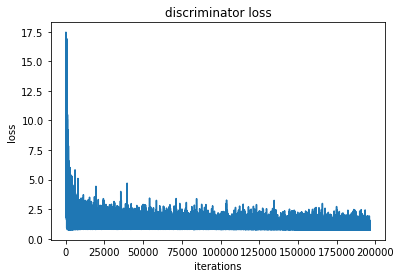

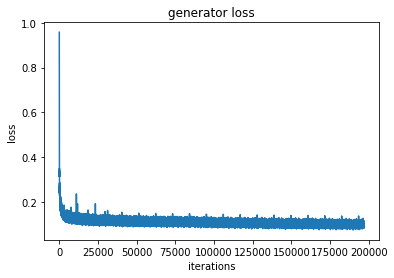

Step 196620: dloss = 0.7904, gloss = 0.1107, real_loss = 0.0000, fake_loss = 0.7904, gan_loss = 10155.0020 l1_loss = 0.1006
Step 196630: dloss = 0.7784, gloss = 0.1117, real_loss = 0.0000, fake_loss = 0.7784, gan_loss = 10559.4199 l1_loss = 0.1011
Step 196640: dloss = 0.7779, gloss = 0.0954, real_loss = 0.0007, fake_loss = 0.7771, gan_loss = 10228.7334 l1_loss = 0.0851
Step 196650: dloss = 1.0688, gloss = 0.1122, real_loss = 0.2752, fake_loss = 0.7936, gan_loss = 10232.6855 l1_loss = 0.1020
Step 196660: dloss = 0.8215, gloss = 0.0953, real_loss = 0.0000, fake_loss = 0.8215, gan_loss = 10576.3496 l1_loss = 0.0847
Step 196670: dloss = 0.7807, gloss = 0.0890, real_loss = 0.0000, fake_loss = 0.7807, gan_loss = 10187.7285 l1_loss = 0.0788
Step 196680: dloss = 0.8230, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.8230, gan_loss = 9895.1846 l1_loss = 0.0835
Step 196690: dloss = 0.8111, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8111, gan_loss = 10307.7051 l1_loss = 0.0875
Step 1967

Step 197290: dloss = 0.8021, gloss = 0.0895, real_loss = 0.0026, fake_loss = 0.7995, gan_loss = 9929.0693 l1_loss = 0.0795
Step 197300: dloss = 0.7798, gloss = 0.1071, real_loss = 0.0000, fake_loss = 0.7798, gan_loss = 10523.4053 l1_loss = 0.0966
Step 197310: dloss = 0.8240, gloss = 0.0950, real_loss = 0.0000, fake_loss = 0.8240, gan_loss = 10212.7139 l1_loss = 0.0848
Step 197320: dloss = 0.7993, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.7993, gan_loss = 10699.2441 l1_loss = 0.0852
Step 197330: dloss = 0.7846, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.7846, gan_loss = 9924.3125 l1_loss = 0.0830
Step 197340: dloss = 0.8103, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.8103, gan_loss = 10474.5166 l1_loss = 0.0896
Step 197350: dloss = 0.7813, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.7813, gan_loss = 10044.5596 l1_loss = 0.0968
Step 197360: dloss = 0.7734, gloss = 0.0871, real_loss = 0.0000, fake_loss = 0.7734, gan_loss = 10092.2217 l1_loss = 0.0771
Step 19737

Step 197960: dloss = 0.7864, gloss = 0.1042, real_loss = 0.0000, fake_loss = 0.7864, gan_loss = 9857.2920 l1_loss = 0.0943
Step 197970: dloss = 0.8039, gloss = 0.0891, real_loss = 0.0000, fake_loss = 0.8039, gan_loss = 10025.8203 l1_loss = 0.0791
Step 197980: dloss = 0.8320, gloss = 0.0849, real_loss = 0.0000, fake_loss = 0.8320, gan_loss = 9853.3750 l1_loss = 0.0750
Step 197990: dloss = 0.7978, gloss = 0.0907, real_loss = 0.0000, fake_loss = 0.7978, gan_loss = 10280.7568 l1_loss = 0.0804
Step 198000: dloss = 0.8227, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.8227, gan_loss = 10163.2402 l1_loss = 0.0866
Step 198010: dloss = 0.8192, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8192, gan_loss = 10341.8887 l1_loss = 0.0886
Step 198020: dloss = 0.8061, gloss = 0.1122, real_loss = 0.0000, fake_loss = 0.8061, gan_loss = 9986.3506 l1_loss = 0.1022
Step 198030: dloss = 0.8105, gloss = 0.0867, real_loss = 0.0000, fake_loss = 0.8105, gan_loss = 10113.9941 l1_loss = 0.0766
Step 198040

Step 198630: dloss = 0.8181, gloss = 0.0955, real_loss = 0.0000, fake_loss = 0.8181, gan_loss = 10034.7305 l1_loss = 0.0854
Step 198640: dloss = 0.7777, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.7777, gan_loss = 9805.5693 l1_loss = 0.0977
Step 198650: dloss = 0.7888, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.7888, gan_loss = 10558.4365 l1_loss = 0.0919
Step 198660: dloss = 0.7925, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.7925, gan_loss = 9940.2295 l1_loss = 0.0913
Step 198670: dloss = 0.8128, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8128, gan_loss = 9987.1035 l1_loss = 0.0881
Step 198680: dloss = 0.8327, gloss = 0.1129, real_loss = 0.0000, fake_loss = 0.8327, gan_loss = 10323.5410 l1_loss = 0.1026
Step 198690: dloss = 0.7852, gloss = 0.0984, real_loss = 0.0000, fake_loss = 0.7852, gan_loss = 10087.1807 l1_loss = 0.0883
Step 198700: dloss = 0.7816, gloss = 0.0911, real_loss = 0.0000, fake_loss = 0.7816, gan_loss = 9726.6641 l1_loss = 0.0814
Step 198710:

Step 199300: dloss = 0.9121, gloss = 0.0903, real_loss = 0.1048, fake_loss = 0.8074, gan_loss = 9888.7646 l1_loss = 0.0804
Step 199310: dloss = 0.7930, gloss = 0.0867, real_loss = 0.0000, fake_loss = 0.7930, gan_loss = 9932.1299 l1_loss = 0.0767
Step 199320: dloss = 0.8017, gloss = 0.0963, real_loss = 0.0000, fake_loss = 0.8017, gan_loss = 10272.5361 l1_loss = 0.0860
Step 199330: dloss = 0.8319, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 9832.0742 l1_loss = 0.0842
Step 199340: dloss = 0.7895, gloss = 0.0886, real_loss = 0.0000, fake_loss = 0.7895, gan_loss = 10510.5264 l1_loss = 0.0781
Step 199350: dloss = 0.7827, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.7827, gan_loss = 10148.5869 l1_loss = 0.0950
Step 199360: dloss = 0.8057, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8057, gan_loss = 10153.0117 l1_loss = 0.0947
Step 199370: dloss = 0.8146, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8146, gan_loss = 9952.3408 l1_loss = 0.0879
Step 199380:

Step 199970: dloss = 0.7855, gloss = 0.0913, real_loss = 0.0000, fake_loss = 0.7855, gan_loss = 10163.5068 l1_loss = 0.0811
Step 199980: dloss = 0.7963, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.7963, gan_loss = 10211.8975 l1_loss = 0.0878
Step 199990: dloss = 0.8716, gloss = 0.0923, real_loss = 0.0756, fake_loss = 0.7960, gan_loss = 10120.3535 l1_loss = 0.0821
Step 200000: dloss = 0.7959, gloss = 0.0875, real_loss = 0.0000, fake_loss = 0.7959, gan_loss = 9943.5518 l1_loss = 0.0775
Step 200010: dloss = 0.7766, gloss = 0.1009, real_loss = 0.0000, fake_loss = 0.7766, gan_loss = 10361.4082 l1_loss = 0.0905
Step 200020: dloss = 0.8072, gloss = 0.0958, real_loss = 0.0000, fake_loss = 0.8072, gan_loss = 10185.7383 l1_loss = 0.0856
Step 200030: dloss = 1.0175, gloss = 0.1005, real_loss = 0.2120, fake_loss = 0.8056, gan_loss = 9944.0049 l1_loss = 0.0905
Step 200040: dloss = 1.0627, gloss = 0.1037, real_loss = 0.2763, fake_loss = 0.7864, gan_loss = 9902.9863 l1_loss = 0.0938
Step 200050

Step 200640: dloss = 0.7986, gloss = 0.0898, real_loss = 0.0000, fake_loss = 0.7986, gan_loss = 9951.5371 l1_loss = 0.0799
Step 200650: dloss = 0.8113, gloss = 0.0922, real_loss = 0.0000, fake_loss = 0.8113, gan_loss = 9960.7051 l1_loss = 0.0823
Step 200660: dloss = 0.7690, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.7690, gan_loss = 9851.5889 l1_loss = 0.0920
Step 200670: dloss = 0.8072, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8072, gan_loss = 10376.0234 l1_loss = 0.0892
Step 200680: dloss = 0.8039, gloss = 0.0933, real_loss = 0.0000, fake_loss = 0.8039, gan_loss = 10009.7686 l1_loss = 0.0833
Step 200690: dloss = 0.7731, gloss = 0.1082, real_loss = 0.0000, fake_loss = 0.7731, gan_loss = 10121.5869 l1_loss = 0.0981
Step 200700: dloss = 0.8235, gloss = 0.1044, real_loss = 0.0000, fake_loss = 0.8235, gan_loss = 9824.7627 l1_loss = 0.0946
Step 200710: dloss = 0.8049, gloss = 0.0931, real_loss = 0.0000, fake_loss = 0.8049, gan_loss = 9778.8496 l1_loss = 0.0833
Step 200720: 

Step 201310: dloss = 0.8174, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.8174, gan_loss = 10175.6191 l1_loss = 0.0876
Step 201320: dloss = 0.7962, gloss = 0.1079, real_loss = 0.0000, fake_loss = 0.7962, gan_loss = 10247.0381 l1_loss = 0.0976
Step 201330: dloss = 0.7966, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.7966, gan_loss = 10019.6172 l1_loss = 0.0887
Step 201340: dloss = 0.7915, gloss = 0.1028, real_loss = 0.0000, fake_loss = 0.7915, gan_loss = 9852.5508 l1_loss = 0.0930
Step 201350: dloss = 0.8386, gloss = 0.0849, real_loss = 0.0084, fake_loss = 0.8302, gan_loss = 9790.7695 l1_loss = 0.0752
Step 201360: dloss = 0.8270, gloss = 0.0931, real_loss = 0.0000, fake_loss = 0.8270, gan_loss = 10294.6719 l1_loss = 0.0828
Step 201370: dloss = 0.8136, gloss = 0.0891, real_loss = 0.0000, fake_loss = 0.8136, gan_loss = 10364.6973 l1_loss = 0.0787
Step 201380: dloss = 0.8294, gloss = 0.0863, real_loss = 0.0000, fake_loss = 0.8294, gan_loss = 10074.4883 l1_loss = 0.0762
Step 20139

Step 201980: dloss = 0.8059, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8059, gan_loss = 9818.9678 l1_loss = 0.0884
Step 201990: dloss = 0.8118, gloss = 0.0996, real_loss = 0.0000, fake_loss = 0.8118, gan_loss = 10003.8682 l1_loss = 0.0895
Step 202000: dloss = 0.7811, gloss = 0.1013, real_loss = 0.0000, fake_loss = 0.7811, gan_loss = 9864.1396 l1_loss = 0.0914
Step 202010: dloss = 0.7965, gloss = 0.0924, real_loss = 0.0000, fake_loss = 0.7965, gan_loss = 10238.4717 l1_loss = 0.0822
Step 202020: dloss = 0.7937, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.7937, gan_loss = 9836.9014 l1_loss = 0.0875
Step 202030: dloss = 0.7819, gloss = 0.0904, real_loss = 0.0000, fake_loss = 0.7819, gan_loss = 10160.7686 l1_loss = 0.0802
Step 202040: dloss = 0.8184, gloss = 0.0900, real_loss = 0.0000, fake_loss = 0.8184, gan_loss = 10319.7646 l1_loss = 0.0796
Step 202050: dloss = 0.7993, gloss = 0.0882, real_loss = 0.0000, fake_loss = 0.7993, gan_loss = 9799.8604 l1_loss = 0.0784
Step 202060:

Step 202650: dloss = 0.8018, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8018, gan_loss = 9765.5244 l1_loss = 0.0894
Step 202660: dloss = 0.7651, gloss = 0.0897, real_loss = 0.0000, fake_loss = 0.7651, gan_loss = 9930.9619 l1_loss = 0.0797
Step 202670: dloss = 0.8014, gloss = 0.0896, real_loss = 0.0000, fake_loss = 0.8014, gan_loss = 9704.6094 l1_loss = 0.0799
Step 202680: dloss = 0.8046, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.8046, gan_loss = 9844.9863 l1_loss = 0.0832
Step 202690: dloss = 0.8350, gloss = 0.1052, real_loss = 0.0464, fake_loss = 0.7886, gan_loss = 9685.3672 l1_loss = 0.0955
Step 202700: dloss = 0.8074, gloss = 0.0914, real_loss = 0.0010, fake_loss = 0.8063, gan_loss = 10114.3242 l1_loss = 0.0813
Step 202710: dloss = 0.7948, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.7948, gan_loss = 10218.1611 l1_loss = 0.0871
Step 202720: dloss = 0.8351, gloss = 0.0929, real_loss = 0.0000, fake_loss = 0.8351, gan_loss = 9811.9561 l1_loss = 0.0831
Step 202730: d

Step 203320: dloss = 0.8242, gloss = 0.1002, real_loss = 0.0000, fake_loss = 0.8242, gan_loss = 10082.6201 l1_loss = 0.0902
Step 203330: dloss = 0.7843, gloss = 0.0925, real_loss = 0.0000, fake_loss = 0.7843, gan_loss = 9681.0225 l1_loss = 0.0828
Step 203340: dloss = 0.8011, gloss = 0.0953, real_loss = 0.0000, fake_loss = 0.8011, gan_loss = 10223.5527 l1_loss = 0.0851
Step 203350: dloss = 0.8076, gloss = 0.0854, real_loss = 0.0000, fake_loss = 0.8076, gan_loss = 9669.9014 l1_loss = 0.0758
Step 203360: dloss = 0.7944, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.7944, gan_loss = 10047.9521 l1_loss = 0.0967
Step 203370: dloss = 0.7849, gloss = 0.1034, real_loss = 0.0000, fake_loss = 0.7849, gan_loss = 10148.2236 l1_loss = 0.0932
Step 203380: dloss = 0.7928, gloss = 0.0978, real_loss = 0.0000, fake_loss = 0.7928, gan_loss = 10148.0371 l1_loss = 0.0876
Step 203390: dloss = 0.8199, gloss = 0.0964, real_loss = 0.0000, fake_loss = 0.8199, gan_loss = 9841.2705 l1_loss = 0.0865
Step 203400

Step 203990: dloss = 0.7920, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.7920, gan_loss = 10531.5684 l1_loss = 0.0835
Step 204000: dloss = 0.8185, gloss = 0.1043, real_loss = 0.0000, fake_loss = 0.8185, gan_loss = 9734.9980 l1_loss = 0.0945
Step 204010: dloss = 0.8114, gloss = 0.1068, real_loss = 0.0000, fake_loss = 0.8114, gan_loss = 9961.8525 l1_loss = 0.0969
Step 204020: dloss = 0.8232, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.8232, gan_loss = 9842.9463 l1_loss = 0.0850
Step 204030: dloss = 0.7848, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.7848, gan_loss = 9926.4492 l1_loss = 0.0898
Step 204040: dloss = 1.0763, gloss = 0.0949, real_loss = 0.2627, fake_loss = 0.8136, gan_loss = 9996.2227 l1_loss = 0.0849
Step 204050: dloss = 0.7903, gloss = 0.0883, real_loss = 0.0190, fake_loss = 0.7713, gan_loss = 9891.6514 l1_loss = 0.0784
Step 204060: dloss = 0.8294, gloss = 0.0917, real_loss = 0.0000, fake_loss = 0.8294, gan_loss = 9796.1279 l1_loss = 0.0819
Step 204070: dl

Step 204660: dloss = 0.7648, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.7648, gan_loss = 9909.0723 l1_loss = 0.0869
Step 204670: dloss = 0.7932, gloss = 0.1109, real_loss = 0.0000, fake_loss = 0.7932, gan_loss = 9996.0225 l1_loss = 0.1010
Step 204680: dloss = 0.8069, gloss = 0.0900, real_loss = 0.0000, fake_loss = 0.8069, gan_loss = 9900.4287 l1_loss = 0.0801
Step 204690: dloss = 0.8226, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8226, gan_loss = 10070.1631 l1_loss = 0.0856
Step 204700: dloss = 0.7810, gloss = 0.1064, real_loss = 0.0000, fake_loss = 0.7810, gan_loss = 9877.0596 l1_loss = 0.0965
Step 204710: dloss = 0.7882, gloss = 0.1010, real_loss = 0.0001, fake_loss = 0.7881, gan_loss = 9582.0830 l1_loss = 0.0914
Step 204720: dloss = 0.8132, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.8132, gan_loss = 9776.9863 l1_loss = 0.0838
Step 204730: dloss = 0.8057, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8057, gan_loss = 9791.4121 l1_loss = 0.0896
Step 204740: dl

Step 205330: dloss = 1.6648, gloss = 0.0954, real_loss = 0.8588, fake_loss = 0.8060, gan_loss = 10019.1982 l1_loss = 0.0853
Step 205340: dloss = 0.7845, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.7845, gan_loss = 9895.0430 l1_loss = 0.0891
Step 205350: dloss = 0.7995, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.7995, gan_loss = 9601.1387 l1_loss = 0.0929
Step 205360: dloss = 0.7937, gloss = 0.1040, real_loss = 0.0289, fake_loss = 0.7648, gan_loss = 9739.2383 l1_loss = 0.0943
Step 205370: dloss = 0.7819, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.7819, gan_loss = 9772.0625 l1_loss = 0.0964
Step 205380: dloss = 0.7952, gloss = 0.0911, real_loss = 0.0000, fake_loss = 0.7952, gan_loss = 9827.0752 l1_loss = 0.0812
Step 205390: dloss = 0.8263, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.8263, gan_loss = 10090.2725 l1_loss = 0.0834
Step 205400: dloss = 0.7801, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.7801, gan_loss = 9755.9395 l1_loss = 0.1018
Step 205410: d

Step 206000: dloss = 0.7582, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.7582, gan_loss = 9921.8818 l1_loss = 0.0922
Step 206010: dloss = 0.8098, gloss = 0.0896, real_loss = 0.0000, fake_loss = 0.8098, gan_loss = 9902.2119 l1_loss = 0.0797
Step 206020: dloss = 0.7871, gloss = 0.0933, real_loss = 0.0000, fake_loss = 0.7871, gan_loss = 9896.5586 l1_loss = 0.0834
Step 206030: dloss = 0.7995, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.7995, gan_loss = 9931.5693 l1_loss = 0.0835
Step 206040: dloss = 0.8050, gloss = 0.1046, real_loss = 0.0078, fake_loss = 0.7972, gan_loss = 10100.0527 l1_loss = 0.0945
Step 206050: dloss = 0.7985, gloss = 0.0987, real_loss = 0.0000, fake_loss = 0.7985, gan_loss = 9930.4434 l1_loss = 0.0887
Step 206060: dloss = 0.8042, gloss = 0.0934, real_loss = 0.0000, fake_loss = 0.8042, gan_loss = 9992.2979 l1_loss = 0.0834
Step 206070: dloss = 0.8075, gloss = 0.0916, real_loss = 0.0000, fake_loss = 0.8075, gan_loss = 10118.2646 l1_loss = 0.0814
Step 206080: d

Step 206670: dloss = 0.7937, gloss = 0.0957, real_loss = 0.0000, fake_loss = 0.7936, gan_loss = 9894.1318 l1_loss = 0.0858
Step 206680: dloss = 0.8076, gloss = 0.0967, real_loss = 0.0000, fake_loss = 0.8076, gan_loss = 10185.0449 l1_loss = 0.0865
Step 206690: dloss = 0.7871, gloss = 0.1120, real_loss = 0.0000, fake_loss = 0.7871, gan_loss = 10074.1328 l1_loss = 0.1019
Step 206700: dloss = 0.8179, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8179, gan_loss = 9983.7500 l1_loss = 0.0856
Step 206710: dloss = 0.8102, gloss = 0.0970, real_loss = 0.0000, fake_loss = 0.8102, gan_loss = 9533.8252 l1_loss = 0.0875
Step 206720: dloss = 0.8080, gloss = 0.1137, real_loss = 0.0000, fake_loss = 0.8080, gan_loss = 10035.1982 l1_loss = 0.1037
Step 206730: dloss = 0.7799, gloss = 0.1037, real_loss = 0.0000, fake_loss = 0.7799, gan_loss = 9729.5742 l1_loss = 0.0940
Step 206740: dloss = 0.8120, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8120, gan_loss = 9945.9844 l1_loss = 0.0890
Step 206750: 

Step 207340: dloss = 0.8141, gloss = 0.0855, real_loss = 0.0000, fake_loss = 0.8141, gan_loss = 9702.2109 l1_loss = 0.0758
Step 207350: dloss = 0.7732, gloss = 0.1034, real_loss = 0.0000, fake_loss = 0.7732, gan_loss = 10119.3916 l1_loss = 0.0933
Step 207360: dloss = 0.7889, gloss = 0.0925, real_loss = 0.0000, fake_loss = 0.7889, gan_loss = 9650.7881 l1_loss = 0.0829
Step 207370: dloss = 0.7734, gloss = 0.1156, real_loss = 0.0000, fake_loss = 0.7734, gan_loss = 10319.7246 l1_loss = 0.1052
Step 207380: dloss = 0.7863, gloss = 0.0841, real_loss = 0.0000, fake_loss = 0.7863, gan_loss = 9882.2441 l1_loss = 0.0742
Step 207390: dloss = 0.8394, gloss = 0.0941, real_loss = 0.0000, fake_loss = 0.8394, gan_loss = 9924.6621 l1_loss = 0.0841
Step 207400: dloss = 0.8142, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.8142, gan_loss = 9732.0801 l1_loss = 0.0928
Step 207410: dloss = 0.7609, gloss = 0.1091, real_loss = 0.0000, fake_loss = 0.7609, gan_loss = 10103.9648 l1_loss = 0.0990
Step 207420: 

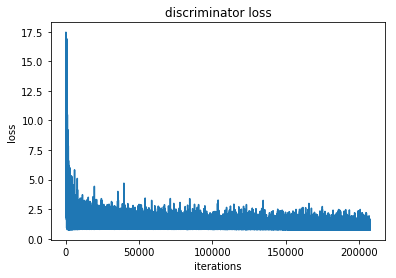

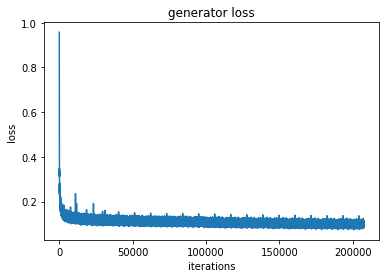

Step 207540: dloss = 0.7804, gloss = 0.1011, real_loss = 0.0000, fake_loss = 0.7804, gan_loss = 9741.5029 l1_loss = 0.0913
Step 207550: dloss = 0.8108, gloss = 0.0958, real_loss = 0.0000, fake_loss = 0.8108, gan_loss = 9723.4365 l1_loss = 0.0861
Step 207560: dloss = 0.8120, gloss = 0.0868, real_loss = 0.0000, fake_loss = 0.8120, gan_loss = 9681.1514 l1_loss = 0.0771
Step 207570: dloss = 0.8121, gloss = 0.0944, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 9690.4961 l1_loss = 0.0847
Step 207580: dloss = 0.7977, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.7977, gan_loss = 9566.0107 l1_loss = 0.0852
Step 207590: dloss = 0.7888, gloss = 0.0974, real_loss = 0.0000, fake_loss = 0.7888, gan_loss = 9985.9883 l1_loss = 0.0874
Step 207600: dloss = 1.6287, gloss = 0.1009, real_loss = 0.8450, fake_loss = 0.7837, gan_loss = 9914.7607 l1_loss = 0.0909
Step 207610: dloss = 0.7800, gloss = 0.1014, real_loss = 0.0000, fake_loss = 0.7800, gan_loss = 9856.5234 l1_loss = 0.0916
Step 207620: dlo

Step 208210: dloss = 0.8138, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.8138, gan_loss = 9947.7021 l1_loss = 0.0837
Step 208220: dloss = 0.7858, gloss = 0.0997, real_loss = 0.0000, fake_loss = 0.7858, gan_loss = 9540.1211 l1_loss = 0.0901
Step 208230: dloss = 0.8045, gloss = 0.0844, real_loss = 0.0000, fake_loss = 0.8045, gan_loss = 9916.8604 l1_loss = 0.0745
Step 208240: dloss = 0.8184, gloss = 0.0906, real_loss = 0.0000, fake_loss = 0.8184, gan_loss = 9992.3447 l1_loss = 0.0806
Step 208250: dloss = 0.7890, gloss = 0.0975, real_loss = 0.0082, fake_loss = 0.7808, gan_loss = 9883.7549 l1_loss = 0.0877
Step 208260: dloss = 0.8107, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.8107, gan_loss = 9874.4912 l1_loss = 0.0958
Step 208270: dloss = 0.7904, gloss = 0.1124, real_loss = 0.0000, fake_loss = 0.7904, gan_loss = 9940.6426 l1_loss = 0.1025
Step 208280: dloss = 0.8146, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8146, gan_loss = 9528.1162 l1_loss = 0.0870
Step 208290: dlo

Step 208880: dloss = 0.8110, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8110, gan_loss = 9858.8877 l1_loss = 0.0893
Step 208890: dloss = 0.8012, gloss = 0.1057, real_loss = 0.0000, fake_loss = 0.8012, gan_loss = 9848.3545 l1_loss = 0.0959
Step 208900: dloss = 0.8019, gloss = 0.0927, real_loss = 0.0000, fake_loss = 0.8019, gan_loss = 9922.4316 l1_loss = 0.0828
Step 208910: dloss = 0.8042, gloss = 0.0962, real_loss = 0.0000, fake_loss = 0.8042, gan_loss = 9573.0723 l1_loss = 0.0866
Step 208920: dloss = 0.7990, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.7990, gan_loss = 9661.9072 l1_loss = 0.1000
Step 208930: dloss = 0.7905, gloss = 0.0868, real_loss = 0.0000, fake_loss = 0.7905, gan_loss = 9712.5469 l1_loss = 0.0771
Step 208940: dloss = 0.7906, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.7906, gan_loss = 9860.4346 l1_loss = 0.0836
Step 208950: dloss = 0.8215, gloss = 0.0915, real_loss = 0.0000, fake_loss = 0.8215, gan_loss = 9974.5762 l1_loss = 0.0815
Step 208960: dlo

Step 209550: dloss = 0.8065, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8065, gan_loss = 9838.8506 l1_loss = 0.0899
Step 209560: dloss = 0.7941, gloss = 0.0943, real_loss = 0.0000, fake_loss = 0.7941, gan_loss = 9787.8096 l1_loss = 0.0845
Step 209570: dloss = 0.7721, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.7721, gan_loss = 9865.3115 l1_loss = 0.0927
Step 209580: dloss = 0.7710, gloss = 0.0910, real_loss = 0.0000, fake_loss = 0.7710, gan_loss = 9574.4150 l1_loss = 0.0815
Step 209590: dloss = 0.8016, gloss = 0.1117, real_loss = 0.0000, fake_loss = 0.8016, gan_loss = 9874.6465 l1_loss = 0.1019
Step 209600: dloss = 0.7945, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.7945, gan_loss = 9767.8398 l1_loss = 0.0900
Step 209610: dloss = 0.8269, gloss = 0.0972, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 9673.6006 l1_loss = 0.0875
Step 209620: dloss = 0.8137, gloss = 0.0961, real_loss = 0.0000, fake_loss = 0.8137, gan_loss = 9428.0625 l1_loss = 0.0867
Step 209630: dlo

Step 210220: dloss = 1.1477, gloss = 0.1086, real_loss = 0.3444, fake_loss = 0.8033, gan_loss = 10097.7129 l1_loss = 0.0985
Step 210230: dloss = 0.7995, gloss = 0.0928, real_loss = 0.0000, fake_loss = 0.7995, gan_loss = 9883.4385 l1_loss = 0.0829
Step 210240: dloss = 0.8002, gloss = 0.0928, real_loss = 0.0000, fake_loss = 0.8002, gan_loss = 9852.7148 l1_loss = 0.0830
Step 210250: dloss = 0.8055, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8055, gan_loss = 9814.9414 l1_loss = 0.0956
Step 210260: dloss = 0.7731, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.7731, gan_loss = 10444.5000 l1_loss = 0.0860
Step 210270: dloss = 0.7726, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.7726, gan_loss = 9588.7490 l1_loss = 0.0896
Step 210280: dloss = 0.8238, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8238, gan_loss = 9537.3770 l1_loss = 0.0899
Step 210290: dloss = 0.8713, gloss = 0.0824, real_loss = 0.0681, fake_loss = 0.8031, gan_loss = 9668.1826 l1_loss = 0.0727
Step 210300: d

Step 210890: dloss = 0.7940, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.7940, gan_loss = 9715.2109 l1_loss = 0.0882
Step 210900: dloss = 0.7771, gloss = 0.0970, real_loss = 0.0000, fake_loss = 0.7771, gan_loss = 9810.7920 l1_loss = 0.0872
Step 210910: dloss = 0.8801, gloss = 0.1011, real_loss = 0.0789, fake_loss = 0.8011, gan_loss = 9958.1709 l1_loss = 0.0912
Step 210920: dloss = 0.7810, gloss = 0.0949, real_loss = 0.0000, fake_loss = 0.7810, gan_loss = 9704.5840 l1_loss = 0.0852
Step 210930: dloss = 0.7918, gloss = 0.0993, real_loss = 0.0000, fake_loss = 0.7918, gan_loss = 9660.4404 l1_loss = 0.0896
Step 210940: dloss = 0.8204, gloss = 0.0863, real_loss = 0.0000, fake_loss = 0.8204, gan_loss = 9927.2900 l1_loss = 0.0764
Step 210950: dloss = 0.8237, gloss = 0.0988, real_loss = 0.0000, fake_loss = 0.8237, gan_loss = 9815.9053 l1_loss = 0.0890
Step 210960: dloss = 0.8047, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.8047, gan_loss = 9670.7100 l1_loss = 0.0889
Step 210970: dlo

Step 211560: dloss = 0.7947, gloss = 0.0875, real_loss = 0.0000, fake_loss = 0.7947, gan_loss = 9710.2500 l1_loss = 0.0778
Step 211570: dloss = 0.8021, gloss = 0.0928, real_loss = 0.0000, fake_loss = 0.8021, gan_loss = 9704.6670 l1_loss = 0.0831
Step 211580: dloss = 0.7814, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.7814, gan_loss = 9554.0010 l1_loss = 0.0841
Step 211590: dloss = 0.7879, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.7879, gan_loss = 9660.0498 l1_loss = 0.0907
Step 211600: dloss = 0.8319, gloss = 0.0872, real_loss = 0.0000, fake_loss = 0.8319, gan_loss = 10378.6172 l1_loss = 0.0768
Step 211610: dloss = 0.8168, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.8168, gan_loss = 9756.4922 l1_loss = 0.0847
Step 211620: dloss = 0.7971, gloss = 0.0971, real_loss = 0.0000, fake_loss = 0.7971, gan_loss = 9797.9463 l1_loss = 0.0873
Step 211630: dloss = 0.8121, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.8121, gan_loss = 9848.7803 l1_loss = 0.0934
Step 211640: dl

Step 212230: dloss = 0.8213, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.8213, gan_loss = 9566.9092 l1_loss = 0.0841
Step 212240: dloss = 0.7781, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.7781, gan_loss = 9735.6426 l1_loss = 0.0884
Step 212250: dloss = 0.8241, gloss = 0.0921, real_loss = 0.0000, fake_loss = 0.8241, gan_loss = 9607.9258 l1_loss = 0.0825
Step 212260: dloss = 0.7743, gloss = 0.0897, real_loss = 0.0000, fake_loss = 0.7743, gan_loss = 9509.6992 l1_loss = 0.0802
Step 212270: dloss = 0.7899, gloss = 0.1075, real_loss = 0.0000, fake_loss = 0.7899, gan_loss = 9792.2754 l1_loss = 0.0977
Step 212280: dloss = 0.8238, gloss = 0.0911, real_loss = 0.0000, fake_loss = 0.8238, gan_loss = 9634.9717 l1_loss = 0.0815
Step 212290: dloss = 0.8038, gloss = 0.0977, real_loss = 0.0000, fake_loss = 0.8038, gan_loss = 9814.2158 l1_loss = 0.0879
Step 212300: dloss = 0.8133, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8133, gan_loss = 9777.8418 l1_loss = 0.0893
Step 212310: dlo

Step 212900: dloss = 0.7991, gloss = 0.1039, real_loss = 0.0000, fake_loss = 0.7991, gan_loss = 9553.7363 l1_loss = 0.0943
Step 212910: dloss = 0.8028, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8028, gan_loss = 9319.1143 l1_loss = 0.0919
Step 212920: dloss = 0.7946, gloss = 0.1001, real_loss = 0.0000, fake_loss = 0.7946, gan_loss = 10088.6250 l1_loss = 0.0900
Step 212930: dloss = 0.7910, gloss = 0.0940, real_loss = 0.0062, fake_loss = 0.7848, gan_loss = 9933.1504 l1_loss = 0.0841
Step 212940: dloss = 0.8313, gloss = 0.0969, real_loss = 0.0025, fake_loss = 0.8288, gan_loss = 9634.8525 l1_loss = 0.0873
Step 212950: dloss = 0.8015, gloss = 0.0961, real_loss = 0.0000, fake_loss = 0.8015, gan_loss = 9676.1797 l1_loss = 0.0864
Step 212960: dloss = 0.8269, gloss = 0.0930, real_loss = 0.0000, fake_loss = 0.8269, gan_loss = 9798.0273 l1_loss = 0.0832
Step 212970: dloss = 0.8261, gloss = 0.0940, real_loss = 0.0000, fake_loss = 0.8261, gan_loss = 10141.2979 l1_loss = 0.0839
Step 212980: d

Step 213570: dloss = 0.8078, gloss = 0.0876, real_loss = 0.0000, fake_loss = 0.8078, gan_loss = 9624.6914 l1_loss = 0.0780
Step 213580: dloss = 0.7799, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.7799, gan_loss = 9761.6748 l1_loss = 0.0869
Step 213590: dloss = 0.7975, gloss = 0.0878, real_loss = 0.0000, fake_loss = 0.7975, gan_loss = 9793.5986 l1_loss = 0.0780
Step 213600: dloss = 0.7976, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.7976, gan_loss = 9720.4336 l1_loss = 0.0927
Step 213610: dloss = 0.7835, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.7835, gan_loss = 9639.2832 l1_loss = 0.0943
Step 213620: dloss = 0.7993, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.7993, gan_loss = 9608.7871 l1_loss = 0.0916
Step 213630: dloss = 0.7992, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.7992, gan_loss = 9705.8447 l1_loss = 0.0893
Step 213640: dloss = 0.8000, gloss = 0.0865, real_loss = 0.0000, fake_loss = 0.8000, gan_loss = 9946.7822 l1_loss = 0.0765
Step 213650: dlo

Step 214240: dloss = 0.7721, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.7721, gan_loss = 9629.8223 l1_loss = 0.0864
Step 214250: dloss = 0.8085, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.8085, gan_loss = 9843.1719 l1_loss = 0.0926
Step 214260: dloss = 0.7700, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.7700, gan_loss = 9556.4619 l1_loss = 0.0909
Step 214270: dloss = 0.8139, gloss = 0.0907, real_loss = 0.0000, fake_loss = 0.8139, gan_loss = 9719.1191 l1_loss = 0.0810
Step 214280: dloss = 0.8136, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8136, gan_loss = 9858.6172 l1_loss = 0.0899
Step 214290: dloss = 0.9200, gloss = 0.0949, real_loss = 0.1106, fake_loss = 0.8094, gan_loss = 9771.0762 l1_loss = 0.0851
Step 214300: dloss = 1.6040, gloss = 0.1060, real_loss = 0.8041, fake_loss = 0.7999, gan_loss = 9792.1045 l1_loss = 0.0962
Step 214310: dloss = 0.8052, gloss = 0.0927, real_loss = 0.0000, fake_loss = 0.8052, gan_loss = 9522.1719 l1_loss = 0.0832
Step 214320: dlo

Step 214910: dloss = 0.9236, gloss = 0.0885, real_loss = 0.1153, fake_loss = 0.8083, gan_loss = 9667.6279 l1_loss = 0.0788
Step 214920: dloss = 0.8084, gloss = 0.0983, real_loss = 0.0000, fake_loss = 0.8084, gan_loss = 9459.1016 l1_loss = 0.0888
Step 214930: dloss = 1.2027, gloss = 0.0899, real_loss = 0.4321, fake_loss = 0.7706, gan_loss = 9427.5645 l1_loss = 0.0805
Step 214940: dloss = 0.7782, gloss = 0.0947, real_loss = 0.0000, fake_loss = 0.7782, gan_loss = 9724.4805 l1_loss = 0.0850
Step 214950: dloss = 0.7982, gloss = 0.0912, real_loss = 0.0000, fake_loss = 0.7982, gan_loss = 9843.1689 l1_loss = 0.0813
Step 214960: dloss = 0.8016, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8016, gan_loss = 9614.9580 l1_loss = 0.0863
Step 214970: dloss = 0.8087, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8087, gan_loss = 9321.5234 l1_loss = 0.0941
Step 214980: dloss = 0.7929, gloss = 0.0942, real_loss = 0.0000, fake_loss = 0.7929, gan_loss = 9714.3418 l1_loss = 0.0845
Step 214990: dlo

Step 215580: dloss = 0.7962, gloss = 0.1039, real_loss = 0.0000, fake_loss = 0.7962, gan_loss = 9551.7852 l1_loss = 0.0943
Step 215590: dloss = 0.8058, gloss = 0.0868, real_loss = 0.0000, fake_loss = 0.8058, gan_loss = 9670.1523 l1_loss = 0.0772
Step 215600: dloss = 0.7855, gloss = 0.0926, real_loss = 0.0000, fake_loss = 0.7855, gan_loss = 9654.2705 l1_loss = 0.0829
Step 215610: dloss = 0.8622, gloss = 0.1158, real_loss = 0.0624, fake_loss = 0.7998, gan_loss = 10545.7930 l1_loss = 0.1053
Step 215620: dloss = 0.8099, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8099, gan_loss = 9415.8838 l1_loss = 0.0871
Step 215630: dloss = 0.8338, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8338, gan_loss = 9862.6309 l1_loss = 0.0877
Step 215640: dloss = 0.8181, gloss = 0.0932, real_loss = 0.0000, fake_loss = 0.8181, gan_loss = 9637.8652 l1_loss = 0.0836
Step 215650: dloss = 0.8066, gloss = 0.0898, real_loss = 0.0000, fake_loss = 0.8065, gan_loss = 9600.3213 l1_loss = 0.0802
Step 215660: dl

Step 216250: dloss = 0.7890, gloss = 0.0821, real_loss = 0.0000, fake_loss = 0.7890, gan_loss = 9473.1484 l1_loss = 0.0727
Step 216260: dloss = 0.8190, gloss = 0.0902, real_loss = 0.0000, fake_loss = 0.8190, gan_loss = 9443.4893 l1_loss = 0.0808
Step 216270: dloss = 0.8113, gloss = 0.0927, real_loss = 0.0000, fake_loss = 0.8113, gan_loss = 9390.5439 l1_loss = 0.0833
Step 216280: dloss = 0.7891, gloss = 0.0952, real_loss = 0.0000, fake_loss = 0.7891, gan_loss = 9637.2129 l1_loss = 0.0855
Step 216290: dloss = 0.7747, gloss = 0.0862, real_loss = 0.0000, fake_loss = 0.7747, gan_loss = 9400.3057 l1_loss = 0.0768
Step 216300: dloss = 0.8000, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.8000, gan_loss = 9532.1572 l1_loss = 0.0928
Step 216310: dloss = 0.7877, gloss = 0.0913, real_loss = 0.0000, fake_loss = 0.7877, gan_loss = 9668.7598 l1_loss = 0.0816
Step 216320: dloss = 0.8179, gloss = 0.0867, real_loss = 0.0000, fake_loss = 0.8179, gan_loss = 9683.9053 l1_loss = 0.0770
Step 216330: dlo

Step 216920: dloss = 0.7828, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.7828, gan_loss = 9575.1572 l1_loss = 0.0949
Step 216930: dloss = 0.7826, gloss = 0.1020, real_loss = 0.0000, fake_loss = 0.7826, gan_loss = 9840.8652 l1_loss = 0.0922
Step 216940: dloss = 0.8128, gloss = 0.0965, real_loss = 0.0000, fake_loss = 0.8128, gan_loss = 9957.8496 l1_loss = 0.0865
Step 216950: dloss = 0.7867, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.7867, gan_loss = 9437.2178 l1_loss = 0.0890
Step 216960: dloss = 0.7808, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.7808, gan_loss = 9749.6846 l1_loss = 0.0908
Step 216970: dloss = 0.7698, gloss = 0.0963, real_loss = 0.0000, fake_loss = 0.7698, gan_loss = 9575.7256 l1_loss = 0.0867
Step 216980: dloss = 0.7903, gloss = 0.0968, real_loss = 0.0000, fake_loss = 0.7903, gan_loss = 9770.1582 l1_loss = 0.0870
Step 216990: dloss = 0.7672, gloss = 0.1024, real_loss = 0.0000, fake_loss = 0.7672, gan_loss = 9719.1182 l1_loss = 0.0927
Step 217000: dlo

Step 217590: dloss = 0.8064, gloss = 0.1012, real_loss = 0.0000, fake_loss = 0.8064, gan_loss = 9709.8398 l1_loss = 0.0915
Step 217600: dloss = 0.7950, gloss = 0.0985, real_loss = 0.0000, fake_loss = 0.7950, gan_loss = 9419.6719 l1_loss = 0.0891
Step 217610: dloss = 0.8083, gloss = 0.0949, real_loss = 0.0063, fake_loss = 0.8020, gan_loss = 9430.0234 l1_loss = 0.0855
Step 217620: dloss = 0.8114, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.8114, gan_loss = 9375.3477 l1_loss = 0.0879
Step 217630: dloss = 0.8057, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8057, gan_loss = 9611.8877 l1_loss = 0.0911
Step 217640: dloss = 0.7901, gloss = 0.1021, real_loss = 0.0000, fake_loss = 0.7901, gan_loss = 9798.1963 l1_loss = 0.0923
Step 217650: dloss = 0.7963, gloss = 0.1013, real_loss = 0.0000, fake_loss = 0.7963, gan_loss = 9712.4404 l1_loss = 0.0915
Step 217660: dloss = 0.7986, gloss = 0.0906, real_loss = 0.0000, fake_loss = 0.7986, gan_loss = 9656.7412 l1_loss = 0.0810
Step 217670: dlo

Step 218260: dloss = 0.8027, gloss = 0.0975, real_loss = 0.0000, fake_loss = 0.8027, gan_loss = 9484.3984 l1_loss = 0.0880
Step 218270: dloss = 0.7913, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.7913, gan_loss = 9597.6748 l1_loss = 0.0920
Step 218280: dloss = 0.7963, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.7963, gan_loss = 9736.8604 l1_loss = 0.0918
Step 218290: dloss = 0.8019, gloss = 0.0892, real_loss = 0.0000, fake_loss = 0.8019, gan_loss = 9650.0449 l1_loss = 0.0795
Step 218300: dloss = 0.7955, gloss = 0.0852, real_loss = 0.0000, fake_loss = 0.7955, gan_loss = 9606.2051 l1_loss = 0.0756
Step 218310: dloss = 0.8141, gloss = 0.0945, real_loss = 0.0000, fake_loss = 0.8141, gan_loss = 9633.4121 l1_loss = 0.0848
Step 218320: dloss = 0.7929, gloss = 0.0883, real_loss = 0.0000, fake_loss = 0.7929, gan_loss = 9438.8252 l1_loss = 0.0789
Step 218330: dloss = 0.7941, gloss = 0.0883, real_loss = 0.0000, fake_loss = 0.7941, gan_loss = 9525.5654 l1_loss = 0.0787
Step 218340: dlo

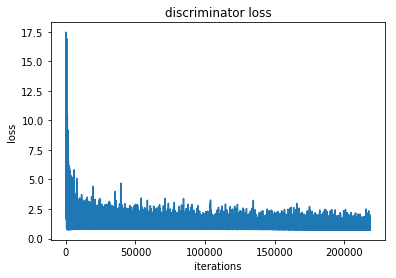

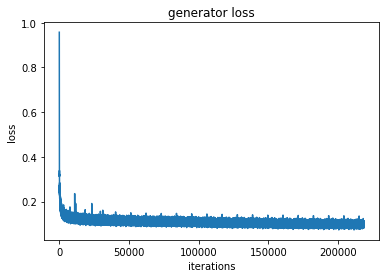

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 20
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
l = len(dataset_train) // batch_size

dis_losses = []
gen_losses = []




'''
local margin = 0.3
     sgdState_D.optimize = true
     sgdState_G.optimize = true
if err_F < margin or err_R < margin then
     sgdState_D.optimize = false
end
if err_F > (1.0-margin) or err_R > (1.0-margin) then
     sgdState_G.optimize = false
end
if sgdState_G.optimize == false and sgdState_D.optimize == false then
     sgdState_G.optimize = true
     sgdState_D.optimize = true
end
'''


real_m, fake_m = 0.2, 0.2
margin = 0.3 #(0.1*0.3 + 0.1 = 0.13)
doptim, goptim = True, True
_fake, _real = 0.5, 0.5
gen_loss = 1.0
dis_los = 0.5

gen_gan_t = 0.06
gan = 1.0

g_threshold = 0.13



for epoch in range(epochs):
    for ii in range(r):
        step += 1
        #zeros = np.zeros([batch_size, 1])* ((np.random.random_sample() *0.4) - 0.2)
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1]) * ((np.random.random_sample() *0.5) + 0.7)
        
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)

        
        k = np.random.randint(1,l-1)
        d_inputs = dataset_train[k*batch_size : (k+1)*batch_size]
        
        feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                    fake_label: zeros, real_label: ones, disc_inputs: d_inputs}
        fetch_val = [gen_loss_op, dis_loss_op, dreal_loss, dfake_loss, gan_loss, supervised_loss]
            
        #if _fake > (1.0 - fake_m) or _real > (1.0 - real_m):
        #    goptim = False
        
        #if gen_loss < 0.34:
        #    goptim = False
            
        #if gen_loss > margin
        
        #if _real < real_m or _fake < fake_m or dis_los < margin:
        #    doptim = False
            
        #if gen_loss < (g_threshold):
        #    goptim = False
        
        #if gan < gen_gan_t:
        #    goptim = False
            
        #if goptim == False and doptim == False:
        #    goptim, doptim = True, True
        
        if step % 5 or _real < real_m or _fake < fake_m or dis_los < margin: # biased towards generator
            fetch_val.append(gen_train_op)
        else:
            fetch_val.append(dis_train_op) 
        
        
        gen_loss, dis_loss, _real, _fake, gan, superl,_ = sess.run(fetch_val, feed_dict = feed_dict)

        dis_losses.append(dis_loss)
        gen_losses.append(gen_loss)
        
        #print(goptim, doptim)

        if step % 10 == 0:
            print('Step {0}: dloss = {1:.4f}, gloss = {2:.4f}, real_loss = {3:.4f}, fake_loss = {4:.4f}, gan_loss = {5:.4f} l1_loss = {6:.4f}'.format(step, dis_loss, gen_loss, _real, _fake, gan, superl))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}, real_label_loss = {3:.4f}, fake_label_loss = {4:.4f}'.format(epoch, dis_loss, gen_loss, _real, _fake))
    plt.plot(dis_losses)
    plt.title('discriminator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

    plt.plot(gen_losses)
    plt.title('generator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [46]:
#dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
#gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(dis_var_list + gen_var_list)
saver.save(sess, 'model/dcgan_pose_car_op_one_pose.ckpt')

'model/dcgan_pose_car_op_one_pose.ckpt'

In [96]:
d_pairs = test_pairs[1550*batch_size : 1551*batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)

print(len(test_pairs))

98420


In [86]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([generated_images], feed_dict = feed_dict)

In [87]:
j = 20
op = denormalize(op[0])



In [88]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

0.0313103 255.0


In [89]:
op = np.where(op < 0.0,0.0, op)

In [90]:
print(np.min(op), np.max(op))

0.0313103 255.0


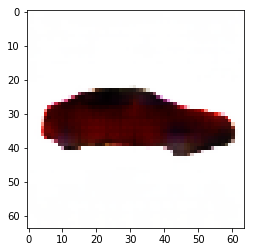

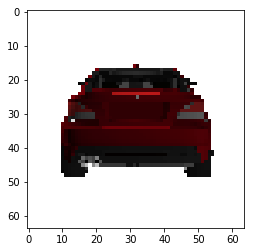

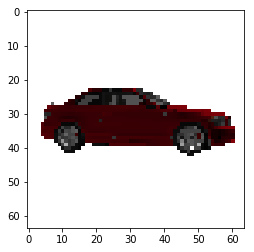

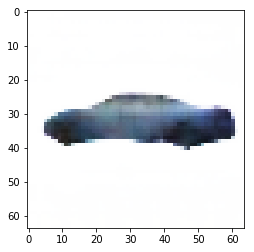

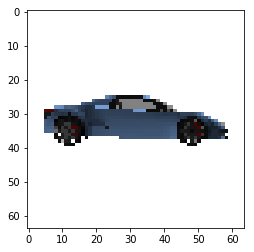

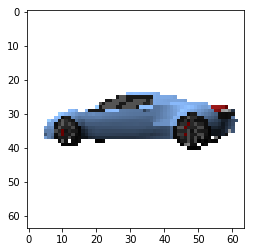

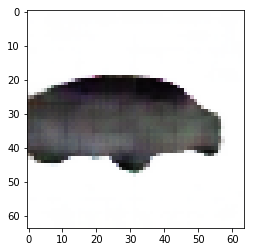

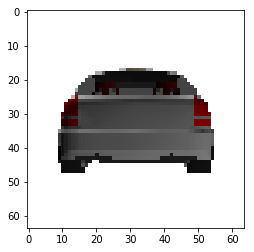

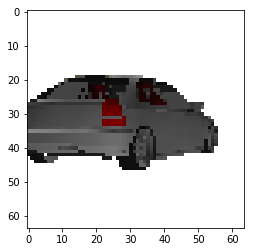

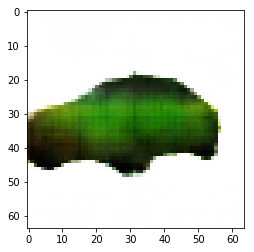

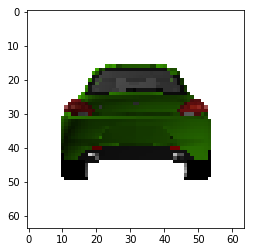

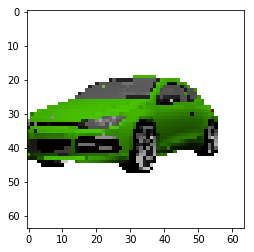

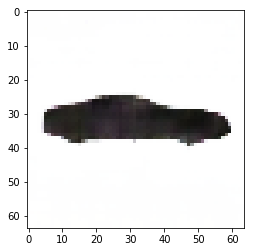

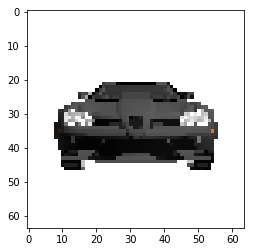

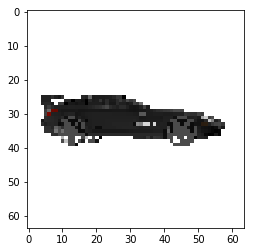

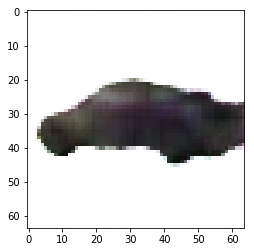

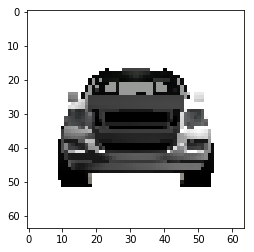

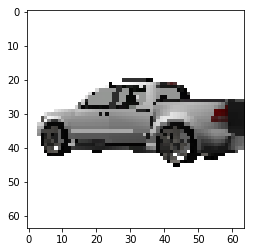

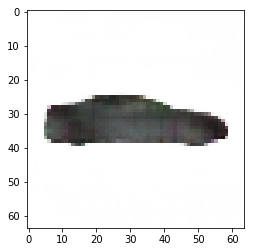

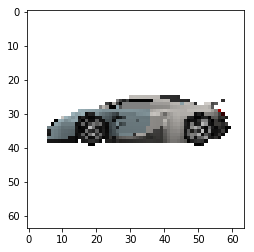

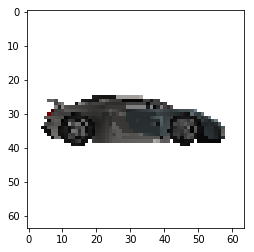

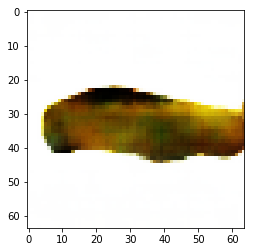

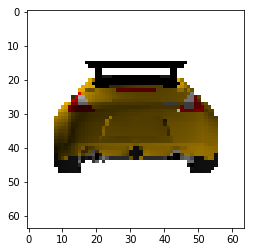

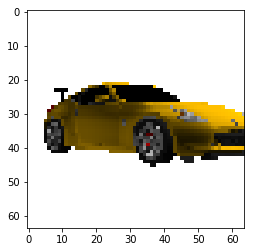

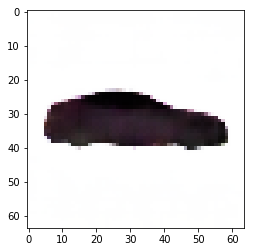

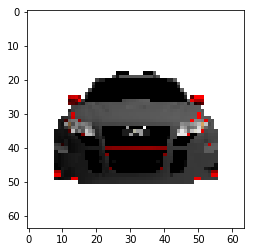

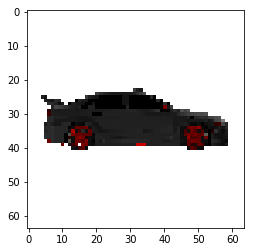

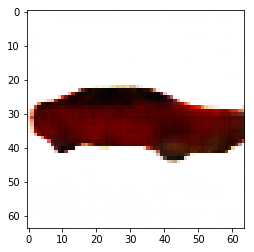

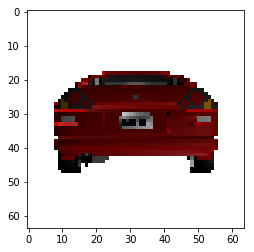

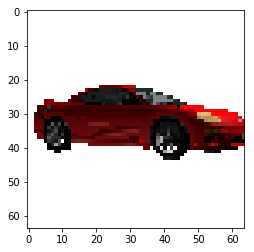

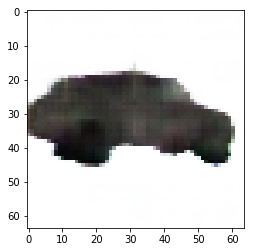

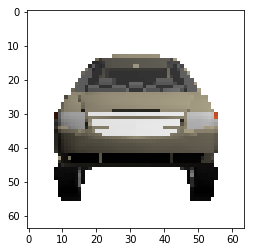

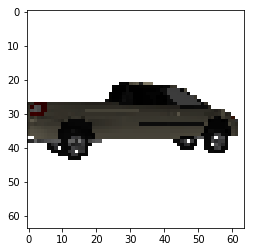

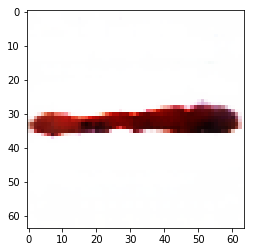

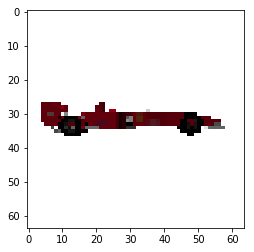

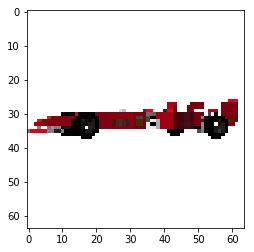

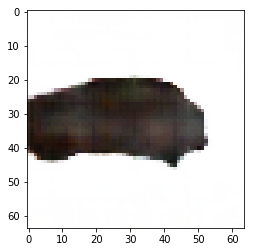

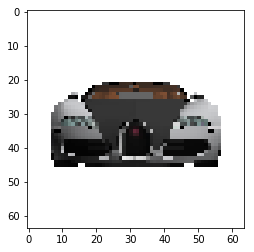

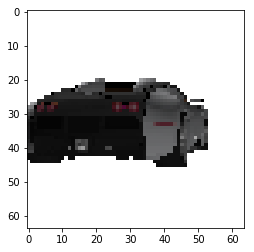

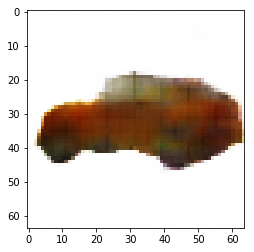

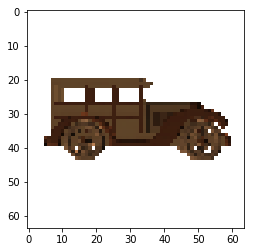

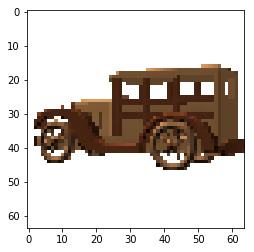

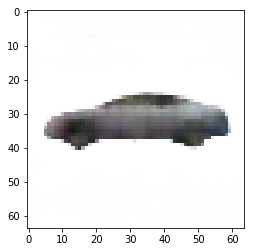

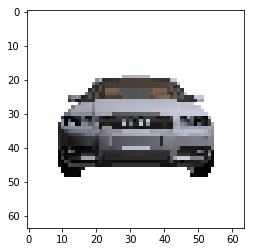

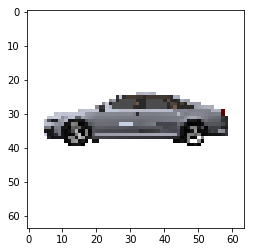

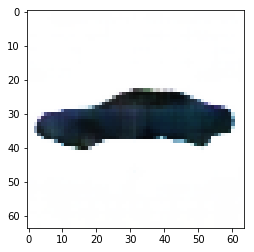

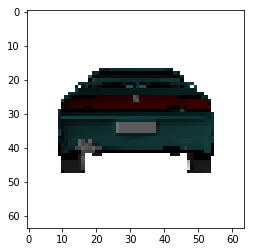

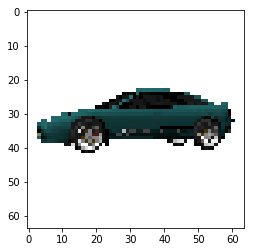

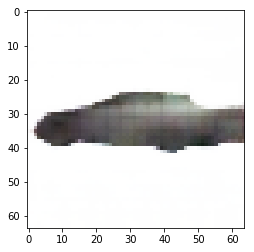

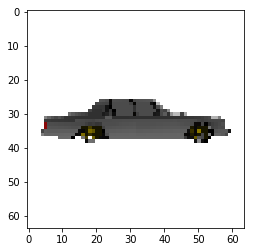

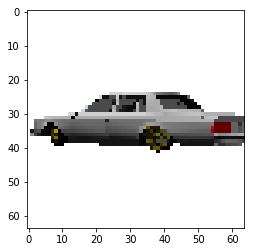

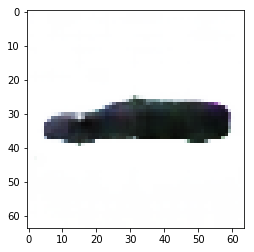

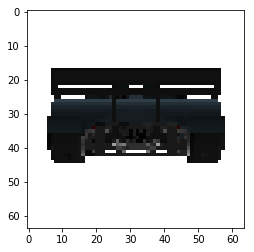

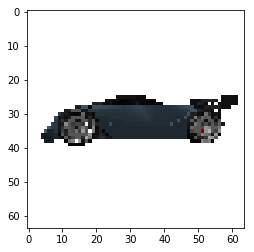

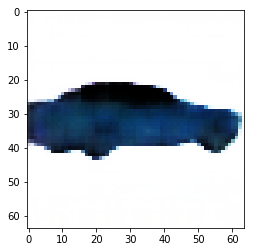

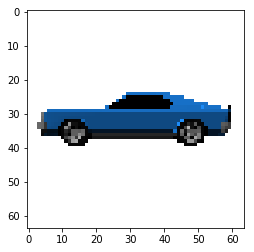

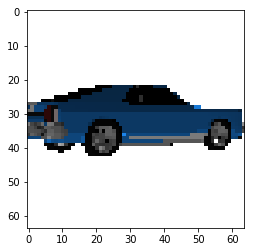

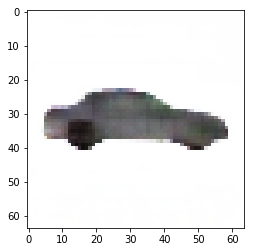

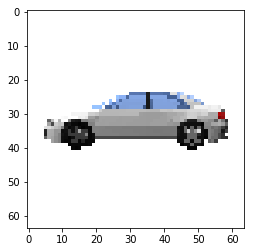

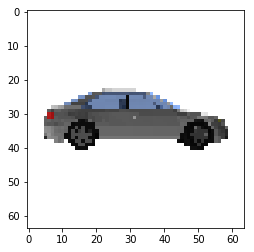

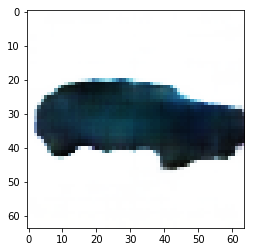

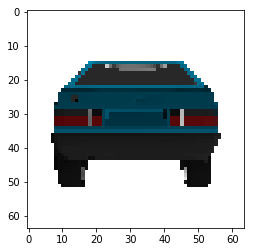

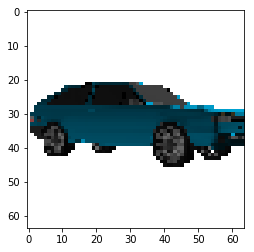

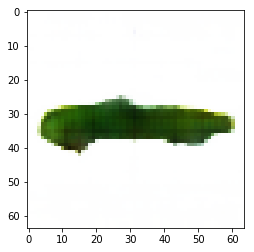

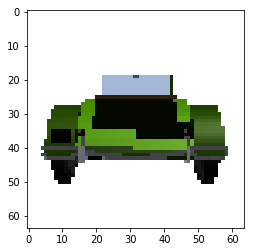

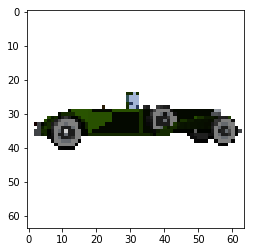

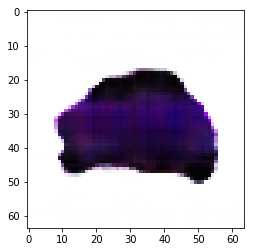

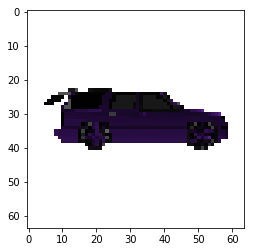

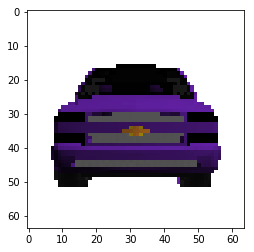

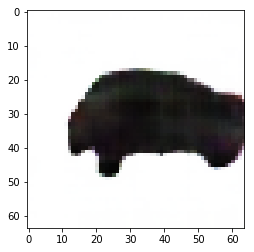

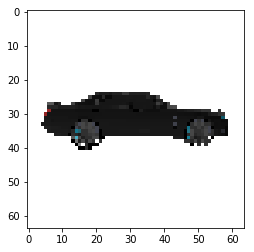

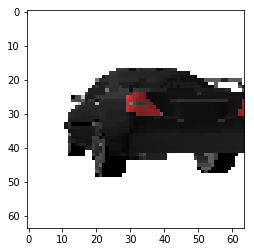

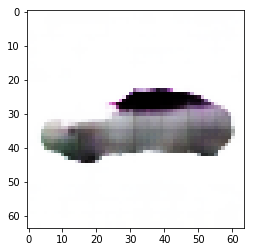

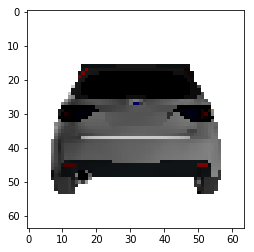

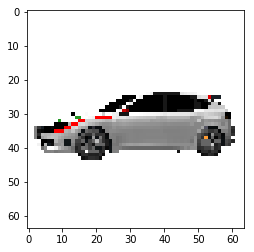

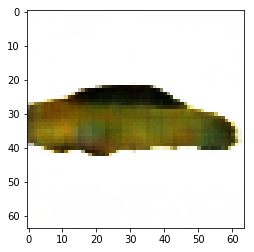

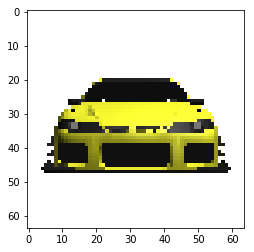

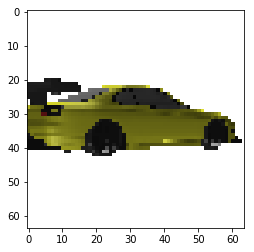

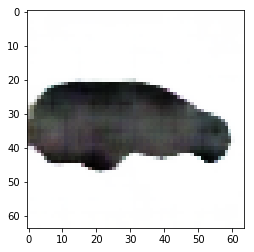

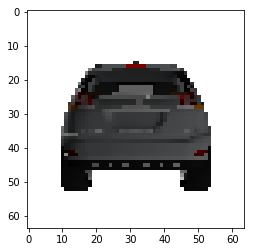

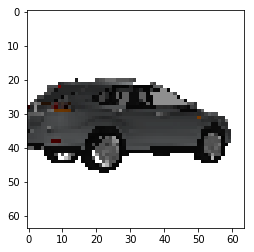

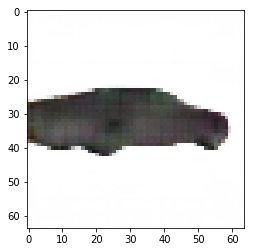

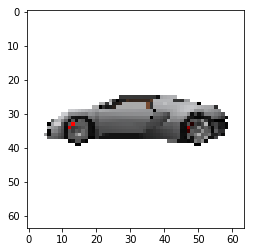

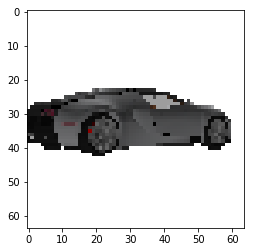

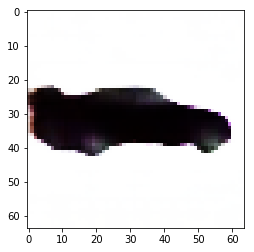

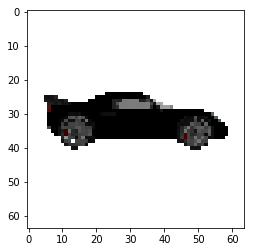

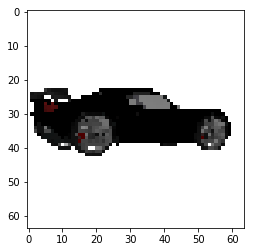

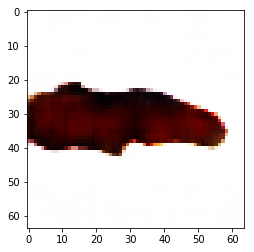

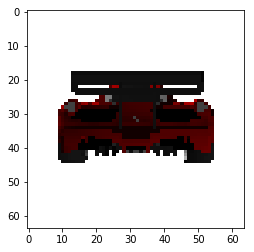

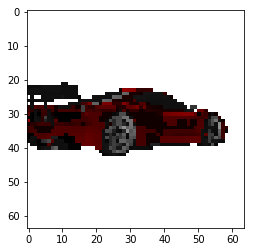

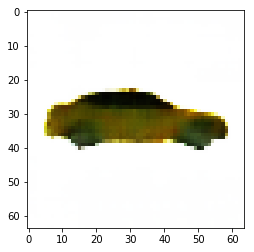

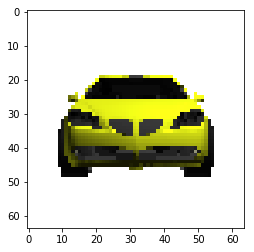

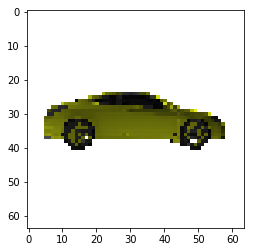

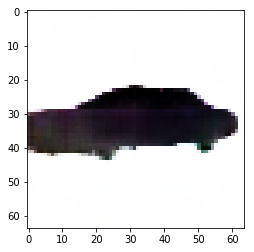

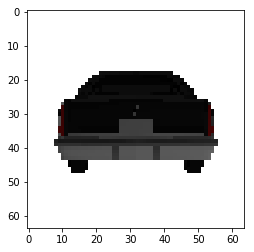

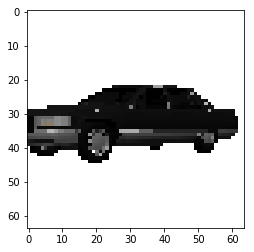

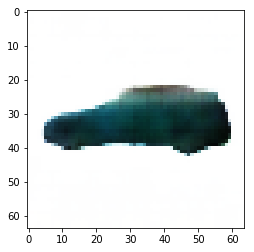

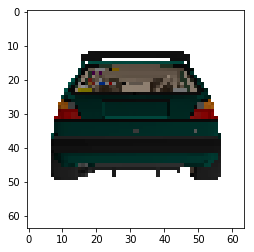

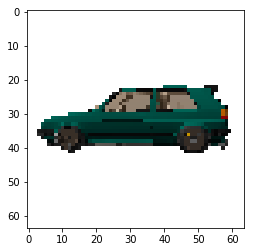

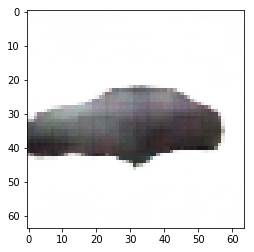

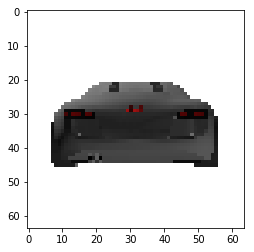

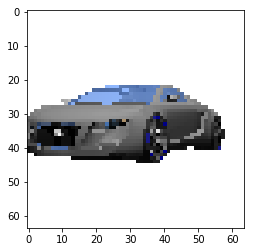

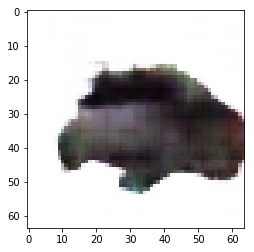

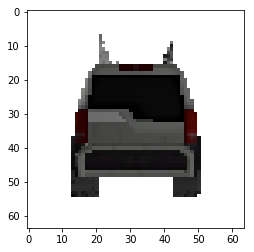

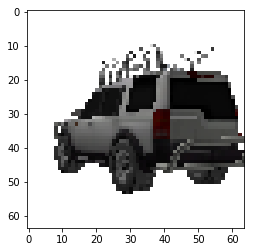

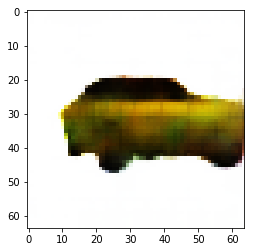

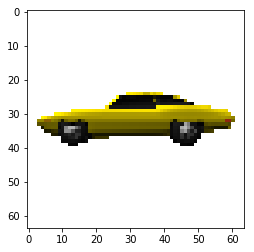

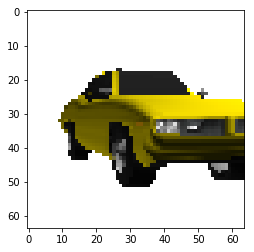

In [91]:
for j in range(batch_size):
    f = "batch_1551_output" + str(j) + '.png'
    tmp = op[j]
    misc.imsave(f, tmp/255)
    plt.imshow(tmp / 255)
    plt.show()

    f1 = "batch_1551_orig_image" + str(j) + '.png'
    misc.imsave(f1, denormalize(test_batch[j])/255)
    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()
    
    f2 = "batch_1551_ground_truth" + str(j) + '.png'
    misc.imsave(f2, denormalize(test_labels[j])/255)   
    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()